# Experiment Setup

* In this notebook, we perform experiment setup.
  
* Dataset description
  * An experiment is scoped to a floor map.
  * The dataset contains tracks collected on different floor maps with varying quantities and qualities. We can consider these tracks as representing manually collected data, while tracks without ground-truth locations represent passive-crowdsourced data.

* **Train/test split**: Because part of the evaluation process is to compare the performance of WiFi-fingerprint-based localization algorithms on the manually-collected dataset and the passive-crowdsourcing-derived dataset, the first step is to split the original dataset into training and testing datasets.
  * The training tracks are used to train a fingerprint-based model, while the testing tracks are used to evaluate the model's performance.
  * Training tracks without ground-truth locations, which represent passive-crowdsourced data, are used by passive-crowdsourcing algorithms to make fingerprint datasets.
  * The size of training and testing datasets should be reasonably large, so only floor maps with enough amount of data will be kept.

* **Semi-supervised Experiment Setup**: Semi-supervised scenarios are used to investigate the effects of known labeled fingerprints on the performance of passive-crowdsourcing methods. For this purpose, some fingerprints are annotated with locations and extracted as a labeled dataset, while others are kept as an unlabeled dataset, which serves as the input for the passive crowdsourcing task.

In [1]:
import os
import sys

PROJECT_HOME = "./../.."
# Add utilities library for Microsoft Indoor Localization 2.0 Dataset
CODE_DIR = os.path.join(PROJECT_HOME, "code")
print("The code directory is located at", CODE_DIR)
sys.path.append(CODE_DIR)

The code directory is located at ./../../code


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely.vectorized
import shapely.ops as shapely_ops

from glob import glob
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors

In [3]:
from py_indoor_loc.floor_map import read_floor_data, extract_floor_map_geometries
from py_indoor_loc.extract.wifi_fingerprint import extract_fingerprint_df

In [4]:
from ortools.algorithms.python import knapsack_solver

In [5]:
import gc

In [6]:
%matplotlib inline

## Train/Test Split

### Loading Data

In [7]:
data_dir = "../../data/wifi_fingerprint_manual/train"
metadata_dir = "../../data/metadata"

In [8]:
def read_fingerprint_locations(site_id: str, floor_id: str, data_dir: str,
                               track_id_list: list[str] | None = None) -> np.ndarray | None:
  if track_id_list is not None:
    fingerprint_files = [f"{data_dir}/{site_id}/{floor_id}/{track_id}_wifi_fingerprint.csv"
                         for track_id in track_id_list]
  else:
    fingerprint_files = list(glob(f"{data_dir}/{site_id}/{floor_id}/*_wifi_fingerprint.csv"))

  fingerprint_df, _ = extract_fingerprint_df(fingerprint_files)
  return fingerprint_df[["x", "y"]].values

### Floor Map Coverage of Fingerprints

* The first step is to estimate the floor map coverage of fingerprints.

In [15]:
class FloorMapCoverageEstimator(object):

  def __init__(self,
               floor_polygons,
               store_polygons,
               width_meter,
               height_meter,
               grid_resolution: float = 2):
    self.__floor_polygons = floor_polygons
    self.__store_polygons = store_polygons
    self.__grid_resolution = grid_resolution
    self.__width_meter = width_meter
    self.__height_meter = height_meter

    self.__search_space = FloorMapCoverageEstimator._extract_hallway(
        floor_polygons, store_polygons)
    _ = self._make_grid()

  @property
  def width_meter(self):
    return self.__width_meter

  @property
  def height_meter(self):
    return self.__height_meter

  @property
  def grid_resolution(self):
    return self.__grid_resolution

  @property
  def search_space(self):
    return self.__search_space

  @property
  def floor_polygons(self):
    return self.__floor_polygons

  @property
  def store_polygons(self):
    return self.__store_polygons

  @classmethod
  def _extract_hallway(cls, floor_polygons, store_polygons, tol: float = 1.0):
    union_floor_polygon = shapely_ops.unary_union(floor_polygons).buffer(tol)
    union_store_polygon = shapely_ops.unary_union(store_polygons).buffer(-tol)
    return union_floor_polygon.difference(union_store_polygon)

  def _make_grid(self):
    grid_xs_ = np.arange(0, self.width_meter,
                         self.grid_resolution) + self.grid_resolution / 2
    grid_ys_ = np.arange(0, self.height_meter,
                         self.grid_resolution) + self.grid_resolution / 2

    if grid_xs_.shape[0] == 0 or grid_ys_.shape[0] == 0:
      raise ValueError("Search space contains no bin points")

    grid_x_, grid_y_ = np.meshgrid(grid_xs_, grid_ys_)
    search_space_mask = shapely.vectorized.contains(self.search_space, grid_x_,
                                                    grid_y_)
    bin_x_, bin_y_ = grid_x_[search_space_mask], grid_y_[search_space_mask]

    self.bin_points = np.vstack((bin_x_, bin_y_)).T
    if self.bin_points.shape[0] == 0:
      raise ValueError("Search space contains no bin points")

    self.nearest_neighbors = NearestNeighbors(n_neighbors=4,
                                              algorithm="ball_tree",
                                              n_jobs=-1).fit(self.bin_points)

    return self

  def get_bin_coverage(self, points: np.ndarray, tol: float) -> np.ndarray:
    distances, indices = self.nearest_neighbors.kneighbors(points,
                                                           n_neighbors=1)
    return np.unique(indices[distances <= tol])

  @property
  def n_bins(self):
    return self.bin_points.shape[0]

In [16]:
def create_floor_map_coverage_estimator(site_id: str, floor_id: str, metadata_dir: str) -> FloorMapCoverageEstimator | None:

  try:
    floor_info, floor_map = read_floor_data(os.path.join(metadata_dir, site_id, floor_id))

    transform_func = lambda coords: coords

    (
      floor_polygons,
      store_polygons,
      x_min,
      y_min,
      x_max,
      y_max,
      width_meter,
      height_meter,
    ) = extract_floor_map_geometries(floor_map, floor_info, transform=transform_func)

    return FloorMapCoverageEstimator(floor_polygons, store_polygons, width_meter, height_meter)

  except Exception as ignored:
    print(f"Failed to create floor map coverage estimator, caused by {str(ignored)}")
    return None

### Train/Test Split Problem Formulation

* We model the train/test split as a knapsack problem.
* Given `n` tracks `[T1, T2, ..., Tn]`, their associated lengths `[L1, L2, ..., Ln]`, their location coverage in the original dataset `[C1, C2, ..., Cn]`. Choose a subset of tracks such that i) the total length of the subset is not greater than a predefined threshold and ii) the total coverage is maximized.
* We can think of tracks as items, their lengths as capacities, and their location coverages as weights in a knapsack problem.

In [17]:
def list_tracks(site_id: str, floor_id: str, data_dir: str) -> list[str]:
  return [os.path.basename(track_path)[:-len("_wifi_fingerprint.csv")]
          for track_path in glob(os.path.join(data_dir, site_id, floor_id) + "/*_wifi_fingerprint.csv")]

In [18]:
def get_floor_track_values_and_weights(site_id, floor_id, data_dir, track_id_list, 
                                       floor_map_coverage_estimator,
                                       enable_tqdm: bool = False):
  floor_track_id_list       = []
  floor_track_coverage_bins = []
  floor_track_length_list   = []

  iterator = track_id_list
  if enable_tqdm:
    iterator = tqdm(iterator)
  for track_id in iterator:
    fingerprint_locations = read_fingerprint_locations(site_id, floor_id, data_dir, track_id_list=[track_id])
    
    if fingerprint_locations is None or fingerprint_locations.shape[0] == 0:
      continue

    track_length_ = np.linalg.norm(fingerprint_locations[1:] - fingerprint_locations[:-1], axis=1).sum()
    track_coverage_ = floor_map_coverage_estimator.get_bin_coverage(fingerprint_locations, tol=floor_map_coverage_estimator.grid_resolution*2)

    floor_track_id_list.append(track_id)
    floor_track_coverage_bins.append(track_coverage_)
    floor_track_length_list.append(track_length_)

  floor_track_values = []
  for floor_coverage in floor_track_coverage_bins:
    floor_track_values.append(len(set(floor_coverage)))

  floor_track_weights = [[int(v) for v in floor_track_length_list]]

  return floor_track_id_list, floor_track_values, floor_track_weights


In [19]:
def knapsack_train_test_split(floor_track_id, floor_track_values, floor_track_weights, 
                              test_size: float = 0.2,
                              verbose: bool = False):
  
  capacities = [int((1.0 - test_size) * sum(floor_track_weights[0]))]
  
  solver = knapsack_solver.KnapsackSolver(
    knapsack_solver.SolverType.KNAPSACK_MULTIDIMENSION_BRANCH_AND_BOUND_SOLVER,
    "train_test_split",
  )
  
  solver.init(floor_track_values, floor_track_weights, capacities)
  
  computed_value = solver.solve()
  packed_items = []
  packed_weights = []
  total_weight = 0
  
  if verbose:
    print("Total value =", computed_value)
  
  for i in range(len(floor_track_values)):
    if solver.best_solution_contains(i):
      packed_items.append(i)
      packed_weights.append(floor_track_weights[0][i])
      total_weight += floor_track_weights[0][i]
  if verbose:
    print("Total weight:", total_weight)
    print("Packed items:", packed_items)
    print("Packed_weights:", packed_weights)
  packed_items = [x for x in range(0, len(floor_track_weights[0])) 
                  if solver.best_solution_contains(x)]
  
  train_tracks = [floor_track_id[item_idx] for item_idx in packed_items]
  test_tracks = [floor_track_id[item_idx] 
                 for item_idx in range(len(floor_track_id)) 
                 if item_idx not in set(packed_items)]

  return train_tracks, test_tracks

In [25]:
def weight_descending_train_test_split(floor_track_id, floor_track_values, floor_track_weights, 
                                       test_size: float = 0.2,
                                       verbose: bool = False):
  
  weights = np.atleast_1d(floor_track_weights[0])
  desc_argsort = np.argsort(weights)[::-1]
  desc_weights = weights[desc_argsort]
  desc_values = np.atleast_1d(floor_track_values)[desc_argsort]
  desc_tracks = np.atleast_1d(floor_track_id)[desc_argsort]

  train_size = 1.0 - test_size
  desc_weights_cumsum = np.cumsum(desc_weights / (np.sum(desc_weights) + 1e-6))
  cut_index = np.where(desc_weights_cumsum >= train_size)[0][0]

  return desc_tracks[:cut_index], desc_tracks[cut_index:]

In [26]:
min_n_tracks = 30

In [27]:
train_test_assignment = []

for site_file_path in tqdm(glob(f"{data_dir}/*")):
  site_id = os.path.basename(site_file_path)

  for track_file_path in glob(f"{site_file_path}/*"):
    floor_id = os.path.basename(track_file_path)

    floor_map_coverage_estimator = create_floor_map_coverage_estimator(site_id, floor_id, metadata_dir)
    if floor_map_coverage_estimator is None:
      print(f"Floor map processing failure: site_id={site_id}, floor_id={floor_id}")
      continue
    
    track_id_list = [
      os.path.basename(p)[:-len("_wifi_fingerprint.csv")]
      for p in glob(os.path.join(data_dir, site_id, floor_id, "*_wifi_fingerprint.csv"))
    ]

    if len(track_id_list) < min_n_tracks:
      print(f"Skipped floor: {site_id}/{floor_id}, caused by: Too few tracks: {len(track_id_list)}")
      continue
    
    floor_track_id, floor_track_values, floor_track_weights = get_floor_track_values_and_weights(
      site_id, floor_id, data_dir, track_id_list, floor_map_coverage_estimator)
    
    train_tracks, test_tracks = weight_descending_train_test_split(floor_track_id, floor_track_values, floor_track_weights)

    for track_id in train_tracks:
      train_test_assignment.append((site_id, floor_id, track_id, "train"))
    
    for track_id in test_tracks:
      train_test_assignment.append((site_id, floor_id, track_id, "test"))

  0%|          | 0/204 [00:00<?, ?it/s]

Skipped floor: 5da138b74db8ce0c98bd4774/B2, caused by: Too few tracks: 27


  1%|▏         | 3/204 [00:36<32:08,  9.59s/it]  

Skipped floor: 5cd969d339e2fc0b4afe90f4/F2, caused by: Too few tracks: 15
Skipped floor: 5cd969d339e2fc0b4afe90f4/B1, caused by: Too few tracks: 13
Skipped floor: 5cd969d339e2fc0b4afe90f4/F1, caused by: Too few tracks: 17
Skipped floor: 5cd969d339e2fc0b4afe90f4/F3, caused by: Too few tracks: 13
Skipped floor: 5cd969e039e2fc0b4afea1fe/F2, caused by: Too few tracks: 1
Skipped floor: 5cd969e039e2fc0b4afea1fe/F4, caused by: Too few tracks: 1
Skipped floor: 5cd969e039e2fc0b4afea1fe/F1, caused by: Too few tracks: 8
Skipped floor: 5cd969e039e2fc0b4afea1fe/F3, caused by: Too few tracks: 2
Skipped floor: 5cd56b5ae2acfd2d33b58544/F2, caused by: Too few tracks: 15
Skipped floor: 5cd56b5ae2acfd2d33b58544/F4, caused by: Too few tracks: 4
Skipped floor: 5cd56b5ae2acfd2d33b58544/F1, caused by: Too few tracks: 10
Skipped floor: 5cd56b5ae2acfd2d33b58544/F3, caused by: Too few tracks: 4
Skipped floor: 5cd56b9de2acfd2d33b5fc50/F2, caused by: Too few tracks: 1
Skipped floor: 5cd56b9de2acfd2d33b5fc50/B1, c

  3%|▎         | 6/204 [00:37<12:21,  3.74s/it]

Skipped floor: 5cd56b6ae2acfd2d33b59ccc/4F, caused by: Too few tracks: 6
Skipped floor: 5cd56b6ae2acfd2d33b59ccc/1F, caused by: Too few tracks: 14
Skipped floor: 5cd56b6ae2acfd2d33b59ccc/B1, caused by: Too few tracks: 15
Skipped floor: 5cd56b6ae2acfd2d33b59ccc/2F, caused by: Too few tracks: 6
Skipped floor: 5cd56b9be2acfd2d33b5f99e/F2, caused by: Too few tracks: 18
Skipped floor: 5cd56b9be2acfd2d33b5f99e/B1, caused by: Too few tracks: 20
Skipped floor: 5cd56b9be2acfd2d33b5f99e/F1, caused by: Too few tracks: 19
Skipped floor: 5cd56b9be2acfd2d33b5f99e/F3, caused by: Too few tracks: 9
Skipped floor: 5cd969ae39e2fc0b4afe68c4/F2, caused by: Too few tracks: 16


  4%|▍         | 8/204 [00:37<07:49,  2.40s/it]

Skipped floor: 5cd969ae39e2fc0b4afe68c4/F1, caused by: Too few tracks: 16
Skipped floor: 5cd969ae39e2fc0b4afe68c4/F3, caused by: Too few tracks: 9
Skipped floor: 5cd56be5e2acfd2d33b66e3f/F2, caused by: Too few tracks: 1
Skipped floor: 5cd56be5e2acfd2d33b66e3f/F1, caused by: Too few tracks: 4
Skipped floor: 5cd56be5e2acfd2d33b66e3f/F3, caused by: Too few tracks: 3
Skipped floor: 5d27075f03f801723c2e360f/F5, caused by: Too few tracks: 17


  4%|▍         | 8/204 [00:48<07:49,  2.40s/it]

Skipped floor: 5d27075f03f801723c2e360f/F7, caused by: Too few tracks: 6
Skipped floor: 5d27075f03f801723c2e360f/F6, caused by: Too few tracks: 3


  5%|▍         | 10/204 [01:26<32:14,  9.97s/it]

Skipped floor: 5d27097f03f801723c320d97/B2, caused by: Too few tracks: 29
Skipped floor: 5d27097f03f801723c320d97/F1, caused by: Too few tracks: 17


  6%|▋         | 13/204 [01:40<21:59,  6.91s/it]

Skipped floor: 5cd56ba5e2acfd2d33b60e03/F2, caused by: Too few tracks: 3
Skipped floor: 5cd56ba5e2acfd2d33b60e03/B2, caused by: Too few tracks: 3
Skipped floor: 5cd56ba5e2acfd2d33b60e03/B1, caused by: Too few tracks: 2
Skipped floor: 5cd56ba5e2acfd2d33b60e03/F1, caused by: Too few tracks: 1
Skipped floor: 5cd56bb7e2acfd2d33b62f0b/F2, caused by: Too few tracks: 4
Skipped floor: 5cd56bb7e2acfd2d33b62f0b/B2, caused by: Too few tracks: 18
Skipped floor: 5cd56bb7e2acfd2d33b62f0b/B1, caused by: Too few tracks: 25
Skipped floor: 5cd56bb7e2acfd2d33b62f0b/F1, caused by: Too few tracks: 11
Skipped floor: 5cd56bb7e2acfd2d33b62f0b/F3, caused by: Too few tracks: 5
Skipped floor: 5cd56bbde2acfd2d33b639b4/L7, caused by: Too few tracks: 11
Skipped floor: 5cd56bbde2acfd2d33b639b4/L1, caused by: Too few tracks: 24
Skipped floor: 5cd56bbde2acfd2d33b639b4/L6, caused by: Too few tracks: 5
Skipped floor: 5cd56bbde2acfd2d33b639b4/L5, caused by: Too few tracks: 12
Skipped floor: 5cd56bbde2acfd2d33b639b4/L4, c

  7%|▋         | 15/204 [01:40<14:28,  4.60s/it]

Skipped floor: 5cd969e439e2fc0b4afea869/F2, caused by: Too few tracks: 8
Skipped floor: 5cd969e439e2fc0b4afea869/F4, caused by: Too few tracks: 7
Skipped floor: 5cd969e439e2fc0b4afea869/F1, caused by: Too few tracks: 3
Skipped floor: 5cd969e439e2fc0b4afea869/F3, caused by: Too few tracks: 9
Skipped floor: 5cd56bc0e2acfd2d33b63f9b/F5, caused by: Too few tracks: 1
Skipped floor: 5cd56bc0e2acfd2d33b63f9b/F4, caused by: Too few tracks: 11
Skipped floor: 5cd56bc0e2acfd2d33b63f9b/B1, caused by: Too few tracks: 9
Skipped floor: 5cd56bc0e2acfd2d33b63f9b/F1, caused by: Too few tracks: 9
Skipped floor: 5cd56bc0e2acfd2d33b63f9b/F3, caused by: Too few tracks: 23


  8%|▊         | 17/204 [01:40<09:44,  3.13s/it]

Skipped floor: 5cd56be4e2acfd2d33b66d0e/5F, caused by: Too few tracks: 11
Skipped floor: 5cd56be4e2acfd2d33b66d0e/3F, caused by: Too few tracks: 13
Skipped floor: 5cd56be4e2acfd2d33b66d0e/4F, caused by: Too few tracks: 8
Skipped floor: 5cd56be4e2acfd2d33b66d0e/1F, caused by: Too few tracks: 19
Skipped floor: 5cd56be4e2acfd2d33b66d0e/2F, caused by: Too few tracks: 12
Skipped floor: 5cd56bade2acfd2d33b61a61/F5, caused by: Too few tracks: 26
Skipped floor: 5cd56bade2acfd2d33b61a61/F2, caused by: Too few tracks: 25
Skipped floor: 5cd56bade2acfd2d33b61a61/F6, caused by: Too few tracks: 22
Skipped floor: 5cd56bade2acfd2d33b61a61/F4, caused by: Too few tracks: 27
Skipped floor: 5cd56bade2acfd2d33b61a61/B1, caused by: Too few tracks: 18
Skipped floor: 5cd56bade2acfd2d33b61a61/F3, caused by: Too few tracks: 25


  9%|▉         | 19/204 [01:45<09:09,  2.97s/it]

Skipped floor: 5cd56b79e2acfd2d33b5b77c/L5, caused by: Too few tracks: 27
Skipped floor: 5cd56b79e2acfd2d33b5b77c/B2, caused by: Too few tracks: 19
Skipped floor: 5cd56b79e2acfd2d33b5b77c/L4, caused by: Too few tracks: 19
Skipped floor: 5cd56b79e2acfd2d33b5b77c/L3, caused by: Too few tracks: 19
Skipped floor: 5cd56b79e2acfd2d33b5b77c/B1, caused by: Too few tracks: 10
Skipped floor: 5cd56b79e2acfd2d33b5b77c/L2, caused by: Too few tracks: 26
Skipped floor: 5cd56ba1e2acfd2d33b60372/F5, caused by: Too few tracks: 6
Skipped floor: 5cd56ba1e2acfd2d33b60372/F2, caused by: Too few tracks: 21
Skipped floor: 5cd56ba1e2acfd2d33b60372/F4, caused by: Too few tracks: 17
Skipped floor: 5cd56ba1e2acfd2d33b60372/B1, caused by: Too few tracks: 19
Skipped floor: 5cd56ba1e2acfd2d33b60372/F1, caused by: Too few tracks: 6
Skipped floor: 5cd56ba1e2acfd2d33b60372/F3, caused by: Too few tracks: 29
Skipped floor: 5cd56bd6e2acfd2d33b65dca/L1, caused by: Too few tracks: 27
Skipped floor: 5cd56bd6e2acfd2d33b65dca/

 11%|█         | 22/204 [01:51<07:13,  2.38s/it]

Skipped floor: 5cd56bd6e2acfd2d33b65dca/L2, caused by: Too few tracks: 13
Skipped floor: 5cdac622e403deddaf46803a/F2, caused by: Too few tracks: 14
Skipped floor: 5cdac622e403deddaf46803a/F1, caused by: Too few tracks: 16
Skipped floor: 5cdac622e403deddaf46803a/F3, caused by: Too few tracks: 10
Skipped floor: 5cd56b67e2acfd2d33b596bd/F2, caused by: Too few tracks: 16
Skipped floor: 5cd56b67e2acfd2d33b596bd/B2, caused by: Too few tracks: 20
Skipped floor: 5cd56b67e2acfd2d33b596bd/B1, caused by: Too few tracks: 17
Skipped floor: 5cd56b67e2acfd2d33b596bd/F1, caused by: Too few tracks: 22
Skipped floor: 5cd56b67e2acfd2d33b596bd/F3, caused by: Too few tracks: 18


 12%|█▏        | 24/204 [02:16<17:48,  5.94s/it]

Skipped floor: 5cd56bc2e2acfd2d33b640cc/6F, caused by: Too few tracks: 18
Skipped floor: 5cd56bc2e2acfd2d33b640cc/7F, caused by: Too few tracks: 4
Skipped floor: 5cd56bc2e2acfd2d33b640cc/5F, caused by: Too few tracks: 21


 13%|█▎        | 26/204 [02:19<12:11,  4.11s/it]

Skipped floor: 5cd56bc2e2acfd2d33b640cc/4F, caused by: Too few tracks: 26
Skipped floor: 5cd56bc2e2acfd2d33b640cc/1F, caused by: Too few tracks: 25
Skipped floor: 5cd56bc2e2acfd2d33b640cc/B1, caused by: Too few tracks: 17
Skipped floor: 5cd56bc2e2acfd2d33b640cc/2F, caused by: Too few tracks: 20
Skipped floor: 5cd56ba1e2acfd2d33b603af/F2, caused by: Too few tracks: 11
Skipped floor: 5cd56ba1e2acfd2d33b603af/B2, caused by: Too few tracks: 4
Skipped floor: 5cd56ba1e2acfd2d33b603af/B1, caused by: Too few tracks: 16
Skipped floor: 5cd56ba1e2acfd2d33b603af/F1, caused by: Too few tracks: 9
Skipped floor: 5cd969f539e2fc0b4afebd85/F2, caused by: Too few tracks: 17


 14%|█▎        | 28/204 [02:19<07:28,  2.55s/it]

Skipped floor: 5cd969f539e2fc0b4afebd85/F1, caused by: Too few tracks: 23
Skipped floor: 5cd56c21e2acfd2d33b6d398/F2, caused by: Too few tracks: 16
Skipped floor: 5cd56c21e2acfd2d33b6d398/F4, caused by: Too few tracks: 11
Skipped floor: 5cd56c21e2acfd2d33b6d398/B1, caused by: Too few tracks: 11
Skipped floor: 5cd56c21e2acfd2d33b6d398/F1, caused by: Too few tracks: 19
Skipped floor: 5cd56c21e2acfd2d33b6d398/F3, caused by: Too few tracks: 5
Skipped floor: 5cd56bdbe2acfd2d33b663c0/L9, caused by: Too few tracks: 11
Skipped floor: 5cd56bdbe2acfd2d33b663c0/B1, caused by: Too few tracks: 29
Skipped floor: 5cd56bdbe2acfd2d33b663c0/L11, caused by: Too few tracks: 4
Skipped floor: 5cd56bdbe2acfd2d33b663c0/L10, caused by: Too few tracks: 9


 14%|█▍        | 29/204 [03:00<31:33, 10.82s/it]

Skipped floor: 5cd969dd39e2fc0b4afe9ee3/F1, caused by: Too few tracks: 6
Skipped floor: 5cd56c18e2acfd2d33b6c321/L4, caused by: Too few tracks: 23
Skipped floor: 5cd56c18e2acfd2d33b6c321/L3, caused by: Too few tracks: 26


 15%|█▌        | 31/204 [03:21<30:57, 10.74s/it]

Skipped floor: 5cd56c18e2acfd2d33b6c321/L2, caused by: Too few tracks: 18
Skipped floor: 5cd56ba0e2acfd2d33b600ed/F2, caused by: Too few tracks: 2
Skipped floor: 5cd56ba0e2acfd2d33b600ed/F3, caused by: Too few tracks: 1
Skipped floor: 5cd56babe2acfd2d33b61827/F2, caused by: Too few tracks: 7
Skipped floor: 5cd56babe2acfd2d33b61827/F4, caused by: Too few tracks: 8
Skipped floor: 5cd56babe2acfd2d33b61827/B1, caused by: Too few tracks: 11
Skipped floor: 5cd56babe2acfd2d33b61827/F1, caused by: Too few tracks: 19
Skipped floor: 5cd56babe2acfd2d33b61827/F3, caused by: Too few tracks: 10


 17%|█▋        | 34/204 [03:45<26:49,  9.47s/it]

Skipped floor: 5cd96a0139e2fc0b4afed075/F2, caused by: Too few tracks: 5
Skipped floor: 5cd96a0139e2fc0b4afed075/F1, caused by: Too few tracks: 3
Skipped floor: 5cd96a0139e2fc0b4afed075/F3, caused by: Too few tracks: 1
Skipped floor: 5cdac61ee403deddaf467f6b/3F, caused by: Too few tracks: 18
Skipped floor: 5cdac61ee403deddaf467f6b/4F, caused by: Too few tracks: 17


 20%|█▉        | 40/204 [03:47<10:20,  3.78s/it]

Skipped floor: 5cdac626e403deddaf4680ef/F2, caused by: Too few tracks: 9
Skipped floor: 5cdac626e403deddaf4680ef/F1, caused by: Too few tracks: 4
Skipped floor: 5cd56c17e2acfd2d33b6c19b/F2, caused by: Too few tracks: 9
Skipped floor: 5cd56c17e2acfd2d33b6c19b/F1, caused by: Too few tracks: 10
Skipped floor: 5cd56c17e2acfd2d33b6c19b/F3, caused by: Too few tracks: 8
Skipped floor: 5cdac61de403deddaf467f30/F2, caused by: Too few tracks: 12
Skipped floor: 5cdac61de403deddaf467f30/F1, caused by: Too few tracks: 11
Skipped floor: 5cdac61de403deddaf467f30/F3, caused by: Too few tracks: 5
Skipped floor: 5cdac61fe403deddaf467fb5/F2, caused by: Too few tracks: 5
Skipped floor: 5cdac61fe403deddaf467fb5/F4, caused by: Too few tracks: 4
Skipped floor: 5cdac61fe403deddaf467fb5/F1, caused by: Too few tracks: 15
Skipped floor: 5cd56bace2acfd2d33b618fe/F5, caused by: Too few tracks: 9
Skipped floor: 5cd56bace2acfd2d33b618fe/F2, caused by: Too few tracks: 9
Skipped floor: 5cd56bace2acfd2d33b618fe/F7, cau

 21%|██        | 42/204 [03:52<09:14,  3.42s/it]

Skipped floor: 5cd56b9be2acfd2d33b5fa12/F3, caused by: Too few tracks: 24
Skipped floor: 5cd56c28e2acfd2d33b6d7f3/F2, caused by: Too few tracks: 14
Skipped floor: 5cd56c28e2acfd2d33b6d7f3/F1, caused by: Too few tracks: 13


 22%|██▏       | 45/204 [04:41<22:00,  8.30s/it]

Skipped floor: 5cd56b86e2acfd2d33b5cf97/B1, caused by: Too few tracks: 4


 23%|██▎       | 46/204 [04:50<22:14,  8.44s/it]

Skipped floor: 5cd56c17e2acfd2d33b6c161/F2, caused by: Too few tracks: 2
Skipped floor: 5cd56c17e2acfd2d33b6c161/F1, caused by: Too few tracks: 10
Skipped floor: 5cd56c17e2acfd2d33b6c161/F3, caused by: Too few tracks: 3
Skipped floor: 5cd56bb9e2acfd2d33b633ea/F5, caused by: Too few tracks: 3
Skipped floor: 5cd56bb9e2acfd2d33b633ea/F2, caused by: Too few tracks: 5
Skipped floor: 5cd56bb9e2acfd2d33b633ea/F1, caused by: Too few tracks: 7
Skipped floor: 5cdac61ee403deddaf467f5c/F5, caused by: Too few tracks: 21
Skipped floor: 5cdac61ee403deddaf467f5c/F6, caused by: Too few tracks: 26
Skipped floor: 5cdac61ee403deddaf467f5c/F4, caused by: Too few tracks: 27


 25%|██▌       | 51/204 [04:57<10:26,  4.09s/it]

Skipped floor: 5cdac61ee403deddaf467f5c/F3, caused by: Too few tracks: 28
Skipped floor: 5cd969be39e2fc0b4afe732b/F2, caused by: Too few tracks: 5
Skipped floor: 5cd969be39e2fc0b4afe732b/F1, caused by: Too few tracks: 5
Skipped floor: 5cd969be39e2fc0b4afe732b/F3, caused by: Too few tracks: 5
Skipped floor: 5cd56b96e2acfd2d33b5ef55/F2, caused by: Too few tracks: 7
Skipped floor: 5cd56b96e2acfd2d33b5ef55/F4, caused by: Too few tracks: 12
Skipped floor: 5cd56b96e2acfd2d33b5ef55/B1, caused by: Too few tracks: 11
Skipped floor: 5cd56b96e2acfd2d33b5ef55/F1, caused by: Too few tracks: 7
Skipped floor: 5cd56b96e2acfd2d33b5ef55/F3, caused by: Too few tracks: 11


 25%|██▌       | 52/204 [05:01<10:07,  4.00s/it]

Skipped floor: 5cd56b83e2acfd2d33b5cab0/5F, caused by: Too few tracks: 23
Skipped floor: 5cd56b83e2acfd2d33b5cab0/3F, caused by: Too few tracks: 15
Skipped floor: 5cd56b83e2acfd2d33b5cab0/4F, caused by: Too few tracks: 22
Skipped floor: 5cd56b83e2acfd2d33b5cab0/1F, caused by: Too few tracks: 13
Skipped floor: 5cd56b83e2acfd2d33b5cab0/B1, caused by: Too few tracks: 23
Skipped floor: 5cd56b83e2acfd2d33b5cab0/2F, caused by: Too few tracks: 29


 26%|██▋       | 54/204 [05:12<10:41,  4.28s/it]

Skipped floor: 5cd56ba1e2acfd2d33b60565/L1, caused by: Too few tracks: 19
Skipped floor: 5cd56ba1e2acfd2d33b60565/L4, caused by: Too few tracks: 23
Skipped floor: 5cd56ba1e2acfd2d33b60565/L3, caused by: Too few tracks: 20
Skipped floor: 5cd56ba1e2acfd2d33b60565/B1, caused by: Too few tracks: 26
Skipped floor: 5cd56ba1e2acfd2d33b60565/L2, caused by: Too few tracks: 17


 27%|██▋       | 55/204 [05:12<08:08,  3.28s/it]

Skipped floor: 5cdac61fe403deddaf467fac/F2, caused by: Too few tracks: 29
Skipped floor: 5cdac61fe403deddaf467fac/B1, caused by: Too few tracks: 7
Skipped floor: 5cdac61fe403deddaf467fac/F1, caused by: Too few tracks: 25
Skipped floor: 5cdac61fe403deddaf467fac/F3, caused by: Too few tracks: 18
Skipped floor: 5d2709a003f801723c3251bf/3F, caused by: Too few tracks: 25


 28%|██▊       | 57/204 [05:23<10:09,  4.14s/it]

Skipped floor: 5cd969c739e2fc0b4afe7d60/F4, caused by: Too few tracks: 16
Skipped floor: 5cd969c739e2fc0b4afe7d60/B1, caused by: Too few tracks: 16
Skipped floor: 5cd969c739e2fc0b4afe7d60/F3, caused by: Too few tracks: 23
Skipped floor: 5cd969fc39e2fc0b4afec868/F2, caused by: Too few tracks: 6
Skipped floor: 5cd969fc39e2fc0b4afec868/F1, caused by: Too few tracks: 3
Skipped floor: 5cd56bb5e2acfd2d33b62b23/F2, caused by: Too few tracks: 15
Skipped floor: 5cd56bb5e2acfd2d33b62b23/F4, caused by: Too few tracks: 18
Skipped floor: 5cd56bb5e2acfd2d33b62b23/B1, caused by: Too few tracks: 29


 30%|██▉       | 61/204 [05:25<03:59,  1.67s/it]

Skipped floor: 5cd56bb5e2acfd2d33b62b23/F3, caused by: Too few tracks: 24
Skipped floor: 5cd56bcbe2acfd2d33b6526b/F2, caused by: Too few tracks: 11
Skipped floor: 5cd56bcbe2acfd2d33b6526b/B2, caused by: Too few tracks: 13
Skipped floor: 5cd56bcbe2acfd2d33b6526b/B1, caused by: Too few tracks: 7
Skipped floor: 5cd56bcbe2acfd2d33b6526b/F1, caused by: Too few tracks: 15
Skipped floor: 5cd56bcbe2acfd2d33b6526b/F3, caused by: Too few tracks: 11
Skipped floor: 5cd56b61e2acfd2d33b58d20/F5, caused by: Too few tracks: 7
Skipped floor: 5cd56b61e2acfd2d33b58d20/F2, caused by: Too few tracks: 11
Skipped floor: 5cd56b61e2acfd2d33b58d20/F4, caused by: Too few tracks: 10
Skipped floor: 5cd56b61e2acfd2d33b58d20/F1, caused by: Too few tracks: 7
Skipped floor: 5cd56b61e2acfd2d33b58d20/F3, caused by: Too few tracks: 9
Skipped floor: 5da138764db8ce0c98bcaa46/F5, caused by: Too few tracks: 17


 30%|███       | 62/204 [05:39<10:23,  4.39s/it]

Skipped floor: 5cd969d639e2fc0b4afe9583/F2, caused by: Too few tracks: 23
Skipped floor: 5cd969d639e2fc0b4afe9583/B1, caused by: Too few tracks: 25


 32%|███▏      | 66/204 [05:41<04:26,  1.93s/it]

Skipped floor: 5cd969d639e2fc0b4afe9583/F3, caused by: Too few tracks: 20
Skipped floor: 5cdac624e403deddaf4680b3/F2, caused by: Too few tracks: 11
Skipped floor: 5cdac624e403deddaf4680b3/F1, caused by: Too few tracks: 18
Skipped floor: 5cdac624e403deddaf4680b3/F3, caused by: Too few tracks: 11
Skipped floor: 5cd56b91e2acfd2d33b5e466/F2, caused by: Too few tracks: 3
Skipped floor: 5cd56b91e2acfd2d33b5e466/F1, caused by: Too few tracks: 2
Skipped floor: 5cd56b91e2acfd2d33b5e466/F3, caused by: Too few tracks: 6
Skipped floor: 5cd56babe2acfd2d33b617e3/F5, caused by: Too few tracks: 7
Skipped floor: 5cd56babe2acfd2d33b617e3/F2, caused by: Too few tracks: 11
Skipped floor: 5cd56babe2acfd2d33b617e3/F4, caused by: Too few tracks: 11
Skipped floor: 5cd56babe2acfd2d33b617e3/F1, caused by: Too few tracks: 15
Skipped floor: 5cd56babe2acfd2d33b617e3/F3, caused by: Too few tracks: 10
Skipped floor: 5cdac627e403deddaf468129/F2, caused by: Too few tracks: 1
Skipped floor: 5cdac627e403deddaf468129/F1,

 34%|███▍      | 69/204 [05:53<06:10,  2.75s/it]

Skipped floor: 5cd56b75e2acfd2d33b5af29/F2, caused by: Too few tracks: 9
Skipped floor: 5cd56b75e2acfd2d33b5af29/F1, caused by: Too few tracks: 7
Skipped floor: 5cd969ef39e2fc0b4afeb42e/F5, caused by: Too few tracks: 1
Skipped floor: 5cd969ef39e2fc0b4afeb42e/F2, caused by: Too few tracks: 5
Skipped floor: 5cd969ef39e2fc0b4afeb42e/F6, caused by: Too few tracks: 1


 35%|███▍      | 71/204 [05:53<04:27,  2.01s/it]

Skipped floor: 5cd969ef39e2fc0b4afeb42e/B2, caused by: Too few tracks: 1
Skipped floor: 5cd969ef39e2fc0b4afeb42e/F4, caused by: Too few tracks: 3
Skipped floor: 5cd969ef39e2fc0b4afeb42e/B1, caused by: Too few tracks: 4
Skipped floor: 5cd969ef39e2fc0b4afeb42e/F1, caused by: Too few tracks: 1
Skipped floor: 5cd969ef39e2fc0b4afeb42e/F3, caused by: Too few tracks: 1


 35%|███▌      | 72/204 [06:23<14:47,  6.73s/it]

Skipped floor: 5cd969f139e2fc0b4afeb794/F2, caused by: Too few tracks: 10
Skipped floor: 5cd969f139e2fc0b4afeb794/F1, caused by: Too few tracks: 2
Skipped floor: 5cd56c27e2acfd2d33b6d4c3/F2, caused by: Too few tracks: 6
Skipped floor: 5cd56c27e2acfd2d33b6d4c3/B1, caused by: Too few tracks: 6
Skipped floor: 5cd56c27e2acfd2d33b6d4c3/F1, caused by: Too few tracks: 6
Skipped floor: 5cd56c27e2acfd2d33b6d4c3/F3, caused by: Too few tracks: 2


 38%|███▊      | 77/204 [06:27<06:38,  3.14s/it]

Skipped floor: 5d27099f03f801723c32511d/F4, caused by: Too few tracks: 18
Skipped floor: 5d27099f03f801723c32511d/B1, caused by: Too few tracks: 13
Skipped floor: 5d27099f03f801723c32511d/F1, caused by: Too few tracks: 20
Skipped floor: 5d27099f03f801723c32511d/F3, caused by: Too few tracks: 18
Skipped floor: 5cdac620e403deddaf467ff9/M, caused by: Too few tracks: 2
Skipped floor: 5cdac620e403deddaf467ff9/3F, caused by: Too few tracks: 16
Skipped floor: 5cdac620e403deddaf467ff9/4F, caused by: Too few tracks: 4
Skipped floor: 5cdac620e403deddaf467ff9/1F, caused by: Too few tracks: 23
Skipped floor: 5cdac620e403deddaf467ff9/B1, caused by: Too few tracks: 13
Skipped floor: 5cdac620e403deddaf467ff9/2F, caused by: Too few tracks: 13
Skipped floor: 5cd56bd8e2acfd2d33b66008/F2, caused by: Too few tracks: 9
Skipped floor: 5cd56bd8e2acfd2d33b66008/B1, caused by: Too few tracks: 12
Skipped floor: 5cd56bd8e2acfd2d33b66008/F1, caused by: Too few tracks: 19
Skipped floor: 5cd56bd8e2acfd2d33b66008/F3

 39%|███▊      | 79/204 [06:27<04:27,  2.14s/it]

Skipped floor: 5cd56b64e2acfd2d33b5932f/4F, caused by: Too few tracks: 5
Skipped floor: 5cd56b64e2acfd2d33b5932f/1F, caused by: Too few tracks: 22
Skipped floor: 5cd56b64e2acfd2d33b5932f/B1, caused by: Too few tracks: 23
Skipped floor: 5cd56b64e2acfd2d33b5932f/2F, caused by: Too few tracks: 14
Skipped floor: 5cd56b63e2acfd2d33b591c2/F5, caused by: Too few tracks: 5
Skipped floor: 5cd56b63e2acfd2d33b591c2/F2, caused by: Too few tracks: 12
Skipped floor: 5cd56b63e2acfd2d33b591c2/F6, caused by: Too few tracks: 5
Skipped floor: 5cd56b63e2acfd2d33b591c2/F4, caused by: Too few tracks: 5
Skipped floor: 5cd56b63e2acfd2d33b591c2/F1, caused by: Too few tracks: 20
Skipped floor: 5cd56b63e2acfd2d33b591c2/F3, caused by: Too few tracks: 11
Skipped floor: 5cd56c0ee2acfd2d33b6b000/L7, caused by: Too few tracks: 5
Skipped floor: 5cd56c0ee2acfd2d33b6b000/L1, caused by: Too few tracks: 27
Skipped floor: 5cd56c0ee2acfd2d33b6b000/L6, caused by: Too few tracks: 11
Skipped floor: 5cd56c0ee2acfd2d33b6b000/L5,

 39%|███▉      | 80/204 [06:37<07:55,  3.83s/it]

Skipped floor: 5cd56b89e2acfd2d33b5d75a/F2, caused by: Too few tracks: 4
Skipped floor: 5cd56b89e2acfd2d33b5d75a/F1, caused by: Too few tracks: 6
Skipped floor: 5cd969ba39e2fc0b4afe6fae/P1, caused by: Too few tracks: 4
Skipped floor: 5cd969ba39e2fc0b4afe6fae/F4, caused by: Too few tracks: 4
Skipped floor: 5cd969ba39e2fc0b4afe6fae/LG2, caused by: Too few tracks: 22
Skipped floor: 5cd969ba39e2fc0b4afe6fae/P2, caused by: Too few tracks: 8


 40%|████      | 82/204 [07:16<20:11,  9.93s/it]

Skipped floor: 5cd56be3e2acfd2d33b66bae/F5, caused by: Too few tracks: 7
Skipped floor: 5cd56be3e2acfd2d33b66bae/B1, caused by: Too few tracks: 8


 41%|████      | 83/204 [07:55<32:32, 16.14s/it]

Skipped floor: 5cd969d139e2fc0b4afe8cad/F2, caused by: Too few tracks: 8
Skipped floor: 5cd969d139e2fc0b4afe8cad/F1, caused by: Too few tracks: 22


 42%|████▏     | 85/204 [08:36<35:13, 17.76s/it]

Skipped floor: 5d2709c303f801723c3299ee/8F, caused by: Too few tracks: 14
Skipped floor: 5d2709c303f801723c3299ee/9F, caused by: Too few tracks: 25


 42%|████▏     | 86/204 [09:03<38:44, 19.70s/it]

Skipped floor: 5cdac625e403deddaf4680d2/F2, caused by: Too few tracks: 11
Skipped floor: 5cdac625e403deddaf4680d2/F4, caused by: Too few tracks: 2
Skipped floor: 5cdac625e403deddaf4680d2/F1, caused by: Too few tracks: 13
Skipped floor: 5cdac625e403deddaf4680d2/F3, caused by: Too few tracks: 12
Skipped floor: 5d27099303f801723c32364d/7F, caused by: Too few tracks: 10


 43%|████▎     | 88/204 [09:24<31:36, 16.35s/it]

Skipped floor: 5cd56b8de2acfd2d33b5dd26/F2, caused by: Too few tracks: 6
Skipped floor: 5cd56b8de2acfd2d33b5dd26/B1, caused by: Too few tracks: 3
Skipped floor: 5cd56b8de2acfd2d33b5dd26/F1, caused by: Too few tracks: 4
Skipped floor: 5cd56b8de2acfd2d33b5dd26/F3, caused by: Too few tracks: 3
Skipped floor: 5cd969b639e2fc0b4afe6db1/F2, caused by: Too few tracks: 1
Skipped floor: 5cd969b639e2fc0b4afe6db1/F4, caused by: Too few tracks: 1
Skipped floor: 5cd969b639e2fc0b4afe6db1/B1, caused by: Too few tracks: 1
Skipped floor: 5cd969b639e2fc0b4afe6db1/F1, caused by: Too few tracks: 1
Skipped floor: 5cd969b639e2fc0b4afe6db1/F3, caused by: Too few tracks: 1
Skipped floor: 5cd96a0239e2fc0b4afed11f/F1, caused by: Too few tracks: 7
Skipped floor: 5cd56bd9e2acfd2d33b662df/L1, caused by: Too few tracks: 16
Skipped floor: 5cd56bd9e2acfd2d33b662df/L6, caused by: Too few tracks: 9
Skipped floor: 5cd56bd9e2acfd2d33b662df/L5, caused by: Too few tracks: 11
Skipped floor: 5cd56bd9e2acfd2d33b662df/L4, cause

 47%|████▋     | 96/204 [09:25<08:09,  4.54s/it]

Skipped floor: 5cd56bd9e2acfd2d33b662df/L3, caused by: Too few tracks: 12
Skipped floor: 5cd56bd9e2acfd2d33b662df/LG1, caused by: Too few tracks: 10
Skipped floor: 5cd56bd9e2acfd2d33b662df/L2, caused by: Too few tracks: 10
Skipped floor: 5cd56b9be2acfd2d33b5fa9d/F5, caused by: Too few tracks: 3
Skipped floor: 5cd56b9be2acfd2d33b5fa9d/F2, caused by: Too few tracks: 1
Skipped floor: 5cd56b9be2acfd2d33b5fa9d/F4, caused by: Too few tracks: 7
Skipped floor: 5cd56b9be2acfd2d33b5fa9d/F1, caused by: Too few tracks: 4
Skipped floor: 5cd56b9be2acfd2d33b5fa9d/F3, caused by: Too few tracks: 4
Skipped floor: 5cd969c339e2fc0b4afe7775/F2, caused by: Too few tracks: 14
Skipped floor: 5cd969c339e2fc0b4afe7775/F4, caused by: Too few tracks: 3
Skipped floor: 5cd969c339e2fc0b4afe7775/B1, caused by: Too few tracks: 2
Skipped floor: 5cd969c339e2fc0b4afe7775/F1, caused by: Too few tracks: 12
Skipped floor: 5cd969c339e2fc0b4afe7775/F3, caused by: Too few tracks: 12
Skipped floor: 5cd56b6fe2acfd2d33b5a386/F2, 

 48%|████▊     | 97/204 [09:55<14:05,  7.90s/it]

Skipped floor: 5cd56b5ae2acfd2d33b58549/3F, caused by: Too few tracks: 9


 48%|████▊     | 98/204 [09:59<13:01,  7.37s/it]

Skipped floor: 5cd56b5ae2acfd2d33b58549/2F, caused by: Too few tracks: 25
Skipped floor: 5cd56c03e2acfd2d33b69c1f/F5, caused by: Too few tracks: 11
Skipped floor: 5cd56c03e2acfd2d33b69c1f/F2, caused by: Too few tracks: 5
Skipped floor: 5cd56c03e2acfd2d33b69c1f/F4, caused by: Too few tracks: 2
Skipped floor: 5cd56c03e2acfd2d33b69c1f/B1, caused by: Too few tracks: 3
Skipped floor: 5cd56c03e2acfd2d33b69c1f/F1, caused by: Too few tracks: 3
Skipped floor: 5cd56c03e2acfd2d33b69c1f/F3, caused by: Too few tracks: 5
Skipped floor: 5da138364db8ce0c98bc00f1/F2, caused by: Too few tracks: 19


 49%|████▉     | 100/204 [10:01<09:21,  5.40s/it]

Skipped floor: 5da138364db8ce0c98bc00f1/F3, caused by: Too few tracks: 20


 50%|█████     | 103/204 [10:18<08:19,  4.94s/it]

Skipped floor: 5cd56b77e2acfd2d33b5b22b/F5, caused by: Too few tracks: 5
Skipped floor: 5cd56b77e2acfd2d33b5b22b/F2, caused by: Too few tracks: 3
Skipped floor: 5cd56b77e2acfd2d33b5b22b/F4, caused by: Too few tracks: 4
Skipped floor: 5cd56b77e2acfd2d33b5b22b/B1, caused by: Too few tracks: 5
Skipped floor: 5cd56b77e2acfd2d33b5b22b/F1, caused by: Too few tracks: 3
Skipped floor: 5cd56b77e2acfd2d33b5b22b/F3, caused by: Too few tracks: 4
Skipped floor: 5cd56c11e2acfd2d33b6b3c8/F2, caused by: Too few tracks: 15
Skipped floor: 5cd56c11e2acfd2d33b6b3c8/B2, caused by: Too few tracks: 14
Skipped floor: 5cd56c11e2acfd2d33b6b3c8/B1, caused by: Too few tracks: 17
Skipped floor: 5cd56c11e2acfd2d33b6b3c8/F1, caused by: Too few tracks: 19
Skipped floor: 5cd56c11e2acfd2d33b6b3c8/F3, caused by: Too few tracks: 23
Skipped floor: 5cd56c29e2acfd2d33b6d915/F5, caused by: Too few tracks: 29
Skipped floor: 5cd56c29e2acfd2d33b6d915/F2, caused by: Too few tracks: 26
Skipped floor: 5cd56c29e2acfd2d33b6d915/F6, 

 51%|█████     | 104/204 [10:32<11:05,  6.65s/it]

Skipped floor: 5cd56c29e2acfd2d33b6d915/F3, caused by: Too few tracks: 27
Skipped floor: 5cd969f339e2fc0b4afebbd0/F1, caused by: Too few tracks: 6


 52%|█████▏    | 106/204 [10:54<13:20,  8.17s/it]

Skipped floor: 5cd56c1ce2acfd2d33b6c8bf/F2, caused by: Too few tracks: 27
Skipped floor: 5cd56c1ce2acfd2d33b6c8bf/B1, caused by: Too few tracks: 17


 52%|█████▏    | 107/204 [10:56<11:15,  6.96s/it]

Skipped floor: 5cd56bfce2acfd2d33b6906e/F5, caused by: Too few tracks: 12
Skipped floor: 5cd56bfce2acfd2d33b6906e/F4, caused by: Too few tracks: 10


 53%|█████▎    | 108/204 [11:15<15:30,  9.70s/it]

Skipped floor: 5cd56c11e2acfd2d33b6b413/F5, caused by: Too few tracks: 11
Skipped floor: 5cd56c11e2acfd2d33b6b413/F2, caused by: Too few tracks: 6
Skipped floor: 5cd56c11e2acfd2d33b6b413/F6, caused by: Too few tracks: 10
Skipped floor: 5cd56c11e2acfd2d33b6b413/F4, caused by: Too few tracks: 7
Skipped floor: 5cd56c11e2acfd2d33b6b413/F1, caused by: Too few tracks: 4
Skipped floor: 5cd56c11e2acfd2d33b6b413/F3, caused by: Too few tracks: 8
Skipped floor: 5cd969ad39e2fc0b4afe67ed/F5, caused by: Too few tracks: 5
Skipped floor: 5cd969ad39e2fc0b4afe67ed/F2, caused by: Too few tracks: 13
Skipped floor: 5cd969ad39e2fc0b4afe67ed/F4, caused by: Too few tracks: 8
Skipped floor: 5cd969ad39e2fc0b4afe67ed/B1, caused by: Too few tracks: 7


 55%|█████▍    | 112/204 [11:19<06:30,  4.25s/it]

Skipped floor: 5cd969ad39e2fc0b4afe67ed/F3, caused by: Too few tracks: 20
Skipped floor: 5cd56c0ae2acfd2d33b6a8d0/F2, caused by: Too few tracks: 7
Skipped floor: 5cd56c0ae2acfd2d33b6a8d0/F4, caused by: Too few tracks: 7
Skipped floor: 5cd56c0ae2acfd2d33b6a8d0/B1, caused by: Too few tracks: 5
Skipped floor: 5cd56c0ae2acfd2d33b6a8d0/F1, caused by: Too few tracks: 12
Skipped floor: 5cd56c0ae2acfd2d33b6a8d0/F3, caused by: Too few tracks: 5
Skipped floor: 5cdac626e403deddaf4680f4/F2, caused by: Too few tracks: 2
Skipped floor: 5cdac626e403deddaf4680f4/F4, caused by: Too few tracks: 2
Skipped floor: 5cdac626e403deddaf4680f4/F1, caused by: Too few tracks: 12
Skipped floor: 5cdac626e403deddaf4680f4/F3, caused by: Too few tracks: 6
Skipped floor: 5cd969f239e2fc0b4afeb9cd/F2, caused by: Too few tracks: 10
Skipped floor: 5cd969f239e2fc0b4afeb9cd/F4, caused by: Too few tracks: 6
Skipped floor: 5cd969f239e2fc0b4afeb9cd/F1, caused by: Too few tracks: 13
Skipped floor: 5cd969f239e2fc0b4afeb9cd/F3, ca

 56%|█████▌    | 114/204 [11:29<06:45,  4.50s/it]

Skipped floor: 5cd969c339e2fc0b4afe7778/F3, caused by: Too few tracks: 29
Skipped floor: 5cd969bb39e2fc0b4afe7079/L1, caused by: Too few tracks: 24
Skipped floor: 5cd969bb39e2fc0b4afe7079/L5, caused by: Too few tracks: 2
Skipped floor: 5cd969bb39e2fc0b4afe7079/B2, caused by: Too few tracks: 8
Skipped floor: 5cd969bb39e2fc0b4afe7079/L4, caused by: Too few tracks: 19


 57%|█████▋    | 117/204 [11:37<04:54,  3.39s/it]

Skipped floor: 5cd56b77e2acfd2d33b5b310/F5, caused by: Too few tracks: 7
Skipped floor: 5cd56b77e2acfd2d33b5b310/F2, caused by: Too few tracks: 18
Skipped floor: 5cd56b77e2acfd2d33b5b310/F4, caused by: Too few tracks: 4
Skipped floor: 5cd56b77e2acfd2d33b5b310/B1, caused by: Too few tracks: 8
Skipped floor: 5cd56b77e2acfd2d33b5b310/F1, caused by: Too few tracks: 20
Skipped floor: 5cd56b77e2acfd2d33b5b310/F3, caused by: Too few tracks: 18
Skipped floor: 5cd56b99e2acfd2d33b5f491/M, caused by: Too few tracks: 3
Skipped floor: 5cd56b99e2acfd2d33b5f491/F2, caused by: Too few tracks: 11
Skipped floor: 5cd56b99e2acfd2d33b5f491/B2, caused by: Too few tracks: 7
Skipped floor: 5cd56b99e2acfd2d33b5f491/B1, caused by: Too few tracks: 8
Skipped floor: 5cd56b99e2acfd2d33b5f491/F1, caused by: Too few tracks: 10
Skipped floor: 5cd969fd39e2fc0b4afeca61/F2, caused by: Too few tracks: 5
Skipped floor: 5cd969fd39e2fc0b4afeca61/F1, caused by: Too few tracks: 3
Skipped floor: 5cd969b839e2fc0b4afe6edc/F2, cau

 58%|█████▊    | 119/204 [11:37<03:11,  2.26s/it]

Skipped floor: 5cd969b839e2fc0b4afe6edc/F1, caused by: Too few tracks: 2
Skipped floor: 5cd969b839e2fc0b4afe6edc/F3, caused by: Too few tracks: 4
Skipped floor: 5cd56c0ce2acfd2d33b6ab27/F2, caused by: Too few tracks: 6
Skipped floor: 5cd56c0ce2acfd2d33b6ab27/B1, caused by: Too few tracks: 4
Skipped floor: 5cd56c0ce2acfd2d33b6ab27/F3, caused by: Too few tracks: 6
Skipped floor: 5c3c44b80379370013e0fd2b/F5, caused by: Too few tracks: 21


 59%|█████▉    | 121/204 [12:03<07:51,  5.68s/it]

Skipped floor: 5cd56b6ae2acfd2d33b59c90/F2, caused by: Too few tracks: 9
Skipped floor: 5cd56b6ae2acfd2d33b59c90/F1, caused by: Too few tracks: 5
Skipped floor: 5cd56b6ae2acfd2d33b59c90/F3, caused by: Too few tracks: 10


 62%|██████▏   | 126/204 [13:12<12:14,  9.42s/it]

Skipped floor: 5cd969bc39e2fc0b4afe71ad/F5, caused by: Too few tracks: 3
Skipped floor: 5cd969bc39e2fc0b4afe71ad/F2, caused by: Too few tracks: 9
Skipped floor: 5cd969bc39e2fc0b4afe71ad/F7, caused by: Too few tracks: 7
Skipped floor: 5cd969bc39e2fc0b4afe71ad/F6, caused by: Too few tracks: 7
Skipped floor: 5cd969bc39e2fc0b4afe71ad/F4, caused by: Too few tracks: 9
Skipped floor: 5cd969bc39e2fc0b4afe71ad/F8, caused by: Too few tracks: 3
Skipped floor: 5cd969bc39e2fc0b4afe71ad/B1, caused by: Too few tracks: 4
Skipped floor: 5cd969bc39e2fc0b4afe71ad/F1, caused by: Too few tracks: 7
Skipped floor: 5cd969bc39e2fc0b4afe71ad/F3, caused by: Too few tracks: 10
Skipped floor: 5cdac622e403deddaf46805a/F2, caused by: Too few tracks: 10
Skipped floor: 5cdac622e403deddaf46805a/B1, caused by: Too few tracks: 11
Skipped floor: 5cdac622e403deddaf46805a/F1, caused by: Too few tracks: 4
Skipped floor: 5cdac622e403deddaf46805a/F3, caused by: Too few tracks: 6
Skipped floor: 5cd56b6be2acfd2d33b59d1f/F2, caus

 63%|██████▎   | 129/204 [13:13<06:50,  5.47s/it]

Skipped floor: 5cd56baee2acfd2d33b61a93/B1, caused by: Too few tracks: 4
Skipped floor: 5cd56baee2acfd2d33b61a93/F9, caused by: Too few tracks: 2
Skipped floor: 5cd56baee2acfd2d33b61a93/F1, caused by: Too few tracks: 18
Skipped floor: 5cd56baee2acfd2d33b61a93/F3, caused by: Too few tracks: 26
Skipped floor: 5cd969d539e2fc0b4afe92f1/F2, caused by: Too few tracks: 7
Skipped floor: 5cd969d539e2fc0b4afe92f1/F1, caused by: Too few tracks: 28
Skipped floor: 5cd969d539e2fc0b4afe92f1/F3, caused by: Too few tracks: 11


 66%|██████▌   | 134/204 [14:14<09:14,  7.92s/it]

Skipped floor: 5cdac626e403deddaf468102/F2, caused by: Too few tracks: 10
Skipped floor: 5cdac626e403deddaf468102/F4, caused by: Too few tracks: 5
Skipped floor: 5cdac626e403deddaf468102/B1, caused by: Too few tracks: 3
Skipped floor: 5cdac626e403deddaf468102/F1, caused by: Too few tracks: 9
Skipped floor: 5cdac626e403deddaf468102/F3, caused by: Too few tracks: 7
Skipped floor: 5cd56c01e2acfd2d33b698ba/F5, caused by: Too few tracks: 3
Skipped floor: 5cd56c01e2acfd2d33b698ba/F2, caused by: Too few tracks: 3
Skipped floor: 5cd56c01e2acfd2d33b698ba/F6, caused by: Too few tracks: 3
Skipped floor: 5cd56c01e2acfd2d33b698ba/F4, caused by: Too few tracks: 2
Skipped floor: 5cd56c01e2acfd2d33b698ba/F1, caused by: Too few tracks: 4
Skipped floor: 5cd56c01e2acfd2d33b698ba/F3, caused by: Too few tracks: 4
Skipped floor: 5cd56b91e2acfd2d33b5e4b2/F2, caused by: Too few tracks: 1
Skipped floor: 5cd56b91e2acfd2d33b5e4b2/F1, caused by: Too few tracks: 3
Skipped floor: 5cd56b91e2acfd2d33b5e4b2/F3, caused

 68%|██████▊   | 138/204 [14:23<05:29,  5.00s/it]

Skipped floor: 5cd56b89e2acfd2d33b5d61e/F2, caused by: Too few tracks: 7
Skipped floor: 5cd56b89e2acfd2d33b5d61e/F1, caused by: Too few tracks: 10
Skipped floor: 5cd56b89e2acfd2d33b5d61e/F3, caused by: Too few tracks: 7
Skipped floor: 5cd56c10e2acfd2d33b6b37f/F2, caused by: Too few tracks: 25
Skipped floor: 5cd56c10e2acfd2d33b6b37f/F4, caused by: Too few tracks: 12
Skipped floor: 5cd56c10e2acfd2d33b6b37f/F1, caused by: Too few tracks: 13
Skipped floor: 5cd56c10e2acfd2d33b6b37f/F3, caused by: Too few tracks: 25
Skipped floor: 5cd56bc2e2acfd2d33b64221/F5, caused by: Too few tracks: 7
Skipped floor: 5cd56bc2e2acfd2d33b64221/F2, caused by: Too few tracks: 15
Skipped floor: 5cd56bc2e2acfd2d33b64221/F4, caused by: Too few tracks: 5
Skipped floor: 5cd56bc2e2acfd2d33b64221/B1, caused by: Too few tracks: 7
Skipped floor: 5cd56bc2e2acfd2d33b64221/F1, caused by: Too few tracks: 13
Skipped floor: 5cd56bc2e2acfd2d33b64221/F3, caused by: Too few tracks: 10
Skipped floor: 5cd56b7de2acfd2d33b5c14b/F2,

 69%|██████▊   | 140/204 [14:38<06:04,  5.70s/it]

Skipped floor: 5cdac61fe403deddaf467f91/F5, caused by: Too few tracks: 15
Skipped floor: 5cdac61fe403deddaf467f91/F2, caused by: Too few tracks: 17
Skipped floor: 5cdac61fe403deddaf467f91/F4, caused by: Too few tracks: 9


 69%|██████▉   | 141/204 [14:51<07:24,  7.06s/it]

Skipped floor: 5cdac61fe403deddaf467f91/F3, caused by: Too few tracks: 10


 71%|███████   | 145/204 [15:03<04:14,  4.31s/it]

Skipped floor: 5cd56b5ae2acfd2d33b58548/3F, caused by: Too few tracks: 11
Skipped floor: 5cd56b5ae2acfd2d33b58548/1F, caused by: Too few tracks: 17
Skipped floor: 5cd56b5ae2acfd2d33b58548/2F, caused by: Too few tracks: 19
Skipped floor: 5cd56b91e2acfd2d33b5e4b1/F5, caused by: Too few tracks: 9
Skipped floor: 5cd56b91e2acfd2d33b5e4b1/F2, caused by: Too few tracks: 14
Skipped floor: 5cd56b91e2acfd2d33b5e4b1/F6, caused by: Too few tracks: 1
Skipped floor: 5cd56b91e2acfd2d33b5e4b1/B2, caused by: Too few tracks: 13
Skipped floor: 5cd56b91e2acfd2d33b5e4b1/F4, caused by: Too few tracks: 12
Skipped floor: 5cd56b91e2acfd2d33b5e4b1/B1, caused by: Too few tracks: 12
Skipped floor: 5cd56b91e2acfd2d33b5e4b1/F1, caused by: Too few tracks: 19
Skipped floor: 5cd56b91e2acfd2d33b5e4b1/F3, caused by: Too few tracks: 6
Skipped floor: 5cd56be4e2acfd2d33b66da1/F5, caused by: Too few tracks: 12
Skipped floor: 5cd56be4e2acfd2d33b66da1/F2, caused by: Too few tracks: 14
Skipped floor: 5cd56be4e2acfd2d33b66da1/F

 72%|███████▏  | 147/204 [15:44<09:29,  9.98s/it]

Skipped floor: 5cd56bc1e2acfd2d33b6404d/LM, caused by: Too few tracks: 8
Skipped floor: 5cd56bc1e2acfd2d33b6404d/L1, caused by: Too few tracks: 11


 73%|███████▎  | 148/204 [15:44<07:19,  7.84s/it]

Skipped floor: 5cd56bc1e2acfd2d33b6404d/G, caused by: Too few tracks: 13
Skipped floor: 5cd56bc1e2acfd2d33b6404d/B, caused by: Too few tracks: 13
Skipped floor: 5cdac621e403deddaf468026/F2, caused by: Too few tracks: 12
Skipped floor: 5cdac621e403deddaf468026/F4, caused by: Too few tracks: 10
Skipped floor: 5cdac621e403deddaf468026/B1, caused by: Too few tracks: 7
Skipped floor: 5cdac621e403deddaf468026/F1, caused by: Too few tracks: 13
Skipped floor: 5cdac621e403deddaf468026/F3, caused by: Too few tracks: 9


 74%|███████▎  | 150/204 [16:01<07:10,  7.98s/it]

Skipped floor: 5cd56babe2acfd2d33b61826/F2, caused by: Too few tracks: 3
Skipped floor: 5cd56babe2acfd2d33b61826/F4, caused by: Too few tracks: 2
Skipped floor: 5cd56babe2acfd2d33b61826/F1, caused by: Too few tracks: 1
Skipped floor: 5cd56babe2acfd2d33b61826/F3, caused by: Too few tracks: 1
Skipped floor: 5cd969c839e2fc0b4afe7ff0/F5, caused by: Too few tracks: 4
Skipped floor: 5cd969c839e2fc0b4afe7ff0/F2, caused by: Too few tracks: 2
Skipped floor: 5cd969c839e2fc0b4afe7ff0/F7, caused by: Too few tracks: 4
Skipped floor: 5cd969c839e2fc0b4afe7ff0/F6, caused by: Too few tracks: 3
Skipped floor: 5cd969c839e2fc0b4afe7ff0/B2, caused by: Too few tracks: 4
Skipped floor: 5cd969c839e2fc0b4afe7ff0/F4, caused by: Too few tracks: 1


 75%|███████▍  | 152/204 [16:01<04:29,  5.18s/it]

Skipped floor: 5cd969c839e2fc0b4afe7ff0/F8, caused by: Too few tracks: 2
Skipped floor: 5cd969c839e2fc0b4afe7ff0/F10, caused by: Too few tracks: 2
Skipped floor: 5cd969c839e2fc0b4afe7ff0/B1, caused by: Too few tracks: 1
Skipped floor: 5cd969c839e2fc0b4afe7ff0/F9, caused by: Too few tracks: 1
Skipped floor: 5cd969c839e2fc0b4afe7ff0/F1, caused by: Too few tracks: 6
Skipped floor: 5cd969c839e2fc0b4afe7ff0/F3, caused by: Too few tracks: 4
Skipped floor: 5cd56bd7e2acfd2d33b65f05/F2, caused by: Too few tracks: 12
Skipped floor: 5cd56bd7e2acfd2d33b65f05/F4, caused by: Too few tracks: 8
Skipped floor: 5cd56bd7e2acfd2d33b65f05/F1, caused by: Too few tracks: 11
Skipped floor: 5cd56bd7e2acfd2d33b65f05/F3, caused by: Too few tracks: 8


 77%|███████▋  | 157/204 [16:06<01:58,  2.53s/it]

Skipped floor: 5cd56b6ee2acfd2d33b5a247/F2, caused by: Too few tracks: 6
Skipped floor: 5cd56b6ee2acfd2d33b5a247/F4, caused by: Too few tracks: 3
Skipped floor: 5cd56b6ee2acfd2d33b5a247/F1, caused by: Too few tracks: 9
Skipped floor: 5cd56b6ee2acfd2d33b5a247/F3, caused by: Too few tracks: 6
Skipped floor: 5cd56b96e2acfd2d33b5ef8f/F5, caused by: Too few tracks: 2
Skipped floor: 5cd56b96e2acfd2d33b5ef8f/F4, caused by: Too few tracks: 8
Skipped floor: 5cd56b96e2acfd2d33b5ef8f/F1, caused by: Too few tracks: 7
Skipped floor: 5cd56b96e2acfd2d33b5ef8f/F3, caused by: Too few tracks: 8
Skipped floor: 5cd56865eb294480de7167b6/F5, caused by: Too few tracks: 9
Skipped floor: 5cd56865eb294480de7167b6/F2, caused by: Too few tracks: 8
Skipped floor: 5cd56865eb294480de7167b6/F4, caused by: Too few tracks: 8
Skipped floor: 5cd56865eb294480de7167b6/F1, caused by: Too few tracks: 9
Skipped floor: 5cd56865eb294480de7167b6/F3, caused by: Too few tracks: 6
Skipped floor: 5da958dd46f8266d0737457b/F7, caused 

 77%|███████▋  | 158/204 [16:44<06:24,  8.35s/it]

Skipped floor: 5cd56b5ae2acfd2d33b5854a/F2, caused by: Too few tracks: 17
Skipped floor: 5cd56b5ae2acfd2d33b5854a/B1, caused by: Too few tracks: 18


 78%|███████▊  | 159/204 [16:46<05:26,  7.25s/it]

Skipped floor: 5cd56b5ae2acfd2d33b5854a/F3, caused by: Too few tracks: 5
Skipped floor: 5cd56b76e2acfd2d33b5b0be/F5, caused by: Too few tracks: 6
Skipped floor: 5cd56b76e2acfd2d33b5b0be/F2, caused by: Too few tracks: 12
Skipped floor: 5cd56b76e2acfd2d33b5b0be/F4, caused by: Too few tracks: 7
Skipped floor: 5cd56b76e2acfd2d33b5b0be/B1, caused by: Too few tracks: 3


 79%|███████▉  | 162/204 [16:50<02:46,  3.96s/it]

Skipped floor: 5cd56b76e2acfd2d33b5b0be/F3, caused by: Too few tracks: 19
Skipped floor: 5cd969bc39e2fc0b4afe71ac/F2, caused by: Too few tracks: 2
Skipped floor: 5cd969bc39e2fc0b4afe71ac/F4, caused by: Too few tracks: 6
Skipped floor: 5cd969bc39e2fc0b4afe71ac/F1, caused by: Too few tracks: 4
Skipped floor: 5cd969bc39e2fc0b4afe71ac/F3, caused by: Too few tracks: 3
Skipped floor: 5cd56c1ee2acfd2d33b6cdf4/F2, caused by: Too few tracks: 12
Skipped floor: 5cd56c1ee2acfd2d33b6cdf4/F1, caused by: Too few tracks: 15
Skipped floor: 5cd56c1ee2acfd2d33b6cdf4/F3, caused by: Too few tracks: 9
Skipped floor: 5cdac626e403deddaf46810d/F5, caused by: Too few tracks: 7
Skipped floor: 5cdac626e403deddaf46810d/F2, caused by: Too few tracks: 18


 80%|████████  | 164/204 [16:50<01:44,  2.61s/it]

Skipped floor: 5cdac626e403deddaf46810d/F4, caused by: Too few tracks: 14
Skipped floor: 5cdac626e403deddaf46810d/B1, caused by: Too few tracks: 1
Skipped floor: 5cdac626e403deddaf46810d/F1, caused by: Too few tracks: 28
Skipped floor: 5cdac626e403deddaf46810d/F3, caused by: Too few tracks: 6
Skipped floor: 5cd56b89e2acfd2d33b5d759/F2, caused by: Too few tracks: 13
Skipped floor: 5cd56b89e2acfd2d33b5d759/F4, caused by: Too few tracks: 5
Skipped floor: 5cd56b89e2acfd2d33b5d759/B1, caused by: Too few tracks: 4
Skipped floor: 5cd56b89e2acfd2d33b5d759/F1, caused by: Too few tracks: 20
Skipped floor: 5cd56b89e2acfd2d33b5d759/F3, caused by: Too few tracks: 28
Skipped floor: 5cd969ba39e2fc0b4afe6faf/F5, caused by: Too few tracks: 8
Skipped floor: 5cd969ba39e2fc0b4afe6faf/F2, caused by: Too few tracks: 9
Skipped floor: 5cd969ba39e2fc0b4afe6faf/F4, caused by: Too few tracks: 6
Skipped floor: 5cd969ba39e2fc0b4afe6faf/F1, caused by: Too few tracks: 9
Skipped floor: 5cd969ba39e2fc0b4afe6faf/F3, ca

 81%|████████▏ | 166/204 [16:56<01:45,  2.77s/it]

Skipped floor: 5cd56b90e2acfd2d33b5e33f/F5, caused by: Too few tracks: 1
Skipped floor: 5cd56b90e2acfd2d33b5e33f/F4, caused by: Too few tracks: 18


 83%|████████▎ | 169/204 [17:12<01:59,  3.42s/it]

Skipped floor: 5cd969be39e2fc0b4afe732d/F5, caused by: Too few tracks: 4
Skipped floor: 5cd969be39e2fc0b4afe732d/F2, caused by: Too few tracks: 5
Skipped floor: 5cd969be39e2fc0b4afe732d/F4, caused by: Too few tracks: 5
Skipped floor: 5cd969be39e2fc0b4afe732d/B1, caused by: Too few tracks: 5
Skipped floor: 5cd969be39e2fc0b4afe732d/F1, caused by: Too few tracks: 10
Skipped floor: 5cd969be39e2fc0b4afe732d/F3, caused by: Too few tracks: 5
Skipped floor: 5cd969ae39e2fc0b4afe68c3/F2, caused by: Too few tracks: 17
Skipped floor: 5cd969ae39e2fc0b4afe68c3/F1, caused by: Too few tracks: 16
Skipped floor: 5d2709dd03f801723c32cfb6/L4, caused by: Too few tracks: 9
Skipped floor: 5d2709dd03f801723c32cfb6/B1, caused by: Too few tracks: 23


 85%|████████▍ | 173/204 [17:29<01:41,  3.27s/it]

Skipped floor: 5cd56b64e2acfd2d33b59246/B1, caused by: Too few tracks: 10
Skipped floor: 5cd56b64e2acfd2d33b59246/F1, caused by: Too few tracks: 18
Skipped floor: 5cdac61de403deddaf467f48/3F, caused by: Too few tracks: 6
Skipped floor: 5cdac61de403deddaf467f48/1F, caused by: Too few tracks: 8
Skipped floor: 5cdac61de403deddaf467f48/2F, caused by: Too few tracks: 8
Skipped floor: 5cd56b8be2acfd2d33b5db68/F2, caused by: Too few tracks: 2
Skipped floor: 5cd56b8be2acfd2d33b5db68/B1, caused by: Too few tracks: 4
Skipped floor: 5cd56b8be2acfd2d33b5db68/F1, caused by: Too few tracks: 4
Skipped floor: 5cd56b96e2acfd2d33b5ef90/F2, caused by: Too few tracks: 9
Skipped floor: 5cd56b96e2acfd2d33b5ef90/F4, caused by: Too few tracks: 3
Skipped floor: 5cd56b96e2acfd2d33b5ef90/F1, caused by: Too few tracks: 6
Skipped floor: 5cd56b96e2acfd2d33b5ef90/F3, caused by: Too few tracks: 8
Skipped floor: 5cdac625e403deddaf4680db/F2, caused by: Too few tracks: 16
Skipped floor: 5cdac625e403deddaf4680db/F4, caus

 86%|████████▌ | 175/204 [17:29<01:06,  2.29s/it]

Skipped floor: 5cdac625e403deddaf4680db/F1, caused by: Too few tracks: 24
Skipped floor: 5cdac625e403deddaf4680db/F3, caused by: Too few tracks: 4
Skipped floor: 5cdac624e403deddaf4680c2/F2, caused by: Too few tracks: 3
Skipped floor: 5cdac624e403deddaf4680c2/F1, caused by: Too few tracks: 4
Skipped floor: 5cdac624e403deddaf4680c2/F3, caused by: Too few tracks: 3
Skipped floor: 5cd96a0239e2fc0b4afed11e/F1, caused by: Too few tracks: 6
Skipped floor: 5cd969c839e2fc0b4afe7ff1/F2, caused by: Too few tracks: 24
Skipped floor: 5cd969c839e2fc0b4afe7ff1/F6, caused by: Too few tracks: 22
Skipped floor: 5cd969c839e2fc0b4afe7ff1/B1, caused by: Too few tracks: 26


 89%|████████▉ | 182/204 [17:38<00:32,  1.46s/it]

Skipped floor: 5cd969c839e2fc0b4afe7ff1/F3, caused by: Too few tracks: 20
Skipped floor: 5cd56c09e2acfd2d33b6a75b/F2, caused by: Too few tracks: 10
Skipped floor: 5cd56c09e2acfd2d33b6a75b/F4, caused by: Too few tracks: 7
Skipped floor: 5cd56c09e2acfd2d33b6a75b/F1, caused by: Too few tracks: 12
Skipped floor: 5cd56c09e2acfd2d33b6a75b/F3, caused by: Too few tracks: 10
Skipped floor: 5cd96a0139e2fc0b4afed076/F2, caused by: Too few tracks: 9
Skipped floor: 5cd96a0139e2fc0b4afed076/F1, caused by: Too few tracks: 16
Skipped floor: 5cd96a0139e2fc0b4afed076/F3, caused by: Too few tracks: 8
Skipped floor: 5cd56c10e2acfd2d33b6b348/F5, caused by: Too few tracks: 1
Skipped floor: 5cd56c10e2acfd2d33b6b348/F6, caused by: Too few tracks: 1
Skipped floor: 5cd56c10e2acfd2d33b6b348/F4, caused by: Too few tracks: 7
Skipped floor: 5cd56c10e2acfd2d33b6b348/F1, caused by: Too few tracks: 5
Skipped floor: 5cd969ed39e2fc0b4afeb295/F2, caused by: Too few tracks: 1
Skipped floor: 5cd969ed39e2fc0b4afeb295/F1, ca

 91%|█████████ | 186/204 [17:54<00:41,  2.30s/it]

Skipped floor: 5cdac621e403deddaf468018/F2, caused by: Too few tracks: 15
Skipped floor: 5cdac621e403deddaf468018/F4, caused by: Too few tracks: 18
Skipped floor: 5cdac621e403deddaf468018/F1, caused by: Too few tracks: 22
Skipped floor: 5cdac621e403deddaf468018/F3, caused by: Too few tracks: 17
Skipped floor: 5cdac61de403deddaf467f4f/F5, caused by: Too few tracks: 16
Skipped floor: 5cdac61de403deddaf467f4f/F2, caused by: Too few tracks: 17
Skipped floor: 5cdac61de403deddaf467f4f/F6, caused by: Too few tracks: 17
Skipped floor: 5cdac61de403deddaf467f4f/F4, caused by: Too few tracks: 18
Skipped floor: 5cdac61de403deddaf467f4f/F1, caused by: Too few tracks: 21
Skipped floor: 5cdac61de403deddaf467f4f/F3, caused by: Too few tracks: 14
Skipped floor: 5cd56b70e2acfd2d33b5a44e/F2, caused by: Too few tracks: 22
Skipped floor: 5cd56b70e2acfd2d33b5a44e/F1, caused by: Too few tracks: 19
Skipped floor: 5cd56b70e2acfd2d33b5a44e/F3, caused by: Too few tracks: 5
Skipped floor: 5cd56b5ae2acfd2d33b58546

 93%|█████████▎| 189/204 [17:55<00:23,  1.54s/it]

Skipped floor: 5cd56ba1e2acfd2d33b60373/F1, caused by: Too few tracks: 18
Skipped floor: 5cd56ba1e2acfd2d33b60373/F3, caused by: Too few tracks: 28
Skipped floor: 5cd56bc4e2acfd2d33b6455c/F4, caused by: Too few tracks: 5
Skipped floor: 5cd56bc4e2acfd2d33b6455c/B1, caused by: Too few tracks: 3
Skipped floor: 5cd56bc4e2acfd2d33b6455c/F1, caused by: Too few tracks: 11
Skipped floor: 5cd56bc4e2acfd2d33b6455c/F3, caused by: Too few tracks: 3
Skipped floor: 5cd56c1ce2acfd2d33b6ca93/F5, caused by: Too few tracks: 13


 94%|█████████▎| 191/204 [17:57<00:18,  1.40s/it]

Skipped floor: 5cd56c1ce2acfd2d33b6ca93/F4, caused by: Too few tracks: 16
Skipped floor: 5cd56c1ce2acfd2d33b6ca93/F1, caused by: Too few tracks: 26
Skipped floor: 5cd56c1ce2acfd2d33b6ca93/F3, caused by: Too few tracks: 13
Skipped floor: 5cdac625e403deddaf4680e6/F4, caused by: Too few tracks: 1
Skipped floor: 5cdac625e403deddaf4680e6/F1, caused by: Too few tracks: 2
Skipped floor: 5cdac625e403deddaf4680e6/F3, caused by: Too few tracks: 2
Skipped floor: 5cd56b64e2acfd2d33b592b3/F5, caused by: Too few tracks: 1
Skipped floor: 5cd56b64e2acfd2d33b592b3/F2, caused by: Too few tracks: 2


 95%|█████████▍| 193/204 [17:57<00:11,  1.07s/it]

Skipped floor: 5cd56b64e2acfd2d33b592b3/B3, caused by: Too few tracks: 1
Skipped floor: 5cd56b64e2acfd2d33b592b3/B2, caused by: Too few tracks: 1
Skipped floor: 5cd56b64e2acfd2d33b592b3/F4, caused by: Too few tracks: 2
Skipped floor: 5cd56b64e2acfd2d33b592b3/B1, caused by: Too few tracks: 1
Skipped floor: 5cd56b64e2acfd2d33b592b3/F1, caused by: Too few tracks: 2
Skipped floor: 5cd56b64e2acfd2d33b592b3/F3, caused by: Too few tracks: 3
Skipped floor: 5cd96a0039e2fc0b4afecf51/F2, caused by: Too few tracks: 22
Skipped floor: 5cd96a0039e2fc0b4afecf51/B1, caused by: Too few tracks: 3
Skipped floor: 5cd96a0039e2fc0b4afecf51/F1, caused by: Too few tracks: 8
Skipped floor: 5cd96a0039e2fc0b4afecf51/F3, caused by: Too few tracks: 2
Skipped floor: 5cdac620e403deddaf467fc0/6F, caused by: Too few tracks: 24
Skipped floor: 5cdac620e403deddaf467fc0/7F, caused by: Too few tracks: 12
Skipped floor: 5cdac620e403deddaf467fc0/B2, caused by: Too few tracks: 27
Skipped floor: 5cdac620e403deddaf467fc0/5F, cau

 96%|█████████▌| 195/204 [18:13<00:26,  2.95s/it]

Skipped floor: 5cdac620e403deddaf467fc0/2F, caused by: Too few tracks: 14
Skipped floor: 5cd56c0ce2acfd2d33b6acc5/F2, caused by: Too few tracks: 28


 96%|█████████▌| 196/204 [18:40<00:55,  6.95s/it]

Skipped floor: 5cd56b79e2acfd2d33b5b74e/F5, caused by: Too few tracks: 2
Skipped floor: 5cd56b79e2acfd2d33b5b74e/F2, caused by: Too few tracks: 3
Skipped floor: 5cd56b79e2acfd2d33b5b74e/F4, caused by: Too few tracks: 1
Skipped floor: 5cd56b79e2acfd2d33b5b74e/F1, caused by: Too few tracks: 9
Skipped floor: 5cd56b79e2acfd2d33b5b74e/F3, caused by: Too few tracks: 7
Skipped floor: 5cdbc652853bc856e89a8694/F4, caused by: Too few tracks: 19
Skipped floor: 5cdbc652853bc856e89a8694/B1, caused by: Too few tracks: 11


 97%|█████████▋| 198/204 [18:52<00:40,  6.69s/it]

Skipped floor: 5cdac625e403deddaf4680c9/B1, caused by: Too few tracks: 2


 98%|█████████▊| 199/204 [18:58<00:32,  6.42s/it]

Skipped floor: 5cdac625e403deddaf4680c9/F3, caused by: Too few tracks: 13


 98%|█████████▊| 200/204 [19:02<00:23,  5.90s/it]

Skipped floor: 5cd969ea39e2fc0b4afeaef3/F1, caused by: Too few tracks: 14
Skipped floor: 5cd56bb2e2acfd2d33b62663/F5, caused by: Too few tracks: 14
Skipped floor: 5cd56bb2e2acfd2d33b62663/F2, caused by: Too few tracks: 21
Skipped floor: 5cd56bb2e2acfd2d33b62663/F4, caused by: Too few tracks: 17
Skipped floor: 5cd56bb2e2acfd2d33b62663/B1, caused by: Too few tracks: 21


100%|██████████| 204/204 [19:05<00:00,  5.62s/it]

Skipped floor: 5cd56bb2e2acfd2d33b62663/F3, caused by: Too few tracks: 23
Skipped floor: 5cdac621e403deddaf46800f/F2, caused by: Too few tracks: 20
Skipped floor: 5cdac621e403deddaf46800f/F1, caused by: Too few tracks: 28
Skipped floor: 5cd56c1ce2acfd2d33b6ca5b/F2, caused by: Too few tracks: 2
Skipped floor: 5cd56c1ce2acfd2d33b6ca5b/F1, caused by: Too few tracks: 5
Skipped floor: 5cd56c1ce2acfd2d33b6ca5b/F3, caused by: Too few tracks: 6
Skipped floor: 5cd56bb5e2acfd2d33b62b37/3F, caused by: Too few tracks: 2
Skipped floor: 5cd56bb5e2acfd2d33b62b37/4F, caused by: Too few tracks: 3
Skipped floor: 5cd56bb5e2acfd2d33b62b37/1F, caused by: Too few tracks: 6
Skipped floor: 5cd56bb5e2acfd2d33b62b37/2F, caused by: Too few tracks: 7


In [28]:
train_test_assignment_df = pd.DataFrame(train_test_assignment, columns=["site_id", "floor_id", "track_id", "dataset"])

In [29]:
train_test_assignment_df.to_csv("../../data/output/20230903_train_test_assignment.csv", index=False)

### Explore Abnormal Cases

In [195]:
abnormal_cases = [
  ("5cdac627e403deddaf468129", "F2"),
  ("5cd56c27e2acfd2d33b6d4c3", "B1"),
  ("5cd56b63e2acfd2d33b591c2", "F6"),
  ("5cd56b9be2acfd2d33b5fa9d", "F5"),
]

#### Case 1: `5cdac627e403deddaf468129/F2`

* In this case, there is only one track with 4 fingerprint points. We can safely eliminate this floor from our study.

Tracks: ['5d09eb0724caf50008a4eebc']


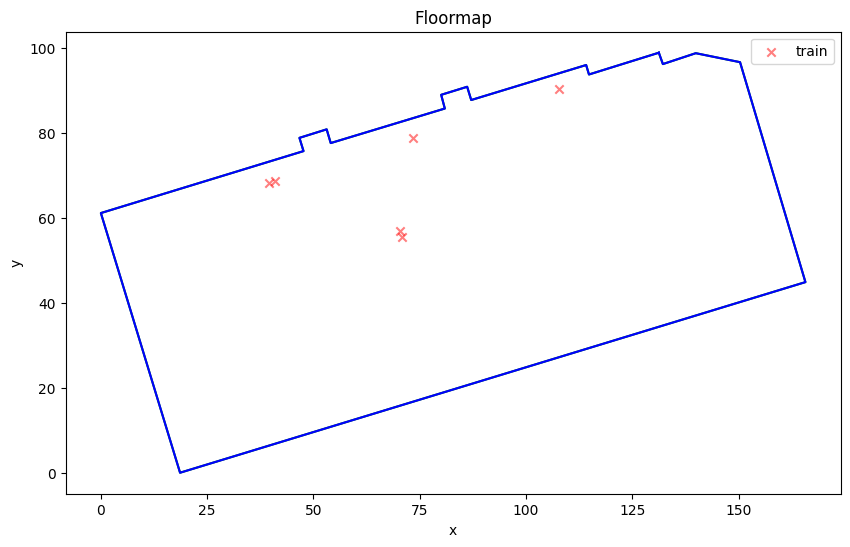

In [206]:
site_id, floor_id = abnormal_cases[0]

floor_info, floor_map = read_floor_data(os.path.join(metadata_dir, site_id, floor_id))

transform_func = lambda coords: coords

(
  floor_polygons,
  store_polygons,
  x_min,
  y_min,
  x_max,
  y_max,
  width_meter,
  height_meter,
) = extract_floor_map_geometries(floor_map, floor_info, transform=transform_func)
fingerprint_locations = read_fingerprint_locations(site_id, floor_id, data_dir)
print("Tracks:", list_tracks(site_id, floor_id, data_dir))

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="green")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="blue")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Floormap")

ax.scatter(fingerprint_locations[:, 0], fingerprint_locations[:, 1], marker="x", color="red", label="train", alpha=.5)

ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

#### Case 2: `5cd56c27e2acfd2d33b6d4c3/B1`

* In this case, all tracks were collected inside a parking lot (which was labeled as `\u505c\u8f66\u573a` in the geojson file). This is a situation in which there is no hallways. Because all waypoints were assumed to be inside hallways, we can safely remove this floor from our study.

Tracks: ['5d09ee781a9498000952a079', '5d09ee6124caf50008a4eef7', '5d09ee761a9498000952a077', '5d09ee641a9498000952a073', '5d09ee5c1a9498000952a06d', '5d09ee631a9498000952a071']


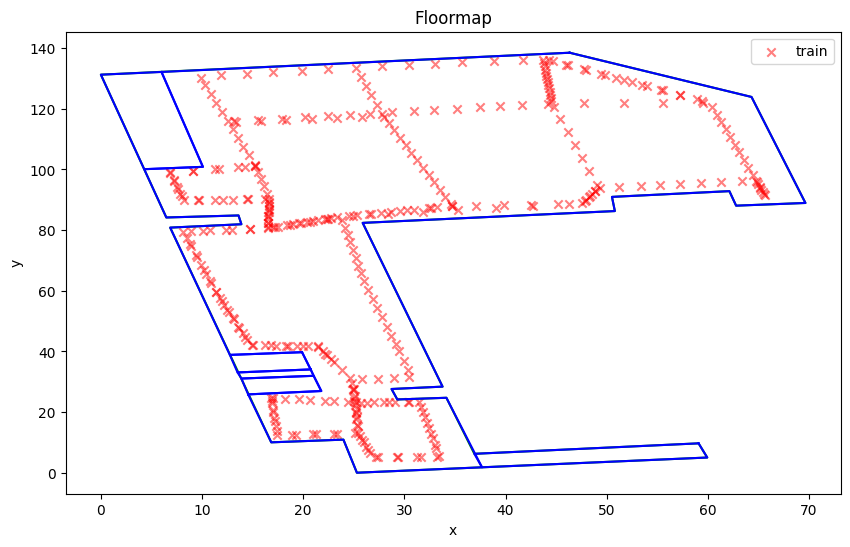

In [219]:
site_id, floor_id = abnormal_cases[1]

floor_info, floor_map = read_floor_data(os.path.join(metadata_dir, site_id, floor_id))

transform_func = lambda coords: coords

(
  floor_polygons,
  store_polygons,
  x_min,
  y_min,
  x_max,
  y_max,
  width_meter,
  height_meter,
) = extract_floor_map_geometries(floor_map, floor_info, transform=transform_func)
fingerprint_locations = read_fingerprint_locations(site_id, floor_id, data_dir)
print("Tracks:", list_tracks(site_id, floor_id, data_dir))

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="green")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="blue")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Floormap")

ax.scatter(fingerprint_locations[:, 0], fingerprint_locations[:, 1], marker="x", color="red", label="train", alpha=.5)

ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

#### Case 3: `5cd56b63e2acfd2d33b591c2/F6`

* In this case, waypoints were not inside the floor map. We can safely eliminate this floor from our study.

In [209]:
print(abnormal_cases[2])

('5cd56b63e2acfd2d33b591c2', 'F6')


Tracks: ['5d0b24c22f8a26000805bde7', '5d0b24c1ea52920008961dfc', '5d0b24beea52920008961dfa', '5d0b24bcea52920008961df8', '5d0b24bd2f8a26000805bde4']


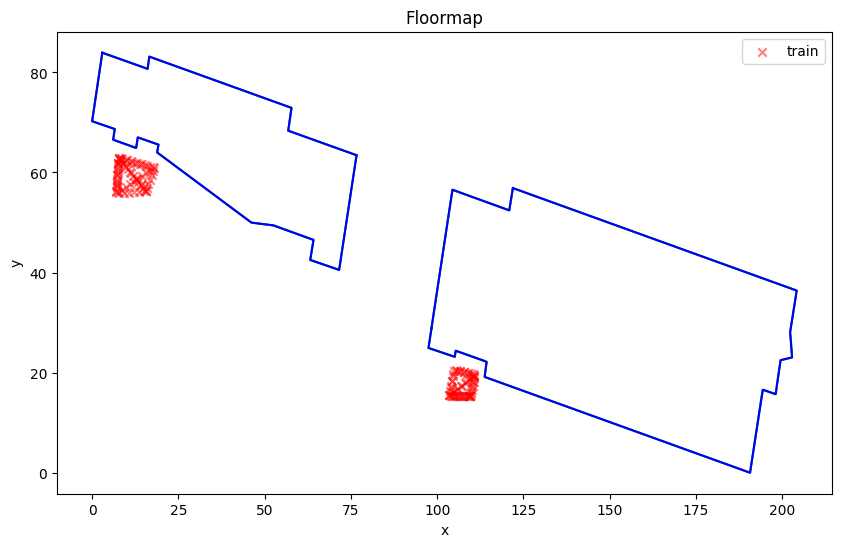

In [208]:
site_id, floor_id = abnormal_cases[2]

floor_info, floor_map = read_floor_data(os.path.join(metadata_dir, site_id, floor_id))

transform_func = lambda coords: coords

(
  floor_polygons,
  store_polygons,
  x_min,
  y_min,
  x_max,
  y_max,
  width_meter,
  height_meter,
) = extract_floor_map_geometries(floor_map, floor_info, transform=transform_func)
fingerprint_locations = read_fingerprint_locations(site_id, floor_id, data_dir)
print("Tracks:", list_tracks(site_id, floor_id, data_dir))

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="green")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="blue")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Floormap")

ax.scatter(fingerprint_locations[:, 0], fingerprint_locations[:, 1], marker="x", color="red", label="train", alpha=.5)

ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

#### Case 4: `5cd56b9be2acfd2d33b5fa9d/F5`

* In this case, all tracks were collected inside a KTV, which is a special case where there are no hallways on the floor.

In [215]:
print(abnormal_cases[3])

('5cd56b9be2acfd2d33b5fa9d', 'F5')


Tracks: ['5d0a1a6b096be600087ee4c3', '5d0a1a7424caf50008a4f1b7', '5d0a1a6a096be600087ee4c1']


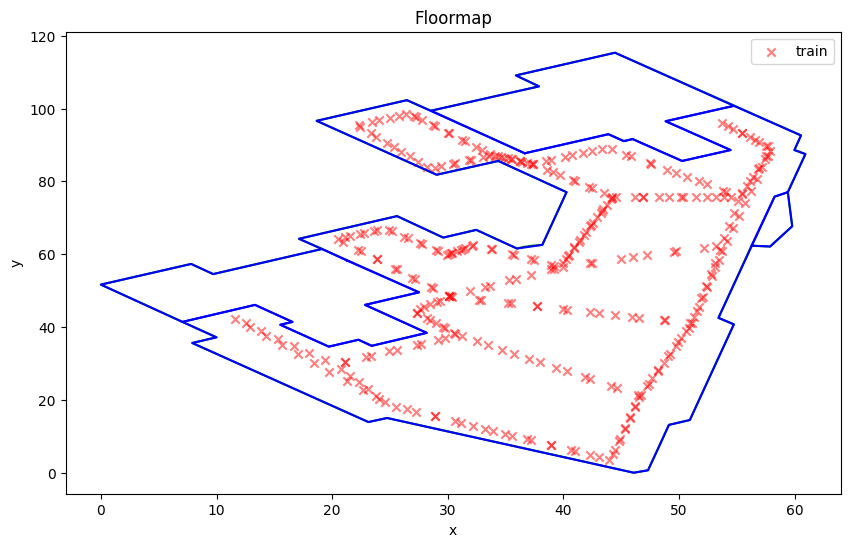

In [217]:
site_id, floor_id = abnormal_cases[3]

floor_info, floor_map = read_floor_data(os.path.join(metadata_dir, site_id, floor_id))

transform_func = lambda coords: coords

(
  floor_polygons,
  store_polygons,
  x_min,
  y_min,
  x_max,
  y_max,
  width_meter,
  height_meter,
) = extract_floor_map_geometries(floor_map, floor_info, transform=transform_func)
fingerprint_locations = read_fingerprint_locations(site_id, floor_id, data_dir)
print("Tracks:", list_tracks(site_id, floor_id, data_dir))

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="green")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="blue")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Floormap")

ax.scatter(fingerprint_locations[:, 0], fingerprint_locations[:, 1], marker="x", color="red", label="train", alpha=.5)

ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

## Semi-supervision Experiment Setup

In [30]:
train_test_assignment_df = pd.read_csv("../../data/output/20230903_train_test_assignment.csv")

In [31]:
train_test_assignment_df["site_id"] = train_test_assignment_df["site_id"].astype("category")
train_test_assignment_df["floor_id"] = train_test_assignment_df["floor_id"].astype("category")

In [36]:
min_n_tracks = 30 * 0.8

In [37]:
supervision_percents = (0.0, 0.1, 0.2, 0.3, 0.4, 0.5)
semi_supervision_setup = []

for (site_id, floor_id), group_data in tqdm(train_test_assignment_df.groupby(["site_id", "floor_id"])):

  train_track_assignment = group_data[(group_data["dataset"] == "train")]
  floor_map_coverage_estimator = create_floor_map_coverage_estimator(site_id, floor_id, metadata_dir)
  track_id_list = train_track_assignment["track_id"].values.tolist()

  if len(track_id_list) <= min_n_tracks:
    print(f"[ERROR] Less than {min_n_tracks}: site_id={site_id}, floor_id={floor_id}")
    continue

  floor_track_id, floor_track_values, floor_track_weights = get_floor_track_values_and_weights(
    site_id, floor_id, data_dir, track_id_list, floor_map_coverage_estimator)
  
  for supervision_pct in supervision_percents:
    labeled, unlabeled = weight_descending_train_test_split(
      floor_track_id, floor_track_values, floor_track_weights,
      test_size=(1.0 - supervision_pct))
    
    for track_id in labeled:
      semi_supervision_setup.append((site_id, floor_id, track_id, "labeled", supervision_pct))
      
    for track_id in unlabeled:
      semi_supervision_setup.append((site_id, floor_id, track_id, "unlabeled", supervision_pct))
    
  del floor_map_coverage_estimator
  del floor_track_id
  del floor_track_weights
  del floor_track_values
  gc.collect()
  

  0%|          | 0/255 [00:00<?, ?it/s]

  5%|▌         | 13/255 [00:35<04:42,  1.17s/it]

[ERROR] Less than 24.0: site_id=5c3c44b80379370013e0fd2b, floor_id=F3
[ERROR] Less than 24.0: site_id=5c3c44b80379370013e0fd2b, floor_id=F4
[ERROR] Less than 24.0: site_id=5cd56b5ae2acfd2d33b58549, floor_id=1F
[ERROR] Less than 24.0: site_id=5cd56b5ae2acfd2d33b58549, floor_id=4F
[ERROR] Less than 24.0: site_id=5cd56b5ae2acfd2d33b58549, floor_id=5F
[ERROR] Less than 24.0: site_id=5cd56b5ae2acfd2d33b5854a, floor_id=F1


 11%|█▏        | 29/255 [01:16<03:57,  1.05s/it]

[ERROR] Less than 24.0: site_id=5cd56b76e2acfd2d33b5b0be, floor_id=F1
[ERROR] Less than 24.0: site_id=5cd56b79e2acfd2d33b5b77c, floor_id=L1
[ERROR] Less than 24.0: site_id=5cd56b83e2acfd2d33b5cab0, floor_id=B2
[ERROR] Less than 24.0: site_id=5cd56b86e2acfd2d33b5cf97, floor_id=F1
[ERROR] Less than 24.0: site_id=5cd56b86e2acfd2d33b5cf97, floor_id=F2
[ERROR] Less than 24.0: site_id=5cd56b86e2acfd2d33b5cf97, floor_id=F3
[ERROR] Less than 24.0: site_id=5cd56b90e2acfd2d33b5e33f, floor_id=B1
[ERROR] Less than 24.0: site_id=5cd56b90e2acfd2d33b5e33f, floor_id=B2
[ERROR] Less than 24.0: site_id=5cd56b90e2acfd2d33b5e33f, floor_id=F1
[ERROR] Less than 24.0: site_id=5cd56b90e2acfd2d33b5e33f, floor_id=F2
[ERROR] Less than 24.0: site_id=5cd56b90e2acfd2d33b5e33f, floor_id=F3
[ERROR] Less than 24.0: site_id=5cd56b9be2acfd2d33b5fa12, floor_id=F1


 13%|█▎        | 33/255 [01:18<03:14,  1.14it/s]

[ERROR] Less than 24.0: site_id=5cd56bb2e2acfd2d33b62663, floor_id=F1
[ERROR] Less than 24.0: site_id=5cd56bb5e2acfd2d33b62b23, floor_id=F1
[ERROR] Less than 24.0: site_id=5cd56bc2e2acfd2d33b640cc, floor_id=3F
[ERROR] Less than 24.0: site_id=5cd56bd6e2acfd2d33b65dca, floor_id=LG1


 16%|█▋        | 42/255 [01:43<08:10,  2.30s/it]

[ERROR] Less than 24.0: site_id=5cd56bdbe2acfd2d33b663c0, floor_id=L6
[ERROR] Less than 24.0: site_id=5cd56bdbe2acfd2d33b663c0, floor_id=L7
[ERROR] Less than 24.0: site_id=5cd56bdbe2acfd2d33b663c0, floor_id=L8


 20%|██        | 51/255 [02:17<13:34,  3.99s/it]

[ERROR] Less than 24.0: site_id=5cd56bfce2acfd2d33b6906e, floor_id=F3


 22%|██▏       | 56/255 [02:23<06:22,  1.92s/it]

[ERROR] Less than 24.0: site_id=5cd56c0ce2acfd2d33b6acc5, floor_id=F1
[ERROR] Less than 24.0: site_id=5cd56c0ce2acfd2d33b6acc5, floor_id=F3
[ERROR] Less than 24.0: site_id=5cd56c0ce2acfd2d33b6acc5, floor_id=F4
[ERROR] Less than 24.0: site_id=5cd56c0ce2acfd2d33b6acc5, floor_id=F5
[ERROR] Less than 24.0: site_id=5cd56c0ee2acfd2d33b6b000, floor_id=B2


 23%|██▎       | 59/255 [02:23<03:50,  1.17s/it]

[ERROR] Less than 24.0: site_id=5cd56c0ee2acfd2d33b6b000, floor_id=L2
[ERROR] Less than 24.0: site_id=5cd56c0ee2acfd2d33b6b000, floor_id=L4


 24%|██▍       | 62/255 [02:30<05:39,  1.76s/it]

[ERROR] Less than 24.0: site_id=5cd56c16e2acfd2d33b6bd44, floor_id=L2


 25%|██▌       | 64/255 [02:34<05:31,  1.73s/it]

[ERROR] Less than 24.0: site_id=5cd56c16e2acfd2d33b6bd44, floor_id=L5


 27%|██▋       | 68/255 [02:39<04:24,  1.41s/it]

[ERROR] Less than 24.0: site_id=5cd56c18e2acfd2d33b6c321, floor_id=B2
[ERROR] Less than 24.0: site_id=5cd56c18e2acfd2d33b6c321, floor_id=L1


 28%|██▊       | 72/255 [02:42<03:00,  1.01it/s]

[ERROR] Less than 24.0: site_id=5cd56c1be2acfd2d33b6c766, floor_id=2F
[ERROR] Less than 24.0: site_id=5cd56c1ce2acfd2d33b6c8bf, floor_id=F3
[ERROR] Less than 24.0: site_id=5cd56c1ce2acfd2d33b6ca93, floor_id=F2


 31%|███       | 79/255 [03:02<04:45,  1.62s/it]

[ERROR] Less than 24.0: site_id=5cd56c1ee2acfd2d33b6ceab, floor_id=L3
[ERROR] Less than 24.0: site_id=5cd56c1ee2acfd2d33b6ceab, floor_id=L4
[ERROR] Less than 24.0: site_id=5cd56c1ee2acfd2d33b6ceab, floor_id=L5
[ERROR] Less than 24.0: site_id=5cd56c29e2acfd2d33b6d915, floor_id=B1
[ERROR] Less than 24.0: site_id=5cd56c29e2acfd2d33b6d915, floor_id=B2
[ERROR] Less than 24.0: site_id=5cd56c29e2acfd2d33b6d915, floor_id=F4


 33%|███▎      | 85/255 [03:16<06:37,  2.34s/it]

[ERROR] Less than 24.0: site_id=5cd969ad39e2fc0b4afe67ed, floor_id=F1


 35%|███▍      | 88/255 [03:20<05:32,  1.99s/it]

[ERROR] Less than 24.0: site_id=5cd969b539e2fc0b4afe6bf5, floor_id=F2


 35%|███▌      | 90/255 [03:22<04:30,  1.64s/it]

[ERROR] Less than 24.0: site_id=5cd969b539e2fc0b4afe6bf5, floor_id=F4
[ERROR] Less than 24.0: site_id=5cd969b539e2fc0b4afe6bf5, floor_id=F5
[ERROR] Less than 24.0: site_id=5cd969b539e2fc0b4afe6bf5, floor_id=F6


 39%|███▉      | 99/255 [03:50<07:01,  2.70s/it]

[ERROR] Less than 24.0: site_id=5cd969bb39e2fc0b4afe7079, floor_id=L2
[ERROR] Less than 24.0: site_id=5cd969bb39e2fc0b4afe7079, floor_id=L3


 40%|████      | 103/255 [03:53<03:41,  1.46s/it]

[ERROR] Less than 24.0: site_id=5cd969bd39e2fc0b4afe727d, floor_id=F1
[ERROR] Less than 24.0: site_id=5cd969bd39e2fc0b4afe727d, floor_id=F2
[ERROR] Less than 24.0: site_id=5cd969bd39e2fc0b4afe727d, floor_id=F3
[ERROR] Less than 24.0: site_id=5cd969c339e2fc0b4afe7778, floor_id=F1


 43%|████▎     | 109/255 [03:57<02:02,  1.19it/s]

[ERROR] Less than 24.0: site_id=5cd969c339e2fc0b4afe7778, floor_id=F4
[ERROR] Less than 24.0: site_id=5cd969c739e2fc0b4afe7d60, floor_id=F2
[ERROR] Less than 24.0: site_id=5cd969c839e2fc0b4afe7ff1, floor_id=F1
[ERROR] Less than 24.0: site_id=5cd969c839e2fc0b4afe7ff1, floor_id=F4
[ERROR] Less than 24.0: site_id=5cd969c839e2fc0b4afe7ff1, floor_id=F5
[ERROR] Less than 24.0: site_id=5cd969d639e2fc0b4afe9583, floor_id=F1


 44%|████▍     | 112/255 [03:59<01:58,  1.21it/s]

[ERROR] Less than 24.0: site_id=5cd969db39e2fc0b4afe9bc2, floor_id=F1
[ERROR] Less than 24.0: site_id=5cd969ea39e2fc0b4afeaef3, floor_id=F2


 45%|████▌     | 116/255 [04:05<02:38,  1.14s/it]

[ERROR] Less than 24.0: site_id=5cdac61ee403deddaf467f6b, floor_id=1F
[ERROR] Less than 24.0: site_id=5cdac61ee403deddaf467f6b, floor_id=2F


 47%|████▋     | 119/255 [04:10<03:04,  1.36s/it]

[ERROR] Less than 24.0: site_id=5cdac61fe403deddaf467f91, floor_id=F1


 47%|████▋     | 121/255 [04:18<04:24,  1.97s/it]

[ERROR] Less than 24.0: site_id=5cdac620e403deddaf467fc0, floor_id=B1


 52%|█████▏    | 132/255 [04:23<01:26,  1.43it/s]

[ERROR] Less than 24.0: site_id=5cdac620e403deddaf467fdb, floor_id=F2
[ERROR] Less than 24.0: site_id=5cdac620e403deddaf467fdb, floor_id=F3
[ERROR] Less than 24.0: site_id=5cdac620e403deddaf467fdb, floor_id=F4
[ERROR] Less than 24.0: site_id=5cdac620e403deddaf467fdb, floor_id=F5
[ERROR] Less than 24.0: site_id=5cdac620e403deddaf467fdb, floor_id=F6
[ERROR] Less than 24.0: site_id=5cdac620e403deddaf467fdb, floor_id=F7
[ERROR] Less than 24.0: site_id=5cdac625e403deddaf4680c9, floor_id=F1
[ERROR] Less than 24.0: site_id=5cdac625e403deddaf4680c9, floor_id=F2
[ERROR] Less than 24.0: site_id=5cdbc652853bc856e89a8694, floor_id=F1
[ERROR] Less than 24.0: site_id=5cdbc652853bc856e89a8694, floor_id=F2
[ERROR] Less than 24.0: site_id=5cdbc652853bc856e89a8694, floor_id=F3


 55%|█████▌    | 141/255 [05:04<06:20,  3.34s/it]

[ERROR] Less than 24.0: site_id=5d27096c03f801723c31e5e0, floor_id=F3
[ERROR] Less than 24.0: site_id=5d27096c03f801723c31e5e0, floor_id=F4


 56%|█████▋    | 144/255 [05:05<03:46,  2.04s/it]

[ERROR] Less than 24.0: site_id=5d27096c03f801723c31e5e0, floor_id=F6
[ERROR] Less than 24.0: site_id=5d27097f03f801723c320d97, floor_id=B1


 58%|█████▊    | 149/255 [05:14<03:25,  1.94s/it]

[ERROR] Less than 24.0: site_id=5d27097f03f801723c320d97, floor_id=F5


 60%|█████▉    | 152/255 [05:19<03:20,  1.95s/it]

[ERROR] Less than 24.0: site_id=5d27099303f801723c32364d, floor_id=3F


 61%|██████    | 155/255 [05:24<02:57,  1.77s/it]

[ERROR] Less than 24.0: site_id=5d27099303f801723c32364d, floor_id=6F
[ERROR] Less than 24.0: site_id=5d27099303f801723c32364d, floor_id=BF


 65%|██████▌   | 167/255 [05:51<02:44,  1.87s/it]

[ERROR] Less than 24.0: site_id=5d2709b303f801723c327472, floor_id=B1
[ERROR] Less than 24.0: site_id=5d2709bb03f801723c32852c, floor_id=B1


 66%|██████▋   | 169/255 [06:04<05:21,  3.73s/it]

[ERROR] Less than 24.0: site_id=5d2709bb03f801723c32852c, floor_id=F3
[ERROR] Less than 24.0: site_id=5d2709bb03f801723c32852c, floor_id=F4


 69%|██████▉   | 177/255 [06:20<03:08,  2.42s/it]

[ERROR] Less than 24.0: site_id=5d2709c303f801723c3299ee, floor_id=7F
[ERROR] Less than 24.0: site_id=5d2709c303f801723c3299ee, floor_id=B1


 71%|███████   | 181/255 [06:25<02:10,  1.77s/it]

[ERROR] Less than 24.0: site_id=5d2709d403f801723c32bd39, floor_id=3F


 74%|███████▎  | 188/255 [06:39<01:48,  1.62s/it]

[ERROR] Less than 24.0: site_id=5d2709dd03f801723c32cfb6, floor_id=L3
[ERROR] Less than 24.0: site_id=5d2709e003f801723c32d896, floor_id=B1
[ERROR] Less than 24.0: site_id=5d2709e003f801723c32d896, floor_id=F1
[ERROR] Less than 24.0: site_id=5d2709e003f801723c32d896, floor_id=F2


 75%|███████▍  | 191/255 [06:42<01:25,  1.34s/it]

[ERROR] Less than 24.0: site_id=5d2709e003f801723c32d896, floor_id=F4
[ERROR] Less than 24.0: site_id=5d2709e003f801723c32d896, floor_id=F5


 76%|███████▋  | 195/255 [06:45<01:05,  1.10s/it]

[ERROR] Less than 24.0: site_id=5da138274db8ce0c98bbd3d2, floor_id=F3
[ERROR] Less than 24.0: site_id=5da1382d4db8ce0c98bbe92e, floor_id=B1


 79%|███████▉  | 202/255 [06:51<00:39,  1.34it/s]

[ERROR] Less than 24.0: site_id=5da1382d4db8ce0c98bbe92e, floor_id=F2
[ERROR] Less than 24.0: site_id=5da1382d4db8ce0c98bbe92e, floor_id=F3
[ERROR] Less than 24.0: site_id=5da1382d4db8ce0c98bbe92e, floor_id=F4
[ERROR] Less than 24.0: site_id=5da1382d4db8ce0c98bbe92e, floor_id=F5


 82%|████████▏ | 209/255 [07:04<00:51,  1.11s/it]

[ERROR] Less than 24.0: site_id=5da138364db8ce0c98bc00f1, floor_id=F1
[ERROR] Less than 24.0: site_id=5da1383b4db8ce0c98bc11ab, floor_id=F1


 83%|████████▎ | 211/255 [07:13<01:46,  2.42s/it]

[ERROR] Less than 24.0: site_id=5da138754db8ce0c98bca82f, floor_id=F1


 84%|████████▎ | 213/255 [07:14<01:14,  1.77s/it]

[ERROR] Less than 24.0: site_id=5da138754db8ce0c98bca82f, floor_id=F3
[ERROR] Less than 24.0: site_id=5da138754db8ce0c98bca82f, floor_id=F4


 86%|████████▌ | 219/255 [07:25<01:11,  1.98s/it]

[ERROR] Less than 24.0: site_id=5da138764db8ce0c98bcaa46, floor_id=F4


 87%|████████▋ | 221/255 [07:26<00:49,  1.45s/it]

[ERROR] Less than 24.0: site_id=5da1389e4db8ce0c98bd0547, floor_id=B2
[ERROR] Less than 24.0: site_id=5da1389e4db8ce0c98bd0547, floor_id=F1
[ERROR] Less than 24.0: site_id=5da1389e4db8ce0c98bd0547, floor_id=F2


 93%|█████████▎| 238/255 [08:19<00:59,  3.47s/it]

[ERROR] Less than 24.0: site_id=5da958dd46f8266d0737457b, floor_id=F6


100%|██████████| 255/255 [09:10<00:00,  2.16s/it]

[ERROR] Less than 24.0: site_id=5dc8cea7659e181adb076a3f, floor_id=F7


In [38]:
semi_supervision_setup_df = pd.DataFrame(semi_supervision_setup, columns=["site_id", "floor_id", "track_id", "dataset", "supervision_pct"])

In [39]:
semi_supervision_setup_df.to_csv("../../data/output/20230903_semi_supervision_setup.csv")

## Track's Summary Statistics

* This section aims at summarizing statistics of tracks.

In [17]:
def get_track_duration(waypoint_df: pd.DataFrame) -> float:
  """
  Compute the duration of track, in seconds.
  Args:
    waypoint_df: a pd.DataFrame of waypoints
  Returns:
    a float represents the duration of track, in seconds
  """
  sys_ts = waypoint_df["sys_ts"].values
  return (sys_ts[-1] - sys_ts[0]) / 1000

In [18]:
def get_track_length(waypoint_df: pd.DataFrame) -> float:
  """
  Compute the length of track, in meters.
  Args:
    waypoint_df: a pd.DataFrame of waypoints
  Returns:
    a float represents the length of track, in meters
  """
  xy = waypoint_df[["x", "y"]].values
  return np.linalg.norm(xy[1:] - xy[:-1], axis=1).sum()

In [20]:
def get_track_stats(waypoint_files: list[str]) -> pd.DataFrame:
  track_stats = []

  for waypoint_file_path in waypoint_files:
    track_name = os.path.basename(waypoint_file_path)[:-len("_waypoint.csv")]
    waypoint_df = pd.read_csv(waypoint_file_path)
    track_duration = get_track_duration(waypoint_df)
    track_length = get_track_length(waypoint_df)
    track_stats.append({
        "track_id": track_name,
        "duration": track_duration,
        "length": track_length,
    })

  return pd.DataFrame(track_stats)

In [22]:
train_test_assignment = []

site_file_path_list = glob(f"../../data/wifi_fingerprint_manual/train/*")

for site_file_path in tqdm(site_file_path_list):
  site_id = os.path.basename(site_file_path)

  track_file_path_list = list(glob(site_file_path + "/*"))
  for track_file_path in track_file_path_list:
    floor_id = os.path.basename(track_file_path)
    
    waypoint_files = list(glob(track_file_path + "/*_waypoint.csv"))
    track_stats_df = get_track_stats(waypoint_files)
    track_stats_df["site_id"] = site_id
    track_stats_df["floor_id"] = floor_id

    train_test_assignment.append(track_stats_df)

100%|██████████| 204/204 [00:56<00:00,  3.62it/s]


In [23]:
track_stats_df_all = pd.concat(train_test_assignment)

In [24]:
!mkdir -p ../../data/output

In [25]:
track_stats_df_all.to_csv("../../data/output/track_stats_all.csv", index=False)

## Train/Test Split

* We perform a train/test split procedure based on the amount of time spent on collecting tracks.

In [31]:
track_stats_df_all["site_id"] = track_stats_df_all["site_id"].astype("category")
track_stats_df_all["floor_id"] = track_stats_df_all["floor_id"].astype("category")

In [89]:
track_stats_df_all.head()

,track_id,duration,length,site_id,floor_id
0,5db1692e5741f4000680a631,48.377,40.351840,5da138b74db8ce0c98bd4774,F5
1,5db2cc995741f4000680a8a2,11.595,12.750240,5da138b74db8ce0c98bd4774,F5
2,5db15a3de62491000652bd2c,20.354,18.758892,5da138b74db8ce0c98bd4774,F5
3,5db1690e5741f4000680a61d,28.636,36.052819,5da138b74db8ce0c98bd4774,F5
4,5db2ad2f5741f4000680a855,26.079,23.055595,5da138b74db8ce0c98bd4774,F5


In [103]:
def train_test_split_track(group_data: pd.DataFrame, test_size: float=0.2) -> pd.DataFrame:
  group_data = group_data[group_data["duration"] > 0].copy()
  
  group_data.sort_values("duration", ascending=False, inplace=True)
  duration_pct = group_data["duration"].values / group_data["duration"].values.sum()
  duration_csum = np.cumsum(duration_pct)
  group_data["dataset"] = "train"
  group_data.loc[duration_csum > 1.0 - test_size, "dataset"] = "test"

  return group_data

In [132]:
test_size = 0.2
train_test_splited = []

for (site_id, floor_id), group_data in tqdm(track_stats_df_all.groupby(["site_id", "floor_id"])):
  train_test_splited.append(train_test_split_track(group_data, test_size=test_size))

100%|██████████| 981/981 [00:01<00:00, 588.68it/s]


In [133]:
train_test_assignment = pd.concat(train_test_splited)

In [134]:
train_test_assignment.head()

,track_id,duration,length,site_id,floor_id,dataset
78,5e1580ccf4c3420006d520e0,107.339,90.026316,5a0546857ecc773753327266,B1,train
22,5e1580c51506f2000638fc6a,89.977,66.943107,5a0546857ecc773753327266,B1,train
73,5e15731ca280850006f3d011,88.834,55.475635,5a0546857ecc773753327266,B1,train
46,5e15731fa280850006f3d013,79.605,48.154400,5a0546857ecc773753327266,B1,train
62,5e157321a280850006f3d015,78.439,54.540528,5a0546857ecc773753327266,B1,train


In [142]:
train_test_assignment.to_csv("../../data/output/train_test_assignment.csv", index=False, header=True)

## Verify Data Overlapping

In [139]:
def estimate_train_test_coverage(site_id: str, floor_id: str, track_assignment_df: pd.DataFrame):
  
  splited_group_data = track_assignment_df[(track_assignment_df["site_id"] == site_id) & (track_assignment_df["floor_id"] == floor_id)]
  train_fingerprint_locations = read_fingerprint_locations(
    site_id=site_id, floor_id=floor_id, data_dir=data_dir, 
    track_id_list=splited_group_data[splited_group_data["dataset"] == "train"]["track_id"].values.tolist())
  test_fingerprint_locations = read_fingerprint_locations(
    site_id=site_id, floor_id=floor_id, data_dir=data_dir, 
    track_id_list=splited_group_data[splited_group_data["dataset"] == "test"]["track_id"].values.tolist())
  
  floor_info, floor_map = read_floor_data(f"../../data/metadata/{site_id}/{floor_id}")

  (
    floor_polygons,
    store_polygons,
    x_min,
    y_min,
    x_max,
    y_max,
    width_meter,
    height_meter,
  ) = extract_floor_map_geometries(floor_map, floor_info, transform=lambda coords: coords)

  fm_coverage_estimator = FloorMapCoverageEstimator(floor_polygons, store_polygons, width_meter, height_meter)

  # The amount of floormap area covered by the train dataset
  train_covered_bins = fm_coverage_estimator.get_bin_coverage(train_fingerprint_locations, tol=fm_coverage_estimator.grid_resolution*2)
  floor_train_coverage_pct = train_covered_bins.shape[0] / fm_coverage_estimator.n_bins * 100

  # The amount of floormap area covered by the test dataset
  test_covered_bins = fm_coverage_estimator.get_bin_coverage(test_fingerprint_locations, tol=fm_coverage_estimator.grid_resolution*2)
  floor_test_coverage_pct = test_covered_bins.shape[0] / fm_coverage_estimator.n_bins * 100

  # The amount of test locations which contain at least 1 fingerprint in the train dataset  
  test_train_overlapping_pct = len(set(test_covered_bins).intersection(set(train_covered_bins))) / len(set(test_covered_bins)) * 100

  return {
    "floor_train_coverage": round(floor_train_coverage_pct, 2), 
    "floor_test_coverage": round(floor_test_coverage_pct, 2), 
    "test_train_overlapping": round(test_train_overlapping_pct, 2),
    "site_id": site_id,
    "floor_id": floor_id,
  }

In [140]:
site_id = "5da138b74db8ce0c98bd4774"
floor_id = "F5"

In [141]:
estimate_train_test_coverage(site_id, floor_id, train_test_assignment)

The number of BSSIDs with at least 0 samples: 1233


100%|██████████| 67/67 [00:03<00:00, 18.79it/s]


The number of fingerprints: 2332
The number of BSSIDs with at least 0 samples: 1113


100%|██████████| 66/66 [00:00<00:00, 67.99it/s]


The number of fingerprints: 610


{'floor_train_coverage': 77.4,
 'floor_test_coverage': 26.73,
 'test_train_overlapping': 79.88,
 'site_id': '5da138b74db8ce0c98bd4774',
 'floor_id': 'F5'}

In [147]:
data_coverage = []
failed_floors = []

for (site_id, floor_id), group_data in tqdm(train_test_assignment.groupby(["site_id", "floor_id"])):
  try:
    data_coverage.append(estimate_train_test_coverage(site_id, floor_id, train_test_assignment))
  except Exception as ignored:
    print(f"[ERROR] Failed to estimate data coverage for site={site_id}, floor={floor_id}")
    failed_floors.append((site_id, floor_id))

  0%|          | 0/981 [00:00<?, ?it/s]

The number of BSSIDs with at least 0 samples: 1258


100%|██████████| 60/60 [00:02<00:00, 23.54it/s]


The number of fingerprints: 1504
The number of BSSIDs with at least 0 samples: 1035


  0%|          | 1/981 [00:04<1:15:48,  4.64s/it]

The number of fingerprints: 391
The number of BSSIDs with at least 0 samples: 1764


100%|██████████| 73/73 [00:03<00:00, 20.41it/s]


The number of fingerprints: 1283
The number of BSSIDs with at least 0 samples: 1594


  0%|          | 2/981 [00:10<1:31:33,  5.61s/it]

The number of fingerprints: 334
The number of BSSIDs with at least 0 samples: 1815


100%|██████████| 47/47 [00:04<00:00, 11.15it/s]


The number of fingerprints: 1782
The number of BSSIDs with at least 0 samples: 1624


  0%|          | 3/981 [00:18<1:43:58,  6.38s/it]

The number of fingerprints: 474
The number of BSSIDs with at least 0 samples: 1434


100%|██████████| 33/33 [00:01<00:00, 20.38it/s]


The number of fingerprints: 925
The number of BSSIDs with at least 0 samples: 1292


  0%|          | 4/981 [00:21<1:22:27,  5.06s/it]

The number of fingerprints: 247
The number of BSSIDs with at least 0 samples: 1467


100%|██████████| 32/32 [00:03<00:00, 10.29it/s]


The number of fingerprints: 1763
The number of BSSIDs with at least 0 samples: 1290


  1%|          | 5/981 [00:26<1:24:03,  5.17s/it]

The number of fingerprints: 441
The number of BSSIDs with at least 0 samples: 1703


100%|██████████| 35/35 [00:02<00:00, 11.68it/s]


The number of fingerprints: 1855
The number of BSSIDs with at least 0 samples: 1463


  1%|          | 6/981 [00:31<1:23:47,  5.16s/it]

The number of fingerprints: 470
The number of BSSIDs with at least 0 samples: 1949


100%|██████████| 61/61 [00:02<00:00, 20.47it/s]


The number of fingerprints: 1407
The number of BSSIDs with at least 0 samples: 1533


100%|██████████| 47/47 [00:00<00:00, 56.43it/s]


The number of fingerprints: 363


  1%|          | 7/981 [00:37<1:25:39,  5.28s/it]

The number of BSSIDs with at least 0 samples: 2099


100%|██████████| 47/47 [00:03<00:00, 12.01it/s]


The number of fingerprints: 1988
The number of BSSIDs with at least 0 samples: 1911


  1%|          | 8/981 [00:44<1:33:32,  5.77s/it]

The number of fingerprints: 474
The number of BSSIDs with at least 0 samples: 1149


100%|██████████| 15/15 [00:01<00:00,  8.71it/s]


The number of fingerprints: 1320
The number of BSSIDs with at least 0 samples: 1149


  1%|          | 9/981 [00:47<1:19:18,  4.90s/it]

The number of fingerprints: 324
The number of BSSIDs with at least 0 samples: 1069


100%|██████████| 19/19 [00:01<00:00, 16.15it/s]


The number of fingerprints: 810
The number of BSSIDs with at least 0 samples: 850


  1%|          | 10/981 [00:49<1:05:41,  4.06s/it]

The number of fingerprints: 216
The number of BSSIDs with at least 0 samples: 706


100%|██████████| 12/12 [00:00<00:00, 29.34it/s]


The number of fingerprints: 296
The number of BSSIDs with at least 0 samples: 600


100%|██████████| 9/9 [00:00<00:00, 74.66it/s]


The number of fingerprints: 80


  1%|          | 11/981 [00:50<49:58,  3.09s/it]  

The number of BSSIDs with at least 0 samples: 238


100%|██████████| 4/4 [00:00<00:00,  8.07it/s]


The number of fingerprints: 654
The number of BSSIDs with at least 0 samples: 231


100%|██████████| 5/5 [00:00<00:00, 32.50it/s]


The number of fingerprints: 178


  1%|          | 12/981 [00:50<38:50,  2.40s/it]

The number of BSSIDs with at least 0 samples: 189


100%|██████████| 4/4 [00:00<00:00, 13.17it/s]


The number of fingerprints: 375
The number of BSSIDs with at least 0 samples: 146


  1%|▏         | 13/981 [00:51<29:39,  1.84s/it]

The number of fingerprints: 106
The number of BSSIDs with at least 0 samples: 185


100%|██████████| 3/3 [00:00<00:00, 14.79it/s]


The number of fingerprints: 222
The number of BSSIDs with at least 0 samples: 160


  1%|▏         | 14/981 [00:51<22:40,  1.41s/it]

The number of fingerprints: 91
The number of BSSIDs with at least 0 samples: 178


100%|██████████| 3/3 [00:00<00:00,  8.83it/s]


The number of fingerprints: 341
The number of BSSIDs with at least 0 samples: 123


  2%|▏         | 15/981 [00:52<18:45,  1.16s/it]

The number of fingerprints: 143
The number of BSSIDs with at least 0 samples: 171


100%|██████████| 4/4 [00:00<00:00, 16.91it/s]


The number of fingerprints: 287
The number of BSSIDs with at least 0 samples: 143


  2%|▏         | 16/981 [00:53<15:28,  1.04it/s]

The number of fingerprints: 132
The number of BSSIDs with at least 0 samples: 199


100%|██████████| 6/6 [00:00<00:00,  9.69it/s]


The number of fingerprints: 844
The number of BSSIDs with at least 0 samples: 128


  2%|▏         | 17/981 [00:54<15:44,  1.02it/s]

The number of fingerprints: 230
The number of BSSIDs with at least 0 samples: 355


100%|██████████| 6/6 [00:00<00:00,  6.69it/s]


The number of fingerprints: 1227
The number of BSSIDs with at least 0 samples: 161


  2%|▏         | 18/981 [00:55<17:50,  1.11s/it]

The number of fingerprints: 336
The number of BSSIDs with at least 0 samples: 138


100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


The number of fingerprints: 112
The number of BSSIDs with at least 0 samples: 152


  2%|▏         | 19/981 [00:55<14:01,  1.14it/s]

The number of fingerprints: 126
The number of BSSIDs with at least 0 samples: 48


100%|██████████| 2/2 [00:00<00:00, 23.37it/s]


The number of fingerprints: 82
The number of BSSIDs with at least 0 samples: 46


100%|██████████| 2/2 [00:00<00:00, 45.80it/s]


The number of fingerprints: 43


  2%|▏         | 20/981 [00:55<10:41,  1.50it/s]

The number of BSSIDs with at least 0 samples: 146


100%|██████████| 3/3 [00:00<00:00,  6.00it/s]


The number of fingerprints: 513
The number of BSSIDs with at least 0 samples: 92


  2%|▏         | 21/981 [00:56<11:34,  1.38it/s]

The number of fingerprints: 266
The number of BSSIDs with at least 0 samples: 375


100%|██████████| 7/7 [00:01<00:00,  6.64it/s]


The number of fingerprints: 1447
The number of BSSIDs with at least 0 samples: 226


  2%|▏         | 22/981 [00:58<16:27,  1.03s/it]

The number of fingerprints: 487
The number of BSSIDs with at least 0 samples: 296


100%|██████████| 10/10 [00:00<00:00, 11.44it/s]


The number of fingerprints: 1126
The number of BSSIDs with at least 0 samples: 235


  2%|▏         | 23/981 [01:00<18:27,  1.16s/it]

The number of fingerprints: 388
The number of BSSIDs with at least 0 samples: 62


100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


The number of fingerprints: 138
The number of BSSIDs with at least 0 samples: 64


100%|██████████| 2/2 [00:00<00:00, 11.86it/s]


The number of fingerprints: 125


  2%|▏         | 24/981 [01:00<14:38,  1.09it/s]

The number of BSSIDs with at least 0 samples: 96


100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


The number of fingerprints: 119
The number of BSSIDs with at least 0 samples: 112


  3%|▎         | 25/981 [01:00<11:52,  1.34it/s]

The number of fingerprints: 141
The number of BSSIDs with at least 0 samples: 149


100%|██████████| 10/10 [00:00<00:00, 44.61it/s]


The number of fingerprints: 235
The number of BSSIDs with at least 0 samples: 130


100%|██████████| 7/7 [00:00<00:00, 51.88it/s]


The number of fingerprints: 69


  3%|▎         | 26/981 [01:01<10:54,  1.46it/s]

The number of BSSIDs with at least 0 samples: 136


100%|██████████| 10/10 [00:00<00:00, 40.29it/s]


The number of fingerprints: 252
The number of BSSIDs with at least 0 samples: 128


  3%|▎         | 27/981 [01:01<10:07,  1.57it/s]

The number of fingerprints: 72
The number of BSSIDs with at least 0 samples: 127


100%|██████████| 6/6 [00:00<00:00, 28.82it/s]


The number of fingerprints: 195
The number of BSSIDs with at least 0 samples: 105


100%|██████████| 5/5 [00:00<00:00, 60.05it/s]


The number of fingerprints: 52


  3%|▎         | 28/981 [01:02<09:25,  1.68it/s]

The number of BSSIDs with at least 0 samples: 603


100%|██████████| 23/23 [00:01<00:00, 18.20it/s]


The number of fingerprints: 1191
The number of BSSIDs with at least 0 samples: 453


  3%|▎         | 29/981 [01:04<18:15,  1.15s/it]

The number of fingerprints: 740
The number of BSSIDs with at least 0 samples: 463


100%|██████████| 13/13 [00:00<00:00, 16.53it/s]


The number of fingerprints: 956
The number of BSSIDs with at least 0 samples: 345


  3%|▎         | 30/981 [01:06<19:38,  1.24s/it]

The number of fingerprints: 396
The number of BSSIDs with at least 0 samples: 226


100%|██████████| 4/4 [00:00<00:00, 58.79it/s]


The number of fingerprints: 49
The number of BSSIDs with at least 0 samples: 157


100%|██████████| 5/5 [00:00<00:00, 163.99it/s]


The number of fingerprints: 15


  3%|▎         | 31/981 [01:06<14:42,  1.08it/s]

The number of BSSIDs with at least 0 samples: 520


100%|██████████| 18/18 [00:00<00:00, 98.04it/s]

The number of fingerprints: 173


The number of BSSIDs with at least 0 samples: 442


100%|██████████| 18/18 [00:00<00:00, 182.09it/s]


The number of fingerprints: 64


  3%|▎         | 32/981 [01:06<12:49,  1.23it/s]

The number of BSSIDs with at least 0 samples: 659


100%|██████████| 13/13 [00:00<00:00, 55.06it/s]


The number of fingerprints: 219
The number of BSSIDs with at least 0 samples: 460


100%|██████████| 19/19 [00:00<00:00, 183.04it/s]


The number of fingerprints: 78


  3%|▎         | 33/981 [01:07<11:37,  1.36it/s]

The number of BSSIDs with at least 0 samples: 408


100%|██████████| 9/9 [00:00<00:00, 19.09it/s]


The number of fingerprints: 484
The number of BSSIDs with at least 0 samples: 289


  3%|▎         | 34/981 [01:08<12:41,  1.24it/s]

The number of fingerprints: 137
The number of BSSIDs with at least 0 samples: 1184


100%|██████████| 16/16 [00:01<00:00, 14.17it/s]


The number of fingerprints: 720
The number of BSSIDs with at least 0 samples: 823


  4%|▎         | 35/981 [01:10<17:52,  1.13s/it]

The number of fingerprints: 196
The number of BSSIDs with at least 0 samples: 761


100%|██████████| 9/9 [00:00<00:00, 15.51it/s]


The number of fingerprints: 430
The number of BSSIDs with at least 0 samples: 582


  4%|▎         | 36/981 [01:11<17:28,  1.11s/it]

The number of fingerprints: 131
The number of BSSIDs with at least 0 samples: 403


100%|██████████| 2/2 [00:00<00:00, 15.60it/s]


The number of fingerprints: 88
The number of BSSIDs with at least 0 samples: 311


  4%|▍         | 37/981 [01:11<13:36,  1.16it/s]

The number of fingerprints: 46
The number of BSSIDs with at least 0 samples: 341


100%|██████████| 4/4 [00:00<00:00, 35.55it/s]


The number of fingerprints: 67
The number of BSSIDs with at least 0 samples: 247


  4%|▍         | 38/981 [01:12<10:56,  1.44it/s]

The number of fingerprints: 30
The number of BSSIDs with at least 0 samples: 350


100%|██████████| 6/6 [00:00<00:00, 32.69it/s]

The number of fingerprints: 137


The number of BSSIDs with at least 0 samples: 285


  4%|▍         | 39/981 [01:12<09:47,  1.60it/s]

The number of fingerprints: 47
The number of BSSIDs with at least 0 samples: 358


100%|██████████| 4/4 [00:00<00:00, 20.58it/s]

The number of fingerprints: 143


The number of BSSIDs with at least 0 samples: 284


  4%|▍         | 40/981 [01:12<08:53,  1.76it/s]

The number of fingerprints: 56
The number of BSSIDs with at least 0 samples: 355


100%|██████████| 4/4 [00:00<00:00, 19.76it/s]


The number of fingerprints: 163
The number of BSSIDs with at least 0 samples: 262


  4%|▍         | 41/981 [01:13<08:12,  1.91it/s]

The number of fingerprints: 54
The number of BSSIDs with at least 0 samples: 319


100%|██████████| 3/3 [00:00<00:00, 16.81it/s]


The number of fingerprints: 134
The number of BSSIDs with at least 0 samples: 287


  4%|▍         | 42/981 [01:13<07:29,  2.09it/s]

The number of fingerprints: 54
The number of BSSIDs with at least 0 samples: 565


100%|██████████| 9/9 [00:00<00:00,  9.44it/s]


The number of fingerprints: 982
The number of BSSIDs with at least 0 samples: 343


  4%|▍         | 43/981 [01:15<12:13,  1.28it/s]

The number of fingerprints: 241
The number of BSSIDs with at least 0 samples: 436


100%|██████████| 2/2 [00:00<00:00,  3.52it/s]


The number of fingerprints: 682
The number of BSSIDs with at least 0 samples: 432


  4%|▍         | 44/981 [01:16<13:58,  1.12it/s]

The number of fingerprints: 273
The number of BSSIDs with at least 0 samples: 554


100%|██████████| 6/6 [00:00<00:00, 10.65it/s]


The number of fingerprints: 641
The number of BSSIDs with at least 0 samples: 354


  5%|▍         | 45/981 [01:17<14:22,  1.09it/s]

The number of fingerprints: 251
The number of BSSIDs with at least 0 samples: 327


100%|██████████| 3/3 [00:00<00:00,  7.91it/s]


The number of fingerprints: 440
The number of BSSIDs with at least 0 samples: 243


  5%|▍         | 46/981 [01:17<13:02,  1.20it/s]

The number of fingerprints: 135
The number of BSSIDs with at least 0 samples: 145


100%|██████████| 2/2 [00:00<00:00,  6.93it/s]


The number of fingerprints: 304
The number of BSSIDs with at least 0 samples: 126


  5%|▍         | 47/981 [01:18<11:40,  1.33it/s]

The number of fingerprints: 138
The number of BSSIDs with at least 0 samples: 145


100%|██████████| 3/3 [00:00<00:00, 25.74it/s]


The number of fingerprints: 103
The number of BSSIDs with at least 0 samples: 96


  5%|▍         | 48/981 [01:18<09:14,  1.68it/s]

The number of fingerprints: 31
[ERROR] Failed to estimate data coverage for site=5cd56b63e2acfd2d33b591c2, floor=F6
The number of BSSIDs with at least 0 samples: 225


100%|██████████| 5/5 [00:00<00:00, 12.83it/s]


The number of fingerprints: 492
The number of BSSIDs with at least 0 samples: 209


  5%|▍         | 49/981 [01:19<10:08,  1.53it/s]

The number of fingerprints: 173
The number of BSSIDs with at least 0 samples: 381


100%|██████████| 9/9 [00:00<00:00, 20.60it/s]


The number of fingerprints: 431
The number of BSSIDs with at least 0 samples: 258


  5%|▌         | 50/981 [01:20<11:39,  1.33it/s]

The number of fingerprints: 136
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 61


100%|██████████| 1/1 [00:00<00:00, 50.55it/s]


The number of fingerprints: 17
[ERROR] Failed to estimate data coverage for site=5cd56b64e2acfd2d33b592b3, floor=B1
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 36


  5%|▌         | 52/981 [01:20<06:52,  2.25it/s]

The number of fingerprints: 2
[ERROR] Failed to estimate data coverage for site=5cd56b64e2acfd2d33b592b3, floor=B2
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 6


100%|██████████| 1/1 [00:00<00:00, 339.32it/s]


The number of fingerprints: 1


  5%|▌         | 53/981 [01:20<05:35,  2.76it/s]

[ERROR] Failed to estimate data coverage for site=5cd56b64e2acfd2d33b592b3, floor=B3
The number of BSSIDs with at least 0 samples: 386


100%|██████████| 1/1 [00:00<00:00, 14.55it/s]

The number of fingerprints: 45


The number of BSSIDs with at least 0 samples: 295


  6%|▌         | 54/981 [01:20<04:53,  3.16it/s]

The number of fingerprints: 22
The number of BSSIDs with at least 0 samples: 226


100%|██████████| 1/1 [00:00<00:00, 21.94it/s]


The number of fingerprints: 22
The number of BSSIDs with at least 0 samples: 233


100%|██████████| 1/1 [00:00<00:00, 25.67it/s]


The number of fingerprints: 14


  6%|▌         | 55/981 [01:21<04:19,  3.57it/s]

The number of BSSIDs with at least 0 samples: 469


100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


The number of fingerprints: 53
The number of BSSIDs with at least 0 samples: 133


100%|██████████| 2/2 [00:00<00:00, 61.14it/s]

The number of fingerprints: 11



  6%|▌         | 56/981 [01:21<04:09,  3.71it/s]

The number of BSSIDs with at least 0 samples: 216


100%|██████████| 1/1 [00:00<00:00, 38.10it/s]


The number of fingerprints: 17
The number of BSSIDs with at least 0 samples: 200


100%|██████████| 1/1 [00:00<00:00, 38.63it/s]


The number of fingerprints: 16


  6%|▌         | 57/981 [01:21<03:33,  4.32it/s]

The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 225


100%|██████████| 1/1 [00:00<00:00, 20.65it/s]

The number of fingerprints: 20



  6%|▌         | 58/981 [01:21<02:58,  5.17it/s]

[ERROR] Failed to estimate data coverage for site=5cd56b64e2acfd2d33b592b3, floor=F5
The number of BSSIDs with at least 0 samples: 1028


100%|██████████| 10/10 [00:01<00:00,  7.63it/s]


The number of fingerprints: 871
The number of BSSIDs with at least 0 samples: 748


  6%|▌         | 59/981 [01:24<12:44,  1.21it/s]

The number of fingerprints: 277
The number of BSSIDs with at least 0 samples: 957


100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


The number of fingerprints: 633
The number of BSSIDs with at least 0 samples: 702


  6%|▌         | 60/981 [01:25<17:03,  1.11s/it]

The number of fingerprints: 219
The number of BSSIDs with at least 0 samples: 859


100%|██████████| 5/5 [00:00<00:00,  5.37it/s]


The number of fingerprints: 673
The number of BSSIDs with at least 0 samples: 668


  6%|▌         | 61/981 [01:27<20:01,  1.31s/it]

The number of fingerprints: 185
The number of BSSIDs with at least 0 samples: 789


100%|██████████| 2/2 [00:00<00:00,  2.88it/s]


The number of fingerprints: 478
The number of BSSIDs with at least 0 samples: 693


  6%|▋         | 62/981 [01:29<20:52,  1.36s/it]

The number of fingerprints: 251
The number of BSSIDs with at least 0 samples: 764


100%|██████████| 5/5 [00:00<00:00,  6.76it/s]


The number of fingerprints: 610
The number of BSSIDs with at least 0 samples: 651


  6%|▋         | 63/981 [01:30<21:57,  1.44s/it]

The number of fingerprints: 230
The number of BSSIDs with at least 0 samples: 125


100%|██████████| 1/1 [00:00<00:00, 29.06it/s]


The number of fingerprints: 22
The number of BSSIDs with at least 0 samples: 128


100%|██████████| 1/1 [00:00<00:00, 26.37it/s]


The number of fingerprints: 17


  7%|▋         | 64/981 [01:30<16:11,  1.06s/it]

The number of BSSIDs with at least 0 samples: 746


100%|██████████| 10/10 [00:01<00:00,  6.64it/s]


The number of fingerprints: 1587
The number of BSSIDs with at least 0 samples: 492


  7%|▋         | 65/981 [01:33<23:14,  1.52s/it]

The number of fingerprints: 508
The number of BSSIDs with at least 0 samples: 107


100%|██████████| 8/8 [00:00<00:00, 14.64it/s]


The number of fingerprints: 734
The number of BSSIDs with at least 0 samples: 89


  7%|▋         | 66/981 [01:34<20:52,  1.37s/it]

The number of fingerprints: 203
The number of BSSIDs with at least 0 samples: 108


100%|██████████| 9/9 [00:00<00:00, 15.33it/s]


The number of fingerprints: 822
The number of BSSIDs with at least 0 samples: 92


  7%|▋         | 67/981 [01:35<19:11,  1.26s/it]

The number of fingerprints: 245
The number of BSSIDs with at least 0 samples: 186


100%|██████████| 12/12 [00:00<00:00, 16.28it/s]


The number of fingerprints: 927
The number of BSSIDs with at least 0 samples: 136


  7%|▋         | 68/981 [01:36<19:13,  1.26s/it]

The number of fingerprints: 249
The number of BSSIDs with at least 0 samples: 135


100%|██████████| 9/9 [00:00<00:00, 14.44it/s]


The number of fingerprints: 767
The number of BSSIDs with at least 0 samples: 109


  7%|▋         | 69/981 [01:37<18:17,  1.20s/it]

The number of fingerprints: 216
The number of BSSIDs with at least 0 samples: 116


100%|██████████| 9/9 [00:00<00:00, 14.13it/s]


The number of fingerprints: 752
The number of BSSIDs with at least 0 samples: 95


  7%|▋         | 70/981 [01:38<17:38,  1.16s/it]

The number of fingerprints: 214
The number of BSSIDs with at least 0 samples: 141


100%|██████████| 3/3 [00:00<00:00, 13.77it/s]


The number of fingerprints: 248
The number of BSSIDs with at least 0 samples: 71


  7%|▋         | 71/981 [01:39<14:14,  1.06it/s]

The number of fingerprints: 68
The number of BSSIDs with at least 0 samples: 65


100%|██████████| 5/5 [00:00<00:00, 18.03it/s]


The number of fingerprints: 321
The number of BSSIDs with at least 0 samples: 57


  7%|▋         | 72/981 [01:39<12:16,  1.23it/s]

The number of fingerprints: 94
The number of BSSIDs with at least 0 samples: 62


100%|██████████| 5/5 [00:00<00:00, 11.52it/s]


The number of fingerprints: 528
The number of BSSIDs with at least 0 samples: 52


  7%|▋         | 73/981 [01:40<11:59,  1.26it/s]

The number of fingerprints: 198
The number of BSSIDs with at least 0 samples: 1559


100%|██████████| 89/89 [00:05<00:00, 17.30it/s]


The number of fingerprints: 4722
The number of BSSIDs with at least 0 samples: 1106


  8%|▊         | 74/981 [01:49<48:16,  3.19s/it]

The number of fingerprints: 1490
The number of BSSIDs with at least 0 samples: 2702


100%|██████████| 69/69 [00:07<00:00,  9.77it/s]


The number of fingerprints: 3153
The number of BSSIDs with at least 0 samples: 2189


  8%|▊         | 75/981 [02:01<1:29:32,  5.93s/it]

The number of fingerprints: 1057
The number of BSSIDs with at least 0 samples: 2448


100%|██████████| 74/74 [00:06<00:00, 11.92it/s]


The number of fingerprints: 3015
The number of BSSIDs with at least 0 samples: 1896


  8%|▊         | 76/981 [02:12<1:52:17,  7.44s/it]

The number of fingerprints: 975
The number of BSSIDs with at least 0 samples: 2265


100%|██████████| 64/64 [00:05<00:00, 11.20it/s]


The number of fingerprints: 3188
The number of BSSIDs with at least 0 samples: 1831


  8%|▊         | 77/981 [02:22<2:05:02,  8.30s/it]

The number of fingerprints: 1006
The number of BSSIDs with at least 0 samples: 2158


100%|██████████| 58/58 [00:04<00:00, 11.63it/s]


The number of fingerprints: 2648
The number of BSSIDs with at least 0 samples: 1663


  8%|▊         | 78/981 [02:31<2:04:45,  8.29s/it]

The number of fingerprints: 670
The number of BSSIDs with at least 0 samples: 1924


100%|██████████| 79/79 [00:06<00:00, 11.75it/s]


The number of fingerprints: 4146
The number of BSSIDs with at least 0 samples: 1535


  8%|▊         | 79/981 [02:42<2:19:38,  9.29s/it]

The number of fingerprints: 1212
The number of BSSIDs with at least 0 samples: 645


100%|██████████| 6/6 [00:00<00:00,  9.57it/s]


The number of fingerprints: 671
The number of BSSIDs with at least 0 samples: 442


  8%|▊         | 80/981 [02:44<1:43:12,  6.87s/it]

The number of fingerprints: 215
The number of BSSIDs with at least 0 samples: 438


100%|██████████| 3/3 [00:00<00:00,  6.13it/s]


The number of fingerprints: 390
The number of BSSIDs with at least 0 samples: 162


100%|██████████| 3/3 [00:00<00:00, 19.25it/s]


The number of fingerprints: 131


  8%|▊         | 81/981 [02:44<1:16:14,  5.08s/it]

The number of BSSIDs with at least 0 samples: 439


100%|██████████| 3/3 [00:00<00:00,  8.26it/s]


The number of fingerprints: 365
The number of BSSIDs with at least 0 samples: 295


  8%|▊         | 82/981 [02:45<56:36,  3.78s/it]  

The number of fingerprints: 99
The number of BSSIDs with at least 0 samples: 418


100%|██████████| 2/2 [00:00<00:00,  7.82it/s]


The number of fingerprints: 250
The number of BSSIDs with at least 0 samples: 356


  8%|▊         | 83/981 [02:46<42:29,  2.84s/it]

The number of fingerprints: 162
The number of BSSIDs with at least 0 samples: 479


100%|██████████| 3/3 [00:00<00:00,  8.44it/s]


The number of fingerprints: 344
The number of BSSIDs with at least 0 samples: 319


  9%|▊         | 84/981 [02:47<33:56,  2.27s/it]

The number of fingerprints: 118
The number of BSSIDs with at least 0 samples: 482


100%|██████████| 4/4 [00:00<00:00, 10.68it/s]


The number of fingerprints: 359
The number of BSSIDs with at least 0 samples: 225


100%|██████████| 4/4 [00:00<00:00, 28.82it/s]


The number of fingerprints: 112


  9%|▊         | 85/981 [02:48<27:07,  1.82s/it]

The number of BSSIDs with at least 0 samples: 483


100%|██████████| 4/4 [00:00<00:00,  9.21it/s]


The number of fingerprints: 389
The number of BSSIDs with at least 0 samples: 388


  9%|▉         | 86/981 [02:48<22:55,  1.54s/it]

The number of fingerprints: 108
The number of BSSIDs with at least 0 samples: 376


100%|██████████| 4/4 [00:00<00:00, 10.44it/s]


The number of fingerprints: 377
The number of BSSIDs with at least 0 samples: 289


  9%|▉         | 87/981 [02:49<19:25,  1.30s/it]

The number of fingerprints: 119
The number of BSSIDs with at least 0 samples: 293


100%|██████████| 3/3 [00:00<00:00, 10.83it/s]


The number of fingerprints: 248
The number of BSSIDs with at least 0 samples: 211


  9%|▉         | 88/981 [02:50<16:37,  1.12s/it]

The number of fingerprints: 110
The number of BSSIDs with at least 0 samples: 643


100%|██████████| 6/6 [00:00<00:00,  8.59it/s]


The number of fingerprints: 740
The number of BSSIDs with at least 0 samples: 357


  9%|▉         | 89/981 [02:51<17:18,  1.16s/it]

The number of fingerprints: 214
The number of BSSIDs with at least 0 samples: 85


100%|██████████| 1/1 [00:00<00:00,  6.94it/s]


The number of fingerprints: 141
The number of BSSIDs with at least 0 samples: 61


  9%|▉         | 90/981 [02:51<13:38,  1.09it/s]

The number of fingerprints: 79
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 86


  9%|▉         | 91/981 [02:52<10:59,  1.35it/s]

The number of fingerprints: 239
[ERROR] Failed to estimate data coverage for site=5cd56b6be2acfd2d33b59d1f, floor=F2
The number of BSSIDs with at least 0 samples: 94


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


The number of fingerprints: 268
The number of BSSIDs with at least 0 samples: 77


  9%|▉         | 92/981 [02:52<09:49,  1.51it/s]

The number of fingerprints: 161
The number of BSSIDs with at least 0 samples: 210


100%|██████████| 5/5 [00:00<00:00, 14.94it/s]


The number of fingerprints: 384
The number of BSSIDs with at least 0 samples: 115


100%|██████████| 4/4 [00:00<00:00, 27.57it/s]


The number of fingerprints: 143


  9%|▉         | 93/981 [02:53<09:45,  1.52it/s]

The number of BSSIDs with at least 0 samples: 216


100%|██████████| 3/3 [00:00<00:00,  7.60it/s]


The number of fingerprints: 439
The number of BSSIDs with at least 0 samples: 122


 10%|▉         | 94/981 [02:54<09:49,  1.51it/s]

The number of fingerprints: 136
The number of BSSIDs with at least 0 samples: 175


100%|██████████| 3/3 [00:00<00:00,  9.87it/s]


The number of fingerprints: 285
The number of BSSIDs with at least 0 samples: 96


100%|██████████| 3/3 [00:00<00:00, 19.24it/s]


The number of fingerprints: 143


 10%|▉         | 95/981 [02:54<09:32,  1.55it/s]

The number of BSSIDs with at least 0 samples: 69


100%|██████████| 1/1 [00:00<00:00, 13.68it/s]


The number of fingerprints: 60
The number of BSSIDs with at least 0 samples: 73


100%|██████████| 2/2 [00:00<00:00, 25.86it/s]

The number of fingerprints: 48



 10%|▉         | 96/981 [02:54<07:44,  1.91it/s]

The number of BSSIDs with at least 0 samples: 232


100%|██████████| 9/9 [00:00<00:00, 12.13it/s]


The number of fingerprints: 960
The number of BSSIDs with at least 0 samples: 187


 10%|▉         | 97/981 [02:56<11:24,  1.29it/s]

The number of fingerprints: 287
The number of BSSIDs with at least 0 samples: 278


100%|██████████| 10/10 [00:00<00:00, 17.82it/s]


The number of fingerprints: 668
The number of BSSIDs with at least 0 samples: 211


 10%|▉         | 98/981 [02:57<12:29,  1.18it/s]

The number of fingerprints: 194
The number of BSSIDs with at least 0 samples: 362


100%|██████████| 13/13 [00:00<00:00, 15.08it/s]


The number of fingerprints: 1012
The number of BSSIDs with at least 0 samples: 243


 10%|█         | 99/981 [02:58<15:17,  1.04s/it]

The number of fingerprints: 256
The number of BSSIDs with at least 0 samples: 252


100%|██████████| 11/11 [00:00<00:00, 15.66it/s]


The number of fingerprints: 727
The number of BSSIDs with at least 0 samples: 203


 10%|█         | 100/981 [03:00<16:22,  1.12s/it]

The number of fingerprints: 229
The number of BSSIDs with at least 0 samples: 218


100%|██████████| 12/12 [00:00<00:00, 22.57it/s]


The number of fingerprints: 578
The number of BSSIDs with at least 0 samples: 169


 10%|█         | 101/981 [03:01<16:10,  1.10s/it]

The number of fingerprints: 167
The number of BSSIDs with at least 0 samples: 152


100%|██████████| 3/3 [00:00<00:00, 15.87it/s]


The number of fingerprints: 174
The number of BSSIDs with at least 0 samples: 114


 10%|█         | 102/981 [03:01<12:56,  1.13it/s]

The number of fingerprints: 51
The number of BSSIDs with at least 0 samples: 433


100%|██████████| 12/12 [00:01<00:00, 11.48it/s]


The number of fingerprints: 1106
The number of BSSIDs with at least 0 samples: 421


 10%|█         | 103/981 [03:03<17:36,  1.20s/it]

The number of fingerprints: 330
The number of BSSIDs with at least 0 samples: 407


100%|██████████| 13/13 [00:01<00:00, 10.40it/s]


The number of fingerprints: 1169
The number of BSSIDs with at least 0 samples: 371


 11%|█         | 104/981 [03:05<22:27,  1.54s/it]

The number of fingerprints: 343
The number of BSSIDs with at least 0 samples: 362


100%|██████████| 10/10 [00:00<00:00, 10.13it/s]


The number of fingerprints: 1036
The number of BSSIDs with at least 0 samples: 321


 11%|█         | 105/981 [03:07<23:32,  1.61s/it]

The number of fingerprints: 335
The number of BSSIDs with at least 0 samples: 338


100%|██████████| 11/11 [00:00<00:00, 12.83it/s]


The number of fingerprints: 921
The number of BSSIDs with at least 0 samples: 282


 11%|█         | 106/981 [03:09<23:18,  1.60s/it]

The number of fingerprints: 303
The number of BSSIDs with at least 0 samples: 166


100%|██████████| 3/3 [00:00<00:00, 11.62it/s]


The number of fingerprints: 288
The number of BSSIDs with at least 0 samples: 101


 11%|█         | 107/981 [03:09<18:53,  1.30s/it]

The number of fingerprints: 118
The number of BSSIDs with at least 0 samples: 250


100%|██████████| 5/5 [00:00<00:00, 10.64it/s]


The number of fingerprints: 573
The number of BSSIDs with at least 0 samples: 168


 11%|█         | 108/981 [03:10<16:59,  1.17s/it]

The number of fingerprints: 173
The number of BSSIDs with at least 0 samples: 55


100%|██████████| 1/1 [00:00<00:00,  6.24it/s]


The number of fingerprints: 142
The number of BSSIDs with at least 0 samples: 57


 11%|█         | 109/981 [03:11<13:30,  1.08it/s]

The number of fingerprints: 122
The number of BSSIDs with at least 0 samples: 376


100%|██████████| 23/23 [00:01<00:00, 16.82it/s]


The number of fingerprints: 1559
The number of BSSIDs with at least 0 samples: 247


 11%|█         | 110/981 [03:13<19:20,  1.33s/it]

The number of fingerprints: 424
The number of BSSIDs with at least 0 samples: 253


100%|██████████| 7/7 [00:00<00:00, 17.18it/s]


The number of fingerprints: 497
The number of BSSIDs with at least 0 samples: 189


 11%|█▏        | 111/981 [03:14<16:46,  1.16s/it]

The number of fingerprints: 158
The number of BSSIDs with at least 0 samples: 229


100%|██████████| 11/11 [00:00<00:00, 18.02it/s]


The number of fingerprints: 713
The number of BSSIDs with at least 0 samples: 71


 11%|█▏        | 112/981 [03:15<16:38,  1.15s/it]

The number of fingerprints: 225
The number of BSSIDs with at least 0 samples: 115


100%|██████████| 3/3 [00:00<00:00, 13.67it/s]


The number of fingerprints: 227
The number of BSSIDs with at least 0 samples: 114


 12%|█▏        | 113/981 [03:15<13:25,  1.08it/s]

The number of fingerprints: 108
The number of BSSIDs with at least 0 samples: 53


100%|██████████| 3/3 [00:00<00:00, 18.20it/s]


The number of fingerprints: 228
The number of BSSIDs with at least 0 samples: 68


 12%|█▏        | 114/981 [03:15<10:40,  1.35it/s]

The number of fingerprints: 79
The number of BSSIDs with at least 0 samples: 323


100%|██████████| 2/2 [00:00<00:00, 11.40it/s]


The number of fingerprints: 197
The number of BSSIDs with at least 0 samples: 360


 12%|█▏        | 115/981 [03:16<09:48,  1.47it/s]

The number of fingerprints: 128
The number of BSSIDs with at least 0 samples: 374


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


The number of fingerprints: 97
The number of BSSIDs with at least 0 samples: 360


 12%|█▏        | 116/981 [03:16<08:42,  1.66it/s]

The number of fingerprints: 132
The number of BSSIDs with at least 0 samples: 327


100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


The number of fingerprints: 82
The number of BSSIDs with at least 0 samples: 358


 12%|█▏        | 117/981 [03:17<07:28,  1.92it/s]

The number of fingerprints: 85
The number of BSSIDs with at least 0 samples: 365


100%|██████████| 2/2 [00:00<00:00, 12.91it/s]

The number of fingerprints: 137


The number of BSSIDs with at least 0 samples: 390


100%|██████████| 2/2 [00:00<00:00, 24.61it/s]


The number of fingerprints: 72


 12%|█▏        | 118/981 [03:17<07:16,  1.98it/s]

The number of BSSIDs with at least 0 samples: 379


100%|██████████| 2/2 [00:00<00:00, 14.79it/s]


The number of fingerprints: 129
The number of BSSIDs with at least 0 samples: 349


 12%|█▏        | 119/981 [03:18<06:46,  2.12it/s]

The number of fingerprints: 93
The number of BSSIDs with at least 0 samples: 394


100%|██████████| 3/3 [00:00<00:00, 13.87it/s]


The number of fingerprints: 147
The number of BSSIDs with at least 0 samples: 306


 12%|█▏        | 120/981 [03:18<06:30,  2.21it/s]

The number of fingerprints: 40
The number of BSSIDs with at least 0 samples: 159


100%|██████████| 5/5 [00:00<00:00, 11.27it/s]


The number of fingerprints: 587
The number of BSSIDs with at least 0 samples: 118


 12%|█▏        | 121/981 [03:19<07:49,  1.83it/s]

The number of fingerprints: 160
The number of BSSIDs with at least 0 samples: 393


100%|██████████| 7/7 [00:00<00:00,  7.09it/s]


The number of fingerprints: 1268
The number of BSSIDs with at least 0 samples: 288


 12%|█▏        | 122/981 [03:20<12:51,  1.11it/s]

The number of fingerprints: 399
The number of BSSIDs with at least 0 samples: 300


100%|██████████| 8/8 [00:00<00:00,  9.17it/s]


The number of fingerprints: 1112
The number of BSSIDs with at least 0 samples: 239


 13%|█▎        | 123/981 [03:22<15:40,  1.10s/it]

The number of fingerprints: 312
The number of BSSIDs with at least 0 samples: 232


100%|██████████| 8/8 [00:00<00:00, 12.84it/s]


The number of fingerprints: 871
The number of BSSIDs with at least 0 samples: 189


 13%|█▎        | 124/981 [03:23<15:30,  1.09s/it]

The number of fingerprints: 234
The number of BSSIDs with at least 0 samples: 70


100%|██████████| 2/2 [00:00<00:00, 15.35it/s]


The number of fingerprints: 100
The number of BSSIDs with at least 0 samples: 67


 13%|█▎        | 125/981 [03:23<11:55,  1.20it/s]

The number of fingerprints: 51
The number of BSSIDs with at least 0 samples: 79


100%|██████████| 4/4 [00:00<00:00, 39.22it/s]


The number of fingerprints: 132
The number of BSSIDs with at least 0 samples: 61


 13%|█▎        | 126/981 [03:24<09:17,  1.53it/s]

The number of fingerprints: 51
The number of BSSIDs with at least 0 samples: 160


100%|██████████| 2/2 [00:00<00:00,  6.11it/s]


The number of fingerprints: 328
The number of BSSIDs with at least 0 samples: 138


 13%|█▎        | 127/981 [03:24<08:48,  1.61it/s]

The number of fingerprints: 117
The number of BSSIDs with at least 0 samples: 180


100%|██████████| 1/1 [00:00<00:00, 33.02it/s]


The number of fingerprints: 22
The number of BSSIDs with at least 0 samples: 93


 13%|█▎        | 128/981 [03:24<06:39,  2.14it/s]

The number of fingerprints: 18
The number of BSSIDs with at least 0 samples: 330


100%|██████████| 3/3 [00:00<00:00,  6.86it/s]


The number of fingerprints: 574
The number of BSSIDs with at least 0 samples: 278


 13%|█▎        | 129/981 [03:25<07:37,  1.86it/s]

The number of fingerprints: 129
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 117


100%|██████████| 1/1 [00:00<00:00, 87.33it/s]


The number of fingerprints: 9
[ERROR] Failed to estimate data coverage for site=5cd56b79e2acfd2d33b5b74e, floor=F4
The number of BSSIDs with at least 0 samples: 124


100%|██████████| 1/1 [00:00<00:00, 28.70it/s]


The number of fingerprints: 40
The number of BSSIDs with at least 0 samples: 93


 13%|█▎        | 131/981 [03:25<04:34,  3.10it/s]

The number of fingerprints: 17
The number of BSSIDs with at least 0 samples: 232


100%|██████████| 5/5 [00:00<00:00, 12.88it/s]


The number of fingerprints: 516
The number of BSSIDs with at least 0 samples: 180


100%|██████████| 5/5 [00:00<00:00, 41.18it/s]


The number of fingerprints: 142


 13%|█▎        | 132/981 [03:26<05:59,  2.36it/s]

The number of BSSIDs with at least 0 samples: 405


100%|██████████| 9/9 [00:01<00:00,  8.41it/s]


The number of fingerprints: 1378
The number of BSSIDs with at least 0 samples: 280


 14%|█▎        | 133/981 [03:28<10:56,  1.29it/s]

The number of fingerprints: 366
The number of BSSIDs with at least 0 samples: 716


100%|██████████| 16/16 [00:00<00:00, 16.57it/s]


The number of fingerprints: 952
The number of BSSIDs with at least 0 samples: 561


 14%|█▎        | 134/981 [03:29<15:01,  1.06s/it]

The number of fingerprints: 262
The number of BSSIDs with at least 0 samples: 628


100%|██████████| 11/11 [00:00<00:00, 11.41it/s]


The number of fingerprints: 877
The number of BSSIDs with at least 0 samples: 548


 14%|█▍        | 135/981 [03:31<17:44,  1.26s/it]

The number of fingerprints: 266
The number of BSSIDs with at least 0 samples: 608


100%|██████████| 7/7 [00:00<00:00,  8.27it/s]


The number of fingerprints: 817
The number of BSSIDs with at least 0 samples: 508


 14%|█▍        | 136/981 [03:33<18:47,  1.33s/it]

The number of fingerprints: 241
The number of BSSIDs with at least 0 samples: 546


100%|██████████| 9/9 [00:00<00:00, 11.57it/s]


The number of fingerprints: 795
The number of BSSIDs with at least 0 samples: 425


 14%|█▍        | 137/981 [03:34<19:05,  1.36s/it]

The number of fingerprints: 242
The number of BSSIDs with at least 0 samples: 514


100%|██████████| 13/13 [00:00<00:00, 16.85it/s]


The number of fingerprints: 823
The number of BSSIDs with at least 0 samples: 439


 14%|█▍        | 138/981 [03:36<19:32,  1.39s/it]

The number of fingerprints: 220
The number of BSSIDs with at least 0 samples: 204


100%|██████████| 7/7 [00:00<00:00, 21.26it/s]


The number of fingerprints: 329
The number of BSSIDs with at least 0 samples: 93


 14%|█▍        | 139/981 [03:36<16:03,  1.14s/it]

The number of fingerprints: 100
The number of BSSIDs with at least 0 samples: 173


100%|██████████| 8/8 [00:00<00:00, 23.38it/s]


The number of fingerprints: 455
The number of BSSIDs with at least 0 samples: 145


 14%|█▍        | 140/981 [03:37<13:52,  1.01it/s]

The number of fingerprints: 144
The number of BSSIDs with at least 0 samples: 133


100%|██████████| 4/4 [00:00<00:00, 17.36it/s]


The number of fingerprints: 321
The number of BSSIDs with at least 0 samples: 79


 14%|█▍        | 141/981 [03:37<11:33,  1.21it/s]

The number of fingerprints: 94
The number of BSSIDs with at least 0 samples: 571


100%|██████████| 8/8 [00:01<00:00,  7.46it/s]


The number of fingerprints: 1343
The number of BSSIDs with at least 0 samples: 316


 14%|█▍        | 142/981 [03:39<15:09,  1.08s/it]

The number of fingerprints: 411
The number of BSSIDs with at least 0 samples: 684


100%|██████████| 13/13 [00:01<00:00,  6.86it/s]


The number of fingerprints: 2539
The number of BSSIDs with at least 0 samples: 502


 15%|█▍        | 143/981 [03:42<23:21,  1.67s/it]

The number of fingerprints: 707
The number of BSSIDs with at least 0 samples: 423


100%|██████████| 6/6 [00:00<00:00,  8.29it/s]


The number of fingerprints: 967
The number of BSSIDs with at least 0 samples: 239


 15%|█▍        | 144/981 [03:43<21:22,  1.53s/it]

The number of fingerprints: 287
The number of BSSIDs with at least 0 samples: 498


100%|██████████| 9/9 [00:01<00:00,  7.39it/s]


The number of fingerprints: 1651
The number of BSSIDs with at least 0 samples: 330


 15%|█▍        | 145/981 [03:45<23:32,  1.69s/it]

The number of fingerprints: 463
The number of BSSIDs with at least 0 samples: 313


100%|██████████| 11/11 [00:01<00:00, 10.96it/s]


The number of fingerprints: 1207
The number of BSSIDs with at least 0 samples: 256


 15%|█▍        | 146/981 [03:47<23:08,  1.66s/it]

The number of fingerprints: 347
The number of BSSIDs with at least 0 samples: 515


100%|██████████| 11/11 [00:01<00:00,  7.41it/s]


The number of fingerprints: 2030
The number of BSSIDs with at least 0 samples: 396


 15%|█▍        | 147/981 [03:49<26:26,  1.90s/it]

The number of fingerprints: 586
The number of BSSIDs with at least 0 samples: 524


100%|██████████| 16/16 [00:01<00:00,  8.79it/s]


The number of fingerprints: 2332
The number of BSSIDs with at least 0 samples: 371


 15%|█▌        | 148/981 [03:52<30:44,  2.21s/it]

The number of fingerprints: 640
The number of BSSIDs with at least 0 samples: 52


100%|██████████| 2/2 [00:00<00:00,  7.98it/s]


The number of fingerprints: 343
The number of BSSIDs with at least 0 samples: 50


 15%|█▌        | 149/981 [03:53<23:20,  1.68s/it]

The number of fingerprints: 143
The number of BSSIDs with at least 0 samples: 500


100%|██████████| 17/17 [00:02<00:00,  7.51it/s]


The number of fingerprints: 2808
The number of BSSIDs with at least 0 samples: 368


 15%|█▌        | 150/981 [03:56<31:33,  2.28s/it]

The number of fingerprints: 744
The number of BSSIDs with at least 0 samples: 354


100%|██████████| 16/16 [00:01<00:00, 10.29it/s]


The number of fingerprints: 2142
The number of BSSIDs with at least 0 samples: 218


 15%|█▌        | 151/981 [03:59<32:55,  2.38s/it]

The number of fingerprints: 740
The number of BSSIDs with at least 0 samples: 234


100%|██████████| 19/19 [00:00<00:00, 19.49it/s]


The number of fingerprints: 1436
The number of BSSIDs with at least 0 samples: 188


 15%|█▌        | 152/981 [04:01<29:48,  2.16s/it]

The number of fingerprints: 396
The number of BSSIDs with at least 0 samples: 92


100%|██████████| 5/5 [00:00<00:00, 30.92it/s]


The number of fingerprints: 222
The number of BSSIDs with at least 0 samples: 60


 16%|█▌        | 153/981 [04:01<22:10,  1.61s/it]

The number of fingerprints: 79
The number of BSSIDs with at least 0 samples: 72


100%|██████████| 3/3 [00:00<00:00, 21.22it/s]


The number of fingerprints: 203
The number of BSSIDs with at least 0 samples: 41


 16%|█▌        | 154/981 [04:01<16:41,  1.21s/it]

The number of fingerprints: 63
The number of BSSIDs with at least 0 samples: 93


100%|██████████| 4/4 [00:00<00:00, 27.31it/s]


The number of fingerprints: 192
The number of BSSIDs with at least 0 samples: 81


 16%|█▌        | 155/981 [04:01<12:48,  1.07it/s]

The number of fingerprints: 59
The number of BSSIDs with at least 0 samples: 190


100%|██████████| 2/2 [00:00<00:00, 14.40it/s]


The number of fingerprints: 104
The number of BSSIDs with at least 0 samples: 141


 16%|█▌        | 156/981 [04:02<10:00,  1.37it/s]

The number of fingerprints: 37
The number of BSSIDs with at least 0 samples: 408


100%|██████████| 9/9 [00:00<00:00, 12.76it/s]


The number of fingerprints: 933
The number of BSSIDs with at least 0 samples: 340


 16%|█▌        | 157/981 [04:03<12:24,  1.11it/s]

The number of fingerprints: 304
The number of BSSIDs with at least 0 samples: 374


100%|██████████| 4/4 [00:00<00:00,  8.34it/s]


The number of fingerprints: 685
The number of BSSIDs with at least 0 samples: 207


 16%|█▌        | 158/981 [04:04<12:44,  1.08it/s]

The number of fingerprints: 273
The number of BSSIDs with at least 0 samples: 505


100%|██████████| 13/13 [00:00<00:00, 14.49it/s]


The number of fingerprints: 1208
The number of BSSIDs with at least 0 samples: 275


 16%|█▌        | 159/981 [04:06<15:29,  1.13s/it]

The number of fingerprints: 347
The number of BSSIDs with at least 0 samples: 52


100%|██████████| 2/2 [00:00<00:00, 29.47it/s]


The number of fingerprints: 93
The number of BSSIDs with at least 0 samples: 46


100%|██████████| 3/3 [00:00<00:00, 47.08it/s]


The number of fingerprints: 44


 16%|█▋        | 160/981 [04:06<11:51,  1.15it/s]

The number of BSSIDs with at least 0 samples: 133


100%|██████████| 3/3 [00:00<00:00, 35.80it/s]


The number of fingerprints: 82
The number of BSSIDs with at least 0 samples: 121


100%|██████████| 3/3 [00:00<00:00, 45.56it/s]

The number of fingerprints: 37



 16%|█▋        | 161/981 [04:06<09:21,  1.46it/s]

The number of BSSIDs with at least 0 samples: 123


100%|██████████| 2/2 [00:00<00:00, 16.37it/s]


The number of fingerprints: 104
The number of BSSIDs with at least 0 samples: 51


100%|██████████| 2/2 [00:00<00:00, 51.89it/s]

The number of fingerprints: 28



 17%|█▋        | 162/981 [04:06<07:32,  1.81it/s]

The number of BSSIDs with at least 0 samples: 4


100%|██████████| 1/1 [00:00<00:00, 205.60it/s]


The number of fingerprints: 2
The number of BSSIDs with at least 0 samples: 2


100%|██████████| 3/3 [00:00<00:00, 346.29it/s]


The number of fingerprints: 3
The number of BSSIDs with at least 0 samples: 128


100%|██████████| 2/2 [00:00<00:00, 49.45it/s]


The number of fingerprints: 39
The number of BSSIDs with at least 0 samples: 76


100%|██████████| 2/2 [00:00<00:00, 161.95it/s]


The number of fingerprints: 11


 17%|█▋        | 164/981 [04:07<04:40,  2.91it/s]

The number of BSSIDs with at least 0 samples: 61


100%|██████████| 1/1 [00:00<00:00, 66.50it/s]


The number of fingerprints: 16
The number of BSSIDs with at least 0 samples: 26


100%|██████████| 1/1 [00:00<00:00, 179.31it/s]


The number of fingerprints: 5
The number of BSSIDs with at least 0 samples: 86


100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


The number of fingerprints: 117
The number of BSSIDs with at least 0 samples: 78


100%|██████████| 2/2 [00:00<00:00, 25.53it/s]

The number of fingerprints: 105



 17%|█▋        | 166/981 [04:07<03:38,  3.73it/s]

The number of BSSIDs with at least 0 samples: 158


100%|██████████| 2/2 [00:00<00:00,  9.24it/s]


The number of fingerprints: 219
The number of BSSIDs with at least 0 samples: 91


 17%|█▋        | 167/981 [04:07<03:54,  3.47it/s]

The number of fingerprints: 62
The number of BSSIDs with at least 0 samples: 112


100%|██████████| 3/3 [00:00<00:00, 17.93it/s]


The number of fingerprints: 204
The number of BSSIDs with at least 0 samples: 102


 17%|█▋        | 168/981 [04:08<04:03,  3.34it/s]

The number of fingerprints: 60
The number of BSSIDs with at least 0 samples: 103


100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


The number of fingerprints: 126
The number of BSSIDs with at least 0 samples: 79


 17%|█▋        | 169/981 [04:08<04:05,  3.31it/s]

The number of fingerprints: 93
The number of BSSIDs with at least 0 samples: 517


100%|██████████| 18/18 [00:01<00:00, 14.09it/s]


The number of fingerprints: 1462
The number of BSSIDs with at least 0 samples: 414


 17%|█▋        | 170/981 [04:10<11:14,  1.20it/s]

The number of fingerprints: 410
The number of BSSIDs with at least 0 samples: 503


100%|██████████| 17/17 [00:01<00:00, 12.14it/s]


The number of fingerprints: 1624
The number of BSSIDs with at least 0 samples: 420


 17%|█▋        | 171/981 [04:13<16:59,  1.26s/it]

The number of fingerprints: 434
The number of BSSIDs with at least 0 samples: 632


100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


The number of fingerprints: 2055
The number of BSSIDs with at least 0 samples: 508


 18%|█▊        | 172/981 [04:16<26:05,  1.93s/it]

The number of fingerprints: 576
The number of BSSIDs with at least 0 samples: 572


100%|██████████| 17/17 [00:01<00:00, 13.25it/s]


The number of fingerprints: 1356
The number of BSSIDs with at least 0 samples: 426


 18%|█▊        | 173/981 [04:18<27:33,  2.05s/it]

The number of fingerprints: 402
The number of BSSIDs with at least 0 samples: 479


100%|██████████| 19/19 [00:01<00:00, 14.93it/s]


The number of fingerprints: 1360
The number of BSSIDs with at least 0 samples: 362


 18%|█▊        | 174/981 [04:21<28:13,  2.10s/it]

The number of fingerprints: 367
The number of BSSIDs with at least 0 samples: 323


100%|██████████| 9/9 [00:00<00:00, 13.27it/s]


The number of fingerprints: 767
The number of BSSIDs with at least 0 samples: 249


 18%|█▊        | 175/981 [04:22<24:59,  1.86s/it]

The number of fingerprints: 211
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 130


100%|██████████| 1/1 [00:00<00:00, 27.72it/s]


The number of fingerprints: 27
[ERROR] Failed to estimate data coverage for site=5cd56b90e2acfd2d33b5e33f, floor=F5
The number of BSSIDs with at least 0 samples: 56


100%|██████████| 1/1 [00:00<00:00, 25.41it/s]


The number of fingerprints: 45
The number of BSSIDs with at least 0 samples: 50


100%|██████████| 1/1 [00:00<00:00, 17.01it/s]


The number of fingerprints: 42


 18%|█▊        | 177/981 [04:22<14:13,  1.06s/it]

The number of BSSIDs with at least 0 samples: 45


100%|██████████| 1/1 [00:00<00:00, 24.56it/s]


The number of fingerprints: 40
The number of BSSIDs with at least 0 samples: 62


 18%|█▊        | 178/981 [04:22<11:09,  1.20it/s]

The number of fingerprints: 48
The number of BSSIDs with at least 0 samples: 240


100%|██████████| 3/3 [00:00<00:00, 16.41it/s]

The number of fingerprints: 229


The number of BSSIDs with at least 0 samples: 176


 18%|█▊        | 179/981 [04:23<09:38,  1.39it/s]

The number of fingerprints: 98
The number of BSSIDs with at least 0 samples: 168


100%|██████████| 6/6 [00:00<00:00, 21.99it/s]


The number of fingerprints: 336
The number of BSSIDs with at least 0 samples: 131


 18%|█▊        | 180/981 [04:23<08:51,  1.51it/s]

The number of fingerprints: 91
The number of BSSIDs with at least 0 samples: 95


100%|██████████| 8/8 [00:00<00:00, 28.88it/s]


The number of fingerprints: 376
The number of BSSIDs with at least 0 samples: 77


 18%|█▊        | 181/981 [04:24<08:25,  1.58it/s]

The number of fingerprints: 97
The number of BSSIDs with at least 0 samples: 302


100%|██████████| 9/9 [00:00<00:00, 16.03it/s]


The number of fingerprints: 728
The number of BSSIDs with at least 0 samples: 201


 19%|█▊        | 182/981 [04:25<10:02,  1.33it/s]

The number of fingerprints: 228
The number of BSSIDs with at least 0 samples: 216


100%|██████████| 7/7 [00:00<00:00, 22.03it/s]


The number of fingerprints: 411
The number of BSSIDs with at least 0 samples: 167


100%|██████████| 7/7 [00:00<00:00, 54.09it/s]


The number of fingerprints: 159


 19%|█▊        | 183/981 [04:25<09:32,  1.39it/s]

The number of BSSIDs with at least 0 samples: 184


100%|██████████| 3/3 [00:00<00:00, 10.11it/s]


The number of fingerprints: 394
The number of BSSIDs with at least 0 samples: 142


 19%|█▉        | 184/981 [04:26<08:49,  1.51it/s]

The number of fingerprints: 139
The number of BSSIDs with at least 0 samples: 134


100%|██████████| 7/7 [00:00<00:00, 27.43it/s]


The number of fingerprints: 335
The number of BSSIDs with at least 0 samples: 100


 19%|█▉        | 185/981 [04:26<08:02,  1.65it/s]

The number of fingerprints: 104
The number of BSSIDs with at least 0 samples: 117


100%|██████████| 5/5 [00:00<00:00, 22.13it/s]


The number of fingerprints: 307
The number of BSSIDs with at least 0 samples: 87


 19%|█▉        | 186/981 [04:27<07:13,  1.83it/s]

The number of fingerprints: 87
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 14


100%|██████████| 1/1 [00:00<00:00, 16.51it/s]


The number of fingerprints: 79
[ERROR] Failed to estimate data coverage for site=5cd56b91e2acfd2d33b5e4b1, floor=F6
The number of BSSIDs with at least 0 samples: 121


100%|██████████| 2/2 [00:00<00:00, 43.73it/s]


The number of fingerprints: 53
The number of BSSIDs with at least 0 samples: 55


100%|██████████| 1/1 [00:00<00:00, 41.33it/s]


The number of fingerprints: 22


 19%|█▉        | 188/981 [04:27<04:40,  2.83it/s]

The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 34


100%|██████████| 1/1 [00:00<00:00, 61.54it/s]


The number of fingerprints: 14
[ERROR] Failed to estimate data coverage for site=5cd56b91e2acfd2d33b5e4b2, floor=F2
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 27


100%|██████████| 1/1 [00:00<00:00, 77.75it/s]


The number of fingerprints: 10


 19%|█▉        | 190/981 [04:27<03:06,  4.23it/s]

[ERROR] Failed to estimate data coverage for site=5cd56b91e2acfd2d33b5e4b2, floor=F3
The number of BSSIDs with at least 0 samples: 209


100%|██████████| 6/6 [00:00<00:00, 12.83it/s]


The number of fingerprints: 567
The number of BSSIDs with at least 0 samples: 142


 19%|█▉        | 191/981 [04:28<04:40,  2.82it/s]

The number of fingerprints: 156
The number of BSSIDs with at least 0 samples: 275


100%|██████████| 4/4 [00:00<00:00, 13.90it/s]


The number of fingerprints: 379
The number of BSSIDs with at least 0 samples: 252


 20%|█▉        | 192/981 [04:29<05:28,  2.40it/s]

The number of fingerprints: 145
The number of BSSIDs with at least 0 samples: 321


100%|██████████| 4/4 [00:00<00:00, 10.83it/s]


The number of fingerprints: 437
The number of BSSIDs with at least 0 samples: 226


 20%|█▉        | 193/981 [04:29<06:19,  2.08it/s]

The number of fingerprints: 117
The number of BSSIDs with at least 0 samples: 336


100%|██████████| 6/6 [00:00<00:00, 10.42it/s]


The number of fingerprints: 548
The number of BSSIDs with at least 0 samples: 265


100%|██████████| 5/5 [00:00<00:00, 41.75it/s]


The number of fingerprints: 150


 20%|█▉        | 194/981 [04:30<08:00,  1.64it/s]

The number of BSSIDs with at least 0 samples: 306


100%|██████████| 5/5 [00:00<00:00, 10.00it/s]


The number of fingerprints: 642
The number of BSSIDs with at least 0 samples: 280


 20%|█▉        | 195/981 [04:31<09:24,  1.39it/s]

The number of fingerprints: 253
The number of BSSIDs with at least 0 samples: 173


100%|██████████| 3/3 [00:00<00:00, 30.07it/s]


The number of fingerprints: 134
The number of BSSIDs with at least 0 samples: 105


 20%|█▉        | 196/981 [04:31<07:32,  1.74it/s]

The number of fingerprints: 49
The number of BSSIDs with at least 0 samples: 160


100%|██████████| 4/4 [00:00<00:00, 27.89it/s]


The number of fingerprints: 192
The number of BSSIDs with at least 0 samples: 114


 20%|██        | 197/981 [04:32<06:37,  1.97it/s]

The number of fingerprints: 53
The number of BSSIDs with at least 0 samples: 90


100%|██████████| 3/3 [00:00<00:00, 85.08it/s]


The number of fingerprints: 33
The number of BSSIDs with at least 0 samples: 69


 20%|██        | 198/981 [04:32<05:10,  2.52it/s]

The number of fingerprints: 10
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 100


100%|██████████| 2/2 [00:00<00:00, 43.58it/s]


The number of fingerprints: 48
[ERROR] Failed to estimate data coverage for site=5cd56b96e2acfd2d33b5ef8f, floor=F5
The number of BSSIDs with at least 0 samples: 150


100%|██████████| 2/2 [00:00<00:00,  7.08it/s]


The number of fingerprints: 314
The number of BSSIDs with at least 0 samples: 133


 20%|██        | 200/981 [04:33<04:38,  2.80it/s]

The number of fingerprints: 165
The number of BSSIDs with at least 0 samples: 222


100%|██████████| 3/3 [00:00<00:00,  8.33it/s]


The number of fingerprints: 514
The number of BSSIDs with at least 0 samples: 124


 20%|██        | 201/981 [04:33<05:41,  2.28it/s]

The number of fingerprints: 212
The number of BSSIDs with at least 0 samples: 120


100%|██████████| 4/4 [00:00<00:00, 18.05it/s]


The number of fingerprints: 316
The number of BSSIDs with at least 0 samples: 93


 21%|██        | 202/981 [04:34<05:37,  2.31it/s]

The number of fingerprints: 101
The number of BSSIDs with at least 0 samples: 124


100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


The number of fingerprints: 198
The number of BSSIDs with at least 0 samples: 129


 21%|██        | 203/981 [04:34<05:21,  2.42it/s]

The number of fingerprints: 171
The number of BSSIDs with at least 0 samples: 165


100%|██████████| 3/3 [00:00<00:00, 10.07it/s]


The number of fingerprints: 420
The number of BSSIDs with at least 0 samples: 173


100%|██████████| 5/5 [00:00<00:00, 36.48it/s]


The number of fingerprints: 167


 21%|██        | 204/981 [04:35<05:59,  2.16it/s]

The number of BSSIDs with at least 0 samples: 104


100%|██████████| 2/2 [00:00<00:00,  7.39it/s]


The number of fingerprints: 373
The number of BSSIDs with at least 0 samples: 119


 21%|██        | 205/981 [04:35<06:49,  1.89it/s]

The number of fingerprints: 258
The number of BSSIDs with at least 0 samples: 264


100%|██████████| 6/6 [00:00<00:00, 12.69it/s]


The number of fingerprints: 563
The number of BSSIDs with at least 0 samples: 216


 21%|██        | 206/981 [04:36<07:56,  1.63it/s]

The number of fingerprints: 154
The number of BSSIDs with at least 0 samples: 238


100%|██████████| 5/5 [00:00<00:00, 10.00it/s]


The number of fingerprints: 554
The number of BSSIDs with at least 0 samples: 161


 21%|██        | 207/981 [04:37<08:59,  1.43it/s]

The number of fingerprints: 227
The number of BSSIDs with at least 0 samples: 127


100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


The number of fingerprints: 98
The number of BSSIDs with at least 0 samples: 111


 21%|██        | 208/981 [04:37<07:12,  1.79it/s]

The number of fingerprints: 90
The number of BSSIDs with at least 0 samples: 97


100%|██████████| 12/12 [00:01<00:00, 11.47it/s]


The number of fingerprints: 1008
The number of BSSIDs with at least 0 samples: 60


 21%|██▏       | 209/981 [04:39<10:28,  1.23it/s]

The number of fingerprints: 264
The number of BSSIDs with at least 0 samples: 338


100%|██████████| 8/8 [00:01<00:00,  7.78it/s]


The number of fingerprints: 1285
The number of BSSIDs with at least 0 samples: 318


 21%|██▏       | 210/981 [04:41<14:23,  1.12s/it]

The number of fingerprints: 422
The number of BSSIDs with at least 0 samples: 359


100%|██████████| 9/9 [00:01<00:00,  6.70it/s]


The number of fingerprints: 1390
The number of BSSIDs with at least 0 samples: 256


 22%|██▏       | 211/981 [04:43<18:00,  1.40s/it]

The number of fingerprints: 362
The number of BSSIDs with at least 0 samples: 236


100%|██████████| 4/4 [00:00<00:00,  6.89it/s]


The number of fingerprints: 749
The number of BSSIDs with at least 0 samples: 167


 22%|██▏       | 212/981 [04:44<16:20,  1.27s/it]

The number of fingerprints: 243
The number of BSSIDs with at least 0 samples: 566


100%|██████████| 8/8 [00:00<00:00, 10.67it/s]


The number of fingerprints: 717
The number of BSSIDs with at least 0 samples: 506


 22%|██▏       | 213/981 [04:45<17:06,  1.34s/it]

The number of fingerprints: 228
The number of BSSIDs with at least 0 samples: 511


100%|██████████| 13/13 [00:01<00:00, 10.60it/s]


The number of fingerprints: 1146
The number of BSSIDs with at least 0 samples: 369


 22%|██▏       | 214/981 [04:47<19:51,  1.55s/it]

The number of fingerprints: 345
The number of BSSIDs with at least 0 samples: 1121


100%|██████████| 21/21 [00:02<00:00,  8.31it/s]


The number of fingerprints: 1971
The number of BSSIDs with at least 0 samples: 831


 22%|██▏       | 215/981 [04:52<30:45,  2.41s/it]

The number of fingerprints: 626
The number of BSSIDs with at least 0 samples: 957


100%|██████████| 13/13 [00:01<00:00, 11.10it/s]


The number of fingerprints: 1099
The number of BSSIDs with at least 0 samples: 796


 22%|██▏       | 216/981 [04:54<30:11,  2.37s/it]

The number of fingerprints: 322
The number of BSSIDs with at least 0 samples: 1079


100%|██████████| 11/11 [00:01<00:00,  9.17it/s]


The number of fingerprints: 1129
The number of BSSIDs with at least 0 samples: 789


 22%|██▏       | 217/981 [04:56<29:18,  2.30s/it]

The number of fingerprints: 320
The number of BSSIDs with at least 0 samples: 1173


100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


The number of fingerprints: 1106
The number of BSSIDs with at least 0 samples: 869


 22%|██▏       | 218/981 [04:58<29:27,  2.32s/it]

The number of fingerprints: 358
The number of BSSIDs with at least 0 samples: 1046


100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


The number of fingerprints: 1107
The number of BSSIDs with at least 0 samples: 833


 22%|██▏       | 219/981 [05:00<28:43,  2.26s/it]

The number of fingerprints: 294
The number of BSSIDs with at least 0 samples: 990


100%|██████████| 16/16 [00:01<00:00, 12.83it/s]


The number of fingerprints: 1079
The number of BSSIDs with at least 0 samples: 736


 22%|██▏       | 220/981 [05:03<28:16,  2.23s/it]

The number of fingerprints: 273
The number of BSSIDs with at least 0 samples: 904


100%|██████████| 12/12 [00:01<00:00, 10.87it/s]


The number of fingerprints: 1095
The number of BSSIDs with at least 0 samples: 684


 23%|██▎       | 221/981 [05:05<27:25,  2.17s/it]

The number of fingerprints: 320
The number of BSSIDs with at least 0 samples: 884


100%|██████████| 13/13 [00:01<00:00, 10.36it/s]


The number of fingerprints: 1253
The number of BSSIDs with at least 0 samples: 580


 23%|██▎       | 222/981 [05:07<27:29,  2.17s/it]

The number of fingerprints: 373
The number of BSSIDs with at least 0 samples: 554


100%|██████████| 7/7 [00:00<00:00,  9.73it/s]


The number of fingerprints: 533
The number of BSSIDs with at least 0 samples: 420


 23%|██▎       | 223/981 [05:08<23:32,  1.86s/it]

The number of fingerprints: 190
The number of BSSIDs with at least 0 samples: 142


100%|██████████| 2/2 [00:00<00:00, 25.80it/s]


The number of fingerprints: 95
The number of BSSIDs with at least 0 samples: 114


100%|██████████| 2/2 [00:00<00:00, 54.85it/s]


The number of fingerprints: 41


 23%|██▎       | 224/981 [05:08<17:09,  1.36s/it]

The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 191


 23%|██▎       | 225/981 [05:08<12:53,  1.02s/it]

The number of fingerprints: 204
[ERROR] Failed to estimate data coverage for site=5cd56b9be2acfd2d33b5fa9d, floor=F2
The number of BSSIDs with at least 0 samples: 169


100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


The number of fingerprints: 102
The number of BSSIDs with at least 0 samples: 163


 23%|██▎       | 226/981 [05:09<09:52,  1.27it/s]

The number of fingerprints: 71
The number of BSSIDs with at least 0 samples: 194


100%|██████████| 2/2 [00:00<00:00, 14.90it/s]


The number of fingerprints: 156
The number of BSSIDs with at least 0 samples: 163


 23%|██▎       | 227/981 [05:09<08:03,  1.56it/s]

The number of fingerprints: 69
The number of BSSIDs with at least 0 samples: 210


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


The number of fingerprints: 222
The number of BSSIDs with at least 0 samples: 170


 23%|██▎       | 228/981 [05:09<06:58,  1.80it/s]

The number of fingerprints: 124
[ERROR] Failed to estimate data coverage for site=5cd56b9be2acfd2d33b5fa9d, floor=F5
The number of BSSIDs with at least 0 samples: 14


100%|██████████| 2/2 [00:00<00:00,  8.23it/s]


The number of fingerprints: 320
The number of BSSIDs with at least 0 samples: 13


 23%|██▎       | 229/981 [05:10<06:27,  1.94it/s]

The number of fingerprints: 200
The number of BSSIDs with at least 0 samples: 116


100%|██████████| 3/3 [00:00<00:00, 15.14it/s]


The number of fingerprints: 200
The number of BSSIDs with at least 0 samples: 62


 23%|██▎       | 230/981 [05:10<05:44,  2.18it/s]

The number of fingerprints: 57
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 38


100%|██████████| 1/1 [00:00<00:00, 23.69it/s]


The number of fingerprints: 48
[ERROR] Failed to estimate data coverage for site=5cd56b9de2acfd2d33b5fc50, floor=F2
The number of BSSIDs with at least 0 samples: 163


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


The number of fingerprints: 257
The number of BSSIDs with at least 0 samples: 126


 24%|██▎       | 232/981 [05:10<04:21,  2.87it/s]

The number of fingerprints: 110
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 223


100%|██████████| 1/1 [00:00<00:00,  7.77it/s]


The number of fingerprints: 171


 24%|██▍       | 233/981 [05:11<03:51,  3.23it/s]

[ERROR] Failed to estimate data coverage for site=5cd56ba0e2acfd2d33b600ed, floor=F3
The number of BSSIDs with at least 0 samples: 148


100%|██████████| 9/9 [00:00<00:00, 17.73it/s]


The number of fingerprints: 732
The number of BSSIDs with at least 0 samples: 107


 24%|██▍       | 234/981 [05:12<05:58,  2.08it/s]

The number of fingerprints: 226
The number of BSSIDs with at least 0 samples: 239


100%|██████████| 3/3 [00:00<00:00, 10.20it/s]


The number of fingerprints: 249
The number of BSSIDs with at least 0 samples: 187


 24%|██▍       | 235/981 [05:12<06:11,  2.01it/s]

The number of fingerprints: 98
The number of BSSIDs with at least 0 samples: 415


100%|██████████| 11/11 [00:00<00:00, 13.47it/s]


The number of fingerprints: 933
The number of BSSIDs with at least 0 samples: 342


 24%|██▍       | 236/981 [05:14<09:16,  1.34it/s]

The number of fingerprints: 252
The number of BSSIDs with at least 0 samples: 426


100%|██████████| 13/13 [00:00<00:00, 13.71it/s]


The number of fingerprints: 1204
The number of BSSIDs with at least 0 samples: 313


 24%|██▍       | 237/981 [05:15<12:55,  1.04s/it]

The number of fingerprints: 357
The number of BSSIDs with at least 0 samples: 351


100%|██████████| 8/8 [00:00<00:00, 14.97it/s]


The number of fingerprints: 679
The number of BSSIDs with at least 0 samples: 195


 24%|██▍       | 238/981 [05:16<12:36,  1.02s/it]

The number of fingerprints: 179
The number of BSSIDs with at least 0 samples: 162


100%|██████████| 3/3 [00:00<00:00, 33.70it/s]


The number of fingerprints: 115
The number of BSSIDs with at least 0 samples: 124


 24%|██▍       | 239/981 [05:17<09:51,  1.25it/s]

The number of fingerprints: 51
The number of BSSIDs with at least 0 samples: 80


100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


The number of fingerprints: 263
The number of BSSIDs with at least 0 samples: 66


100%|██████████| 3/3 [00:00<00:00, 25.27it/s]


The number of fingerprints: 171


 24%|██▍       | 240/981 [05:17<08:29,  1.46it/s]

The number of BSSIDs with at least 0 samples: 1513


100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


The number of fingerprints: 1846
The number of BSSIDs with at least 0 samples: 1272


 25%|██▍       | 241/981 [05:21<21:58,  1.78s/it]

The number of fingerprints: 527
The number of BSSIDs with at least 0 samples: 1532


100%|██████████| 13/13 [00:02<00:00,  4.55it/s]


The number of fingerprints: 2238
The number of BSSIDs with at least 0 samples: 1118


 25%|██▍       | 242/981 [05:26<32:32,  2.64s/it]

The number of fingerprints: 662
The number of BSSIDs with at least 0 samples: 1485


100%|██████████| 13/13 [00:02<00:00,  4.59it/s]


The number of fingerprints: 2324
The number of BSSIDs with at least 0 samples: 1128


 25%|██▍       | 243/981 [05:30<38:51,  3.16s/it]

The number of fingerprints: 559
The number of BSSIDs with at least 0 samples: 1256


100%|██████████| 16/16 [00:02<00:00,  6.62it/s]


The number of fingerprints: 2169
The number of BSSIDs with at least 0 samples: 983


 25%|██▍       | 244/981 [05:34<41:19,  3.36s/it]

The number of fingerprints: 601
The number of BSSIDs with at least 0 samples: 374


100%|██████████| 6/6 [00:00<00:00,  8.78it/s]


The number of fingerprints: 859
The number of BSSIDs with at least 0 samples: 320


 25%|██▍       | 245/981 [05:35<33:20,  2.72s/it]

The number of fingerprints: 231
The number of BSSIDs with at least 0 samples: 110


100%|██████████| 2/2 [00:00<00:00, 14.13it/s]


The number of fingerprints: 181
The number of BSSIDs with at least 0 samples: 91


100%|██████████| 2/2 [00:00<00:00, 33.89it/s]


The number of fingerprints: 56


 25%|██▌       | 246/981 [05:36<24:46,  2.02s/it]

The number of BSSIDs with at least 0 samples: 419


100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


The number of fingerprints: 1151
The number of BSSIDs with at least 0 samples: 298


 25%|██▌       | 247/981 [05:37<23:07,  1.89s/it]

The number of fingerprints: 379
The number of BSSIDs with at least 0 samples: 360


100%|██████████| 6/6 [00:00<00:00, 11.17it/s]


The number of fingerprints: 725
The number of BSSIDs with at least 0 samples: 192


 25%|██▌       | 248/981 [05:38<19:34,  1.60s/it]

The number of fingerprints: 208
The number of BSSIDs with at least 0 samples: 458


100%|██████████| 11/11 [00:01<00:00,  9.37it/s]


The number of fingerprints: 1340
The number of BSSIDs with at least 0 samples: 324


 25%|██▌       | 249/981 [05:40<21:28,  1.76s/it]

The number of fingerprints: 408
The number of BSSIDs with at least 0 samples: 893


100%|██████████| 9/9 [00:00<00:00,  9.20it/s]


The number of fingerprints: 993
The number of BSSIDs with at least 0 samples: 583


 25%|██▌       | 250/981 [05:42<21:29,  1.76s/it]

The number of fingerprints: 279
The number of BSSIDs with at least 0 samples: 883


100%|██████████| 7/7 [00:01<00:00,  5.63it/s]


The number of fingerprints: 1215
The number of BSSIDs with at least 0 samples: 653


 26%|██▌       | 251/981 [05:45<23:16,  1.91s/it]

The number of fingerprints: 408
The number of BSSIDs with at least 0 samples: 800


100%|██████████| 10/10 [00:01<00:00,  7.89it/s]


The number of fingerprints: 1379
The number of BSSIDs with at least 0 samples: 563


 26%|██▌       | 252/981 [05:47<24:43,  2.03s/it]

The number of fingerprints: 417
The number of BSSIDs with at least 0 samples: 715


100%|██████████| 9/9 [00:01<00:00,  6.91it/s]


The number of fingerprints: 1505
The number of BSSIDs with at least 0 samples: 444


 26%|██▌       | 253/981 [05:49<25:19,  2.09s/it]

The number of fingerprints: 445
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 87


100%|██████████| 2/2 [00:00<00:00, 47.26it/s]


The number of fingerprints: 43
[ERROR] Failed to estimate data coverage for site=5cd56ba5e2acfd2d33b60e03, floor=B1
The number of BSSIDs with at least 0 samples: 37


100%|██████████| 2/2 [00:00<00:00, 149.95it/s]


The number of fingerprints: 9
The number of BSSIDs with at least 0 samples: 31


 26%|██▌       | 255/981 [05:49<13:59,  1.16s/it]

The number of fingerprints: 6
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 56


100%|██████████| 1/1 [00:00<00:00, 43.93it/s]


The number of fingerprints: 21
[ERROR] Failed to estimate data coverage for site=5cd56ba5e2acfd2d33b60e03, floor=F1
The number of BSSIDs with at least 0 samples: 88


100%|██████████| 2/2 [00:00<00:00, 65.20it/s]


The number of fingerprints: 33
The number of BSSIDs with at least 0 samples: 39


 26%|██▌       | 257/981 [05:49<08:46,  1.38it/s]

The number of fingerprints: 7
The number of BSSIDs with at least 0 samples: 154


100%|██████████| 7/7 [00:00<00:00, 16.36it/s]


The number of fingerprints: 565
The number of BSSIDs with at least 0 samples: 145


 26%|██▋       | 258/981 [05:50<09:01,  1.33it/s]

The number of fingerprints: 188
The number of BSSIDs with at least 0 samples: 137


100%|██████████| 6/6 [00:00<00:00, 19.82it/s]


The number of fingerprints: 394
The number of BSSIDs with at least 0 samples: 129


 26%|██▋       | 259/981 [05:51<08:32,  1.41it/s]

The number of fingerprints: 141
The number of BSSIDs with at least 0 samples: 147


100%|██████████| 5/5 [00:00<00:00, 16.03it/s]


The number of fingerprints: 406
The number of BSSIDs with at least 0 samples: 122


 27%|██▋       | 260/981 [05:51<08:09,  1.47it/s]

The number of fingerprints: 140
The number of BSSIDs with at least 0 samples: 145


100%|██████████| 5/5 [00:00<00:00, 17.59it/s]


The number of fingerprints: 375
The number of BSSIDs with at least 0 samples: 108


 27%|██▋       | 261/981 [05:52<08:02,  1.49it/s]

The number of fingerprints: 160
The number of BSSIDs with at least 0 samples: 296


100%|██████████| 2/2 [00:00<00:00,  6.76it/s]


The number of fingerprints: 343
The number of BSSIDs with at least 0 samples: 196


 27%|██▋       | 262/981 [05:53<07:41,  1.56it/s]

The number of fingerprints: 123
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 134


 27%|██▋       | 263/981 [05:53<05:52,  2.04it/s]

The number of fingerprints: 107
[ERROR] Failed to estimate data coverage for site=5cd56babe2acfd2d33b61826, floor=F1
The number of BSSIDs with at least 0 samples: 106


100%|██████████| 1/1 [00:00<00:00, 19.44it/s]


The number of fingerprints: 70
The number of BSSIDs with at least 0 samples: 68


 27%|██▋       | 264/981 [05:53<04:39,  2.57it/s]

The number of fingerprints: 37
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 116


100%|██████████| 1/1 [00:00<00:00, 15.53it/s]


The number of fingerprints: 80
[ERROR] Failed to estimate data coverage for site=5cd56babe2acfd2d33b61826, floor=F3
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 136


100%|██████████| 2/2 [00:00<00:00, 33.51it/s]


The number of fingerprints: 79


 27%|██▋       | 266/981 [05:53<03:02,  3.91it/s]

[ERROR] Failed to estimate data coverage for site=5cd56babe2acfd2d33b61826, floor=F4
The number of BSSIDs with at least 0 samples: 437


100%|██████████| 6/6 [00:00<00:00,  9.20it/s]


The number of fingerprints: 632
The number of BSSIDs with at least 0 samples: 304


 27%|██▋       | 267/981 [05:54<05:30,  2.16it/s]

The number of fingerprints: 177
The number of BSSIDs with at least 0 samples: 583


100%|██████████| 10/10 [00:00<00:00, 18.23it/s]


The number of fingerprints: 612
The number of BSSIDs with at least 0 samples: 498


 27%|██▋       | 268/981 [05:55<07:33,  1.57it/s]

The number of fingerprints: 184
The number of BSSIDs with at least 0 samples: 600


100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


The number of fingerprints: 509
The number of BSSIDs with at least 0 samples: 451


 27%|██▋       | 269/981 [05:56<08:41,  1.37it/s]

The number of fingerprints: 200
The number of BSSIDs with at least 0 samples: 485


100%|██████████| 4/4 [00:00<00:00,  8.77it/s]


The number of fingerprints: 545
The number of BSSIDs with at least 0 samples: 384


 28%|██▊       | 270/981 [05:57<09:28,  1.25it/s]

The number of fingerprints: 228
The number of BSSIDs with at least 0 samples: 289


100%|██████████| 4/4 [00:00<00:00, 14.53it/s]


The number of fingerprints: 347
The number of BSSIDs with at least 0 samples: 229


 28%|██▊       | 271/981 [05:58<08:55,  1.32it/s]

The number of fingerprints: 128
The number of BSSIDs with at least 0 samples: 330


100%|██████████| 11/11 [00:00<00:00, 15.23it/s]


The number of fingerprints: 901
The number of BSSIDs with at least 0 samples: 247


 28%|██▊       | 272/981 [05:59<10:47,  1.09it/s]

The number of fingerprints: 253
The number of BSSIDs with at least 0 samples: 281


100%|██████████| 4/4 [00:00<00:00,  6.36it/s]


The number of fingerprints: 722
The number of BSSIDs with at least 0 samples: 221


 28%|██▊       | 273/981 [06:00<11:23,  1.04it/s]

The number of fingerprints: 217
The number of BSSIDs with at least 0 samples: 279


100%|██████████| 4/4 [00:00<00:00,  8.24it/s]


The number of fingerprints: 617
The number of BSSIDs with at least 0 samples: 214


 28%|██▊       | 274/981 [06:01<11:02,  1.07it/s]

The number of fingerprints: 185
The number of BSSIDs with at least 0 samples: 302


100%|██████████| 3/3 [00:00<00:00,  4.87it/s]


The number of fingerprints: 652
The number of BSSIDs with at least 0 samples: 245


 28%|██▊       | 275/981 [06:02<11:32,  1.02it/s]

The number of fingerprints: 256
The number of BSSIDs with at least 0 samples: 312


100%|██████████| 3/3 [00:00<00:00,  6.02it/s]


The number of fingerprints: 568
The number of BSSIDs with at least 0 samples: 271


 28%|██▊       | 276/981 [06:03<11:38,  1.01it/s]

The number of fingerprints: 266
The number of BSSIDs with at least 0 samples: 290


100%|██████████| 3/3 [00:00<00:00,  6.51it/s]


The number of fingerprints: 558
The number of BSSIDs with at least 0 samples: 222


 28%|██▊       | 277/981 [06:04<11:12,  1.05it/s]

The number of fingerprints: 188
The number of BSSIDs with at least 0 samples: 205


100%|██████████| 3/3 [00:00<00:00,  5.56it/s]


The number of fingerprints: 664
The number of BSSIDs with at least 0 samples: 138


 28%|██▊       | 278/981 [06:05<11:10,  1.05it/s]

The number of fingerprints: 226
The number of BSSIDs with at least 0 samples: 206


100%|██████████| 10/10 [00:00<00:00, 16.82it/s]


The number of fingerprints: 784
The number of BSSIDs with at least 0 samples: 177


 28%|██▊       | 279/981 [06:06<11:22,  1.03it/s]

The number of fingerprints: 218
The number of BSSIDs with at least 0 samples: 451


100%|██████████| 36/36 [00:01<00:00, 25.38it/s]


The number of fingerprints: 1721
The number of BSSIDs with at least 0 samples: 352


 29%|██▊       | 280/981 [06:09<17:02,  1.46s/it]

The number of fingerprints: 499
The number of BSSIDs with at least 0 samples: 311


100%|██████████| 14/14 [00:00<00:00, 18.62it/s]


The number of fingerprints: 880
The number of BSSIDs with at least 0 samples: 232


 29%|██▊       | 281/981 [06:10<16:49,  1.44s/it]

The number of fingerprints: 251
The number of BSSIDs with at least 0 samples: 275


100%|██████████| 13/13 [00:00<00:00, 21.24it/s]


The number of fingerprints: 765
The number of BSSIDs with at least 0 samples: 201


 29%|██▊       | 282/981 [06:11<15:32,  1.33s/it]

The number of fingerprints: 220
The number of BSSIDs with at least 0 samples: 290


100%|██████████| 14/14 [00:00<00:00, 18.52it/s]


The number of fingerprints: 942
The number of BSSIDs with at least 0 samples: 217


 29%|██▉       | 283/981 [06:12<15:28,  1.33s/it]

The number of fingerprints: 282
The number of BSSIDs with at least 0 samples: 243


100%|██████████| 13/13 [00:00<00:00, 18.94it/s]


The number of fingerprints: 906
The number of BSSIDs with at least 0 samples: 179


 29%|██▉       | 284/981 [06:14<15:05,  1.30s/it]

The number of fingerprints: 254
The number of BSSIDs with at least 0 samples: 176


100%|██████████| 12/12 [00:00<00:00, 24.21it/s]


The number of fingerprints: 711
The number of BSSIDs with at least 0 samples: 131


 29%|██▉       | 285/981 [06:15<13:38,  1.18s/it]

The number of fingerprints: 200
The number of BSSIDs with at least 0 samples: 188


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


The number of fingerprints: 236
The number of BSSIDs with at least 0 samples: 128


 29%|██▉       | 286/981 [06:15<11:10,  1.04it/s]

The number of fingerprints: 130
The number of BSSIDs with at least 0 samples: 343


100%|██████████| 7/7 [00:00<00:00, 10.36it/s]


The number of fingerprints: 724
The number of BSSIDs with at least 0 samples: 287


 29%|██▉       | 287/981 [06:16<11:51,  1.03s/it]

The number of fingerprints: 206
The number of BSSIDs with at least 0 samples: 416


100%|██████████| 10/10 [00:00<00:00, 15.09it/s]


The number of fingerprints: 741
The number of BSSIDs with at least 0 samples: 250


 29%|██▉       | 288/981 [06:17<12:16,  1.06s/it]

The number of fingerprints: 178
The number of BSSIDs with at least 0 samples: 329


100%|██████████| 13/13 [00:00<00:00, 20.52it/s]


The number of fingerprints: 759
The number of BSSIDs with at least 0 samples: 262


 29%|██▉       | 289/981 [06:18<12:23,  1.08s/it]

The number of fingerprints: 211
The number of BSSIDs with at least 0 samples: 330


100%|██████████| 6/6 [00:00<00:00, 11.54it/s]


The number of fingerprints: 667
The number of BSSIDs with at least 0 samples: 263


 30%|██▉       | 290/981 [06:19<11:50,  1.03s/it]

The number of fingerprints: 177
The number of BSSIDs with at least 0 samples: 319


100%|██████████| 10/10 [00:00<00:00, 18.87it/s]


The number of fingerprints: 589
The number of BSSIDs with at least 0 samples: 223


100%|██████████| 12/12 [00:00<00:00, 92.44it/s]


The number of fingerprints: 142


 30%|██▉       | 291/981 [06:20<11:55,  1.04s/it]

The number of BSSIDs with at least 0 samples: 247


100%|██████████| 6/6 [00:00<00:00, 17.31it/s]


The number of fingerprints: 444
The number of BSSIDs with at least 0 samples: 178


 30%|██▉       | 292/981 [06:21<10:28,  1.10it/s]

The number of fingerprints: 134
The number of BSSIDs with at least 0 samples: 241


100%|██████████| 6/6 [00:00<00:00, 13.76it/s]


The number of fingerprints: 575
The number of BSSIDs with at least 0 samples: 159


100%|██████████| 7/7 [00:00<00:00, 60.19it/s]


The number of fingerprints: 138


 30%|██▉       | 293/981 [06:22<09:53,  1.16it/s]

The number of BSSIDs with at least 0 samples: 174


100%|██████████| 3/3 [00:00<00:00,  7.53it/s]


The number of fingerprints: 438
The number of BSSIDs with at least 0 samples: 141


 30%|██▉       | 294/981 [06:22<09:05,  1.26it/s]

The number of fingerprints: 125
The number of BSSIDs with at least 0 samples: 73


100%|██████████| 1/1 [00:00<00:00, 38.38it/s]


The number of fingerprints: 26
The number of BSSIDs with at least 0 samples: 56


100%|██████████| 1/1 [00:00<00:00, 58.13it/s]


The number of fingerprints: 13
The number of BSSIDs with at least 0 samples: 358


100%|██████████| 9/9 [00:00<00:00, 12.04it/s]


The number of fingerprints: 943
The number of BSSIDs with at least 0 samples: 229


 30%|███       | 296/981 [06:24<08:42,  1.31it/s]

The number of fingerprints: 239
The number of BSSIDs with at least 0 samples: 604


100%|██████████| 17/17 [00:01<00:00, 14.92it/s]


The number of fingerprints: 1156
The number of BSSIDs with at least 0 samples: 483


 30%|███       | 297/981 [06:26<13:47,  1.21s/it]

The number of fingerprints: 710
The number of BSSIDs with at least 0 samples: 409


100%|██████████| 11/11 [00:00<00:00, 16.48it/s]


The number of fingerprints: 736
The number of BSSIDs with at least 0 samples: 294


 30%|███       | 298/981 [06:28<13:41,  1.20s/it]

The number of fingerprints: 225
The number of BSSIDs with at least 0 samples: 394


100%|██████████| 10/10 [00:00<00:00, 13.55it/s]


The number of fingerprints: 923
The number of BSSIDs with at least 0 samples: 308


 30%|███       | 299/981 [06:29<14:22,  1.26s/it]

The number of fingerprints: 268
The number of BSSIDs with at least 0 samples: 421


100%|██████████| 9/9 [00:00<00:00, 11.34it/s]


The number of fingerprints: 912
The number of BSSIDs with at least 0 samples: 315


 31%|███       | 300/981 [06:30<14:54,  1.31s/it]

The number of fingerprints: 255
The number of BSSIDs with at least 0 samples: 333


100%|██████████| 7/7 [00:00<00:00, 13.43it/s]


The number of fingerprints: 602
The number of BSSIDs with at least 0 samples: 284


 31%|███       | 301/981 [06:31<13:42,  1.21s/it]

The number of fingerprints: 162
The number of BSSIDs with at least 0 samples: 195


100%|██████████| 17/17 [00:00<00:00, 21.83it/s]


The number of fingerprints: 824
The number of BSSIDs with at least 0 samples: 133


 31%|███       | 302/981 [06:33<13:50,  1.22s/it]

The number of fingerprints: 242
The number of BSSIDs with at least 0 samples: 379


100%|██████████| 17/17 [00:00<00:00, 27.87it/s]


The number of fingerprints: 818
The number of BSSIDs with at least 0 samples: 263


 31%|███       | 303/981 [06:34<13:50,  1.23s/it]

The number of fingerprints: 254
The number of BSSIDs with at least 0 samples: 396


100%|██████████| 9/9 [00:00<00:00, 17.68it/s]


The number of fingerprints: 583
The number of BSSIDs with at least 0 samples: 342


 31%|███       | 304/981 [06:35<12:55,  1.15s/it]

The number of fingerprints: 191
The number of BSSIDs with at least 0 samples: 279


100%|██████████| 15/15 [00:00<00:00, 29.28it/s]


The number of fingerprints: 654
The number of BSSIDs with at least 0 samples: 258


 31%|███       | 305/981 [06:36<12:38,  1.12s/it]

The number of fingerprints: 184
The number of BSSIDs with at least 0 samples: 179


100%|██████████| 11/11 [00:00<00:00, 24.99it/s]


The number of fingerprints: 580
The number of BSSIDs with at least 0 samples: 146


100%|██████████| 7/7 [00:00<00:00, 54.73it/s]


The number of fingerprints: 161


 31%|███       | 306/981 [06:37<11:31,  1.02s/it]

The number of BSSIDs with at least 0 samples: 161


100%|██████████| 3/3 [00:00<00:00, 18.94it/s]


The number of fingerprints: 133
The number of BSSIDs with at least 0 samples: 178


 31%|███▏      | 307/981 [06:37<09:03,  1.24it/s]

The number of fingerprints: 69
The number of BSSIDs with at least 0 samples: 193


100%|██████████| 3/3 [00:00<00:00, 30.23it/s]


The number of fingerprints: 136
The number of BSSIDs with at least 0 samples: 129


 31%|███▏      | 308/981 [06:37<07:03,  1.59it/s]

The number of fingerprints: 47
The number of BSSIDs with at least 0 samples: 109


100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


The number of fingerprints: 75
The number of BSSIDs with at least 0 samples: 52


 31%|███▏      | 309/981 [06:37<05:25,  2.06it/s]

The number of fingerprints: 45
The number of BSSIDs with at least 0 samples: 50


100%|██████████| 1/1 [00:00<00:00, 70.39it/s]


The number of fingerprints: 18
The number of BSSIDs with at least 0 samples: 48


100%|██████████| 2/2 [00:00<00:00, 137.64it/s]


The number of fingerprints: 17
The number of BSSIDs with at least 0 samples: 201


100%|██████████| 13/13 [00:00<00:00, 17.03it/s]


The number of fingerprints: 981
The number of BSSIDs with at least 0 samples: 137


 32%|███▏      | 311/981 [06:39<06:36,  1.69it/s]

The number of fingerprints: 309
The number of BSSIDs with at least 0 samples: 172


100%|██████████| 10/10 [00:00<00:00, 15.84it/s]


The number of fingerprints: 906
The number of BSSIDs with at least 0 samples: 124


 32%|███▏      | 312/981 [06:40<07:49,  1.42it/s]

The number of fingerprints: 248
The number of BSSIDs with at least 0 samples: 234


100%|██████████| 5/5 [00:00<00:00, 16.25it/s]


The number of fingerprints: 439
The number of BSSIDs with at least 0 samples: 145


 32%|███▏      | 313/981 [06:40<07:21,  1.51it/s]

The number of fingerprints: 117
The number of BSSIDs with at least 0 samples: 69


100%|██████████| 2/2 [00:00<00:00, 15.10it/s]


The number of fingerprints: 175
The number of BSSIDs with at least 0 samples: 66


 32%|███▏      | 314/981 [06:41<06:09,  1.81it/s]

The number of fingerprints: 96
The number of BSSIDs with at least 0 samples: 24


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


The number of fingerprints: 106
The number of BSSIDs with at least 0 samples: 19


 32%|███▏      | 315/981 [06:41<04:58,  2.23it/s]

The number of fingerprints: 37
The number of BSSIDs with at least 0 samples: 187


100%|██████████| 4/4 [00:00<00:00, 11.38it/s]


The number of fingerprints: 461
The number of BSSIDs with at least 0 samples: 108


100%|██████████| 3/3 [00:00<00:00, 19.69it/s]


The number of fingerprints: 130


 32%|███▏      | 316/981 [06:42<05:37,  1.97it/s]

The number of BSSIDs with at least 0 samples: 123


100%|██████████| 3/3 [00:00<00:00, 24.21it/s]


The number of fingerprints: 156
The number of BSSIDs with at least 0 samples: 88


 32%|███▏      | 317/981 [06:42<05:00,  2.21it/s]

The number of fingerprints: 57
The number of BSSIDs with at least 0 samples: 104


100%|██████████| 2/2 [00:00<00:00, 25.34it/s]


The number of fingerprints: 92
The number of BSSIDs with at least 0 samples: 109


100%|██████████| 1/1 [00:00<00:00, 44.91it/s]


The number of fingerprints: 25


 32%|███▏      | 318/981 [06:42<04:05,  2.70it/s]

The number of BSSIDs with at least 0 samples: 80


100%|██████████| 1/1 [00:00<00:00, 19.58it/s]


The number of fingerprints: 58
The number of BSSIDs with at least 0 samples: 49


100%|██████████| 1/1 [00:00<00:00, 18.85it/s]


The number of fingerprints: 57


 33%|███▎      | 319/981 [06:42<03:24,  3.23it/s]

The number of BSSIDs with at least 0 samples: 178


100%|██████████| 10/10 [00:00<00:00, 17.01it/s]


The number of fingerprints: 800
The number of BSSIDs with at least 0 samples: 171


 33%|███▎      | 320/981 [06:43<06:02,  1.82it/s]

The number of fingerprints: 240
The number of BSSIDs with at least 0 samples: 240


100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


The number of fingerprints: 560
The number of BSSIDs with at least 0 samples: 166


 33%|███▎      | 321/981 [06:44<07:05,  1.55it/s]

The number of fingerprints: 179
The number of BSSIDs with at least 0 samples: 212


100%|██████████| 4/4 [00:00<00:00,  9.98it/s]


The number of fingerprints: 490
The number of BSSIDs with at least 0 samples: 170


 33%|███▎      | 322/981 [06:45<07:37,  1.44it/s]

The number of fingerprints: 236
The number of BSSIDs with at least 0 samples: 201


100%|██████████| 5/5 [00:00<00:00, 12.16it/s]


The number of fingerprints: 531
The number of BSSIDs with at least 0 samples: 158


100%|██████████| 6/6 [00:00<00:00, 46.01it/s]


The number of fingerprints: 179


 33%|███▎      | 323/981 [06:46<08:03,  1.36it/s]

The number of BSSIDs with at least 0 samples: 148


100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


The number of fingerprints: 494
The number of BSSIDs with at least 0 samples: 113


100%|██████████| 7/7 [00:00<00:00, 52.96it/s]


The number of fingerprints: 168


 33%|███▎      | 324/981 [06:47<08:05,  1.35it/s]

The number of BSSIDs with at least 0 samples: 150


100%|██████████| 3/3 [00:00<00:00, 19.10it/s]


The number of fingerprints: 207
The number of BSSIDs with at least 0 samples: 119


 33%|███▎      | 325/981 [06:47<06:46,  1.61it/s]

The number of fingerprints: 75
The number of BSSIDs with at least 0 samples: 146


100%|██████████| 5/5 [00:00<00:00, 21.41it/s]


The number of fingerprints: 318
The number of BSSIDs with at least 0 samples: 102


 33%|███▎      | 326/981 [06:47<06:13,  1.76it/s]

The number of fingerprints: 101
The number of BSSIDs with at least 0 samples: 144


100%|██████████| 2/2 [00:00<00:00,  8.27it/s]


The number of fingerprints: 312
The number of BSSIDs with at least 0 samples: 120


 33%|███▎      | 327/981 [06:48<05:52,  1.86it/s]

The number of fingerprints: 110
The number of BSSIDs with at least 0 samples: 401


100%|██████████| 5/5 [00:00<00:00, 13.15it/s]


The number of fingerprints: 295
The number of BSSIDs with at least 0 samples: 271


 33%|███▎      | 328/981 [06:48<06:16,  1.73it/s]

The number of fingerprints: 84
The number of BSSIDs with at least 0 samples: 409


100%|██████████| 5/5 [00:00<00:00, 15.79it/s]


The number of fingerprints: 345
The number of BSSIDs with at least 0 samples: 389


 34%|███▎      | 329/981 [06:49<06:36,  1.65it/s]

The number of fingerprints: 140
The number of BSSIDs with at least 0 samples: 710


100%|██████████| 11/11 [00:00<00:00, 14.56it/s]


The number of fingerprints: 621
The number of BSSIDs with at least 0 samples: 553


 34%|███▎      | 330/981 [06:51<09:29,  1.14it/s]

The number of fingerprints: 189
The number of BSSIDs with at least 0 samples: 588


100%|██████████| 6/6 [00:00<00:00, 14.88it/s]


The number of fingerprints: 419
The number of BSSIDs with at least 0 samples: 391


 34%|███▎      | 331/981 [06:51<09:23,  1.15it/s]

The number of fingerprints: 110
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 186


 34%|███▍      | 332/981 [06:52<07:10,  1.51it/s]

The number of fingerprints: 159
[ERROR] Failed to estimate data coverage for site=5cd56bc0e2acfd2d33b63f9b, floor=F5
The number of BSSIDs with at least 0 samples: 1891


100%|██████████| 5/5 [00:00<00:00, 15.61it/s]


The number of fingerprints: 264
The number of BSSIDs with at least 0 samples: 1209


100%|██████████| 8/8 [00:00<00:00, 62.50it/s]


The number of fingerprints: 97


 34%|███▍      | 333/981 [06:52<07:37,  1.42it/s]

The number of BSSIDs with at least 0 samples: 890


100%|██████████| 6/6 [00:00<00:00, 108.68it/s]


The number of fingerprints: 41
The number of BSSIDs with at least 0 samples: 977


100%|██████████| 7/7 [00:00<00:00, 102.04it/s]

The number of fingerprints: 49



 34%|███▍      | 334/981 [06:53<06:19,  1.70it/s]

The number of BSSIDs with at least 0 samples: 1178


100%|██████████| 5/5 [00:00<00:00, 26.81it/s]

The number of fingerprints: 148


The number of BSSIDs with at least 0 samples: 768


100%|██████████| 6/6 [00:00<00:00, 71.54it/s]


The number of fingerprints: 74


 34%|███▍      | 335/981 [06:53<05:52,  1.83it/s]

The number of BSSIDs with at least 0 samples: 244


100%|██████████| 3/3 [00:00<00:00, 76.15it/s]


The number of fingerprints: 34
The number of BSSIDs with at least 0 samples: 186


100%|██████████| 5/5 [00:00<00:00, 290.53it/s]


The number of fingerprints: 13


 34%|███▍      | 336/981 [06:53<04:43,  2.28it/s]

The number of BSSIDs with at least 0 samples: 142


100%|██████████| 12/12 [00:00<00:00, 15.89it/s]


The number of fingerprints: 1110
The number of BSSIDs with at least 0 samples: 122


 34%|███▍      | 337/981 [06:55<07:12,  1.49it/s]

The number of fingerprints: 323
The number of BSSIDs with at least 0 samples: 111


100%|██████████| 12/12 [00:00<00:00, 24.83it/s]


The number of fingerprints: 711
The number of BSSIDs with at least 0 samples: 62


 34%|███▍      | 338/981 [06:55<07:40,  1.40it/s]

The number of fingerprints: 188
The number of BSSIDs with at least 0 samples: 115


100%|██████████| 20/20 [00:00<00:00, 22.81it/s]


The number of fingerprints: 1297
The number of BSSIDs with at least 0 samples: 97


 35%|███▍      | 339/981 [06:57<10:11,  1.05it/s]

The number of fingerprints: 390
The number of BSSIDs with at least 0 samples: 113


100%|██████████| 14/14 [00:00<00:00, 21.60it/s]


The number of fingerprints: 972
The number of BSSIDs with at least 0 samples: 88


 35%|███▍      | 340/981 [06:58<10:50,  1.01s/it]

The number of fingerprints: 278
The number of BSSIDs with at least 0 samples: 115


100%|██████████| 11/11 [00:00<00:00, 20.86it/s]


The number of fingerprints: 828
The number of BSSIDs with at least 0 samples: 79


 35%|███▍      | 341/981 [06:59<10:26,  1.02it/s]

The number of fingerprints: 265
The number of BSSIDs with at least 0 samples: 99


100%|██████████| 8/8 [00:00<00:00, 13.48it/s]


The number of fingerprints: 884
The number of BSSIDs with at least 0 samples: 80


 35%|███▍      | 342/981 [07:00<10:34,  1.01it/s]

The number of fingerprints: 241
The number of BSSIDs with at least 0 samples: 87


100%|██████████| 2/2 [00:00<00:00,  6.58it/s]


The number of fingerprints: 426
The number of BSSIDs with at least 0 samples: 74


 35%|███▍      | 343/981 [07:01<09:04,  1.17it/s]

The number of fingerprints: 174
The number of BSSIDs with at least 0 samples: 83


100%|██████████| 8/8 [00:00<00:00, 16.70it/s]


The number of fingerprints: 689
The number of BSSIDs with at least 0 samples: 70


 35%|███▌      | 344/981 [07:01<08:56,  1.19it/s]

The number of fingerprints: 230
The number of BSSIDs with at least 0 samples: 298


100%|██████████| 3/3 [00:00<00:00, 14.78it/s]


The number of fingerprints: 153
The number of BSSIDs with at least 0 samples: 201


100%|██████████| 4/4 [00:00<00:00, 27.39it/s]


The number of fingerprints: 82


 35%|███▌      | 345/981 [07:02<07:43,  1.37it/s]

The number of BSSIDs with at least 0 samples: 255


100%|██████████| 7/7 [00:00<00:00, 49.04it/s]


The number of fingerprints: 149
The number of BSSIDs with at least 0 samples: 304


 35%|███▌      | 346/981 [07:02<06:29,  1.63it/s]

The number of fingerprints: 51
The number of BSSIDs with at least 0 samples: 301


100%|██████████| 6/6 [00:00<00:00, 29.74it/s]


The number of fingerprints: 224
The number of BSSIDs with at least 0 samples: 271


 35%|███▌      | 347/981 [07:03<05:58,  1.77it/s]

The number of fingerprints: 95
The number of BSSIDs with at least 0 samples: 158


100%|██████████| 4/4 [00:00<00:00, 22.35it/s]

The number of fingerprints: 199


The number of BSSIDs with at least 0 samples: 113


 35%|███▌      | 348/981 [07:03<05:19,  1.98it/s]

The number of fingerprints: 48
The number of BSSIDs with at least 0 samples: 204


100%|██████████| 2/2 [00:00<00:00, 11.08it/s]


The number of fingerprints: 158
The number of BSSIDs with at least 0 samples: 117


 36%|███▌      | 349/981 [07:03<04:45,  2.21it/s]

The number of fingerprints: 51
The number of BSSIDs with at least 0 samples: 178


100%|██████████| 3/3 [00:00<00:00, 27.31it/s]


The number of fingerprints: 133
The number of BSSIDs with at least 0 samples: 186


 36%|███▌      | 350/981 [07:04<04:07,  2.55it/s]

The number of fingerprints: 45
The number of BSSIDs with at least 0 samples: 167


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


The number of fingerprints: 18
The number of BSSIDs with at least 0 samples: 201


100%|██████████| 2/2 [00:00<00:00, 121.10it/s]


The number of fingerprints: 14
The number of BSSIDs with at least 0 samples: 392


100%|██████████| 3/3 [00:00<00:00,  5.59it/s]


The number of fingerprints: 705
The number of BSSIDs with at least 0 samples: 412


 36%|███▌      | 352/981 [07:05<04:40,  2.24it/s]

The number of fingerprints: 226
The number of BSSIDs with at least 0 samples: 365


100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


The number of fingerprints: 198
The number of BSSIDs with at least 0 samples: 294


 36%|███▌      | 353/981 [07:05<04:46,  2.19it/s]

The number of fingerprints: 232
The number of BSSIDs with at least 0 samples: 237


100%|██████████| 2/2 [00:00<00:00, 23.93it/s]


The number of fingerprints: 93
The number of BSSIDs with at least 0 samples: 143


 36%|███▌      | 354/981 [07:05<04:02,  2.58it/s]

The number of fingerprints: 37
The number of BSSIDs with at least 0 samples: 99


100%|██████████| 3/3 [00:00<00:00,  8.87it/s]


The number of fingerprints: 447
The number of BSSIDs with at least 0 samples: 91


 36%|███▌      | 355/981 [07:06<04:45,  2.19it/s]

The number of fingerprints: 124
The number of BSSIDs with at least 0 samples: 74


100%|██████████| 7/7 [00:00<00:00, 20.08it/s]


The number of fingerprints: 504
The number of BSSIDs with at least 0 samples: 54


 36%|███▋      | 356/981 [07:07<05:14,  1.99it/s]

The number of fingerprints: 163
The number of BSSIDs with at least 0 samples: 190


100%|██████████| 8/8 [00:00<00:00, 13.34it/s]


The number of fingerprints: 807
The number of BSSIDs with at least 0 samples: 154


 36%|███▋      | 357/981 [07:08<06:41,  1.55it/s]

The number of fingerprints: 273
The number of BSSIDs with at least 0 samples: 111


100%|██████████| 5/5 [00:00<00:00, 12.16it/s]


The number of fingerprints: 527
The number of BSSIDs with at least 0 samples: 90


 36%|███▋      | 358/981 [07:08<06:51,  1.51it/s]

The number of fingerprints: 184
The number of BSSIDs with at least 0 samples: 137


100%|██████████| 6/6 [00:00<00:00, 13.62it/s]


The number of fingerprints: 543
The number of BSSIDs with at least 0 samples: 97


 37%|███▋      | 359/981 [07:09<07:13,  1.44it/s]

The number of fingerprints: 144
The number of BSSIDs with at least 0 samples: 632


100%|██████████| 12/12 [00:01<00:00, 10.78it/s]


The number of fingerprints: 977
The number of BSSIDs with at least 0 samples: 484


 37%|███▋      | 360/981 [07:11<10:55,  1.06s/it]

The number of fingerprints: 306
The number of BSSIDs with at least 0 samples: 467


100%|██████████| 5/5 [00:00<00:00,  9.95it/s]


The number of fingerprints: 509
The number of BSSIDs with at least 0 samples: 357


 37%|███▋      | 361/981 [07:12<10:50,  1.05s/it]

The number of fingerprints: 170
The number of BSSIDs with at least 0 samples: 425


100%|██████████| 7/7 [00:00<00:00, 15.03it/s]


The number of fingerprints: 536
The number of BSSIDs with at least 0 samples: 310


 37%|███▋      | 362/981 [07:13<10:33,  1.02s/it]

The number of fingerprints: 172
The number of BSSIDs with at least 0 samples: 493


100%|██████████| 18/18 [00:01<00:00, 15.98it/s]


The number of fingerprints: 1283
The number of BSSIDs with at least 0 samples: 390


 37%|███▋      | 363/981 [07:15<13:54,  1.35s/it]

The number of fingerprints: 357
The number of BSSIDs with at least 0 samples: 241


100%|██████████| 9/9 [00:00<00:00, 10.94it/s]


The number of fingerprints: 1079
The number of BSSIDs with at least 0 samples: 200


 37%|███▋      | 364/981 [07:16<14:01,  1.36s/it]

The number of fingerprints: 292
The number of BSSIDs with at least 0 samples: 238


100%|██████████| 6/6 [00:00<00:00, 16.25it/s]


The number of fingerprints: 505
The number of BSSIDs with at least 0 samples: 167


100%|██████████| 5/5 [00:00<00:00, 38.53it/s]


The number of fingerprints: 176


 37%|███▋      | 365/981 [07:17<11:59,  1.17s/it]

The number of BSSIDs with at least 0 samples: 230


100%|██████████| 6/6 [00:00<00:00, 14.90it/s]


The number of fingerprints: 594
The number of BSSIDs with at least 0 samples: 179


 37%|███▋      | 366/981 [07:18<11:03,  1.08s/it]

The number of fingerprints: 158
The number of BSSIDs with at least 0 samples: 199


100%|██████████| 4/4 [00:00<00:00, 14.53it/s]


The number of fingerprints: 361
The number of BSSIDs with at least 0 samples: 141


 37%|███▋      | 367/981 [07:19<09:15,  1.11it/s]

The number of fingerprints: 96
The number of BSSIDs with at least 0 samples: 147


100%|██████████| 4/4 [00:00<00:00, 29.53it/s]


The number of fingerprints: 178
The number of BSSIDs with at least 0 samples: 110


 38%|███▊      | 368/981 [07:19<07:19,  1.39it/s]

The number of fingerprints: 62
The number of BSSIDs with at least 0 samples: 184


100%|██████████| 5/5 [00:00<00:00, 11.36it/s]


The number of fingerprints: 616
The number of BSSIDs with at least 0 samples: 103


 38%|███▊      | 369/981 [07:20<07:33,  1.35it/s]

The number of fingerprints: 234
The number of BSSIDs with at least 0 samples: 326


100%|██████████| 10/10 [00:00<00:00, 15.49it/s]


The number of fingerprints: 790
The number of BSSIDs with at least 0 samples: 243


 38%|███▊      | 370/981 [07:21<08:48,  1.16it/s]

The number of fingerprints: 252
The number of BSSIDs with at least 0 samples: 299


100%|██████████| 4/4 [00:00<00:00,  8.01it/s]


The number of fingerprints: 586
The number of BSSIDs with at least 0 samples: 231


 38%|███▊      | 371/981 [07:22<08:57,  1.13it/s]

The number of fingerprints: 168
The number of BSSIDs with at least 0 samples: 189


100%|██████████| 2/2 [00:00<00:00, 16.81it/s]


The number of fingerprints: 104
The number of BSSIDs with at least 0 samples: 91


 38%|███▊      | 372/981 [07:22<06:59,  1.45it/s]

The number of fingerprints: 28
The number of BSSIDs with at least 0 samples: 680


100%|██████████| 7/7 [00:00<00:00, 11.37it/s]


The number of fingerprints: 584
The number of BSSIDs with at least 0 samples: 518


 38%|███▊      | 373/981 [07:23<08:28,  1.20it/s]

The number of fingerprints: 186
The number of BSSIDs with at least 0 samples: 594


100%|██████████| 6/6 [00:00<00:00, 15.62it/s]


The number of fingerprints: 377
The number of BSSIDs with at least 0 samples: 435


 38%|███▊      | 374/981 [07:24<08:31,  1.19it/s]

The number of fingerprints: 120
The number of BSSIDs with at least 0 samples: 626


100%|██████████| 5/5 [00:00<00:00,  7.89it/s]


The number of fingerprints: 597
The number of BSSIDs with at least 0 samples: 429


 38%|███▊      | 375/981 [07:25<09:28,  1.07it/s]

The number of fingerprints: 182
The number of BSSIDs with at least 0 samples: 608


100%|██████████| 4/4 [00:00<00:00,  8.73it/s]


The number of fingerprints: 481
The number of BSSIDs with at least 0 samples: 460


 38%|███▊      | 376/981 [07:26<09:29,  1.06it/s]

The number of fingerprints: 171
The number of BSSIDs with at least 0 samples: 553


100%|██████████| 5/5 [00:00<00:00, 12.28it/s]


The number of fingerprints: 421
The number of BSSIDs with at least 0 samples: 396


 38%|███▊      | 377/981 [07:27<09:10,  1.10it/s]

The number of fingerprints: 148
The number of BSSIDs with at least 0 samples: 483


100%|██████████| 5/5 [00:00<00:00, 14.05it/s]


The number of fingerprints: 367
The number of BSSIDs with at least 0 samples: 343


 39%|███▊      | 378/981 [07:28<08:29,  1.18it/s]

The number of fingerprints: 124
The number of BSSIDs with at least 0 samples: 400


100%|██████████| 4/4 [00:00<00:00,  7.35it/s]


The number of fingerprints: 620
The number of BSSIDs with at least 0 samples: 311


 39%|███▊      | 379/981 [07:29<08:58,  1.12it/s]

The number of fingerprints: 212
The number of BSSIDs with at least 0 samples: 256


100%|██████████| 4/4 [00:00<00:00, 12.67it/s]


The number of fingerprints: 387
The number of BSSIDs with at least 0 samples: 220


100%|██████████| 6/6 [00:00<00:00, 55.69it/s]


The number of fingerprints: 113


 39%|███▊      | 380/981 [07:29<08:14,  1.22it/s]

The number of BSSIDs with at least 0 samples: 862


100%|██████████| 15/15 [00:01<00:00, 10.51it/s]


The number of fingerprints: 1286
The number of BSSIDs with at least 0 samples: 711


 39%|███▉      | 381/981 [07:32<13:24,  1.34s/it]

The number of fingerprints: 342
The number of BSSIDs with at least 0 samples: 1672


100%|██████████| 64/64 [00:03<00:00, 17.01it/s]


The number of fingerprints: 2852
The number of BSSIDs with at least 0 samples: 858


 39%|███▉      | 382/981 [07:38<28:34,  2.86s/it]

The number of fingerprints: 448
The number of BSSIDs with at least 0 samples: 285


100%|██████████| 5/5 [00:00<00:00, 17.24it/s]


The number of fingerprints: 375
The number of BSSIDs with at least 0 samples: 203


 39%|███▉      | 383/981 [07:39<21:40,  2.18s/it]

The number of fingerprints: 126
The number of BSSIDs with at least 0 samples: 85


100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


The number of fingerprints: 139
The number of BSSIDs with at least 0 samples: 91


 39%|███▉      | 384/981 [07:39<16:09,  1.62s/it]

The number of fingerprints: 141
The number of BSSIDs with at least 0 samples: 1797


100%|██████████| 59/59 [00:03<00:00, 18.47it/s]


The number of fingerprints: 2308
The number of BSSIDs with at least 0 samples: 1381


 39%|███▉      | 385/981 [07:45<27:33,  2.77s/it]

The number of fingerprints: 402
The number of BSSIDs with at least 0 samples: 2700


100%|██████████| 144/144 [00:06<00:00, 20.79it/s]


The number of fingerprints: 3269
The number of BSSIDs with at least 0 samples: 2313


 39%|███▉      | 386/981 [07:57<56:00,  5.65s/it]

The number of fingerprints: 670
The number of BSSIDs with at least 0 samples: 1787


100%|██████████| 24/24 [00:02<00:00,  8.41it/s]


The number of fingerprints: 2020
The number of BSSIDs with at least 0 samples: 1439


 39%|███▉      | 387/981 [08:02<54:48,  5.54s/it]

The number of fingerprints: 624
The number of BSSIDs with at least 0 samples: 1815


100%|██████████| 24/24 [00:01<00:00, 12.13it/s]


The number of fingerprints: 1496
The number of BSSIDs with at least 0 samples: 1340


 40%|███▉      | 388/981 [08:06<49:16,  4.99s/it]

The number of fingerprints: 436
The number of BSSIDs with at least 0 samples: 1746


100%|██████████| 21/21 [00:01<00:00, 11.55it/s]


The number of fingerprints: 1350
The number of BSSIDs with at least 0 samples: 1394


 40%|███▉      | 389/981 [08:09<44:17,  4.49s/it]

The number of fingerprints: 386
The number of BSSIDs with at least 0 samples: 1706


100%|██████████| 16/16 [00:02<00:00,  6.97it/s]


The number of fingerprints: 1629
The number of BSSIDs with at least 0 samples: 1383


 40%|███▉      | 390/981 [08:14<43:46,  4.44s/it]

The number of fingerprints: 492
The number of BSSIDs with at least 0 samples: 1512


100%|██████████| 13/13 [00:01<00:00,  8.27it/s]


The number of fingerprints: 1442
The number of BSSIDs with at least 0 samples: 1097


 40%|███▉      | 391/981 [08:17<39:20,  4.00s/it]

The number of fingerprints: 440
The number of BSSIDs with at least 0 samples: 408


100%|██████████| 6/6 [00:00<00:00, 28.29it/s]


The number of fingerprints: 252
The number of BSSIDs with at least 0 samples: 292


 40%|███▉      | 392/981 [08:17<28:54,  2.95s/it]

The number of fingerprints: 88
The number of BSSIDs with at least 0 samples: 152


100%|██████████| 4/4 [00:00<00:00, 12.72it/s]


The number of fingerprints: 425
The number of BSSIDs with at least 0 samples: 129


 40%|████      | 393/981 [08:18<21:54,  2.24s/it]

The number of fingerprints: 176
The number of BSSIDs with at least 0 samples: 1739


100%|██████████| 65/65 [00:07<00:00,  8.98it/s]


The number of fingerprints: 6785
The number of BSSIDs with at least 0 samples: 1465


 40%|████      | 394/981 [08:29<49:39,  5.08s/it]

The number of fingerprints: 1850
The number of BSSIDs with at least 0 samples: 1576


100%|██████████| 48/48 [00:04<00:00, 10.67it/s]


The number of fingerprints: 4585
The number of BSSIDs with at least 0 samples: 1250


 40%|████      | 395/981 [08:37<56:19,  5.77s/it]

The number of fingerprints: 1250
The number of BSSIDs with at least 0 samples: 1554


100%|██████████| 47/47 [00:04<00:00,  9.71it/s]


The number of fingerprints: 5310
The number of BSSIDs with at least 0 samples: 1181


 40%|████      | 396/981 [08:45<1:03:03,  6.47s/it]

The number of fingerprints: 1536
The number of BSSIDs with at least 0 samples: 860


100%|██████████| 36/36 [00:02<00:00, 14.67it/s]


The number of fingerprints: 3042
The number of BSSIDs with at least 0 samples: 723


 40%|████      | 397/981 [08:49<56:22,  5.79s/it]  

The number of fingerprints: 826
The number of BSSIDs with at least 0 samples: 98


100%|██████████| 3/3 [00:00<00:00,  8.62it/s]


The number of fingerprints: 515
The number of BSSIDs with at least 0 samples: 81


 41%|████      | 398/981 [08:50<41:06,  4.23s/it]

The number of fingerprints: 147
The number of BSSIDs with at least 0 samples: 342


100%|██████████| 9/9 [00:00<00:00, 15.66it/s]


The number of fingerprints: 807
The number of BSSIDs with at least 0 samples: 269


 41%|████      | 399/981 [08:51<31:43,  3.27s/it]

The number of fingerprints: 232
The number of BSSIDs with at least 0 samples: 402


100%|██████████| 5/5 [00:00<00:00,  6.49it/s]


The number of fingerprints: 1036
The number of BSSIDs with at least 0 samples: 303


 41%|████      | 400/981 [08:52<26:15,  2.71s/it]

The number of fingerprints: 344
The number of BSSIDs with at least 0 samples: 326


100%|██████████| 5/5 [00:00<00:00,  7.78it/s]


The number of fingerprints: 817
The number of BSSIDs with at least 0 samples: 262


 41%|████      | 401/981 [08:53<21:42,  2.25s/it]

The number of fingerprints: 313
The number of BSSIDs with at least 0 samples: 330


100%|██████████| 3/3 [00:00<00:00,  4.24it/s]


The number of fingerprints: 1048
The number of BSSIDs with at least 0 samples: 241


 41%|████      | 402/981 [08:54<18:46,  1.95s/it]

The number of fingerprints: 432
The number of BSSIDs with at least 0 samples: 130


100%|██████████| 4/4 [00:00<00:00,  7.19it/s]


The number of fingerprints: 814
The number of BSSIDs with at least 0 samples: 125


 41%|████      | 403/981 [08:55<15:44,  1.63s/it]

The number of fingerprints: 278
The number of BSSIDs with at least 0 samples: 128


100%|██████████| 9/9 [00:00<00:00, 13.31it/s]


The number of fingerprints: 924
The number of BSSIDs with at least 0 samples: 110


 41%|████      | 404/981 [08:56<13:57,  1.45s/it]

The number of fingerprints: 234
The number of BSSIDs with at least 0 samples: 167


100%|██████████| 9/9 [00:00<00:00, 15.16it/s]


The number of fingerprints: 895
The number of BSSIDs with at least 0 samples: 101


 41%|████▏     | 405/981 [08:57<12:36,  1.31s/it]

The number of fingerprints: 241
The number of BSSIDs with at least 0 samples: 109


100%|██████████| 7/7 [00:00<00:00, 15.60it/s]


The number of fingerprints: 571
The number of BSSIDs with at least 0 samples: 80


 41%|████▏     | 406/981 [08:58<10:47,  1.13s/it]

The number of fingerprints: 157
The number of BSSIDs with at least 0 samples: 133


100%|██████████| 8/8 [00:00<00:00, 19.49it/s]


The number of fingerprints: 643
The number of BSSIDs with at least 0 samples: 65


 41%|████▏     | 407/981 [08:59<09:31,  1.00it/s]

The number of fingerprints: 166
The number of BSSIDs with at least 0 samples: 134


100%|██████████| 4/4 [00:00<00:00, 13.12it/s]


The number of fingerprints: 461
The number of BSSIDs with at least 0 samples: 121


100%|██████████| 3/3 [00:00<00:00, 25.05it/s]


The number of fingerprints: 165


 42%|████▏     | 408/981 [08:59<08:23,  1.14it/s]

The number of BSSIDs with at least 0 samples: 73


100%|██████████| 5/5 [00:00<00:00, 28.05it/s]

The number of fingerprints: 256


The number of BSSIDs with at least 0 samples: 67


 42%|████▏     | 409/981 [09:00<07:00,  1.36it/s]

The number of fingerprints: 102
The number of BSSIDs with at least 0 samples: 157


100%|██████████| 3/3 [00:00<00:00, 45.58it/s]


The number of fingerprints: 79
The number of BSSIDs with at least 0 samples: 93


 42%|████▏     | 410/981 [09:00<05:20,  1.78it/s]

The number of fingerprints: 22
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 71


100%|██████████| 1/1 [00:00<00:00, 34.62it/s]


The number of fingerprints: 24
[ERROR] Failed to estimate data coverage for site=5cd56be5e2acfd2d33b66e3f, floor=F2
The number of BSSIDs with at least 0 samples: 94


100%|██████████| 2/2 [00:00<00:00, 31.44it/s]


The number of fingerprints: 32
The number of BSSIDs with at least 0 samples: 60


 42%|████▏     | 412/981 [09:00<03:19,  2.85it/s]

The number of fingerprints: 8
[ERROR] Failed to estimate data coverage for site=5cd56be5e2acfd2d33b66e3f, floor=F3
The number of BSSIDs with at least 0 samples: 274


100%|██████████| 15/15 [00:00<00:00, 21.83it/s]


The number of fingerprints: 910
The number of BSSIDs with at least 0 samples: 193


 42%|████▏     | 413/981 [09:01<05:34,  1.70it/s]

The number of fingerprints: 292
The number of BSSIDs with at least 0 samples: 173


100%|██████████| 6/6 [00:00<00:00, 11.14it/s]


The number of fingerprints: 655
The number of BSSIDs with at least 0 samples: 131


100%|██████████| 4/4 [00:00<00:00, 29.66it/s]


The number of fingerprints: 178


 42%|████▏     | 414/981 [09:02<06:19,  1.49it/s]

The number of BSSIDs with at least 0 samples: 138


100%|██████████| 7/7 [00:00<00:00, 11.23it/s]


The number of fingerprints: 797
The number of BSSIDs with at least 0 samples: 117


 42%|████▏     | 415/981 [09:03<07:17,  1.29it/s]

The number of fingerprints: 253
The number of BSSIDs with at least 0 samples: 128


100%|██████████| 9/9 [00:00<00:00, 25.40it/s]


The number of fingerprints: 504
The number of BSSIDs with at least 0 samples: 100


100%|██████████| 8/8 [00:00<00:00, 64.03it/s]


The number of fingerprints: 165


 42%|████▏     | 416/981 [09:04<07:01,  1.34it/s]

The number of BSSIDs with at least 0 samples: 1585


100%|██████████| 47/47 [00:04<00:00,  9.58it/s]


The number of fingerprints: 5248
The number of BSSIDs with at least 0 samples: 1022


 43%|████▎     | 417/981 [09:12<25:58,  2.76s/it]

The number of fingerprints: 1409
The number of BSSIDs with at least 0 samples: 1205


100%|██████████| 32/32 [00:03<00:00, 10.46it/s]


The number of fingerprints: 3238
The number of BSSIDs with at least 0 samples: 893


 43%|████▎     | 418/981 [09:17<32:17,  3.44s/it]

The number of fingerprints: 899
The number of BSSIDs with at least 0 samples: 961


100%|██████████| 22/22 [00:02<00:00, 10.86it/s]


The number of fingerprints: 2347
The number of BSSIDs with at least 0 samples: 798


 43%|████▎     | 419/981 [09:20<32:08,  3.43s/it]

The number of fingerprints: 704
The number of BSSIDs with at least 0 samples: 191


100%|██████████| 6/6 [00:00<00:00, 15.46it/s]


The number of fingerprints: 542
The number of BSSIDs with at least 0 samples: 144


 43%|████▎     | 420/981 [09:21<24:30,  2.62s/it]

The number of fingerprints: 152
The number of BSSIDs with at least 0 samples: 107


100%|██████████| 6/6 [00:00<00:00, 13.91it/s]


The number of fingerprints: 573
The number of BSSIDs with at least 0 samples: 85


 43%|████▎     | 421/981 [09:22<19:22,  2.08s/it]

The number of fingerprints: 167
The number of BSSIDs with at least 0 samples: 143


100%|██████████| 2/2 [00:00<00:00, 26.95it/s]


The number of fingerprints: 98
The number of BSSIDs with at least 0 samples: 102


 43%|████▎     | 422/981 [09:22<14:03,  1.51s/it]

The number of fingerprints: 32
The number of BSSIDs with at least 0 samples: 107


100%|██████████| 1/1 [00:00<00:00, 19.20it/s]


The number of fingerprints: 50
The number of BSSIDs with at least 0 samples: 92


100%|██████████| 2/2 [00:00<00:00, 84.84it/s]


The number of fingerprints: 27


 43%|████▎     | 423/981 [09:22<10:12,  1.10s/it]

The number of BSSIDs with at least 0 samples: 96


100%|██████████| 1/1 [00:00<00:00, 39.02it/s]


The number of fingerprints: 35
The number of BSSIDs with at least 0 samples: 92


 43%|████▎     | 424/981 [09:22<07:28,  1.24it/s]

The number of fingerprints: 41
The number of BSSIDs with at least 0 samples: 113


100%|██████████| 1/1 [00:00<00:00, 22.64it/s]


The number of fingerprints: 37
The number of BSSIDs with at least 0 samples: 101


100%|██████████| 1/1 [00:00<00:00, 34.07it/s]


The number of fingerprints: 17


 43%|████▎     | 425/981 [09:22<05:36,  1.65it/s]

The number of BSSIDs with at least 0 samples: 91


100%|██████████| 1/1 [00:00<00:00, 19.46it/s]


The number of fingerprints: 43
The number of BSSIDs with at least 0 samples: 98


 43%|████▎     | 426/981 [09:23<04:20,  2.13it/s]

The number of fingerprints: 41
The number of BSSIDs with at least 0 samples: 86


100%|██████████| 1/1 [00:00<00:00, 21.45it/s]

The number of fingerprints: 64


The number of BSSIDs with at least 0 samples: 74


100%|██████████| 2/2 [00:00<00:00, 54.50it/s]


The number of fingerprints: 39


 44%|████▎     | 427/981 [09:23<03:24,  2.71it/s]

The number of BSSIDs with at least 0 samples: 147


100%|██████████| 1/1 [00:00<00:00, 73.47it/s]


The number of fingerprints: 12
The number of BSSIDs with at least 0 samples: 161


100%|██████████| 2/2 [00:00<00:00, 38.79it/s]


The number of fingerprints: 28


 44%|████▎     | 428/981 [09:23<02:51,  3.23it/s]

The number of BSSIDs with at least 0 samples: 307


100%|██████████| 1/1 [00:00<00:00, 14.59it/s]


The number of fingerprints: 52
The number of BSSIDs with at least 0 samples: 326


100%|██████████| 2/2 [00:00<00:00, 25.43it/s]

The number of fingerprints: 55



 44%|████▎     | 429/981 [09:23<02:41,  3.41it/s]

The number of BSSIDs with at least 0 samples: 335


100%|██████████| 2/2 [00:00<00:00, 41.23it/s]


The number of fingerprints: 40
The number of BSSIDs with at least 0 samples: 212


 44%|████▍     | 430/981 [09:23<02:16,  4.03it/s]

The number of fingerprints: 14
The number of BSSIDs with at least 0 samples: 338


100%|██████████| 2/2 [00:00<00:00, 34.85it/s]


The number of fingerprints: 54
The number of BSSIDs with at least 0 samples: 245


 44%|████▍     | 431/981 [09:23<02:04,  4.43it/s]

The number of fingerprints: 43
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 301


 44%|████▍     | 432/981 [09:24<01:52,  4.86it/s]

The number of fingerprints: 61
[ERROR] Failed to estimate data coverage for site=5cd56c03e2acfd2d33b69c1f, floor=F4
The number of BSSIDs with at least 0 samples: 174


100%|██████████| 2/2 [00:00<00:00, 65.93it/s]


The number of fingerprints: 24
The number of BSSIDs with at least 0 samples: 203


100%|██████████| 9/9 [00:00<00:00, 137.75it/s]


The number of fingerprints: 22


 44%|████▍     | 433/981 [09:24<01:52,  4.86it/s]

The number of BSSIDs with at least 0 samples: 166


100%|██████████| 7/7 [00:00<00:00, 28.94it/s]


The number of fingerprints: 321
The number of BSSIDs with at least 0 samples: 143


 44%|████▍     | 434/981 [09:24<02:38,  3.44it/s]

The number of fingerprints: 116
The number of BSSIDs with at least 0 samples: 129


100%|██████████| 5/5 [00:00<00:00, 20.80it/s]


The number of fingerprints: 313
The number of BSSIDs with at least 0 samples: 99


 44%|████▍     | 435/981 [09:25<03:12,  2.84it/s]

The number of fingerprints: 85
The number of BSSIDs with at least 0 samples: 106


100%|██████████| 6/6 [00:00<00:00, 28.19it/s]


The number of fingerprints: 308
The number of BSSIDs with at least 0 samples: 91


 44%|████▍     | 436/981 [09:25<03:21,  2.70it/s]

The number of fingerprints: 93
The number of BSSIDs with at least 0 samples: 95


100%|██████████| 4/4 [00:00<00:00, 16.35it/s]


The number of fingerprints: 315
The number of BSSIDs with at least 0 samples: 68


 45%|████▍     | 437/981 [09:26<03:31,  2.57it/s]

The number of fingerprints: 94
The number of BSSIDs with at least 0 samples: 93


100%|██████████| 2/2 [00:00<00:00, 17.26it/s]


The number of fingerprints: 90
The number of BSSIDs with at least 0 samples: 180


 45%|████▍     | 438/981 [09:26<03:13,  2.80it/s]

The number of fingerprints: 71
The number of BSSIDs with at least 0 samples: 801


100%|██████████| 5/5 [00:00<00:00, 10.81it/s]


The number of fingerprints: 377
The number of BSSIDs with at least 0 samples: 641


 45%|████▍     | 439/981 [09:27<04:36,  1.96it/s]

The number of fingerprints: 116
The number of BSSIDs with at least 0 samples: 685


100%|██████████| 4/4 [00:00<00:00,  6.94it/s]


The number of fingerprints: 565
The number of BSSIDs with at least 0 samples: 631


 45%|████▍     | 440/981 [09:28<06:21,  1.42it/s]

The number of fingerprints: 181
The number of BSSIDs with at least 0 samples: 713


100%|██████████| 3/3 [00:00<00:00,  6.50it/s]


The number of fingerprints: 475
The number of BSSIDs with at least 0 samples: 525


 45%|████▍     | 441/981 [09:29<06:55,  1.30it/s]

The number of fingerprints: 178
The number of BSSIDs with at least 0 samples: 489


100%|██████████| 3/3 [00:00<00:00, 12.42it/s]


The number of fingerprints: 236
The number of BSSIDs with at least 0 samples: 413


 45%|████▌     | 442/981 [09:29<06:14,  1.44it/s]

The number of fingerprints: 96
The number of BSSIDs with at least 0 samples: 25


100%|██████████| 2/2 [00:00<00:00, 23.52it/s]


The number of fingerprints: 130
The number of BSSIDs with at least 0 samples: 16


100%|██████████| 2/2 [00:00<00:00, 50.74it/s]


The number of fingerprints: 45


 45%|████▌     | 443/981 [09:30<04:56,  1.82it/s]

The number of BSSIDs with at least 0 samples: 262


100%|██████████| 2/2 [00:00<00:00,  4.77it/s]


The number of fingerprints: 610
The number of BSSIDs with at least 0 samples: 159


 45%|████▌     | 444/981 [09:30<05:29,  1.63it/s]

The number of fingerprints: 239
The number of BSSIDs with at least 0 samples: 208


100%|██████████| 3/3 [00:00<00:00, 15.00it/s]


The number of fingerprints: 269
The number of BSSIDs with at least 0 samples: 168


 45%|████▌     | 445/981 [09:31<04:52,  1.83it/s]

The number of fingerprints: 122
The number of BSSIDs with at least 0 samples: 1461


100%|██████████| 61/61 [00:04<00:00, 14.51it/s]


The number of fingerprints: 3270
The number of BSSIDs with at least 0 samples: 1233


 45%|████▌     | 446/981 [09:38<23:26,  2.63s/it]

The number of fingerprints: 1043
The number of BSSIDs with at least 0 samples: 1097


100%|██████████| 17/17 [00:02<00:00,  7.30it/s]


The number of fingerprints: 1940
The number of BSSIDs with at least 0 samples: 817


 46%|████▌     | 447/981 [09:43<27:53,  3.13s/it]

The number of fingerprints: 655
The number of BSSIDs with at least 0 samples: 931


100%|██████████| 8/8 [00:02<00:00,  3.63it/s]


The number of fingerprints: 1722
The number of BSSIDs with at least 0 samples: 747


 46%|████▌     | 448/981 [09:46<29:31,  3.32s/it]

The number of fingerprints: 455
The number of BSSIDs with at least 0 samples: 951


100%|██████████| 16/16 [00:02<00:00,  6.70it/s]


The number of fingerprints: 2076
The number of BSSIDs with at least 0 samples: 693


 46%|████▌     | 449/981 [09:51<32:14,  3.64s/it]

The number of fingerprints: 637
The number of BSSIDs with at least 0 samples: 928


100%|██████████| 16/16 [00:02<00:00,  6.50it/s]


The number of fingerprints: 2289
The number of BSSIDs with at least 0 samples: 727


 46%|████▌     | 450/981 [09:55<33:31,  3.79s/it]

The number of fingerprints: 613
The number of BSSIDs with at least 0 samples: 721


100%|██████████| 15/15 [00:01<00:00,  9.26it/s]


The number of fingerprints: 1633
The number of BSSIDs with at least 0 samples: 505


 46%|████▌     | 451/981 [09:58<31:07,  3.52s/it]

The number of fingerprints: 486
The number of BSSIDs with at least 0 samples: 357


100%|██████████| 8/8 [00:00<00:00, 10.55it/s]


The number of fingerprints: 969
The number of BSSIDs with at least 0 samples: 266


 46%|████▌     | 452/981 [09:59<25:15,  2.86s/it]

The number of fingerprints: 323
The number of BSSIDs with at least 0 samples: 471


100%|██████████| 19/19 [00:01<00:00, 12.22it/s]


The number of fingerprints: 1982
The number of BSSIDs with at least 0 samples: 343


 46%|████▌     | 453/981 [10:02<24:33,  2.79s/it]

The number of fingerprints: 547
The number of BSSIDs with at least 0 samples: 900


100%|██████████| 13/13 [00:01<00:00,  7.69it/s]


The number of fingerprints: 1664
The number of BSSIDs with at least 0 samples: 650


 46%|████▋     | 454/981 [10:05<24:43,  2.82s/it]

The number of fingerprints: 431
The number of BSSIDs with at least 0 samples: 953


100%|██████████| 18/18 [00:01<00:00,  9.09it/s]


The number of fingerprints: 1941
The number of BSSIDs with at least 0 samples: 771


 46%|████▋     | 455/981 [10:08<26:06,  2.98s/it]

The number of fingerprints: 545
The number of BSSIDs with at least 0 samples: 988


100%|██████████| 12/12 [00:01<00:00,  6.89it/s]


The number of fingerprints: 1601
The number of BSSIDs with at least 0 samples: 795


 46%|████▋     | 456/981 [10:11<26:08,  2.99s/it]

The number of fingerprints: 514
The number of BSSIDs with at least 0 samples: 825


100%|██████████| 13/13 [00:01<00:00,  8.22it/s]


The number of fingerprints: 1443
The number of BSSIDs with at least 0 samples: 660


 47%|████▋     | 457/981 [10:14<25:36,  2.93s/it]

The number of fingerprints: 461
The number of BSSIDs with at least 0 samples: 710


100%|██████████| 8/8 [00:01<00:00,  6.07it/s]


The number of fingerprints: 1421
The number of BSSIDs with at least 0 samples: 537


 47%|████▋     | 458/981 [10:16<23:40,  2.72s/it]

The number of fingerprints: 388
The number of BSSIDs with at least 0 samples: 529


100%|██████████| 5/5 [00:00<00:00,  6.51it/s]


The number of fingerprints: 783
The number of BSSIDs with at least 0 samples: 378


 47%|████▋     | 459/981 [10:17<19:51,  2.28s/it]

The number of fingerprints: 201
The number of BSSIDs with at least 0 samples: 137


100%|██████████| 3/3 [00:00<00:00, 28.99it/s]


The number of fingerprints: 127
The number of BSSIDs with at least 0 samples: 100


 47%|████▋     | 460/981 [10:17<14:26,  1.66s/it]

The number of fingerprints: 33
The number of BSSIDs with at least 0 samples: 64


100%|██████████| 2/2 [00:00<00:00, 41.56it/s]


The number of fingerprints: 68
The number of BSSIDs with at least 0 samples: 75


100%|██████████| 3/3 [00:00<00:00, 105.82it/s]


The number of fingerprints: 33


 47%|████▋     | 461/981 [10:18<10:34,  1.22s/it]

The number of BSSIDs with at least 0 samples: 235


100%|██████████| 3/3 [00:00<00:00,  8.85it/s]


The number of fingerprints: 388
The number of BSSIDs with at least 0 samples: 113


 47%|████▋     | 462/981 [10:18<08:45,  1.01s/it]

The number of fingerprints: 115
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 64


100%|██████████| 1/1 [00:00<00:00, 124.76it/s]


The number of fingerprints: 8
[ERROR] Failed to estimate data coverage for site=5cd56c10e2acfd2d33b6b348, floor=F5
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 90


100%|██████████| 1/1 [00:00<00:00, 91.86it/s]


The number of fingerprints: 7
[ERROR] Failed to estimate data coverage for site=5cd56c10e2acfd2d33b6b348, floor=F6
The number of BSSIDs with at least 0 samples: 117


100%|██████████| 6/6 [00:00<00:00,  8.58it/s]


The number of fingerprints: 1005
The number of BSSIDs with at least 0 samples: 108


 47%|████▋     | 465/981 [10:19<05:39,  1.52it/s]

The number of fingerprints: 280
The number of BSSIDs with at least 0 samples: 178


100%|██████████| 10/10 [00:01<00:00,  8.22it/s]


The number of fingerprints: 1836
The number of BSSIDs with at least 0 samples: 136


 48%|████▊     | 466/981 [10:21<07:45,  1.11it/s]

The number of fingerprints: 569
The number of BSSIDs with at least 0 samples: 241


100%|██████████| 10/10 [00:01<00:00,  7.89it/s]


The number of fingerprints: 1808
The number of BSSIDs with at least 0 samples: 191


 48%|████▊     | 467/981 [10:23<10:00,  1.17s/it]

The number of fingerprints: 531
The number of BSSIDs with at least 0 samples: 141


100%|██████████| 6/6 [00:00<00:00, 13.74it/s]


The number of fingerprints: 601
The number of BSSIDs with at least 0 samples: 71


 48%|████▊     | 468/981 [10:24<09:04,  1.06s/it]

The number of fingerprints: 213
The number of BSSIDs with at least 0 samples: 246


100%|██████████| 8/8 [00:00<00:00, 13.92it/s]


The number of fingerprints: 813
The number of BSSIDs with at least 0 samples: 182


 48%|████▊     | 469/981 [10:25<09:07,  1.07s/it]

The number of fingerprints: 291
The number of BSSIDs with at least 0 samples: 209


100%|██████████| 6/6 [00:00<00:00, 10.63it/s]


The number of fingerprints: 788
The number of BSSIDs with at least 0 samples: 123


 48%|████▊     | 470/981 [10:26<08:58,  1.05s/it]

The number of fingerprints: 220
The number of BSSIDs with at least 0 samples: 239


100%|██████████| 10/10 [00:00<00:00, 15.36it/s]


The number of fingerprints: 767
The number of BSSIDs with at least 0 samples: 195


 48%|████▊     | 471/981 [10:27<09:12,  1.08s/it]

The number of fingerprints: 238
The number of BSSIDs with at least 0 samples: 205


100%|██████████| 8/8 [00:00<00:00, 14.04it/s]


The number of fingerprints: 570
The number of BSSIDs with at least 0 samples: 173


100%|██████████| 7/7 [00:00<00:00, 49.71it/s]


The number of fingerprints: 179


 48%|████▊     | 472/981 [10:28<08:50,  1.04s/it]

The number of BSSIDs with at least 0 samples: 192


100%|██████████| 14/14 [00:00<00:00, 26.21it/s]


The number of fingerprints: 714
The number of BSSIDs with at least 0 samples: 158


 48%|████▊     | 473/981 [10:29<08:37,  1.02s/it]

The number of fingerprints: 217
The number of BSSIDs with at least 0 samples: 199


100%|██████████| 2/2 [00:00<00:00, 12.78it/s]


The number of fingerprints: 178
The number of BSSIDs with at least 0 samples: 171


 48%|████▊     | 474/981 [10:29<06:55,  1.22it/s]

The number of fingerprints: 94
The number of BSSIDs with at least 0 samples: 364


100%|██████████| 3/3 [00:00<00:00,  9.92it/s]


The number of fingerprints: 290
The number of BSSIDs with at least 0 samples: 267


 48%|████▊     | 475/981 [10:30<06:18,  1.34it/s]

The number of fingerprints: 126
The number of BSSIDs with at least 0 samples: 279


100%|██████████| 4/4 [00:00<00:00, 12.27it/s]


The number of fingerprints: 453
The number of BSSIDs with at least 0 samples: 257


100%|██████████| 4/4 [00:00<00:00, 30.75it/s]


The number of fingerprints: 179


 49%|████▊     | 476/981 [10:31<06:04,  1.39it/s]

The number of BSSIDs with at least 0 samples: 256


100%|██████████| 3/3 [00:00<00:00, 11.96it/s]


The number of fingerprints: 306
The number of BSSIDs with at least 0 samples: 181


 49%|████▊     | 477/981 [10:31<05:36,  1.50it/s]

The number of fingerprints: 134
The number of BSSIDs with at least 0 samples: 299


100%|██████████| 6/6 [00:00<00:00, 12.27it/s]


The number of fingerprints: 499
The number of BSSIDs with at least 0 samples: 170


 49%|████▊     | 478/981 [10:32<06:02,  1.39it/s]

The number of fingerprints: 176
The number of BSSIDs with at least 0 samples: 275


100%|██████████| 5/5 [00:00<00:00, 13.84it/s]


The number of fingerprints: 483
The number of BSSIDs with at least 0 samples: 214


100%|██████████| 5/5 [00:00<00:00, 36.98it/s]


The number of fingerprints: 182


 49%|████▉     | 479/981 [10:33<05:56,  1.41it/s]

The number of BSSIDs with at least 0 samples: 545


100%|██████████| 26/26 [00:01<00:00, 14.23it/s]


The number of fingerprints: 1912
The number of BSSIDs with at least 0 samples: 468


 49%|████▉     | 480/981 [10:36<12:21,  1.48s/it]

The number of fingerprints: 543
The number of BSSIDs with at least 0 samples: 1052


100%|██████████| 34/34 [00:02<00:00, 12.13it/s]


The number of fingerprints: 2407
The number of BSSIDs with at least 0 samples: 771


 49%|████▉     | 481/981 [10:41<21:03,  2.53s/it]

The number of fingerprints: 636
The number of BSSIDs with at least 0 samples: 847


100%|██████████| 19/19 [00:02<00:00,  9.47it/s]


The number of fingerprints: 1731
The number of BSSIDs with at least 0 samples: 621


 49%|████▉     | 482/981 [10:45<23:46,  2.86s/it]

The number of fingerprints: 520
The number of BSSIDs with at least 0 samples: 1127


100%|██████████| 29/29 [00:02<00:00, 11.95it/s]


The number of fingerprints: 2282
The number of BSSIDs with at least 0 samples: 715


 49%|████▉     | 483/981 [10:49<26:41,  3.21s/it]

The number of fingerprints: 617
The number of BSSIDs with at least 0 samples: 977


100%|██████████| 19/19 [00:01<00:00, 15.53it/s]


The number of fingerprints: 1227
The number of BSSIDs with at least 0 samples: 693


 49%|████▉     | 484/981 [10:51<24:12,  2.92s/it]

The number of fingerprints: 335
The number of BSSIDs with at least 0 samples: 227


100%|██████████| 4/4 [00:00<00:00, 20.73it/s]


The number of fingerprints: 285
The number of BSSIDs with at least 0 samples: 185


 49%|████▉     | 485/981 [10:51<17:47,  2.15s/it]

The number of fingerprints: 98
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 64


100%|██████████| 2/2 [00:00<00:00, 53.37it/s]


The number of fingerprints: 36
[ERROR] Failed to estimate data coverage for site=5cd56c17e2acfd2d33b6c161, floor=F2
The number of BSSIDs with at least 0 samples: 43


100%|██████████| 1/1 [00:00<00:00, 63.74it/s]


The number of fingerprints: 13
The number of BSSIDs with at least 0 samples: 41


 50%|████▉     | 487/981 [10:51<09:49,  1.19s/it]

The number of fingerprints: 12
The number of BSSIDs with at least 0 samples: 154


100%|██████████| 4/4 [00:00<00:00, 10.11it/s]


The number of fingerprints: 425
The number of BSSIDs with at least 0 samples: 129


 50%|████▉     | 488/981 [10:52<08:46,  1.07s/it]

The number of fingerprints: 143
The number of BSSIDs with at least 0 samples: 119


100%|██████████| 3/3 [00:00<00:00, 10.07it/s]


The number of fingerprints: 403
The number of BSSIDs with at least 0 samples: 88


 50%|████▉     | 489/981 [10:53<07:38,  1.07it/s]

The number of fingerprints: 128
The number of BSSIDs with at least 0 samples: 106


100%|██████████| 3/3 [00:00<00:00, 12.05it/s]


The number of fingerprints: 360
The number of BSSIDs with at least 0 samples: 84


 50%|████▉     | 490/981 [10:53<06:34,  1.24it/s]

The number of fingerprints: 121
The number of BSSIDs with at least 0 samples: 1849


100%|██████████| 59/59 [00:11<00:00,  5.15it/s]


The number of fingerprints: 11807
The number of BSSIDs with at least 0 samples: 1240


 50%|█████     | 491/981 [11:08<38:04,  4.66s/it]

The number of fingerprints: 1068
The number of BSSIDs with at least 0 samples: 1403


100%|██████████| 16/16 [00:02<00:00,  6.05it/s]


The number of fingerprints: 2739
The number of BSSIDs with at least 0 samples: 950


 50%|█████     | 492/981 [11:12<37:18,  4.58s/it]

The number of fingerprints: 723
The number of BSSIDs with at least 0 samples: 1431


100%|██████████| 18/18 [00:02<00:00,  7.78it/s]


The number of fingerprints: 2319
The number of BSSIDs with at least 0 samples: 904


 50%|█████     | 493/981 [11:16<35:23,  4.35s/it]

The number of fingerprints: 659
The number of BSSIDs with at least 0 samples: 1063


100%|██████████| 8/8 [00:01<00:00,  4.82it/s]


The number of fingerprints: 1939
The number of BSSIDs with at least 0 samples: 619


 50%|█████     | 494/981 [11:19<31:47,  3.92s/it]

The number of fingerprints: 574
The number of BSSIDs with at least 0 samples: 891


100%|██████████| 11/11 [00:01<00:00,  7.25it/s]


The number of fingerprints: 1922
The number of BSSIDs with at least 0 samples: 642


 50%|█████     | 495/981 [11:21<28:43,  3.55s/it]

The number of fingerprints: 584
The number of BSSIDs with at least 0 samples: 795


100%|██████████| 7/7 [00:01<00:00,  4.77it/s]


The number of fingerprints: 1825
The number of BSSIDs with at least 0 samples: 461


 51%|█████     | 496/981 [11:24<26:12,  3.24s/it]

The number of fingerprints: 577
The number of BSSIDs with at least 0 samples: 617


100%|██████████| 27/27 [00:02<00:00, 13.34it/s]


The number of fingerprints: 2593
The number of BSSIDs with at least 0 samples: 460


 51%|█████     | 497/981 [11:27<26:38,  3.30s/it]

The number of fingerprints: 715
The number of BSSIDs with at least 0 samples: 433


100%|██████████| 20/20 [00:01<00:00, 13.37it/s]


The number of fingerprints: 1811
The number of BSSIDs with at least 0 samples: 319


 51%|█████     | 498/981 [11:30<25:17,  3.14s/it]

The number of fingerprints: 550
The number of BSSIDs with at least 0 samples: 202


100%|██████████| 8/8 [00:00<00:00, 14.73it/s]


The number of fingerprints: 661
The number of BSSIDs with at least 0 samples: 165


 51%|█████     | 499/981 [11:31<19:53,  2.48s/it]

The number of fingerprints: 221
The number of BSSIDs with at least 0 samples: 197


100%|██████████| 14/14 [00:00<00:00, 16.33it/s]


The number of fingerprints: 1161
The number of BSSIDs with at least 0 samples: 132


 51%|█████     | 500/981 [11:32<17:21,  2.16s/it]

The number of fingerprints: 322
The number of BSSIDs with at least 0 samples: 104


100%|██████████| 7/7 [00:00<00:00, 10.55it/s]


The number of fingerprints: 980
The number of BSSIDs with at least 0 samples: 93


 51%|█████     | 501/981 [11:34<14:52,  1.86s/it]

The number of fingerprints: 334
The number of BSSIDs with at least 0 samples: 581


100%|██████████| 14/14 [00:01<00:00, 10.91it/s]


The number of fingerprints: 1678
The number of BSSIDs with at least 0 samples: 357


 51%|█████     | 502/981 [11:36<15:37,  1.96s/it]

The number of fingerprints: 479
The number of BSSIDs with at least 0 samples: 631


100%|██████████| 16/16 [00:00<00:00, 17.42it/s]


The number of fingerprints: 1268
The number of BSSIDs with at least 0 samples: 311


 51%|█████▏    | 503/981 [11:37<14:45,  1.85s/it]

The number of fingerprints: 388
The number of BSSIDs with at least 0 samples: 45


100%|██████████| 2/2 [00:00<00:00,  7.20it/s]


The number of fingerprints: 418
The number of BSSIDs with at least 0 samples: 97


100%|██████████| 3/3 [00:00<00:00, 20.13it/s]


The number of fingerprints: 137


 51%|█████▏    | 504/981 [11:38<11:34,  1.46s/it]

The number of BSSIDs with at least 0 samples: 90


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


The number of fingerprints: 363
The number of BSSIDs with at least 0 samples: 57


 51%|█████▏    | 505/981 [11:38<09:15,  1.17s/it]

The number of fingerprints: 134
The number of BSSIDs with at least 0 samples: 68


100%|██████████| 2/2 [00:00<00:00, 12.16it/s]


The number of fingerprints: 254
The number of BSSIDs with at least 0 samples: 78


 52%|█████▏    | 506/981 [11:39<07:14,  1.09it/s]

The number of fingerprints: 118
The number of BSSIDs with at least 0 samples: 228


100%|██████████| 14/14 [00:00<00:00, 22.61it/s]


The number of fingerprints: 897
The number of BSSIDs with at least 0 samples: 150


 52%|█████▏    | 507/981 [11:40<07:45,  1.02it/s]

The number of fingerprints: 240
The number of BSSIDs with at least 0 samples: 361


100%|██████████| 13/13 [00:00<00:00, 15.58it/s]


The number of fingerprints: 1059
The number of BSSIDs with at least 0 samples: 237


 52%|█████▏    | 508/981 [11:41<08:47,  1.12s/it]

The number of fingerprints: 305
The number of BSSIDs with at least 0 samples: 182


100%|██████████| 5/5 [00:00<00:00, 11.72it/s]


The number of fingerprints: 622
The number of BSSIDs with at least 0 samples: 127


100%|██████████| 8/8 [00:00<00:00, 61.40it/s]


The number of fingerprints: 185


 52%|█████▏    | 509/981 [11:42<07:53,  1.00s/it]

The number of BSSIDs with at least 0 samples: 145


100%|██████████| 7/7 [00:00<00:00, 18.07it/s]


The number of fingerprints: 560
The number of BSSIDs with at least 0 samples: 115


100%|██████████| 9/9 [00:00<00:00, 66.30it/s]


The number of fingerprints: 190


 52%|█████▏    | 510/981 [11:43<07:10,  1.10it/s]

The number of BSSIDs with at least 0 samples: 73


100%|██████████| 7/7 [00:00<00:00, 23.99it/s]


The number of fingerprints: 343
The number of BSSIDs with at least 0 samples: 63


 52%|█████▏    | 511/981 [11:43<06:18,  1.24it/s]

The number of fingerprints: 98
The number of BSSIDs with at least 0 samples: 209


100%|██████████| 6/6 [00:00<00:00, 13.73it/s]


The number of fingerprints: 513
The number of BSSIDs with at least 0 samples: 128


100%|██████████| 9/9 [00:00<00:00, 66.24it/s]


The number of fingerprints: 164


 52%|█████▏    | 512/981 [11:44<06:10,  1.27it/s]

The number of BSSIDs with at least 0 samples: 175


100%|██████████| 5/5 [00:00<00:00, 13.82it/s]


The number of fingerprints: 515
The number of BSSIDs with at least 0 samples: 115


 52%|█████▏    | 513/981 [11:45<05:52,  1.33it/s]

The number of fingerprints: 151
The number of BSSIDs with at least 0 samples: 102


100%|██████████| 4/4 [00:00<00:00, 19.08it/s]


The number of fingerprints: 246
The number of BSSIDs with at least 0 samples: 78


 52%|█████▏    | 514/981 [11:45<05:06,  1.52it/s]

The number of fingerprints: 86
The number of BSSIDs with at least 0 samples: 1747


100%|██████████| 32/32 [00:04<00:00,  7.65it/s]


The number of fingerprints: 2914
The number of BSSIDs with at least 0 samples: 1329


 52%|█████▏    | 515/981 [11:52<19:44,  2.54s/it]

The number of fingerprints: 1071
The number of BSSIDs with at least 0 samples: 987


100%|██████████| 31/31 [00:03<00:00,  9.00it/s]


The number of fingerprints: 3679
The number of BSSIDs with at least 0 samples: 784


 53%|█████▎    | 516/981 [11:57<26:12,  3.38s/it]

The number of fingerprints: 956
The number of BSSIDs with at least 0 samples: 2083


100%|██████████| 41/41 [00:04<00:00,  9.01it/s]


The number of fingerprints: 2562
The number of BSSIDs with at least 0 samples: 1582


 53%|█████▎    | 517/981 [12:05<35:07,  4.54s/it]

The number of fingerprints: 498
The number of BSSIDs with at least 0 samples: 2038


100%|██████████| 34/34 [00:03<00:00,  8.71it/s]


The number of fingerprints: 2094
The number of BSSIDs with at least 0 samples: 1560


 53%|█████▎    | 518/981 [12:11<39:58,  5.18s/it]

The number of fingerprints: 561
The number of BSSIDs with at least 0 samples: 1755


100%|██████████| 21/21 [00:02<00:00,  7.57it/s]


The number of fingerprints: 1800
The number of BSSIDs with at least 0 samples: 1232


 53%|█████▎    | 519/981 [12:16<38:58,  5.06s/it]

The number of fingerprints: 506
The number of BSSIDs with at least 0 samples: 1373


100%|██████████| 19/19 [00:02<00:00,  9.32it/s]


The number of fingerprints: 1228
The number of BSSIDs with at least 0 samples: 1028


 53%|█████▎    | 520/981 [12:20<35:28,  4.62s/it]

The number of fingerprints: 345
The number of BSSIDs with at least 0 samples: 1273


100%|██████████| 24/24 [00:02<00:00, 11.46it/s]


The number of fingerprints: 1484
The number of BSSIDs with at least 0 samples: 939


 53%|█████▎    | 521/981 [12:23<33:26,  4.36s/it]

The number of fingerprints: 449
The number of BSSIDs with at least 0 samples: 189


100%|██████████| 6/6 [00:00<00:00,  7.36it/s]


The number of fingerprints: 1078
The number of BSSIDs with at least 0 samples: 144


 53%|█████▎    | 522/981 [12:25<26:28,  3.46s/it]

The number of fingerprints: 356
The number of BSSIDs with at least 0 samples: 256


100%|██████████| 9/9 [00:00<00:00, 14.02it/s]


The number of fingerprints: 901
The number of BSSIDs with at least 0 samples: 185


 53%|█████▎    | 523/981 [12:26<21:13,  2.78s/it]

The number of fingerprints: 258
The number of BSSIDs with at least 0 samples: 279


100%|██████████| 8/8 [00:00<00:00, 13.51it/s]


The number of fingerprints: 769
The number of BSSIDs with at least 0 samples: 153


 53%|█████▎    | 524/981 [12:27<17:08,  2.25s/it]

The number of fingerprints: 204
The number of BSSIDs with at least 0 samples: 138


100%|██████████| 2/2 [00:00<00:00, 10.85it/s]


The number of fingerprints: 178
The number of BSSIDs with at least 0 samples: 98


 54%|█████▎    | 525/981 [12:27<12:45,  1.68s/it]

The number of fingerprints: 93
The number of BSSIDs with at least 0 samples: 229


100%|██████████| 6/6 [00:00<00:00, 13.70it/s]


The number of fingerprints: 628
The number of BSSIDs with at least 0 samples: 122


 54%|█████▎    | 526/981 [12:28<10:39,  1.41s/it]

The number of fingerprints: 180
The number of BSSIDs with at least 0 samples: 305


100%|██████████| 2/2 [00:00<00:00,  7.66it/s]


The number of fingerprints: 288
The number of BSSIDs with at least 0 samples: 200


 54%|█████▎    | 527/981 [12:29<08:26,  1.12s/it]

The number of fingerprints: 85
[ERROR] Failed to estimate data coverage for site=5cd56c27e2acfd2d33b6d4c3, floor=B1
The number of BSSIDs with at least 0 samples: 133


100%|██████████| 2/2 [00:00<00:00,  9.43it/s]


The number of fingerprints: 257
The number of BSSIDs with at least 0 samples: 268


 54%|█████▍    | 528/981 [12:29<07:09,  1.06it/s]

The number of fingerprints: 182
The number of BSSIDs with at least 0 samples: 288


100%|██████████| 2/2 [00:00<00:00,  6.45it/s]


The number of fingerprints: 357
The number of BSSIDs with at least 0 samples: 223


 54%|█████▍    | 529/981 [12:30<06:14,  1.21it/s]

The number of fingerprints: 142
The number of BSSIDs with at least 0 samples: 226


100%|██████████| 1/1 [00:00<00:00,  5.70it/s]

The number of fingerprints: 189


The number of BSSIDs with at least 0 samples: 216


 54%|█████▍    | 530/981 [12:30<05:23,  1.39it/s]

The number of fingerprints: 148
The number of BSSIDs with at least 0 samples: 326


100%|██████████| 6/6 [00:00<00:00, 10.41it/s]


The number of fingerprints: 737
The number of BSSIDs with at least 0 samples: 225


100%|██████████| 7/7 [00:00<00:00, 47.15it/s]


The number of fingerprints: 190


 54%|█████▍    | 531/981 [12:31<05:52,  1.28it/s]

The number of BSSIDs with at least 0 samples: 131


100%|██████████| 5/5 [00:00<00:00, 14.84it/s]


The number of fingerprints: 486
The number of BSSIDs with at least 0 samples: 129


100%|██████████| 9/9 [00:00<00:00, 70.59it/s]


The number of fingerprints: 163


 54%|█████▍    | 532/981 [12:32<05:35,  1.34it/s]

The number of BSSIDs with at least 0 samples: 565


100%|██████████| 20/20 [00:01<00:00, 15.18it/s]


The number of fingerprints: 1571
The number of BSSIDs with at least 0 samples: 453


 54%|█████▍    | 533/981 [12:34<08:51,  1.19s/it]

The number of fingerprints: 460
The number of BSSIDs with at least 0 samples: 580


100%|██████████| 23/23 [00:01<00:00, 17.01it/s]


The number of fingerprints: 1727
The number of BSSIDs with at least 0 samples: 431


 54%|█████▍    | 534/981 [12:36<11:24,  1.53s/it]

The number of fingerprints: 478
The number of BSSIDs with at least 0 samples: 754


100%|██████████| 13/13 [00:01<00:00, 12.01it/s]


The number of fingerprints: 1123
The number of BSSIDs with at least 0 samples: 576


 55%|█████▍    | 535/981 [12:38<12:30,  1.68s/it]

The number of fingerprints: 312
The number of BSSIDs with at least 0 samples: 701


100%|██████████| 13/13 [00:00<00:00, 14.20it/s]


The number of fingerprints: 982
The number of BSSIDs with at least 0 samples: 556


 55%|█████▍    | 536/981 [12:40<12:45,  1.72s/it]

The number of fingerprints: 311
The number of BSSIDs with at least 0 samples: 641


100%|██████████| 18/18 [00:01<00:00, 16.66it/s]


The number of fingerprints: 1199
The number of BSSIDs with at least 0 samples: 495


 55%|█████▍    | 537/981 [12:42<13:41,  1.85s/it]

The number of fingerprints: 327
The number of BSSIDs with at least 0 samples: 391


100%|██████████| 16/16 [00:00<00:00, 26.66it/s]


The number of fingerprints: 686
The number of BSSIDs with at least 0 samples: 255


 55%|█████▍    | 538/981 [12:43<12:09,  1.65s/it]

The number of fingerprints: 196
The number of BSSIDs with at least 0 samples: 399


100%|██████████| 10/10 [00:00<00:00, 19.52it/s]


The number of fingerprints: 610
The number of BSSIDs with at least 0 samples: 297


 55%|█████▍    | 539/981 [12:45<10:45,  1.46s/it]

The number of fingerprints: 157
The number of BSSIDs with at least 0 samples: 1163


100%|██████████| 28/28 [00:02<00:00, 12.04it/s]


The number of fingerprints: 2362
The number of BSSIDs with at least 0 samples: 736


 55%|█████▌    | 540/981 [12:48<16:14,  2.21s/it]

The number of fingerprints: 632
The number of BSSIDs with at least 0 samples: 1242


100%|██████████| 42/42 [00:05<00:00,  7.74it/s]


The number of fingerprints: 4749
The number of BSSIDs with at least 0 samples: 998


 55%|█████▌    | 541/981 [12:58<31:54,  4.35s/it]

The number of fingerprints: 1299
The number of BSSIDs with at least 0 samples: 1012


100%|██████████| 40/40 [00:02<00:00, 15.51it/s]


The number of fingerprints: 2539
The number of BSSIDs with at least 0 samples: 859


 55%|█████▌    | 542/981 [13:02<32:26,  4.43s/it]

The number of fingerprints: 677
The number of BSSIDs with at least 0 samples: 130


100%|██████████| 3/3 [00:00<00:00, 39.47it/s]


The number of fingerprints: 71
The number of BSSIDs with at least 0 samples: 132


 55%|█████▌    | 543/981 [13:03<23:05,  3.16s/it]

The number of fingerprints: 36
The number of BSSIDs with at least 0 samples: 1414


100%|██████████| 19/19 [00:01<00:00, 10.27it/s]


The number of fingerprints: 1172
The number of BSSIDs with at least 0 samples: 955


 55%|█████▌    | 544/981 [13:06<22:39,  3.11s/it]

The number of fingerprints: 300
The number of BSSIDs with at least 0 samples: 887


100%|██████████| 6/6 [00:00<00:00,  8.74it/s]


The number of fingerprints: 434
The number of BSSIDs with at least 0 samples: 713


 56%|█████▌    | 545/981 [13:07<18:32,  2.55s/it]

The number of fingerprints: 139
The number of BSSIDs with at least 0 samples: 843


100%|██████████| 5/5 [00:00<00:00,  6.52it/s]


The number of fingerprints: 487
The number of BSSIDs with at least 0 samples: 704


 56%|█████▌    | 546/981 [13:08<15:59,  2.21s/it]

The number of fingerprints: 141
The number of BSSIDs with at least 0 samples: 181


100%|██████████| 4/4 [00:00<00:00, 23.28it/s]


The number of fingerprints: 203
The number of BSSIDs with at least 0 samples: 137


 56%|█████▌    | 547/981 [13:09<11:52,  1.64s/it]

The number of fingerprints: 61
The number of BSSIDs with at least 0 samples: 169


100%|██████████| 1/1 [00:00<00:00,  9.62it/s]


The number of fingerprints: 125
The number of BSSIDs with at least 0 samples: 154


 56%|█████▌    | 548/981 [13:09<08:54,  1.23s/it]

The number of fingerprints: 98
The number of BSSIDs with at least 0 samples: 128


100%|██████████| 9/9 [00:00<00:00, 17.30it/s]


The number of fingerprints: 698
The number of BSSIDs with at least 0 samples: 105


 56%|█████▌    | 549/981 [13:10<08:26,  1.17s/it]

The number of fingerprints: 208
The number of BSSIDs with at least 0 samples: 250


100%|██████████| 8/8 [00:00<00:00, 12.07it/s]


The number of fingerprints: 850
The number of BSSIDs with at least 0 samples: 214


 56%|█████▌    | 550/981 [13:11<08:28,  1.18s/it]

The number of fingerprints: 274
The number of BSSIDs with at least 0 samples: 231


100%|██████████| 6/6 [00:00<00:00, 15.55it/s]


The number of fingerprints: 576
The number of BSSIDs with at least 0 samples: 167


 56%|█████▌    | 551/981 [13:12<07:36,  1.06s/it]

The number of fingerprints: 166
The number of BSSIDs with at least 0 samples: 228


100%|██████████| 6/6 [00:00<00:00, 17.67it/s]


The number of fingerprints: 429
The number of BSSIDs with at least 0 samples: 174


100%|██████████| 10/10 [00:00<00:00, 83.01it/s]


The number of fingerprints: 140


 56%|█████▋    | 552/981 [13:13<06:40,  1.07it/s]

The number of BSSIDs with at least 0 samples: 223


100%|██████████| 4/4 [00:00<00:00, 11.66it/s]


The number of fingerprints: 406
The number of BSSIDs with at least 0 samples: 150


 56%|█████▋    | 553/981 [13:13<05:58,  1.19it/s]

The number of fingerprints: 147
The number of BSSIDs with at least 0 samples: 1254


100%|██████████| 27/27 [00:01<00:00, 21.97it/s]


The number of fingerprints: 846
The number of BSSIDs with at least 0 samples: 922


 56%|█████▋    | 554/981 [13:15<08:55,  1.25s/it]

The number of fingerprints: 234
The number of BSSIDs with at least 0 samples: 1689


100%|██████████| 29/29 [00:02<00:00, 13.14it/s]


The number of fingerprints: 1289
The number of BSSIDs with at least 0 samples: 1205


 57%|█████▋    | 555/981 [13:19<14:07,  1.99s/it]

The number of fingerprints: 330
The number of BSSIDs with at least 0 samples: 1728


100%|██████████| 26/26 [00:01<00:00, 20.60it/s]


The number of fingerprints: 818
The number of BSSIDs with at least 0 samples: 1184


 57%|█████▋    | 556/981 [13:21<14:40,  2.07s/it]

The number of fingerprints: 226
The number of BSSIDs with at least 0 samples: 1823


100%|██████████| 32/32 [00:01<00:00, 22.11it/s]


The number of fingerprints: 874
The number of BSSIDs with at least 0 samples: 1291


 57%|█████▋    | 557/981 [13:24<15:43,  2.23s/it]

The number of fingerprints: 223
The number of BSSIDs with at least 0 samples: 1773


100%|██████████| 26/26 [00:01<00:00, 13.85it/s]


The number of fingerprints: 999
The number of BSSIDs with at least 0 samples: 1275


 57%|█████▋    | 558/981 [13:27<17:22,  2.46s/it]

The number of fingerprints: 258
The number of BSSIDs with at least 0 samples: 1592


100%|██████████| 22/22 [00:01<00:00, 14.54it/s]


The number of fingerprints: 933
The number of BSSIDs with at least 0 samples: 1195


 57%|█████▋    | 559/981 [13:30<17:42,  2.52s/it]

The number of fingerprints: 237
The number of BSSIDs with at least 0 samples: 1450


100%|██████████| 24/24 [00:01<00:00, 16.48it/s]


The number of fingerprints: 904
The number of BSSIDs with at least 0 samples: 1069


 57%|█████▋    | 560/981 [13:32<17:41,  2.52s/it]

The number of fingerprints: 217
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 24


100%|██████████| 1/1 [00:00<00:00, 189.00it/s]


The number of fingerprints: 3
[ERROR] Failed to estimate data coverage for site=5cd969b639e2fc0b4afe6db1, floor=B1
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 149


 57%|█████▋    | 562/981 [13:32<09:39,  1.38s/it]

The number of fingerprints: 27
[ERROR] Failed to estimate data coverage for site=5cd969b639e2fc0b4afe6db1, floor=F1
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 159


100%|██████████| 1/1 [00:00<00:00, 43.70it/s]


The number of fingerprints: 23
[ERROR] Failed to estimate data coverage for site=5cd969b639e2fc0b4afe6db1, floor=F2
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 154


 57%|█████▋    | 564/981 [13:32<05:57,  1.17it/s]

The number of fingerprints: 34
[ERROR] Failed to estimate data coverage for site=5cd969b639e2fc0b4afe6db1, floor=F3
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 74


100%|██████████| 1/1 [00:00<00:00, 61.02it/s]


The number of fingerprints: 9
[ERROR] Failed to estimate data coverage for site=5cd969b639e2fc0b4afe6db1, floor=F4
The number of BSSIDs with at least 0 samples: 170


100%|██████████| 4/4 [00:00<00:00, 17.77it/s]


The number of fingerprints: 292
The number of BSSIDs with at least 0 samples: 112


 58%|█████▊    | 566/981 [13:33<04:26,  1.55it/s]

The number of fingerprints: 131
The number of BSSIDs with at least 0 samples: 317


100%|██████████| 6/6 [00:00<00:00, 12.58it/s]


The number of fingerprints: 609
The number of BSSIDs with at least 0 samples: 311


 58%|█████▊    | 567/981 [13:34<04:58,  1.39it/s]

The number of fingerprints: 230
The number of BSSIDs with at least 0 samples: 179


100%|██████████| 2/2 [00:00<00:00, 27.41it/s]


The number of fingerprints: 86
The number of BSSIDs with at least 0 samples: 79


 58%|█████▊    | 568/981 [13:34<04:04,  1.69it/s]

The number of fingerprints: 24
The number of BSSIDs with at least 0 samples: 116


100%|██████████| 1/1 [00:00<00:00, 41.92it/s]


The number of fingerprints: 12
The number of BSSIDs with at least 0 samples: 124


 58%|█████▊    | 569/981 [13:34<03:18,  2.08it/s]

The number of fingerprints: 17
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 366


 58%|█████▊    | 570/981 [13:34<02:42,  2.52it/s]

The number of fingerprints: 114
[ERROR] Failed to estimate data coverage for site=5cd969b839e2fc0b4afe6edc, floor=F1
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 326


 58%|█████▊    | 571/981 [13:34<02:12,  3.09it/s]

The number of fingerprints: 84
[ERROR] Failed to estimate data coverage for site=5cd969b839e2fc0b4afe6edc, floor=F2
The number of BSSIDs with at least 0 samples: 230


100%|██████████| 1/1 [00:00<00:00, 23.95it/s]


The number of fingerprints: 47
The number of BSSIDs with at least 0 samples: 68


100%|██████████| 3/3 [00:00<00:00, 329.04it/s]

The number of fingerprints: 7



 58%|█████▊    | 572/981 [13:35<01:47,  3.79it/s]

The number of BSSIDs with at least 0 samples: 68


100%|██████████| 1/1 [00:00<00:00, 143.85it/s]


The number of fingerprints: 7
The number of BSSIDs with at least 0 samples: 24


100%|██████████| 1/1 [00:00<00:00, 147.67it/s]


The number of fingerprints: 3


 58%|█████▊    | 573/981 [13:35<01:29,  4.55it/s]

The number of BSSIDs with at least 0 samples: 2452


100%|██████████| 77/77 [00:05<00:00, 13.97it/s]


The number of fingerprints: 2604
The number of BSSIDs with at least 0 samples: 2053


 59%|█████▊    | 574/981 [13:44<19:56,  2.94s/it]

The number of fingerprints: 598
The number of BSSIDs with at least 0 samples: 2456


100%|██████████| 71/71 [00:06<00:00, 10.29it/s]


The number of fingerprints: 3318
The number of BSSIDs with at least 0 samples: 1999


 59%|█████▊    | 575/981 [13:56<36:46,  5.43s/it]

The number of fingerprints: 816
The number of BSSIDs with at least 0 samples: 1759


100%|██████████| 38/38 [00:04<00:00,  9.32it/s]


The number of fingerprints: 2205
The number of BSSIDs with at least 0 samples: 1470


 59%|█████▊    | 576/981 [14:03<40:02,  5.93s/it]

The number of fingerprints: 525
The number of BSSIDs with at least 0 samples: 140


100%|██████████| 2/2 [00:00<00:00, 31.68it/s]


The number of fingerprints: 58
The number of BSSIDs with at least 0 samples: 105


100%|██████████| 2/2 [00:00<00:00, 62.97it/s]


The number of fingerprints: 33


 59%|█████▉    | 577/981 [14:03<28:27,  4.23s/it]

The number of BSSIDs with at least 0 samples: 2030


100%|██████████| 61/61 [00:07<00:00,  7.70it/s]


The number of fingerprints: 3620
The number of BSSIDs with at least 0 samples: 1727


 59%|█████▉    | 578/981 [14:17<47:07,  7.02s/it]

The number of fingerprints: 965
The number of BSSIDs with at least 0 samples: 898


100%|██████████| 10/10 [00:01<00:00,  8.62it/s]


The number of fingerprints: 697
The number of BSSIDs with at least 0 samples: 764


 59%|█████▉    | 579/981 [14:19<36:49,  5.50s/it]

The number of fingerprints: 198
The number of BSSIDs with at least 0 samples: 263


100%|██████████| 1/1 [00:00<00:00, 59.32it/s]


The number of fingerprints: 15
The number of BSSIDs with at least 0 samples: 249


 59%|█████▉    | 580/981 [14:19<26:01,  3.89s/it]

The number of fingerprints: 20
The number of BSSIDs with at least 0 samples: 191


100%|██████████| 5/5 [00:00<00:00, 156.29it/s]


The number of fingerprints: 31
The number of BSSIDs with at least 0 samples: 114


100%|██████████| 3/3 [00:00<00:00, 247.37it/s]


The number of fingerprints: 10


 59%|█████▉    | 581/981 [14:19<18:49,  2.82s/it]

The number of BSSIDs with at least 0 samples: 312


100%|██████████| 4/4 [00:00<00:00,  6.52it/s]


The number of fingerprints: 665
The number of BSSIDs with at least 0 samples: 302


 59%|█████▉    | 582/981 [14:20<15:24,  2.32s/it]

The number of fingerprints: 231
The number of BSSIDs with at least 0 samples: 327


100%|██████████| 3/3 [00:00<00:00,  7.48it/s]


The number of fingerprints: 461
The number of BSSIDs with at least 0 samples: 262


 59%|█████▉    | 583/981 [14:21<12:18,  1.86s/it]

The number of fingerprints: 208
The number of BSSIDs with at least 0 samples: 187


100%|██████████| 3/3 [00:00<00:00, 15.02it/s]


The number of fingerprints: 250
The number of BSSIDs with at least 0 samples: 180


 60%|█████▉    | 584/981 [14:22<09:38,  1.46s/it]

The number of fingerprints: 112
The number of BSSIDs with at least 0 samples: 167


100%|██████████| 3/3 [00:00<00:00, 40.18it/s]


The number of fingerprints: 86
The number of BSSIDs with at least 0 samples: 137


 60%|█████▉    | 585/981 [14:22<07:09,  1.08s/it]

The number of fingerprints: 41
The number of BSSIDs with at least 0 samples: 251


100%|██████████| 3/3 [00:00<00:00, 14.69it/s]


The number of fingerprints: 248
The number of BSSIDs with at least 0 samples: 173


 60%|█████▉    | 586/981 [14:22<05:56,  1.11it/s]

The number of fingerprints: 144
The number of BSSIDs with at least 0 samples: 242


100%|██████████| 3/3 [00:00<00:00,  5.70it/s]


The number of fingerprints: 683
The number of BSSIDs with at least 0 samples: 194


 60%|█████▉    | 587/981 [14:23<06:35,  1.00s/it]

The number of fingerprints: 228
The number of BSSIDs with at least 0 samples: 1130


100%|██████████| 12/12 [00:01<00:00,  7.90it/s]


The number of fingerprints: 1191
The number of BSSIDs with at least 0 samples: 913


 60%|█████▉    | 588/981 [14:26<10:05,  1.54s/it]

The number of fingerprints: 362
The number of BSSIDs with at least 0 samples: 1306


100%|██████████| 17/17 [00:01<00:00,  8.53it/s]


The number of fingerprints: 1710
The number of BSSIDs with at least 0 samples: 966


 60%|██████    | 589/981 [14:30<13:33,  2.08s/it]

The number of fingerprints: 482
The number of BSSIDs with at least 0 samples: 1200


100%|██████████| 19/19 [00:01<00:00, 10.54it/s]


The number of fingerprints: 1653
The number of BSSIDs with at least 0 samples: 846


 60%|██████    | 590/981 [14:33<15:31,  2.38s/it]

The number of fingerprints: 446
The number of BSSIDs with at least 0 samples: 853


100%|██████████| 8/8 [00:01<00:00,  7.48it/s]


The number of fingerprints: 1027
The number of BSSIDs with at least 0 samples: 662


 60%|██████    | 591/981 [14:35<14:53,  2.29s/it]

The number of fingerprints: 349
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 104


 60%|██████    | 592/981 [14:35<10:47,  1.66s/it]

The number of fingerprints: 129
[ERROR] Failed to estimate data coverage for site=5cd969bb39e2fc0b4afe7079, floor=L5
The number of BSSIDs with at least 0 samples: 212


100%|██████████| 2/2 [00:00<00:00, 43.95it/s]


The number of fingerprints: 44
The number of BSSIDs with at least 0 samples: 123


 60%|██████    | 593/981 [14:35<07:46,  1.20s/it]

The number of fingerprints: 8
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 204


100%|██████████| 2/2 [00:00<00:00, 36.74it/s]

The number of fingerprints: 50



 61%|██████    | 594/981 [14:35<05:38,  1.14it/s]

[ERROR] Failed to estimate data coverage for site=5cd969bc39e2fc0b4afe71ac, floor=F2
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 185


 61%|██████    | 595/981 [14:35<04:11,  1.54it/s]

The number of fingerprints: 47
[ERROR] Failed to estimate data coverage for site=5cd969bc39e2fc0b4afe71ac, floor=F3
The number of BSSIDs with at least 0 samples: 177


100%|██████████| 2/2 [00:00<00:00, 48.68it/s]


The number of fingerprints: 43
The number of BSSIDs with at least 0 samples: 126


 61%|██████    | 596/981 [14:35<03:15,  1.97it/s]

The number of fingerprints: 20
The number of BSSIDs with at least 0 samples: 49


100%|██████████| 2/2 [00:00<00:00, 12.96it/s]


The number of fingerprints: 205
The number of BSSIDs with at least 0 samples: 50


 61%|██████    | 597/981 [14:36<02:57,  2.16it/s]

The number of fingerprints: 87
The number of BSSIDs with at least 0 samples: 125


100%|██████████| 3/3 [00:00<00:00,  9.45it/s]


The number of fingerprints: 354
The number of BSSIDs with at least 0 samples: 88


 61%|██████    | 598/981 [14:36<03:04,  2.07it/s]

The number of fingerprints: 105
The number of BSSIDs with at least 0 samples: 138


100%|██████████| 4/4 [00:00<00:00, 14.64it/s]


The number of fingerprints: 385
The number of BSSIDs with at least 0 samples: 92


 61%|██████    | 599/981 [14:37<03:11,  1.99it/s]

The number of fingerprints: 140
The number of BSSIDs with at least 0 samples: 184


100%|██████████| 6/6 [00:00<00:00, 22.61it/s]


The number of fingerprints: 376
The number of BSSIDs with at least 0 samples: 124


100%|██████████| 4/4 [00:00<00:00, 25.32it/s]


The number of fingerprints: 121


 61%|██████    | 600/981 [14:37<03:19,  1.91it/s]

The number of BSSIDs with at least 0 samples: 165


100%|██████████| 4/4 [00:00<00:00, 15.27it/s]


The number of fingerprints: 351
The number of BSSIDs with at least 0 samples: 137


 61%|██████▏   | 601/981 [14:38<03:14,  1.95it/s]

The number of fingerprints: 126
The number of BSSIDs with at least 0 samples: 203


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


The number of fingerprints: 275
The number of BSSIDs with at least 0 samples: 104


 61%|██████▏   | 602/981 [14:38<02:56,  2.15it/s]

The number of fingerprints: 90
The number of BSSIDs with at least 0 samples: 133


100%|██████████| 3/3 [00:00<00:00, 15.45it/s]


The number of fingerprints: 236
The number of BSSIDs with at least 0 samples: 97


 61%|██████▏   | 603/981 [14:39<02:50,  2.22it/s]

The number of fingerprints: 67
The number of BSSIDs with at least 0 samples: 163


100%|██████████| 3/3 [00:00<00:00, 11.48it/s]


The number of fingerprints: 327
The number of BSSIDs with at least 0 samples: 117


 62%|██████▏   | 604/981 [14:39<02:56,  2.14it/s]

The number of fingerprints: 130
The number of BSSIDs with at least 0 samples: 140


100%|██████████| 2/2 [00:00<00:00, 15.26it/s]


The number of fingerprints: 184
The number of BSSIDs with at least 0 samples: 59


 62%|██████▏   | 605/981 [14:40<02:31,  2.47it/s]

The number of fingerprints: 59
The number of BSSIDs with at least 0 samples: 511


100%|██████████| 35/35 [00:01<00:00, 19.35it/s]


The number of fingerprints: 2081
The number of BSSIDs with at least 0 samples: 448


 62%|██████▏   | 606/981 [14:43<07:31,  1.20s/it]

The number of fingerprints: 590
The number of BSSIDs with at least 0 samples: 673


100%|██████████| 20/20 [00:01<00:00, 13.43it/s]


The number of fingerprints: 1653
The number of BSSIDs with at least 0 samples: 534


 62%|██████▏   | 607/981 [14:45<10:02,  1.61s/it]

The number of fingerprints: 492
The number of BSSIDs with at least 0 samples: 823


100%|██████████| 20/20 [00:01<00:00, 10.64it/s]


The number of fingerprints: 2014
The number of BSSIDs with at least 0 samples: 558


 62%|██████▏   | 608/981 [14:48<12:45,  2.05s/it]

The number of fingerprints: 537
The number of BSSIDs with at least 0 samples: 568


100%|██████████| 15/15 [00:00<00:00, 15.40it/s]


The number of fingerprints: 1190
The number of BSSIDs with at least 0 samples: 360


 62%|██████▏   | 609/981 [14:50<12:17,  1.98s/it]

The number of fingerprints: 356
The number of BSSIDs with at least 0 samples: 265


100%|██████████| 3/3 [00:00<00:00,  7.58it/s]


The number of fingerprints: 468
The number of BSSIDs with at least 0 samples: 221


 62%|██████▏   | 610/981 [14:51<10:01,  1.62s/it]

The number of fingerprints: 181
The number of BSSIDs with at least 0 samples: 319


100%|██████████| 10/10 [00:00<00:00, 14.46it/s]


The number of fingerprints: 803
The number of BSSIDs with at least 0 samples: 124


 62%|██████▏   | 611/981 [14:52<09:11,  1.49s/it]

The number of fingerprints: 235
The number of BSSIDs with at least 0 samples: 144


100%|██████████| 3/3 [00:00<00:00, 25.12it/s]


The number of fingerprints: 162
The number of BSSIDs with at least 0 samples: 96


 62%|██████▏   | 612/981 [14:52<06:53,  1.12s/it]

The number of fingerprints: 62
The number of BSSIDs with at least 0 samples: 108


100%|██████████| 2/2 [00:00<00:00, 16.41it/s]


The number of fingerprints: 163
The number of BSSIDs with at least 0 samples: 92


 62%|██████▏   | 613/981 [14:53<05:20,  1.15it/s]

The number of fingerprints: 97
The number of BSSIDs with at least 0 samples: 108


100%|██████████| 2/2 [00:00<00:00, 11.38it/s]


The number of fingerprints: 182
The number of BSSIDs with at least 0 samples: 76


 63%|██████▎   | 614/981 [14:53<04:23,  1.39it/s]

The number of fingerprints: 97
The number of BSSIDs with at least 0 samples: 175


100%|██████████| 2/2 [00:00<00:00,  6.30it/s]


The number of fingerprints: 434
The number of BSSIDs with at least 0 samples: 119


 63%|██████▎   | 615/981 [14:53<04:07,  1.48it/s]

The number of fingerprints: 164
The number of BSSIDs with at least 0 samples: 223


100%|██████████| 5/5 [00:00<00:00, 11.44it/s]


The number of fingerprints: 462
The number of BSSIDs with at least 0 samples: 165


100%|██████████| 5/5 [00:00<00:00, 40.24it/s]


The number of fingerprints: 135


 63%|██████▎   | 616/981 [14:54<04:17,  1.42it/s]

The number of BSSIDs with at least 0 samples: 192


100%|██████████| 2/2 [00:00<00:00,  7.87it/s]


The number of fingerprints: 234
The number of BSSIDs with at least 0 samples: 146


 63%|██████▎   | 617/981 [14:55<03:53,  1.56it/s]

The number of fingerprints: 99
The number of BSSIDs with at least 0 samples: 192


100%|██████████| 3/3 [00:00<00:00, 12.21it/s]


The number of fingerprints: 319
The number of BSSIDs with at least 0 samples: 148


 63%|██████▎   | 618/981 [14:55<03:32,  1.70it/s]

The number of fingerprints: 108
The number of BSSIDs with at least 0 samples: 197


100%|██████████| 3/3 [00:00<00:00, 11.80it/s]


The number of fingerprints: 317
The number of BSSIDs with at least 0 samples: 138


 63%|██████▎   | 619/981 [14:56<03:26,  1.75it/s]

The number of fingerprints: 102
The number of BSSIDs with at least 0 samples: 167


100%|██████████| 2/2 [00:00<00:00,  8.75it/s]


The number of fingerprints: 292
The number of BSSIDs with at least 0 samples: 134


 63%|██████▎   | 620/981 [14:56<03:10,  1.89it/s]

The number of fingerprints: 121
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 76


100%|██████████| 2/2 [00:00<00:00, 51.91it/s]


The number of fingerprints: 37
[ERROR] Failed to estimate data coverage for site=5cd969c339e2fc0b4afe7775, floor=B1
The number of BSSIDs with at least 0 samples: 190


100%|██████████| 7/7 [00:00<00:00, 19.64it/s]


The number of fingerprints: 399
The number of BSSIDs with at least 0 samples: 152


 63%|██████▎   | 622/981 [14:57<02:37,  2.27it/s]

The number of fingerprints: 142
The number of BSSIDs with at least 0 samples: 310


100%|██████████| 7/7 [00:00<00:00, 12.21it/s]


The number of fingerprints: 743
The number of BSSIDs with at least 0 samples: 222


 64%|██████▎   | 623/981 [14:58<03:14,  1.84it/s]

The number of fingerprints: 197
The number of BSSIDs with at least 0 samples: 227


100%|██████████| 4/4 [00:00<00:00, 19.48it/s]


The number of fingerprints: 218
The number of BSSIDs with at least 0 samples: 119


 64%|██████▎   | 624/981 [14:58<02:57,  2.01it/s]

The number of fingerprints: 70
The number of BSSIDs with at least 0 samples: 53


100%|██████████| 1/1 [00:00<00:00, 13.53it/s]


The number of fingerprints: 63
The number of BSSIDs with at least 0 samples: 60


 64%|██████▎   | 625/981 [14:58<02:30,  2.37it/s]

The number of fingerprints: 73
The number of BSSIDs with at least 0 samples: 632


100%|██████████| 19/19 [00:01<00:00, 14.04it/s]


The number of fingerprints: 1514
The number of BSSIDs with at least 0 samples: 506


 64%|██████▍   | 626/981 [15:01<05:34,  1.06it/s]

The number of fingerprints: 454
The number of BSSIDs with at least 0 samples: 908


100%|██████████| 28/28 [00:02<00:00, 13.11it/s]


The number of fingerprints: 2578
The number of BSSIDs with at least 0 samples: 710


 64%|██████▍   | 627/981 [15:04<10:16,  1.74s/it]

The number of fingerprints: 770
The number of BSSIDs with at least 0 samples: 445


100%|██████████| 16/16 [00:01<00:00, 15.56it/s]


The number of fingerprints: 1295
The number of BSSIDs with at least 0 samples: 341


 64%|██████▍   | 628/981 [15:06<10:20,  1.76s/it]

The number of fingerprints: 356
The number of BSSIDs with at least 0 samples: 452


100%|██████████| 15/15 [00:01<00:00, 14.90it/s]


The number of fingerprints: 1287
The number of BSSIDs with at least 0 samples: 291


 64%|██████▍   | 629/981 [15:08<10:20,  1.76s/it]

The number of fingerprints: 400
The number of BSSIDs with at least 0 samples: 124


100%|██████████| 9/9 [00:00<00:00, 11.84it/s]


The number of fingerprints: 1041
The number of BSSIDs with at least 0 samples: 106


 64%|██████▍   | 630/981 [15:09<09:23,  1.60s/it]

The number of fingerprints: 320
The number of BSSIDs with at least 0 samples: 536


100%|██████████| 23/23 [00:01<00:00, 12.10it/s]


The number of fingerprints: 2449
The number of BSSIDs with at least 0 samples: 425


 64%|██████▍   | 631/981 [15:12<11:58,  2.05s/it]

The number of fingerprints: 662
The number of BSSIDs with at least 0 samples: 423


100%|██████████| 12/12 [00:00<00:00, 13.17it/s]


The number of fingerprints: 1195
The number of BSSIDs with at least 0 samples: 315


 64%|██████▍   | 632/981 [15:14<11:08,  1.92s/it]

The number of fingerprints: 342
The number of BSSIDs with at least 0 samples: 345


100%|██████████| 9/9 [00:00<00:00, 16.69it/s]


The number of fingerprints: 800
The number of BSSIDs with at least 0 samples: 213


 65%|██████▍   | 633/981 [15:15<09:27,  1.63s/it]

The number of fingerprints: 236
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 120


100%|██████████| 1/1 [00:00<00:00, 54.53it/s]


The number of fingerprints: 22
[ERROR] Failed to estimate data coverage for site=5cd969c839e2fc0b4afe7ff0, floor=B1
The number of BSSIDs with at least 0 samples: 72


100%|██████████| 2/2 [00:00<00:00, 144.44it/s]


The number of fingerprints: 11
The number of BSSIDs with at least 0 samples: 45


 65%|██████▍   | 635/981 [15:15<05:17,  1.09it/s]

The number of fingerprints: 4
The number of BSSIDs with at least 0 samples: 381


100%|██████████| 1/1 [00:00<00:00, 28.39it/s]


The number of fingerprints: 31
The number of BSSIDs with at least 0 samples: 371


100%|██████████| 5/5 [00:00<00:00, 114.77it/s]


The number of fingerprints: 37


 65%|██████▍   | 636/981 [15:15<04:16,  1.34it/s]

The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 65


100%|██████████| 2/2 [00:00<00:00, 66.38it/s]


The number of fingerprints: 24
[ERROR] Failed to estimate data coverage for site=5cd969c839e2fc0b4afe7ff0, floor=F10
The number of BSSIDs with at least 0 samples: 393


100%|██████████| 1/1 [00:00<00:00, 38.46it/s]


The number of fingerprints: 27
The number of BSSIDs with at least 0 samples: 218


 65%|██████▌   | 638/981 [15:15<02:42,  2.11it/s]

The number of fingerprints: 9
The number of BSSIDs with at least 0 samples: 464


100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


The number of fingerprints: 52
The number of BSSIDs with at least 0 samples: 326


100%|██████████| 3/3 [00:00<00:00, 94.70it/s]


The number of fingerprints: 19


 65%|██████▌   | 639/981 [15:16<02:19,  2.45it/s]

The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 607


100%|██████████| 1/1 [00:00<00:00,  6.49it/s]


The number of fingerprints: 82


 65%|██████▌   | 640/981 [15:16<02:08,  2.66it/s]

[ERROR] Failed to estimate data coverage for site=5cd969c839e2fc0b4afe7ff0, floor=F4
The number of BSSIDs with at least 0 samples: 461


100%|██████████| 1/1 [00:00<00:00, 18.75it/s]


The number of fingerprints: 39
The number of BSSIDs with at least 0 samples: 353


100%|██████████| 3/3 [00:00<00:00, 67.94it/s]

The number of fingerprints: 33



 65%|██████▌   | 641/981 [15:16<01:52,  3.02it/s]

The number of BSSIDs with at least 0 samples: 213


100%|██████████| 1/1 [00:00<00:00, 32.41it/s]


The number of fingerprints: 21
The number of BSSIDs with at least 0 samples: 442


100%|██████████| 2/2 [00:00<00:00, 28.03it/s]


The number of fingerprints: 56


 65%|██████▌   | 642/981 [15:16<01:39,  3.42it/s]

The number of BSSIDs with at least 0 samples: 356


100%|██████████| 1/1 [00:00<00:00, 14.75it/s]


The number of fingerprints: 35
The number of BSSIDs with at least 0 samples: 484


 66%|██████▌   | 643/981 [15:16<01:37,  3.45it/s]

The number of fingerprints: 68
The number of BSSIDs with at least 0 samples: 309


100%|██████████| 1/1 [00:00<00:00, 23.06it/s]


The number of fingerprints: 40
The number of BSSIDs with at least 0 samples: 139


 66%|██████▌   | 644/981 [15:17<01:22,  4.07it/s]

The number of fingerprints: 19
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 78


100%|██████████| 1/1 [00:00<00:00, 65.82it/s]

The number of fingerprints: 19
[ERROR] Failed to estimate data coverage for site=5cd969c839e2fc0b4afe7ff0, floor=F9


The number of BSSIDs with at least 0 samples: 617


100%|██████████| 14/14 [00:00<00:00, 15.54it/s]


The number of fingerprints: 961
The number of BSSIDs with at least 0 samples: 419


 66%|██████▌   | 646/981 [15:18<02:58,  1.88it/s]

The number of fingerprints: 306
The number of BSSIDs with at least 0 samples: 1043


100%|██████████| 15/15 [00:01<00:00,  9.00it/s]


The number of fingerprints: 1498
The number of BSSIDs with at least 0 samples: 774


 66%|██████▌   | 647/981 [15:21<05:58,  1.07s/it]

The number of fingerprints: 381
The number of BSSIDs with at least 0 samples: 966


100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


The number of fingerprints: 1324
The number of BSSIDs with at least 0 samples: 715


 66%|██████▌   | 648/981 [15:24<08:20,  1.50s/it]

The number of fingerprints: 405
The number of BSSIDs with at least 0 samples: 1124


100%|██████████| 9/9 [00:01<00:00,  5.44it/s]


The number of fingerprints: 1366
The number of BSSIDs with at least 0 samples: 747


 66%|██████▌   | 649/981 [15:27<10:04,  1.82s/it]

The number of fingerprints: 393
The number of BSSIDs with at least 0 samples: 998


100%|██████████| 16/16 [00:01<00:00, 11.76it/s]


The number of fingerprints: 1172
The number of BSSIDs with at least 0 samples: 739


 66%|██████▋   | 650/981 [15:29<10:54,  1.98s/it]

The number of fingerprints: 371
The number of BSSIDs with at least 0 samples: 758


100%|██████████| 16/16 [00:01<00:00, 13.89it/s]


The number of fingerprints: 1035
The number of BSSIDs with at least 0 samples: 605


 66%|██████▋   | 651/981 [15:31<11:01,  2.01s/it]

The number of fingerprints: 312
The number of BSSIDs with at least 0 samples: 653


100%|██████████| 10/10 [00:00<00:00, 10.07it/s]


The number of fingerprints: 947
The number of BSSIDs with at least 0 samples: 498


 66%|██████▋   | 652/981 [15:33<10:42,  1.95s/it]

The number of fingerprints: 329
The number of BSSIDs with at least 0 samples: 182


100%|██████████| 9/9 [00:00<00:00, 19.21it/s]


The number of fingerprints: 634
The number of BSSIDs with at least 0 samples: 139


 67%|██████▋   | 653/981 [15:34<08:56,  1.64s/it]

The number of fingerprints: 184
The number of BSSIDs with at least 0 samples: 75


100%|██████████| 3/3 [00:00<00:00, 17.38it/s]


The number of fingerprints: 191
The number of BSSIDs with at least 0 samples: 77


 67%|██████▋   | 654/981 [15:34<06:53,  1.26s/it]

The number of fingerprints: 68
The number of BSSIDs with at least 0 samples: 192


100%|██████████| 6/6 [00:00<00:00,  7.65it/s]


The number of fingerprints: 1051
The number of BSSIDs with at least 0 samples: 153


 67%|██████▋   | 655/981 [15:35<06:48,  1.25s/it]

The number of fingerprints: 297
The number of BSSIDs with at least 0 samples: 254


100%|██████████| 9/9 [00:00<00:00, 12.63it/s]


The number of fingerprints: 838
The number of BSSIDs with at least 0 samples: 200


 67%|██████▋   | 656/981 [15:36<06:38,  1.23s/it]

The number of fingerprints: 246
The number of BSSIDs with at least 0 samples: 232


100%|██████████| 6/6 [00:00<00:00, 11.17it/s]


The number of fingerprints: 709
The number of BSSIDs with at least 0 samples: 187


 67%|██████▋   | 657/981 [15:37<06:12,  1.15s/it]

The number of fingerprints: 216
The number of BSSIDs with at least 0 samples: 212


100%|██████████| 7/7 [00:00<00:00, 11.13it/s]


The number of fingerprints: 696
The number of BSSIDs with at least 0 samples: 168


 67%|██████▋   | 658/981 [15:38<05:57,  1.11s/it]

The number of fingerprints: 222
The number of BSSIDs with at least 0 samples: 358


100%|██████████| 15/15 [00:00<00:00, 22.21it/s]


The number of fingerprints: 960
The number of BSSIDs with at least 0 samples: 197


 67%|██████▋   | 659/981 [15:40<06:01,  1.12s/it]

The number of fingerprints: 272
The number of BSSIDs with at least 0 samples: 180


100%|██████████| 4/4 [00:00<00:00, 17.42it/s]


The number of fingerprints: 226
The number of BSSIDs with at least 0 samples: 111


 67%|██████▋   | 660/981 [15:40<04:52,  1.10it/s]

The number of fingerprints: 82
The number of BSSIDs with at least 0 samples: 289


100%|██████████| 6/6 [00:00<00:00, 10.79it/s]


The number of fingerprints: 634
The number of BSSIDs with at least 0 samples: 89


 67%|██████▋   | 661/981 [15:41<04:45,  1.12it/s]

The number of fingerprints: 178
The number of BSSIDs with at least 0 samples: 252


100%|██████████| 13/13 [00:00<00:00, 13.38it/s]


The number of fingerprints: 1252
The number of BSSIDs with at least 0 samples: 227


 67%|██████▋   | 662/981 [15:43<05:58,  1.12s/it]

The number of fingerprints: 357
The number of BSSIDs with at least 0 samples: 468


100%|██████████| 17/17 [00:01<00:00, 15.26it/s]


The number of fingerprints: 1023
The number of BSSIDs with at least 0 samples: 341


 68%|██████▊   | 663/981 [15:44<06:53,  1.30s/it]

The number of fingerprints: 268
The number of BSSIDs with at least 0 samples: 342


100%|██████████| 10/10 [00:00<00:00, 19.53it/s]


The number of fingerprints: 654
The number of BSSIDs with at least 0 samples: 227


 68%|██████▊   | 664/981 [15:45<06:17,  1.19s/it]

The number of fingerprints: 204
The number of BSSIDs with at least 0 samples: 300


100%|██████████| 9/9 [00:00<00:00, 13.35it/s]


The number of fingerprints: 770
The number of BSSIDs with at least 0 samples: 229


 68%|██████▊   | 665/981 [15:46<06:10,  1.17s/it]

The number of fingerprints: 201
The number of BSSIDs with at least 0 samples: 703


100%|██████████| 27/27 [00:01<00:00, 18.46it/s]


The number of fingerprints: 1664
The number of BSSIDs with at least 0 samples: 455


 68%|██████▊   | 666/981 [15:49<08:21,  1.59s/it]

The number of fingerprints: 437
The number of BSSIDs with at least 0 samples: 1068


100%|██████████| 14/14 [00:01<00:00, 11.39it/s]


The number of fingerprints: 1347
The number of BSSIDs with at least 0 samples: 591


 68%|██████▊   | 667/981 [15:51<09:09,  1.75s/it]

The number of fingerprints: 366
The number of BSSIDs with at least 0 samples: 57


100%|██████████| 3/3 [00:00<00:00, 16.89it/s]


The number of fingerprints: 247
The number of BSSIDs with at least 0 samples: 40


 68%|██████▊   | 668/981 [15:51<06:56,  1.33s/it]

The number of fingerprints: 131
The number of BSSIDs with at least 0 samples: 159


100%|██████████| 3/3 [00:00<00:00, 64.69it/s]


The number of fingerprints: 23
The number of BSSIDs with at least 0 samples: 145


 68%|██████▊   | 669/981 [15:52<05:07,  1.02it/s]

The number of fingerprints: 14
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 256


100%|██████████| 1/1 [00:00<00:00, 29.12it/s]


The number of fingerprints: 34
[ERROR] Failed to estimate data coverage for site=5cd969e039e2fc0b4afea1fe, floor=F2
The number of BSSIDs with at least 0 samples: 162


100%|██████████| 1/1 [00:00<00:00, 42.78it/s]


The number of fingerprints: 23
The number of BSSIDs with at least 0 samples: 147


 68%|██████▊   | 671/981 [15:52<02:56,  1.76it/s]

The number of fingerprints: 15
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 47


100%|██████████| 1/1 [00:00<00:00, 87.33it/s]


The number of fingerprints: 6


 69%|██████▊   | 672/981 [15:52<02:20,  2.20it/s]

[ERROR] Failed to estimate data coverage for site=5cd969e039e2fc0b4afea1fe, floor=F4
The number of BSSIDs with at least 0 samples: 73


100%|██████████| 2/2 [00:00<00:00,  8.74it/s]


The number of fingerprints: 194
The number of BSSIDs with at least 0 samples: 60


 69%|██████▊   | 673/981 [15:52<02:13,  2.30it/s]

The number of fingerprints: 55
The number of BSSIDs with at least 0 samples: 228


100%|██████████| 4/4 [00:00<00:00, 11.84it/s]


The number of fingerprints: 417
The number of BSSIDs with at least 0 samples: 136


 69%|██████▊   | 674/981 [15:53<02:28,  2.06it/s]

The number of fingerprints: 134
The number of BSSIDs with at least 0 samples: 170


100%|██████████| 4/4 [00:00<00:00, 11.97it/s]


The number of fingerprints: 436
The number of BSSIDs with at least 0 samples: 148


100%|██████████| 5/5 [00:00<00:00, 35.44it/s]


The number of fingerprints: 176


 69%|██████▉   | 675/981 [15:53<02:41,  1.89it/s]

The number of BSSIDs with at least 0 samples: 115


100%|██████████| 3/3 [00:00<00:00, 17.96it/s]


The number of fingerprints: 181
The number of BSSIDs with at least 0 samples: 73


 69%|██████▉   | 676/981 [15:54<02:26,  2.08it/s]

The number of fingerprints: 57
The number of BSSIDs with at least 0 samples: 257


100%|██████████| 5/5 [00:00<00:00,  8.73it/s]


The number of fingerprints: 705
The number of BSSIDs with at least 0 samples: 194


 69%|██████▉   | 677/981 [15:55<03:17,  1.54it/s]

The number of fingerprints: 248
The number of BSSIDs with at least 0 samples: 524


100%|██████████| 19/19 [00:02<00:00,  9.44it/s]


The number of fingerprints: 2418
The number of BSSIDs with at least 0 samples: 393


 69%|██████▉   | 678/981 [15:58<07:07,  1.41s/it]

The number of fingerprints: 696
The number of BSSIDs with at least 0 samples: 174


100%|██████████| 1/1 [00:00<00:00, 43.05it/s]


The number of fingerprints: 25
The number of BSSIDs with at least 0 samples: 192


 69%|██████▉   | 679/981 [15:58<05:09,  1.03s/it]

The number of fingerprints: 18
[ERROR] Failed to estimate data coverage for site=5cd969ed39e2fc0b4afeb295, floor=F1
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 194


100%|██████████| 1/1 [00:00<00:00, 28.73it/s]


The number of fingerprints: 33
[ERROR] Failed to estimate data coverage for site=5cd969ed39e2fc0b4afeb295, floor=F2
The number of BSSIDs with at least 0 samples: 47


100%|██████████| 2/2 [00:00<00:00, 55.12it/s]


The number of fingerprints: 38
The number of BSSIDs with at least 0 samples: 29


100%|██████████| 2/2 [00:00<00:00, 156.59it/s]


The number of fingerprints: 4


 69%|██████▉   | 681/981 [15:58<03:01,  1.65it/s]

The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 17


100%|██████████| 1/1 [00:00<00:00, 115.39it/s]


The number of fingerprints: 10


 70%|██████▉   | 682/981 [15:59<02:27,  2.02it/s]

[ERROR] Failed to estimate data coverage for site=5cd969ef39e2fc0b4afeb42e, floor=B2
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 336


 70%|██████▉   | 683/981 [15:59<01:58,  2.51it/s]

The number of fingerprints: 62
[ERROR] Failed to estimate data coverage for site=5cd969ef39e2fc0b4afeb42e, floor=F1
The number of BSSIDs with at least 0 samples: 190


100%|██████████| 1/1 [00:00<00:00, 38.64it/s]


The number of fingerprints: 27
The number of BSSIDs with at least 0 samples: 199


100%|██████████| 4/4 [00:00<00:00, 80.59it/s]


The number of fingerprints: 41


 70%|██████▉   | 684/981 [15:59<01:43,  2.88it/s]

The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 174


100%|██████████| 1/1 [00:00<00:00, 31.02it/s]


The number of fingerprints: 31
[ERROR] Failed to estimate data coverage for site=5cd969ef39e2fc0b4afeb42e, floor=F3
The number of BSSIDs with at least 0 samples: 219


100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


The number of fingerprints: 57
The number of BSSIDs with at least 0 samples: 184


 70%|██████▉   | 686/981 [15:59<01:14,  3.94it/s]

The number of fingerprints: 55
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 95


100%|██████████| 1/1 [00:00<00:00, 46.91it/s]


The number of fingerprints: 21
[ERROR] Failed to estimate data coverage for site=5cd969ef39e2fc0b4afeb42e, floor=F5
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 111


 70%|███████   | 688/981 [15:59<00:58,  5.05it/s]

The number of fingerprints: 31
[ERROR] Failed to estimate data coverage for site=5cd969ef39e2fc0b4afeb42e, floor=F6
The number of BSSIDs with at least 0 samples: 839


100%|██████████| 2/2 [00:00<00:00, 13.93it/s]


The number of fingerprints: 110
The number of BSSIDs with at least 0 samples: 453


 70%|███████   | 689/981 [16:00<01:05,  4.46it/s]

The number of fingerprints: 32
The number of BSSIDs with at least 0 samples: 706


100%|██████████| 2/2 [00:00<00:00, 27.00it/s]


The number of fingerprints: 69
The number of BSSIDs with at least 0 samples: 374


 70%|███████   | 690/981 [16:00<01:03,  4.60it/s]

The number of fingerprints: 15
The number of BSSIDs with at least 0 samples: 595


100%|██████████| 2/2 [00:00<00:00, 20.50it/s]


The number of fingerprints: 49
The number of BSSIDs with at least 0 samples: 388


 70%|███████   | 691/981 [16:00<01:05,  4.46it/s]

The number of fingerprints: 28
The number of BSSIDs with at least 0 samples: 475


100%|██████████| 2/2 [00:00<00:00, 42.38it/s]


The number of fingerprints: 43
The number of BSSIDs with at least 0 samples: 287


 71%|███████   | 692/981 [16:00<00:59,  4.86it/s]

The number of fingerprints: 20
The number of BSSIDs with at least 0 samples: 88


100%|██████████| 1/1 [00:00<00:00,  6.43it/s]


The number of fingerprints: 193
The number of BSSIDs with at least 0 samples: 59


 71%|███████   | 693/981 [16:01<01:04,  4.47it/s]

The number of fingerprints: 56
The number of BSSIDs with at least 0 samples: 114


100%|██████████| 3/3 [00:00<00:00,  8.23it/s]


The number of fingerprints: 396
The number of BSSIDs with at least 0 samples: 98


100%|██████████| 7/7 [00:00<00:00, 47.14it/s]


The number of fingerprints: 172


 71%|███████   | 694/981 [16:01<01:37,  2.94it/s]

The number of BSSIDs with at least 0 samples: 303


100%|██████████| 6/6 [00:00<00:00, 27.10it/s]


The number of fingerprints: 221
The number of BSSIDs with at least 0 samples: 223


 71%|███████   | 695/981 [16:02<01:45,  2.71it/s]

The number of fingerprints: 69
The number of BSSIDs with at least 0 samples: 207


100%|██████████| 4/4 [00:00<00:00, 14.75it/s]


The number of fingerprints: 179
The number of BSSIDs with at least 0 samples: 130


 71%|███████   | 696/981 [16:02<01:55,  2.47it/s]

The number of fingerprints: 71
The number of BSSIDs with at least 0 samples: 168


100%|██████████| 7/7 [00:00<00:00, 36.35it/s]


The number of fingerprints: 159
The number of BSSIDs with at least 0 samples: 139


 71%|███████   | 697/981 [16:03<01:52,  2.51it/s]

The number of fingerprints: 58
The number of BSSIDs with at least 0 samples: 142


100%|██████████| 2/2 [00:00<00:00, 23.69it/s]


The number of fingerprints: 76
The number of BSSIDs with at least 0 samples: 98


100%|██████████| 4/4 [00:00<00:00, 101.89it/s]


The number of fingerprints: 33


 71%|███████   | 698/981 [16:03<01:35,  2.95it/s]

The number of BSSIDs with at least 0 samples: 103


100%|██████████| 2/2 [00:00<00:00, 32.80it/s]


The number of fingerprints: 67
The number of BSSIDs with at least 0 samples: 102


100%|██████████| 4/4 [00:00<00:00, 149.59it/s]


The number of fingerprints: 26


 71%|███████▏  | 699/981 [16:03<01:25,  3.31it/s]

The number of BSSIDs with at least 0 samples: 454


100%|██████████| 11/11 [00:01<00:00, 10.35it/s]


The number of fingerprints: 1279
The number of BSSIDs with at least 0 samples: 303


 71%|███████▏  | 700/981 [16:05<03:30,  1.34it/s]

The number of fingerprints: 357
The number of BSSIDs with at least 0 samples: 285


100%|██████████| 9/9 [00:00<00:00, 19.23it/s]


The number of fingerprints: 634
The number of BSSIDs with at least 0 samples: 159


100%|██████████| 8/8 [00:00<00:00, 60.27it/s]


The number of fingerprints: 161


 71%|███████▏  | 701/981 [16:06<03:34,  1.31it/s]

The number of BSSIDs with at least 0 samples: 264


100%|██████████| 2/2 [00:00<00:00,  6.28it/s]


The number of fingerprints: 207
The number of BSSIDs with at least 0 samples: 149


 72%|███████▏  | 702/981 [16:06<03:08,  1.48it/s]

The number of fingerprints: 68
The number of BSSIDs with at least 0 samples: 222


100%|██████████| 3/3 [00:00<00:00, 16.50it/s]


The number of fingerprints: 194
The number of BSSIDs with at least 0 samples: 170


 72%|███████▏  | 703/981 [16:06<02:39,  1.74it/s]

The number of fingerprints: 67
The number of BSSIDs with at least 0 samples: 55


100%|██████████| 1/1 [00:00<00:00, 15.56it/s]


The number of fingerprints: 87
The number of BSSIDs with at least 0 samples: 60


 72%|███████▏  | 704/981 [16:07<02:06,  2.20it/s]

The number of fingerprints: 71
The number of BSSIDs with at least 0 samples: 109


100%|██████████| 2/2 [00:00<00:00, 12.13it/s]


The number of fingerprints: 136
The number of BSSIDs with at least 0 samples: 81


 72%|███████▏  | 705/981 [16:07<01:52,  2.44it/s]

The number of fingerprints: 51
The number of BSSIDs with at least 0 samples: 28


100%|██████████| 2/2 [00:00<00:00, 39.52it/s]


The number of fingerprints: 61
The number of BSSIDs with at least 0 samples: 27


 72%|███████▏  | 706/981 [16:07<01:29,  3.08it/s]

The number of fingerprints: 25
The number of BSSIDs with at least 0 samples: 83


100%|██████████| 3/3 [00:00<00:00,  6.70it/s]


The number of fingerprints: 547
The number of BSSIDs with at least 0 samples: 122


 72%|███████▏  | 707/981 [16:08<02:04,  2.19it/s]

The number of fingerprints: 245
The number of BSSIDs with at least 0 samples: 225


100%|██████████| 12/12 [00:00<00:00, 16.35it/s]


The number of fingerprints: 894
The number of BSSIDs with at least 0 samples: 188


 72%|███████▏  | 708/981 [16:09<03:00,  1.51it/s]

The number of fingerprints: 262
The number of BSSIDs with at least 0 samples: 78


100%|██████████| 1/1 [00:00<00:00, 15.86it/s]


The number of fingerprints: 93
The number of BSSIDs with at least 0 samples: 83


100%|██████████| 1/1 [00:00<00:00, 15.54it/s]


The number of fingerprints: 88


 72%|███████▏  | 709/981 [16:09<02:22,  1.91it/s]

The number of BSSIDs with at least 0 samples: 399


100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


The number of fingerprints: 80
The number of BSSIDs with at least 0 samples: 175


 72%|███████▏  | 710/981 [16:09<01:56,  2.33it/s]

The number of fingerprints: 42
The number of BSSIDs with at least 0 samples: 316


100%|██████████| 2/2 [00:00<00:00, 25.67it/s]


The number of fingerprints: 50
The number of BSSIDs with at least 0 samples: 223


100%|██████████| 3/3 [00:00<00:00, 102.40it/s]


The number of fingerprints: 17


 72%|███████▏  | 711/981 [16:10<01:37,  2.77it/s]

The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 278


100%|██████████| 1/1 [00:00<00:00, 20.58it/s]


The number of fingerprints: 43
[ERROR] Failed to estimate data coverage for site=5cd96a0139e2fc0b4afed075, floor=F3
The number of BSSIDs with at least 0 samples: 224


100%|██████████| 8/8 [00:00<00:00, 12.12it/s]


The number of fingerprints: 792
The number of BSSIDs with at least 0 samples: 136


 73%|███████▎  | 713/981 [16:11<02:04,  2.15it/s]

The number of fingerprints: 221
The number of BSSIDs with at least 0 samples: 88


100%|██████████| 5/5 [00:00<00:00, 22.25it/s]


The number of fingerprints: 241
The number of BSSIDs with at least 0 samples: 61


 73%|███████▎  | 714/981 [16:11<02:01,  2.19it/s]

The number of fingerprints: 81
The number of BSSIDs with at least 0 samples: 74


100%|██████████| 5/5 [00:00<00:00, 22.74it/s]


The number of fingerprints: 281
The number of BSSIDs with at least 0 samples: 52


 73%|███████▎  | 715/981 [16:11<01:55,  2.30it/s]

The number of fingerprints: 73
The number of BSSIDs with at least 0 samples: 65


100%|██████████| 2/2 [00:00<00:00, 11.83it/s]


The number of fingerprints: 225
The number of BSSIDs with at least 0 samples: 81


100%|██████████| 4/4 [00:00<00:00, 25.11it/s]


The number of fingerprints: 106


 73%|███████▎  | 716/981 [16:12<01:54,  2.32it/s]

The number of BSSIDs with at least 0 samples: 63


100%|██████████| 3/3 [00:00<00:00, 12.57it/s]


The number of fingerprints: 240
The number of BSSIDs with at least 0 samples: 62


 73%|███████▎  | 717/981 [16:12<01:52,  2.34it/s]

The number of fingerprints: 98
The number of BSSIDs with at least 0 samples: 137


100%|██████████| 5/5 [00:00<00:00,  9.82it/s]


The number of fingerprints: 688
The number of BSSIDs with at least 0 samples: 115


 73%|███████▎  | 718/981 [16:13<02:29,  1.76it/s]

The number of fingerprints: 264
The number of BSSIDs with at least 0 samples: 141


100%|██████████| 5/5 [00:00<00:00, 17.52it/s]


The number of fingerprints: 398
The number of BSSIDs with at least 0 samples: 112


 73%|███████▎  | 719/981 [16:14<02:32,  1.72it/s]

The number of fingerprints: 142
The number of BSSIDs with at least 0 samples: 134


100%|██████████| 2/2 [00:00<00:00,  5.61it/s]


The number of fingerprints: 343
The number of BSSIDs with at least 0 samples: 120


 73%|███████▎  | 720/981 [16:14<02:34,  1.69it/s]

The number of fingerprints: 149
The number of BSSIDs with at least 0 samples: 248


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]

The number of fingerprints: 177


The number of BSSIDs with at least 0 samples: 314


 73%|███████▎  | 721/981 [16:15<02:30,  1.73it/s]

The number of fingerprints: 216
The number of BSSIDs with at least 0 samples: 335


100%|██████████| 3/3 [00:00<00:00, 16.93it/s]


The number of fingerprints: 172
The number of BSSIDs with at least 0 samples: 280


 74%|███████▎  | 722/981 [16:15<02:15,  1.92it/s]

The number of fingerprints: 69
The number of BSSIDs with at least 0 samples: 264


100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


The number of fingerprints: 99
The number of BSSIDs with at least 0 samples: 371


 74%|███████▎  | 723/981 [16:16<02:08,  2.01it/s]

The number of fingerprints: 98
The number of BSSIDs with at least 0 samples: 410


100%|██████████| 12/12 [00:00<00:00, 14.52it/s]


The number of fingerprints: 990
The number of BSSIDs with at least 0 samples: 297


 74%|███████▍  | 724/981 [16:17<03:19,  1.29it/s]

The number of fingerprints: 275
The number of BSSIDs with at least 0 samples: 479


100%|██████████| 11/11 [00:00<00:00, 15.30it/s]


The number of fingerprints: 819
The number of BSSIDs with at least 0 samples: 318


 74%|███████▍  | 725/981 [16:19<03:53,  1.10it/s]

The number of fingerprints: 214
The number of BSSIDs with at least 0 samples: 403


100%|██████████| 8/8 [00:00<00:00, 14.30it/s]


The number of fingerprints: 656
The number of BSSIDs with at least 0 samples: 333


 74%|███████▍  | 726/981 [16:20<04:00,  1.06it/s]

The number of fingerprints: 186
The number of BSSIDs with at least 0 samples: 369


100%|██████████| 10/10 [00:00<00:00, 12.33it/s]


The number of fingerprints: 682
The number of BSSIDs with at least 0 samples: 281


 74%|███████▍  | 727/981 [16:21<04:20,  1.03s/it]

The number of fingerprints: 181
The number of BSSIDs with at least 0 samples: 361


100%|██████████| 10/10 [00:00<00:00, 17.81it/s]


The number of fingerprints: 683
The number of BSSIDs with at least 0 samples: 252


 74%|███████▍  | 728/981 [16:22<04:24,  1.04s/it]

The number of fingerprints: 205
The number of BSSIDs with at least 0 samples: 312


100%|██████████| 9/9 [00:00<00:00, 15.31it/s]


The number of fingerprints: 800
The number of BSSIDs with at least 0 samples: 174


 74%|███████▍  | 729/981 [16:23<04:21,  1.04s/it]

The number of fingerprints: 245
The number of BSSIDs with at least 0 samples: 922


100%|██████████| 32/32 [00:01<00:00, 17.63it/s]


The number of fingerprints: 2067
The number of BSSIDs with at least 0 samples: 555


 74%|███████▍  | 730/981 [16:26<06:52,  1.65s/it]

The number of fingerprints: 575
The number of BSSIDs with at least 0 samples: 1025


100%|██████████| 27/27 [00:01<00:00, 15.05it/s]


The number of fingerprints: 2087
The number of BSSIDs with at least 0 samples: 841


 75%|███████▍  | 731/981 [16:29<08:41,  2.09s/it]

The number of fingerprints: 603
The number of BSSIDs with at least 0 samples: 891


100%|██████████| 14/14 [00:01<00:00, 11.85it/s]


The number of fingerprints: 1237
The number of BSSIDs with at least 0 samples: 554


 75%|███████▍  | 732/981 [16:31<08:30,  2.05s/it]

The number of fingerprints: 331
The number of BSSIDs with at least 0 samples: 666


100%|██████████| 13/13 [00:01<00:00, 10.17it/s]


The number of fingerprints: 1502
The number of BSSIDs with at least 0 samples: 392


 75%|███████▍  | 733/981 [16:33<08:30,  2.06s/it]

The number of fingerprints: 386
The number of BSSIDs with at least 0 samples: 369


100%|██████████| 10/10 [00:00<00:00, 11.82it/s]


The number of fingerprints: 1049
The number of BSSIDs with at least 0 samples: 260


 75%|███████▍  | 734/981 [16:35<07:47,  1.89s/it]

The number of fingerprints: 354
The number of BSSIDs with at least 0 samples: 289


100%|██████████| 13/13 [00:00<00:00, 14.76it/s]


The number of fingerprints: 1217
The number of BSSIDs with at least 0 samples: 180


 75%|███████▍  | 735/981 [16:36<07:19,  1.79s/it]

The number of fingerprints: 354
The number of BSSIDs with at least 0 samples: 737


100%|██████████| 19/19 [00:00<00:00, 35.46it/s]


The number of fingerprints: 535
The number of BSSIDs with at least 0 samples: 324


 75%|███████▌  | 736/981 [16:37<06:23,  1.56s/it]

The number of fingerprints: 142
The number of BSSIDs with at least 0 samples: 477


100%|██████████| 13/13 [00:00<00:00, 29.52it/s]


The number of fingerprints: 448
The number of BSSIDs with at least 0 samples: 377


 75%|███████▌  | 737/981 [16:38<05:30,  1.36s/it]

The number of fingerprints: 133
The number of BSSIDs with at least 0 samples: 187


100%|██████████| 9/9 [00:00<00:00, 34.16it/s]


The number of fingerprints: 290
The number of BSSIDs with at least 0 samples: 180


 75%|███████▌  | 738/981 [16:39<04:26,  1.10s/it]

The number of fingerprints: 82
The number of BSSIDs with at least 0 samples: 176


100%|██████████| 9/9 [00:00<00:00, 37.47it/s]


The number of fingerprints: 249
The number of BSSIDs with at least 0 samples: 145


100%|██████████| 8/8 [00:00<00:00, 62.16it/s]


The number of fingerprints: 77


 75%|███████▌  | 739/981 [16:39<03:45,  1.08it/s]

The number of BSSIDs with at least 0 samples: 772


100%|██████████| 48/48 [00:03<00:00, 12.23it/s]


The number of fingerprints: 4391
The number of BSSIDs with at least 0 samples: 594


 75%|███████▌  | 740/981 [16:46<10:21,  2.58s/it]

The number of fingerprints: 1288
The number of BSSIDs with at least 0 samples: 1941


100%|██████████| 15/15 [00:02<00:00,  5.09it/s]


The number of fingerprints: 2039
The number of BSSIDs with at least 0 samples: 1311


 76%|███████▌  | 741/981 [16:51<13:47,  3.45s/it]

The number of fingerprints: 564
The number of BSSIDs with at least 0 samples: 1435


100%|██████████| 7/7 [00:01<00:00,  4.95it/s]


The number of fingerprints: 1002
The number of BSSIDs with at least 0 samples: 824


 76%|███████▌  | 742/981 [16:54<12:45,  3.20s/it]

The number of fingerprints: 395
The number of BSSIDs with at least 0 samples: 1275


100%|██████████| 5/5 [00:01<00:00,  3.63it/s]


The number of fingerprints: 932
The number of BSSIDs with at least 0 samples: 923


 76%|███████▌  | 743/981 [16:56<11:53,  3.00s/it]

The number of fingerprints: 268
The number of BSSIDs with at least 0 samples: 924


100%|██████████| 3/3 [00:00<00:00,  4.13it/s]


The number of fingerprints: 627
The number of BSSIDs with at least 0 samples: 613


 76%|███████▌  | 744/981 [16:58<10:07,  2.56s/it]

The number of fingerprints: 296
The number of BSSIDs with at least 0 samples: 904


100%|██████████| 6/6 [00:01<00:00,  5.60it/s]


The number of fingerprints: 901
The number of BSSIDs with at least 0 samples: 686


 76%|███████▌  | 745/981 [17:00<09:52,  2.51s/it]

The number of fingerprints: 350
The number of BSSIDs with at least 0 samples: 32


100%|██████████| 4/4 [00:00<00:00, 17.32it/s]


The number of fingerprints: 295
The number of BSSIDs with at least 0 samples: 32


 76%|███████▌  | 746/981 [17:00<07:19,  1.87s/it]

The number of fingerprints: 101
The number of BSSIDs with at least 0 samples: 285


100%|██████████| 11/11 [00:00<00:00, 11.18it/s]


The number of fingerprints: 1327
The number of BSSIDs with at least 0 samples: 158


 76%|███████▌  | 747/981 [17:02<07:06,  1.82s/it]

The number of fingerprints: 429
The number of BSSIDs with at least 0 samples: 277


100%|██████████| 16/16 [00:00<00:00, 16.20it/s]


The number of fingerprints: 1212
The number of BSSIDs with at least 0 samples: 181


 76%|███████▌  | 748/981 [17:04<06:47,  1.75s/it]

The number of fingerprints: 322
The number of BSSIDs with at least 0 samples: 176


100%|██████████| 9/9 [00:00<00:00, 14.12it/s]


The number of fingerprints: 890
The number of BSSIDs with at least 0 samples: 123


 76%|███████▋  | 749/981 [17:05<05:58,  1.54s/it]

The number of fingerprints: 287
The number of BSSIDs with at least 0 samples: 418


100%|██████████| 7/7 [00:00<00:00, 23.84it/s]


The number of fingerprints: 277
The number of BSSIDs with at least 0 samples: 334


100%|██████████| 8/8 [00:00<00:00, 72.70it/s]


The number of fingerprints: 89


 76%|███████▋  | 750/981 [17:05<04:50,  1.26s/it]

The number of BSSIDs with at least 0 samples: 222


100%|██████████| 2/2 [00:00<00:00,  9.48it/s]


The number of fingerprints: 142
The number of BSSIDs with at least 0 samples: 217


100%|██████████| 3/3 [00:00<00:00, 19.44it/s]


The number of fingerprints: 72


 77%|███████▋  | 751/981 [17:06<03:55,  1.02s/it]

The number of BSSIDs with at least 0 samples: 334


100%|██████████| 2/2 [00:00<00:00,  7.39it/s]


The number of fingerprints: 252
The number of BSSIDs with at least 0 samples: 286


100%|██████████| 2/2 [00:00<00:00, 13.71it/s]


The number of fingerprints: 123


 77%|███████▋  | 752/981 [17:06<03:21,  1.13it/s]

The number of BSSIDs with at least 0 samples: 664


100%|██████████| 8/8 [00:01<00:00,  7.72it/s]


The number of fingerprints: 1095
The number of BSSIDs with at least 0 samples: 518


 77%|███████▋  | 753/981 [17:08<04:26,  1.17s/it]

The number of fingerprints: 301
The number of BSSIDs with at least 0 samples: 504


100%|██████████| 5/5 [00:00<00:00,  6.54it/s]


The number of fingerprints: 907
The number of BSSIDs with at least 0 samples: 308


 77%|███████▋  | 754/981 [17:10<04:34,  1.21s/it]

The number of fingerprints: 248
The number of BSSIDs with at least 0 samples: 577


100%|██████████| 8/8 [00:00<00:00,  8.39it/s]


The number of fingerprints: 1064
The number of BSSIDs with at least 0 samples: 361


 77%|███████▋  | 755/981 [17:11<05:00,  1.33s/it]

The number of fingerprints: 344
The number of BSSIDs with at least 0 samples: 585


100%|██████████| 8/8 [00:01<00:00,  7.51it/s]


The number of fingerprints: 1239
The number of BSSIDs with at least 0 samples: 306


 77%|███████▋  | 756/981 [17:13<05:28,  1.46s/it]

The number of fingerprints: 334
The number of BSSIDs with at least 0 samples: 620


100%|██████████| 7/7 [00:01<00:00,  6.28it/s]


The number of fingerprints: 1248
The number of BSSIDs with at least 0 samples: 438


 77%|███████▋  | 757/981 [17:15<05:53,  1.58s/it]

The number of fingerprints: 459
The number of BSSIDs with at least 0 samples: 1466


100%|██████████| 11/11 [00:01<00:00,  8.27it/s]


The number of fingerprints: 1250
The number of BSSIDs with at least 0 samples: 911


 77%|███████▋  | 758/981 [17:17<06:37,  1.78s/it]

The number of fingerprints: 395
The number of BSSIDs with at least 0 samples: 583


100%|██████████| 5/5 [00:00<00:00,  6.14it/s]


The number of fingerprints: 965
The number of BSSIDs with at least 0 samples: 374


 77%|███████▋  | 759/981 [17:18<06:07,  1.66s/it]

The number of fingerprints: 287
The number of BSSIDs with at least 0 samples: 2204


100%|██████████| 69/69 [00:07<00:00,  9.64it/s]


The number of fingerprints: 5434
The number of BSSIDs with at least 0 samples: 1609


 77%|███████▋  | 760/981 [17:30<17:14,  4.68s/it]

The number of fingerprints: 1337
The number of BSSIDs with at least 0 samples: 1278


100%|██████████| 18/18 [00:01<00:00,  9.90it/s]


The number of fingerprints: 1514
The number of BSSIDs with at least 0 samples: 956


 78%|███████▊  | 761/981 [17:33<15:17,  4.17s/it]

The number of fingerprints: 377
The number of BSSIDs with at least 0 samples: 714


100%|██████████| 13/13 [00:01<00:00,  8.95it/s]


The number of fingerprints: 1615
The number of BSSIDs with at least 0 samples: 414


 78%|███████▊  | 762/981 [17:35<13:06,  3.59s/it]

The number of fingerprints: 410
The number of BSSIDs with at least 0 samples: 531


100%|██████████| 35/35 [00:03<00:00, 10.23it/s]


The number of fingerprints: 4532
The number of BSSIDs with at least 0 samples: 350


 78%|███████▊  | 763/981 [17:41<15:04,  4.15s/it]

The number of fingerprints: 1286
The number of BSSIDs with at least 0 samples: 385


100%|██████████| 20/20 [00:02<00:00,  7.79it/s]


The number of fingerprints: 3541
The number of BSSIDs with at least 0 samples: 288


 78%|███████▊  | 764/981 [17:45<14:47,  4.09s/it]

The number of fingerprints: 906
The number of BSSIDs with at least 0 samples: 458


100%|██████████| 18/18 [00:02<00:00,  6.97it/s]


The number of fingerprints: 3178
The number of BSSIDs with at least 0 samples: 350


 78%|███████▊  | 765/981 [17:49<14:35,  4.05s/it]

The number of fingerprints: 973
The number of BSSIDs with at least 0 samples: 388


100%|██████████| 13/13 [00:02<00:00,  6.00it/s]


The number of fingerprints: 2803
The number of BSSIDs with at least 0 samples: 272


 78%|███████▊  | 766/981 [17:52<13:48,  3.85s/it]

The number of fingerprints: 936
The number of BSSIDs with at least 0 samples: 464


100%|██████████| 21/21 [00:02<00:00,  8.51it/s]


The number of fingerprints: 3355
The number of BSSIDs with at least 0 samples: 300


 78%|███████▊  | 767/981 [17:56<13:58,  3.92s/it]

The number of fingerprints: 943
The number of BSSIDs with at least 0 samples: 443


100%|██████████| 22/22 [00:02<00:00,  7.56it/s]


The number of fingerprints: 4055
The number of BSSIDs with at least 0 samples: 279


 78%|███████▊  | 768/981 [18:01<14:43,  4.15s/it]

The number of fingerprints: 1097
The number of BSSIDs with at least 0 samples: 348


100%|██████████| 24/24 [00:02<00:00,  9.21it/s]


The number of fingerprints: 3629
The number of BSSIDs with at least 0 samples: 245


 78%|███████▊  | 769/981 [18:05<14:31,  4.11s/it]

The number of fingerprints: 986
The number of BSSIDs with at least 0 samples: 446


100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


The number of fingerprints: 1408
The number of BSSIDs with at least 0 samples: 348


 78%|███████▊  | 770/981 [18:07<12:12,  3.47s/it]

The number of fingerprints: 402
The number of BSSIDs with at least 0 samples: 391


100%|██████████| 6/6 [00:00<00:00,  8.66it/s]


The number of fingerprints: 863
The number of BSSIDs with at least 0 samples: 340


 79%|███████▊  | 771/981 [18:08<09:47,  2.80s/it]

The number of fingerprints: 277
The number of BSSIDs with at least 0 samples: 375


100%|██████████| 8/8 [00:00<00:00, 11.51it/s]


The number of fingerprints: 969
The number of BSSIDs with at least 0 samples: 284


 79%|███████▊  | 772/981 [18:09<08:04,  2.32s/it]

The number of fingerprints: 286
The number of BSSIDs with at least 0 samples: 65


100%|██████████| 2/2 [00:00<00:00, 24.53it/s]


The number of fingerprints: 95
The number of BSSIDs with at least 0 samples: 44


 79%|███████▉  | 773/981 [18:09<05:48,  1.67s/it]

The number of fingerprints: 42
The number of BSSIDs with at least 0 samples: 135


100%|██████████| 6/6 [00:00<00:00, 12.60it/s]


The number of fingerprints: 593
The number of BSSIDs with at least 0 samples: 90


100%|██████████| 7/7 [00:00<00:00, 48.06it/s]


The number of fingerprints: 211


 79%|███████▉  | 774/981 [18:10<04:54,  1.42s/it]

The number of BSSIDs with at least 0 samples: 70


100%|██████████| 1/1 [00:00<00:00, 79.00it/s]


The number of fingerprints: 16
The number of BSSIDs with at least 0 samples: 68


100%|██████████| 1/1 [00:00<00:00, 62.66it/s]


The number of fingerprints: 20
The number of BSSIDs with at least 0 samples: 493


100%|██████████| 14/14 [00:01<00:00, 13.70it/s]


The number of fingerprints: 975
The number of BSSIDs with at least 0 samples: 351


 79%|███████▉  | 776/981 [18:12<04:03,  1.19s/it]

The number of fingerprints: 285
The number of BSSIDs with at least 0 samples: 717


100%|██████████| 10/10 [00:00<00:00, 13.78it/s]


The number of fingerprints: 635
The number of BSSIDs with at least 0 samples: 555


 79%|███████▉  | 777/981 [18:14<04:11,  1.23s/it]

The number of fingerprints: 197
The number of BSSIDs with at least 0 samples: 367


100%|██████████| 10/10 [00:00<00:00, 30.65it/s]


The number of fingerprints: 368
The number of BSSIDs with at least 0 samples: 225


100%|██████████| 12/12 [00:00<00:00, 86.23it/s]


The number of fingerprints: 101


 79%|███████▉  | 778/981 [18:14<03:37,  1.07s/it]

The number of BSSIDs with at least 0 samples: 245


100%|██████████| 8/8 [00:00<00:00, 31.25it/s]


The number of fingerprints: 319
The number of BSSIDs with at least 0 samples: 174


 79%|███████▉  | 779/981 [18:15<03:02,  1.11it/s]

The number of fingerprints: 85
The number of BSSIDs with at least 0 samples: 279


100%|██████████| 9/9 [00:00<00:00, 30.66it/s]


The number of fingerprints: 408
The number of BSSIDs with at least 0 samples: 195


 80%|███████▉  | 780/981 [18:15<02:37,  1.28it/s]

The number of fingerprints: 100
The number of BSSIDs with at least 0 samples: 379


100%|██████████| 7/7 [00:00<00:00, 12.20it/s]


The number of fingerprints: 735
The number of BSSIDs with at least 0 samples: 267


 80%|███████▉  | 781/981 [18:16<02:46,  1.20it/s]

The number of fingerprints: 270
The number of BSSIDs with at least 0 samples: 92


100%|██████████| 2/2 [00:00<00:00, 13.82it/s]


The number of fingerprints: 203
The number of BSSIDs with at least 0 samples: 69


 80%|███████▉  | 782/981 [18:16<02:14,  1.48it/s]

The number of fingerprints: 79
The number of BSSIDs with at least 0 samples: 251


100%|██████████| 5/5 [00:00<00:00, 14.63it/s]


The number of fingerprints: 412
The number of BSSIDs with at least 0 samples: 203


 80%|███████▉  | 783/981 [18:17<02:10,  1.52it/s]

The number of fingerprints: 137
The number of BSSIDs with at least 0 samples: 156


100%|██████████| 6/6 [00:00<00:00, 18.58it/s]


The number of fingerprints: 309
The number of BSSIDs with at least 0 samples: 106


 80%|███████▉  | 784/981 [18:17<02:03,  1.59it/s]

The number of fingerprints: 92
The number of BSSIDs with at least 0 samples: 122


100%|██████████| 5/5 [00:00<00:00, 17.30it/s]


The number of fingerprints: 300
The number of BSSIDs with at least 0 samples: 98


 80%|████████  | 785/981 [18:18<01:56,  1.69it/s]

The number of fingerprints: 87
The number of BSSIDs with at least 0 samples: 111


100%|██████████| 5/5 [00:00<00:00, 18.45it/s]


The number of fingerprints: 213
The number of BSSIDs with at least 0 samples: 88


 80%|████████  | 786/981 [18:18<01:49,  1.78it/s]

The number of fingerprints: 68
The number of BSSIDs with at least 0 samples: 263


100%|██████████| 6/6 [00:00<00:00, 13.40it/s]


The number of fingerprints: 517
The number of BSSIDs with at least 0 samples: 178


100%|██████████| 10/10 [00:00<00:00, 79.61it/s]


The number of fingerprints: 157


 80%|████████  | 787/981 [18:19<02:00,  1.61it/s]

The number of BSSIDs with at least 0 samples: 325


100%|██████████| 4/4 [00:00<00:00,  5.82it/s]


The number of fingerprints: 709
The number of BSSIDs with at least 0 samples: 210


 80%|████████  | 788/981 [18:20<02:22,  1.36it/s]

The number of fingerprints: 234
The number of BSSIDs with at least 0 samples: 315


100%|██████████| 5/5 [00:00<00:00, 11.07it/s]


The number of fingerprints: 615
The number of BSSIDs with at least 0 samples: 252


 80%|████████  | 789/981 [18:21<02:22,  1.34it/s]

The number of fingerprints: 220
The number of BSSIDs with at least 0 samples: 180


100%|██████████| 6/6 [00:00<00:00, 31.59it/s]


The number of fingerprints: 209
The number of BSSIDs with at least 0 samples: 94


 81%|████████  | 790/981 [18:21<01:59,  1.60it/s]

The number of fingerprints: 74
The number of BSSIDs with at least 0 samples: 147


100%|██████████| 1/1 [00:00<00:00, 33.91it/s]


The number of fingerprints: 30
The number of BSSIDs with at least 0 samples: 120


100%|██████████| 3/3 [00:00<00:00, 212.50it/s]


The number of fingerprints: 11
The number of BSSIDs with at least 0 samples: 185


100%|██████████| 6/6 [00:00<00:00, 27.88it/s]


The number of fingerprints: 114
The number of BSSIDs with at least 0 samples: 120


 81%|████████  | 792/981 [18:22<01:27,  2.17it/s]

The number of fingerprints: 31
The number of BSSIDs with at least 0 samples: 175


100%|██████████| 2/2 [00:00<00:00, 11.98it/s]


The number of fingerprints: 128
The number of BSSIDs with at least 0 samples: 167


 81%|████████  | 793/981 [18:22<01:20,  2.33it/s]

The number of fingerprints: 57
The number of BSSIDs with at least 0 samples: 348


100%|██████████| 10/10 [00:00<00:00, 14.45it/s]


The number of fingerprints: 697
The number of BSSIDs with at least 0 samples: 200


 81%|████████  | 794/981 [18:23<01:57,  1.59it/s]

The number of fingerprints: 211
The number of BSSIDs with at least 0 samples: 175


100%|██████████| 6/6 [00:00<00:00, 17.19it/s]


The number of fingerprints: 493
The number of BSSIDs with at least 0 samples: 148


 81%|████████  | 795/981 [18:24<01:59,  1.56it/s]

The number of fingerprints: 153
The number of BSSIDs with at least 0 samples: 206


100%|██████████| 5/5 [00:00<00:00, 15.17it/s]


The number of fingerprints: 449
The number of BSSIDs with at least 0 samples: 102


 81%|████████  | 796/981 [18:25<01:55,  1.60it/s]

The number of fingerprints: 132
The number of BSSIDs with at least 0 samples: 136


100%|██████████| 2/2 [00:00<00:00, 15.78it/s]


The number of fingerprints: 162
The number of BSSIDs with at least 0 samples: 102


 81%|████████  | 797/981 [18:25<01:36,  1.91it/s]

The number of fingerprints: 52
The number of BSSIDs with at least 0 samples: 115


100%|██████████| 1/1 [00:00<00:00,  7.45it/s]


The number of fingerprints: 149
The number of BSSIDs with at least 0 samples: 84


 81%|████████▏ | 798/981 [18:25<01:21,  2.24it/s]

The number of fingerprints: 49
The number of BSSIDs with at least 0 samples: 56


100%|██████████| 2/2 [00:00<00:00, 31.73it/s]


The number of fingerprints: 74
The number of BSSIDs with at least 0 samples: 34


100%|██████████| 1/1 [00:00<00:00, 72.24it/s]


The number of fingerprints: 20


 81%|████████▏ | 799/981 [18:25<01:04,  2.84it/s]

The number of BSSIDs with at least 0 samples: 23


100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


The number of fingerprints: 146
The number of BSSIDs with at least 0 samples: 21


100%|██████████| 1/1 [00:00<00:00, 25.80it/s]


The number of fingerprints: 58


 82%|████████▏ | 800/981 [18:26<00:54,  3.31it/s]

The number of BSSIDs with at least 0 samples: 401


100%|██████████| 17/17 [00:01<00:00, 16.34it/s]


The number of fingerprints: 1376
The number of BSSIDs with at least 0 samples: 279


 82%|████████▏ | 801/981 [18:27<02:16,  1.32it/s]

The number of fingerprints: 382
The number of BSSIDs with at least 0 samples: 388


100%|██████████| 18/18 [00:01<00:00, 14.95it/s]


The number of fingerprints: 1610
The number of BSSIDs with at least 0 samples: 267


 82%|████████▏ | 802/981 [18:29<03:23,  1.14s/it]

The number of fingerprints: 440
The number of BSSIDs with at least 0 samples: 240


100%|██████████| 7/7 [00:00<00:00, 11.83it/s]


The number of fingerprints: 684
The number of BSSIDs with at least 0 samples: 223


 82%|████████▏ | 803/981 [18:30<03:16,  1.11s/it]

The number of fingerprints: 241
The number of BSSIDs with at least 0 samples: 389


100%|██████████| 5/5 [00:00<00:00, 24.01it/s]


The number of fingerprints: 259
The number of BSSIDs with at least 0 samples: 278


 82%|████████▏ | 804/981 [18:31<02:38,  1.12it/s]

The number of fingerprints: 91
The number of BSSIDs with at least 0 samples: 420


100%|██████████| 5/5 [00:00<00:00, 33.90it/s]


The number of fingerprints: 186
The number of BSSIDs with at least 0 samples: 304


 82%|████████▏ | 805/981 [18:31<02:06,  1.40it/s]

The number of fingerprints: 63
The number of BSSIDs with at least 0 samples: 357


100%|██████████| 6/6 [00:00<00:00, 45.24it/s]


The number of fingerprints: 145
The number of BSSIDs with at least 0 samples: 251


 82%|████████▏ | 806/981 [18:31<01:43,  1.69it/s]

The number of fingerprints: 39
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 201


100%|██████████| 2/2 [00:00<00:00, 54.56it/s]


The number of fingerprints: 50
[ERROR] Failed to estimate data coverage for site=5cdac625e403deddaf4680d2, floor=F4
The number of BSSIDs with at least 0 samples: 215


100%|██████████| 9/9 [00:00<00:00, 12.47it/s]


The number of fingerprints: 1008
The number of BSSIDs with at least 0 samples: 162


 82%|████████▏ | 808/981 [18:33<01:49,  1.57it/s]

The number of fingerprints: 328
The number of BSSIDs with at least 0 samples: 362


100%|██████████| 10/10 [00:00<00:00, 12.11it/s]


The number of fingerprints: 1081
The number of BSSIDs with at least 0 samples: 250


 82%|████████▏ | 809/981 [18:34<02:22,  1.21it/s]

The number of fingerprints: 306
The number of BSSIDs with at least 0 samples: 367


100%|██████████| 9/9 [00:00<00:00, 11.75it/s]


The number of fingerprints: 1050
The number of BSSIDs with at least 0 samples: 232


 83%|████████▎ | 810/981 [18:35<02:39,  1.07it/s]

The number of fingerprints: 286
The number of BSSIDs with at least 0 samples: 103


100%|██████████| 2/2 [00:00<00:00, 20.94it/s]


The number of fingerprints: 116
The number of BSSIDs with at least 0 samples: 137


 83%|████████▎ | 811/981 [18:36<02:08,  1.33it/s]

The number of fingerprints: 47
The number of BSSIDs with at least 0 samples: 154


100%|██████████| 2/2 [00:00<00:00,  6.56it/s]


The number of fingerprints: 376
The number of BSSIDs with at least 0 samples: 141


 83%|████████▎ | 812/981 [18:36<02:02,  1.38it/s]

The number of fingerprints: 216
The number of BSSIDs with at least 0 samples: 33


100%|██████████| 1/1 [00:00<00:00, 159.98it/s]


The number of fingerprints: 3
The number of BSSIDs with at least 0 samples: 47


100%|██████████| 1/1 [00:00<00:00, 79.16it/s]


The number of fingerprints: 8
The number of BSSIDs with at least 0 samples: 75


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


The number of fingerprints: 24
The number of BSSIDs with at least 0 samples: 81


 83%|████████▎ | 814/981 [18:36<01:12,  2.30it/s]

The number of fingerprints: 13
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 66


100%|██████████| 1/1 [00:00<00:00, 35.65it/s]


The number of fingerprints: 22
[ERROR] Failed to estimate data coverage for site=5cdac625e403deddaf4680e6, floor=F4
The number of BSSIDs with at least 0 samples: 124


100%|██████████| 2/2 [00:00<00:00,  5.33it/s]


The number of fingerprints: 356
The number of BSSIDs with at least 0 samples: 82


 83%|████████▎ | 816/981 [18:37<01:04,  2.54it/s]

The number of fingerprints: 158
The number of BSSIDs with at least 0 samples: 155


100%|██████████| 3/3 [00:00<00:00,  9.63it/s]


The number of fingerprints: 442
The number of BSSIDs with at least 0 samples: 91


100%|██████████| 6/6 [00:00<00:00, 42.71it/s]


The number of fingerprints: 190


 83%|████████▎ | 817/981 [18:38<01:11,  2.31it/s]

The number of BSSIDs with at least 0 samples: 120


100%|██████████| 7/7 [00:00<00:00, 15.63it/s]


The number of fingerprints: 613
The number of BSSIDs with at least 0 samples: 110


 83%|████████▎ | 818/981 [18:39<01:25,  1.90it/s]

The number of fingerprints: 224
The number of BSSIDs with at least 0 samples: 39


100%|██████████| 1/1 [00:00<00:00, 39.86it/s]


The number of fingerprints: 35
The number of BSSIDs with at least 0 samples: 36


100%|██████████| 1/1 [00:00<00:00, 47.43it/s]


The number of fingerprints: 25
The number of BSSIDs with at least 0 samples: 113


100%|██████████| 3/3 [00:00<00:00, 12.62it/s]


The number of fingerprints: 297
The number of BSSIDs with at least 0 samples: 86


 84%|████████▎ | 820/981 [18:39<01:07,  2.40it/s]

The number of fingerprints: 109
The number of BSSIDs with at least 0 samples: 36


100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


The number of fingerprints: 72
The number of BSSIDs with at least 0 samples: 33


 84%|████████▎ | 821/981 [18:39<01:00,  2.66it/s]

The number of fingerprints: 67
The number of BSSIDs with at least 0 samples: 56


100%|██████████| 2/2 [00:00<00:00, 37.41it/s]


The number of fingerprints: 55
The number of BSSIDs with at least 0 samples: 15


100%|██████████| 1/1 [00:00<00:00, 74.38it/s]


The number of fingerprints: 16


 84%|████████▍ | 822/981 [18:39<00:50,  3.18it/s]

The number of BSSIDs with at least 0 samples: 402


100%|██████████| 5/5 [00:00<00:00, 29.29it/s]

The number of fingerprints: 147


The number of BSSIDs with at least 0 samples: 221


100%|██████████| 4/4 [00:00<00:00, 28.22it/s]


The number of fingerprints: 52


 84%|████████▍ | 823/981 [18:40<00:56,  2.82it/s]

The number of BSSIDs with at least 0 samples: 358


100%|██████████| 6/6 [00:00<00:00, 33.11it/s]

The number of fingerprints: 164


The number of BSSIDs with at least 0 samples: 162


 84%|████████▍ | 824/981 [18:40<00:55,  2.81it/s]

The number of fingerprints: 68
The number of BSSIDs with at least 0 samples: 226


100%|██████████| 2/2 [00:00<00:00, 15.68it/s]


The number of fingerprints: 87
The number of BSSIDs with at least 0 samples: 191


 84%|████████▍ | 825/981 [18:41<00:51,  3.01it/s]

The number of fingerprints: 38
The number of BSSIDs with at least 0 samples: 149


100%|██████████| 3/3 [00:00<00:00, 68.14it/s]


The number of fingerprints: 35
The number of BSSIDs with at least 0 samples: 107


 84%|████████▍ | 826/981 [18:41<00:42,  3.66it/s]

The number of fingerprints: 8
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 119


 84%|████████▍ | 827/981 [18:41<00:41,  3.69it/s]

The number of fingerprints: 119
[ERROR] Failed to estimate data coverage for site=5cdac626e403deddaf46810d, floor=B1
The number of BSSIDs with at least 0 samples: 1170


100%|██████████| 10/10 [00:01<00:00,  5.53it/s]


The number of fingerprints: 1255
The number of BSSIDs with at least 0 samples: 1022


 84%|████████▍ | 828/981 [18:44<02:40,  1.05s/it]

The number of fingerprints: 369
The number of BSSIDs with at least 0 samples: 1073


100%|██████████| 7/7 [00:01<00:00,  6.55it/s]


The number of fingerprints: 742
The number of BSSIDs with at least 0 samples: 871


 85%|████████▍ | 829/981 [18:46<03:09,  1.25s/it]

The number of fingerprints: 229
The number of BSSIDs with at least 0 samples: 536


100%|██████████| 3/3 [00:00<00:00,  4.44it/s]


The number of fingerprints: 628
The number of BSSIDs with at least 0 samples: 393


 85%|████████▍ | 830/981 [18:47<03:00,  1.20s/it]

The number of fingerprints: 197
The number of BSSIDs with at least 0 samples: 432


100%|██████████| 7/7 [00:00<00:00, 18.48it/s]


The number of fingerprints: 353
The number of BSSIDs with at least 0 samples: 400


 85%|████████▍ | 831/981 [18:47<02:35,  1.04s/it]

The number of fingerprints: 99
The number of BSSIDs with at least 0 samples: 365


100%|██████████| 2/2 [00:00<00:00,  4.40it/s]


The number of fingerprints: 424
The number of BSSIDs with at least 0 samples: 387


 85%|████████▍ | 832/981 [18:48<02:28,  1.00it/s]

The number of fingerprints: 220
The number of BSSIDs with at least 0 samples: 53


100%|██████████| 2/2 [00:00<00:00, 264.61it/s]


The number of fingerprints: 5
The number of BSSIDs with at least 0 samples: 79


100%|██████████| 2/2 [00:00<00:00, 289.06it/s]


The number of fingerprints: 6
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 98


100%|██████████| 1/1 [00:00<00:00, 96.89it/s]
/home/hungnd/Workspace/HUST_Masters/thesis/venv/lib/python3.10/site-packages/shapely/predicates.py:1135: RuntimeWarning: invalid value encountered in contains_xy
  return lib.contains_xy(geom, x, y, **kwargs)
 85%|████████▌ | 834/981 [18:48<01:23,  1.77it/s]

The number of fingerprints: 6
[ERROR] Failed to estimate data coverage for site=5cdac627e403deddaf468129, floor=F2
The number of BSSIDs with at least 0 samples: 130


100%|██████████| 5/5 [00:00<00:00, 14.34it/s]


The number of fingerprints: 381
The number of BSSIDs with at least 0 samples: 123


100%|██████████| 6/6 [00:00<00:00, 59.89it/s]


The number of fingerprints: 120


 85%|████████▌ | 835/981 [18:49<01:32,  1.58it/s]

The number of BSSIDs with at least 0 samples: 833


100%|██████████| 22/22 [00:02<00:00, 10.23it/s]


The number of fingerprints: 2048
The number of BSSIDs with at least 0 samples: 706


 85%|████████▌ | 836/981 [18:53<03:32,  1.47s/it]

The number of fingerprints: 584
The number of BSSIDs with at least 0 samples: 805


100%|██████████| 19/19 [00:01<00:00,  9.59it/s]


The number of fingerprints: 2003
The number of BSSIDs with at least 0 samples: 623


 85%|████████▌ | 837/981 [18:56<04:43,  1.97s/it]

The number of fingerprints: 579
The number of BSSIDs with at least 0 samples: 798


100%|██████████| 21/21 [00:01<00:00, 13.88it/s]


The number of fingerprints: 1440
The number of BSSIDs with at least 0 samples: 662


 85%|████████▌ | 838/981 [18:59<05:07,  2.15s/it]

The number of fingerprints: 391
The number of BSSIDs with at least 0 samples: 283


100%|██████████| 11/11 [00:00<00:00, 20.19it/s]


The number of fingerprints: 711
The number of BSSIDs with at least 0 samples: 197


 86%|████████▌ | 839/981 [19:00<04:16,  1.81s/it]

The number of fingerprints: 187
The number of BSSIDs with at least 0 samples: 1574


100%|██████████| 130/130 [00:03<00:00, 39.65it/s]


The number of fingerprints: 2525
The number of BSSIDs with at least 0 samples: 1227


 86%|████████▌ | 840/981 [19:06<07:16,  3.10s/it]

The number of fingerprints: 677
The number of BSSIDs with at least 0 samples: 4301


100%|██████████| 119/119 [00:11<00:00, 10.42it/s]


The number of fingerprints: 5101
The number of BSSIDs with at least 0 samples: 3444


 86%|████████▌ | 841/981 [19:25<18:16,  7.83s/it]

The number of fingerprints: 1364
The number of BSSIDs with at least 0 samples: 3977


100%|██████████| 116/116 [00:08<00:00, 14.33it/s]


The number of fingerprints: 3947
The number of BSSIDs with at least 0 samples: 3281


 86%|████████▌ | 842/981 [19:40<22:39,  9.78s/it]

The number of fingerprints: 1271
The number of BSSIDs with at least 0 samples: 3420


100%|██████████| 103/103 [00:06<00:00, 15.91it/s]


The number of fingerprints: 3188
The number of BSSIDs with at least 0 samples: 2984


 86%|████████▌ | 843/981 [19:52<23:48, 10.35s/it]

The number of fingerprints: 1109
The number of BSSIDs with at least 0 samples: 3176


100%|██████████| 61/61 [00:04<00:00, 12.65it/s]


The number of fingerprints: 2598
The number of BSSIDs with at least 0 samples: 2472


 86%|████████▌ | 844/981 [20:00<22:20,  9.78s/it]

The number of fingerprints: 642
The number of BSSIDs with at least 0 samples: 288


100%|██████████| 7/7 [00:00<00:00, 22.01it/s]


The number of fingerprints: 416
The number of BSSIDs with at least 0 samples: 255


 86%|████████▌ | 845/981 [20:01<15:58,  7.05s/it]

The number of fingerprints: 122
The number of BSSIDs with at least 0 samples: 0


0it [00:00, ?it/s]


The number of fingerprints: 0
The number of BSSIDs with at least 0 samples: 126


100%|██████████| 3/3 [00:00<00:00, 15.74it/s]

The number of fingerprints: 180



 86%|████████▌ | 846/981 [20:01<11:17,  5.02s/it]

[ERROR] Failed to estimate data coverage for site=5d27075f03f801723c2e360f, floor=F6
The number of BSSIDs with at least 0 samples: 94


100%|██████████| 1/1 [00:00<00:00,  7.12it/s]


The number of fingerprints: 154
The number of BSSIDs with at least 0 samples: 78


 86%|████████▋ | 847/981 [20:01<08:02,  3.60s/it]

The number of fingerprints: 52
The number of BSSIDs with at least 0 samples: 315


100%|██████████| 13/13 [00:00<00:00, 24.53it/s]


The number of fingerprints: 562
The number of BSSIDs with at least 0 samples: 282


 86%|████████▋ | 848/981 [20:02<06:20,  2.86s/it]

The number of fingerprints: 165
The number of BSSIDs with at least 0 samples: 535


100%|██████████| 31/31 [00:01<00:00, 24.05it/s]


The number of fingerprints: 1496
The number of BSSIDs with at least 0 samples: 426


 87%|████████▋ | 849/981 [20:05<05:58,  2.72s/it]

The number of fingerprints: 392
The number of BSSIDs with at least 0 samples: 520


100%|██████████| 30/30 [00:01<00:00, 26.04it/s]


The number of fingerprints: 1197
The number of BSSIDs with at least 0 samples: 384


 87%|████████▋ | 850/981 [20:07<05:32,  2.54s/it]

The number of fingerprints: 336
The number of BSSIDs with at least 0 samples: 464


100%|██████████| 26/26 [00:00<00:00, 39.68it/s]


The number of fingerprints: 769
The number of BSSIDs with at least 0 samples: 311


 87%|████████▋ | 851/981 [20:08<04:40,  2.16s/it]

The number of fingerprints: 212
The number of BSSIDs with at least 0 samples: 400


100%|██████████| 15/15 [00:00<00:00, 19.46it/s]


The number of fingerprints: 949
The number of BSSIDs with at least 0 samples: 351


 87%|████████▋ | 852/981 [20:09<04:09,  1.94s/it]

The number of fingerprints: 268
The number of BSSIDs with at least 0 samples: 552


100%|██████████| 24/24 [00:00<00:00, 28.15it/s]


The number of fingerprints: 909
The number of BSSIDs with at least 0 samples: 410


 87%|████████▋ | 853/981 [20:11<03:53,  1.83s/it]

The number of fingerprints: 242
The number of BSSIDs with at least 0 samples: 3098


100%|██████████| 22/22 [00:01<00:00, 17.45it/s]


The number of fingerprints: 901
The number of BSSIDs with at least 0 samples: 736


 87%|████████▋ | 854/981 [20:13<04:01,  1.90s/it]

The number of fingerprints: 252
The number of BSSIDs with at least 0 samples: 426


100%|██████████| 15/15 [00:00<00:00, 34.32it/s]


The number of fingerprints: 454
The number of BSSIDs with at least 0 samples: 295


 87%|████████▋ | 855/981 [20:14<03:21,  1.60s/it]

The number of fingerprints: 133
The number of BSSIDs with at least 0 samples: 245


100%|██████████| 14/14 [00:00<00:00, 32.36it/s]


The number of fingerprints: 554
The number of BSSIDs with at least 0 samples: 149


 87%|████████▋ | 856/981 [20:15<02:51,  1.38s/it]

The number of fingerprints: 161
The number of BSSIDs with at least 0 samples: 404


100%|██████████| 7/7 [00:00<00:00, 17.58it/s]


The number of fingerprints: 284
The number of BSSIDs with at least 0 samples: 360


 87%|████████▋ | 857/981 [20:16<02:29,  1.21s/it]

The number of fingerprints: 90
The number of BSSIDs with at least 0 samples: 933


100%|██████████| 58/58 [00:01<00:00, 30.28it/s]


The number of fingerprints: 1973
The number of BSSIDs with at least 0 samples: 799


 87%|████████▋ | 858/981 [20:19<03:57,  1.93s/it]

The number of fingerprints: 520
The number of BSSIDs with at least 0 samples: 803


100%|██████████| 43/43 [00:01<00:00, 26.01it/s]


The number of fingerprints: 1803
The number of BSSIDs with at least 0 samples: 707


 88%|████████▊ | 859/981 [20:22<04:37,  2.27s/it]

The number of fingerprints: 476
The number of BSSIDs with at least 0 samples: 689


100%|██████████| 44/44 [00:01<00:00, 29.11it/s]


The number of fingerprints: 1575
The number of BSSIDs with at least 0 samples: 609


 88%|████████▊ | 860/981 [20:25<04:53,  2.43s/it]

The number of fingerprints: 411
The number of BSSIDs with at least 0 samples: 1093


100%|██████████| 24/24 [00:01<00:00, 16.61it/s]


The number of fingerprints: 1461
The number of BSSIDs with at least 0 samples: 715


 88%|████████▊ | 861/981 [20:28<04:49,  2.41s/it]

The number of fingerprints: 395
The number of BSSIDs with at least 0 samples: 1070


100%|██████████| 42/42 [00:02<00:00, 18.27it/s]


The number of fingerprints: 1301
The number of BSSIDs with at least 0 samples: 755


 88%|████████▊ | 862/981 [20:31<05:43,  2.88s/it]

The number of fingerprints: 332
The number of BSSIDs with at least 0 samples: 903


100%|██████████| 29/29 [00:01<00:00, 18.81it/s]


The number of fingerprints: 1013
The number of BSSIDs with at least 0 samples: 772


 88%|████████▊ | 863/981 [20:34<05:38,  2.87s/it]

The number of fingerprints: 273
The number of BSSIDs with at least 0 samples: 813


100%|██████████| 26/26 [00:01<00:00, 23.59it/s]


The number of fingerprints: 874
The number of BSSIDs with at least 0 samples: 663


 88%|████████▊ | 864/981 [20:36<05:10,  2.66s/it]

The number of fingerprints: 232
The number of BSSIDs with at least 0 samples: 749


100%|██████████| 45/45 [00:01<00:00, 30.69it/s]


The number of fingerprints: 1260
The number of BSSIDs with at least 0 samples: 601


 88%|████████▊ | 865/981 [20:39<05:12,  2.70s/it]

The number of fingerprints: 375
The number of BSSIDs with at least 0 samples: 622


100%|██████████| 35/35 [00:01<00:00, 26.35it/s]


The number of fingerprints: 1179
The number of BSSIDs with at least 0 samples: 483


 88%|████████▊ | 866/981 [20:42<05:06,  2.67s/it]

The number of fingerprints: 321
The number of BSSIDs with at least 0 samples: 326


100%|██████████| 18/18 [00:00<00:00, 35.47it/s]


The number of fingerprints: 585
The number of BSSIDs with at least 0 samples: 238


 88%|████████▊ | 867/981 [20:43<04:05,  2.16s/it]

The number of fingerprints: 161
The number of BSSIDs with at least 0 samples: 133


100%|██████████| 5/5 [00:00<00:00, 37.94it/s]


The number of fingerprints: 167
The number of BSSIDs with at least 0 samples: 107


 88%|████████▊ | 868/981 [20:43<02:59,  1.59s/it]

The number of fingerprints: 47
The number of BSSIDs with at least 0 samples: 616


100%|██████████| 25/25 [00:01<00:00, 19.80it/s]


The number of fingerprints: 1038
The number of BSSIDs with at least 0 samples: 391


 89%|████████▊ | 869/981 [20:45<03:17,  1.76s/it]

The number of fingerprints: 293
The number of BSSIDs with at least 0 samples: 238


100%|██████████| 6/6 [00:00<00:00, 15.52it/s]


The number of fingerprints: 510
The number of BSSIDs with at least 0 samples: 192


100%|██████████| 7/7 [00:00<00:00, 52.00it/s]


The number of fingerprints: 167


 89%|████████▊ | 870/981 [20:46<02:40,  1.45s/it]

The number of BSSIDs with at least 0 samples: 491


100%|██████████| 10/10 [00:00<00:00, 20.50it/s]


The number of fingerprints: 430
The number of BSSIDs with at least 0 samples: 404


 89%|████████▉ | 871/981 [20:47<02:19,  1.27s/it]

The number of fingerprints: 125
The number of BSSIDs with at least 0 samples: 540


100%|██████████| 29/29 [00:01<00:00, 19.13it/s]


The number of fingerprints: 1373
The number of BSSIDs with at least 0 samples: 492


 89%|████████▉ | 872/981 [20:50<03:07,  1.72s/it]

The number of fingerprints: 343
The number of BSSIDs with at least 0 samples: 358


100%|██████████| 4/4 [00:00<00:00, 11.16it/s]


The number of fingerprints: 401
The number of BSSIDs with at least 0 samples: 275


 89%|████████▉ | 873/981 [20:50<02:35,  1.44s/it]

The number of fingerprints: 135
The number of BSSIDs with at least 0 samples: 179


100%|██████████| 8/8 [00:00<00:00, 22.10it/s]


The number of fingerprints: 480
The number of BSSIDs with at least 0 samples: 154


100%|██████████| 10/10 [00:00<00:00, 75.77it/s]


The number of fingerprints: 147


 89%|████████▉ | 874/981 [20:51<02:10,  1.22s/it]

The number of BSSIDs with at least 0 samples: 894


100%|██████████| 65/65 [00:01<00:00, 57.72it/s]


The number of fingerprints: 1113
The number of BSSIDs with at least 0 samples: 660


 89%|████████▉ | 875/981 [20:53<02:46,  1.57s/it]

The number of fingerprints: 288
The number of BSSIDs with at least 0 samples: 604


100%|██████████| 54/54 [00:00<00:00, 57.48it/s]


The number of fingerprints: 1020
The number of BSSIDs with at least 0 samples: 496


 89%|████████▉ | 876/981 [20:55<02:58,  1.70s/it]

The number of fingerprints: 276
The number of BSSIDs with at least 0 samples: 309


100%|██████████| 14/14 [00:00<00:00, 63.67it/s]


The number of fingerprints: 257
The number of BSSIDs with at least 0 samples: 237


100%|██████████| 11/11 [00:00<00:00, 101.59it/s]


The number of fingerprints: 80


 89%|████████▉ | 877/981 [20:56<02:21,  1.36s/it]

The number of BSSIDs with at least 0 samples: 380


100%|██████████| 29/29 [00:00<00:00, 50.74it/s]


The number of fingerprints: 616
The number of BSSIDs with at least 0 samples: 299


 90%|████████▉ | 878/981 [20:57<02:19,  1.35s/it]

The number of fingerprints: 168
The number of BSSIDs with at least 0 samples: 1354


100%|██████████| 108/108 [00:06<00:00, 15.57it/s]


The number of fingerprints: 5431
The number of BSSIDs with at least 0 samples: 1250


 90%|████████▉ | 879/981 [21:09<07:31,  4.43s/it]

The number of fingerprints: 1377
The number of BSSIDs with at least 0 samples: 1036


100%|██████████| 61/61 [00:02<00:00, 26.56it/s]


The number of fingerprints: 1983
The number of BSSIDs with at least 0 samples: 821


 90%|████████▉ | 880/981 [21:13<07:27,  4.43s/it]

The number of fingerprints: 522
The number of BSSIDs with at least 0 samples: 797


100%|██████████| 48/48 [00:01<00:00, 26.58it/s]


The number of fingerprints: 1590
The number of BSSIDs with at least 0 samples: 710


 90%|████████▉ | 881/981 [21:17<06:55,  4.16s/it]

The number of fingerprints: 406
The number of BSSIDs with at least 0 samples: 742


100%|██████████| 53/53 [00:02<00:00, 23.99it/s]


The number of fingerprints: 2069
The number of BSSIDs with at least 0 samples: 643


 90%|████████▉ | 882/981 [21:21<06:46,  4.11s/it]

The number of fingerprints: 563
The number of BSSIDs with at least 0 samples: 149


100%|██████████| 26/26 [00:00<00:00, 91.95it/s]


The number of fingerprints: 359
The number of BSSIDs with at least 0 samples: 124


100%|██████████| 22/22 [00:00<00:00, 207.98it/s]


The number of fingerprints: 98


 90%|█████████ | 883/981 [21:22<05:04,  3.11s/it]

The number of BSSIDs with at least 0 samples: 708


100%|██████████| 23/23 [00:01<00:00, 15.19it/s]


The number of fingerprints: 1689
The number of BSSIDs with at least 0 samples: 515


 90%|█████████ | 884/981 [21:24<04:48,  2.97s/it]

The number of fingerprints: 442
The number of BSSIDs with at least 0 samples: 1655


100%|██████████| 27/27 [00:06<00:00,  3.92it/s]


The number of fingerprints: 5233
The number of BSSIDs with at least 0 samples: 1507


 90%|█████████ | 885/981 [21:36<08:44,  5.46s/it]

The number of fingerprints: 1306
The number of BSSIDs with at least 0 samples: 1306


100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


The number of fingerprints: 3235
The number of BSSIDs with at least 0 samples: 1212


 90%|█████████ | 886/981 [21:42<09:07,  5.77s/it]

The number of fingerprints: 853
The number of BSSIDs with at least 0 samples: 1033


100%|██████████| 13/13 [00:02<00:00,  5.72it/s]


The number of fingerprints: 2312
The number of BSSIDs with at least 0 samples: 883


 90%|█████████ | 887/981 [21:46<08:11,  5.23s/it]

The number of fingerprints: 607
The number of BSSIDs with at least 0 samples: 664


100%|██████████| 13/13 [00:01<00:00,  8.96it/s]


The number of fingerprints: 1046
The number of BSSIDs with at least 0 samples: 583


 91%|█████████ | 888/981 [21:49<06:53,  4.45s/it]

The number of fingerprints: 286
The number of BSSIDs with at least 0 samples: 1855


100%|██████████| 57/57 [00:02<00:00, 21.76it/s]


The number of fingerprints: 1283
The number of BSSIDs with at least 0 samples: 1477


 91%|█████████ | 889/981 [21:53<06:54,  4.51s/it]

The number of fingerprints: 330
The number of BSSIDs with at least 0 samples: 2244


100%|██████████| 54/54 [00:02<00:00, 23.61it/s]


The number of fingerprints: 1089
The number of BSSIDs with at least 0 samples: 1755


 91%|█████████ | 890/981 [21:57<06:37,  4.37s/it]

The number of fingerprints: 296
The number of BSSIDs with at least 0 samples: 2372


100%|██████████| 51/51 [00:02<00:00, 22.34it/s]


The number of fingerprints: 1201
The number of BSSIDs with at least 0 samples: 1692


 91%|█████████ | 891/981 [22:02<06:28,  4.32s/it]

The number of fingerprints: 312
The number of BSSIDs with at least 0 samples: 2120


100%|██████████| 55/55 [00:02<00:00, 22.39it/s]


The number of fingerprints: 1308
The number of BSSIDs with at least 0 samples: 1728


 91%|█████████ | 892/981 [22:06<06:30,  4.39s/it]

The number of fingerprints: 338
The number of BSSIDs with at least 0 samples: 1796


100%|██████████| 42/42 [00:01<00:00, 23.86it/s]


The number of fingerprints: 966
The number of BSSIDs with at least 0 samples: 1464


 91%|█████████ | 893/981 [22:09<05:55,  4.04s/it]

The number of fingerprints: 254
The number of BSSIDs with at least 0 samples: 1436


100%|██████████| 32/32 [00:01<00:00, 27.34it/s]


The number of fingerprints: 736
The number of BSSIDs with at least 0 samples: 1161


 91%|█████████ | 894/981 [22:12<05:05,  3.52s/it]

The number of fingerprints: 191
The number of BSSIDs with at least 0 samples: 1003


100%|██████████| 27/27 [00:00<00:00, 36.17it/s]


The number of fingerprints: 545
The number of BSSIDs with at least 0 samples: 798


 91%|█████████ | 895/981 [22:13<04:11,  2.93s/it]

The number of fingerprints: 141
The number of BSSIDs with at least 0 samples: 566


100%|██████████| 6/6 [00:00<00:00, 22.63it/s]


The number of fingerprints: 159
The number of BSSIDs with at least 0 samples: 504


 91%|█████████▏| 896/981 [22:14<03:08,  2.22s/it]

The number of fingerprints: 56
The number of BSSIDs with at least 0 samples: 551


100%|██████████| 13/13 [00:00<00:00, 32.14it/s]


The number of fingerprints: 305
The number of BSSIDs with at least 0 samples: 426


 91%|█████████▏| 897/981 [22:15<02:31,  1.80s/it]

The number of fingerprints: 83
The number of BSSIDs with at least 0 samples: 492


100%|██████████| 16/16 [00:00<00:00, 39.40it/s]


The number of fingerprints: 338
The number of BSSIDs with at least 0 samples: 404


 92%|█████████▏| 898/981 [22:15<02:05,  1.51s/it]

The number of fingerprints: 93
The number of BSSIDs with at least 0 samples: 1224


100%|██████████| 40/40 [00:01<00:00, 21.38it/s]


The number of fingerprints: 2036
The number of BSSIDs with at least 0 samples: 936


 92%|█████████▏| 899/981 [22:19<02:52,  2.10s/it]

The number of fingerprints: 538
The number of BSSIDs with at least 0 samples: 757


100%|██████████| 30/30 [00:01<00:00, 18.68it/s]


The number of fingerprints: 1802
The number of BSSIDs with at least 0 samples: 516


 92%|█████████▏| 900/981 [22:22<03:08,  2.33s/it]

The number of fingerprints: 440
The number of BSSIDs with at least 0 samples: 304


100%|██████████| 27/27 [00:00<00:00, 80.79it/s]


The number of fingerprints: 327
The number of BSSIDs with at least 0 samples: 181


 92%|█████████▏| 901/981 [22:22<02:26,  1.83s/it]

The number of fingerprints: 88
The number of BSSIDs with at least 0 samples: 571


100%|██████████| 59/59 [00:03<00:00, 18.69it/s]


The number of fingerprints: 3694
The number of BSSIDs with at least 0 samples: 501


 92%|█████████▏| 902/981 [22:28<03:55,  2.98s/it]

The number of fingerprints: 948
The number of BSSIDs with at least 0 samples: 201


100%|██████████| 13/13 [00:00<00:00, 61.44it/s]


The number of fingerprints: 221
The number of BSSIDs with at least 0 samples: 179


 92%|█████████▏| 903/981 [22:29<02:55,  2.24s/it]

The number of fingerprints: 65
The number of BSSIDs with at least 0 samples: 758


100%|██████████| 30/30 [00:00<00:00, 32.80it/s]


The number of fingerprints: 786
The number of BSSIDs with at least 0 samples: 648


 92%|█████████▏| 904/981 [22:31<02:44,  2.13s/it]

The number of fingerprints: 205
The number of BSSIDs with at least 0 samples: 1416


100%|██████████| 103/103 [00:02<00:00, 44.07it/s]


The number of fingerprints: 1417
The number of BSSIDs with at least 0 samples: 1160


 92%|█████████▏| 905/981 [22:35<03:34,  2.83s/it]

The number of fingerprints: 357
The number of BSSIDs with at least 0 samples: 1196


100%|██████████| 29/29 [00:02<00:00,  9.71it/s]


The number of fingerprints: 2477
The number of BSSIDs with at least 0 samples: 984


 92%|█████████▏| 906/981 [22:40<04:23,  3.51s/it]

The number of fingerprints: 672
The number of BSSIDs with at least 0 samples: 940


100%|██████████| 23/23 [00:01<00:00, 21.60it/s]


The number of fingerprints: 878
The number of BSSIDs with at least 0 samples: 752


 92%|█████████▏| 907/981 [22:42<03:47,  3.08s/it]

The number of fingerprints: 229
The number of BSSIDs with at least 0 samples: 177


100%|██████████| 5/5 [00:00<00:00, 61.91it/s]


The number of fingerprints: 88
The number of BSSIDs with at least 0 samples: 138


 93%|█████████▎| 908/981 [22:42<02:42,  2.22s/it]

The number of fingerprints: 22
The number of BSSIDs with at least 0 samples: 530


100%|██████████| 24/24 [00:01<00:00, 15.85it/s]


The number of fingerprints: 1847
The number of BSSIDs with at least 0 samples: 476


 93%|█████████▎| 909/981 [22:45<02:48,  2.35s/it]

The number of fingerprints: 489
The number of BSSIDs with at least 0 samples: 767


100%|██████████| 24/24 [00:01<00:00, 16.58it/s]


The number of fingerprints: 1381
The number of BSSIDs with at least 0 samples: 649


 93%|█████████▎| 910/981 [22:47<02:46,  2.35s/it]

The number of fingerprints: 357
The number of BSSIDs with at least 0 samples: 513


100%|██████████| 23/23 [00:01<00:00, 21.03it/s]


The number of fingerprints: 1362
The number of BSSIDs with at least 0 samples: 466


 93%|█████████▎| 911/981 [22:49<02:35,  2.23s/it]

The number of fingerprints: 362
The number of BSSIDs with at least 0 samples: 569


100%|██████████| 37/37 [00:01<00:00, 26.06it/s]


The number of fingerprints: 1748
The number of BSSIDs with at least 0 samples: 478


 93%|█████████▎| 912/981 [22:52<02:43,  2.37s/it]

The number of fingerprints: 447
The number of BSSIDs with at least 0 samples: 441


100%|██████████| 20/20 [00:01<00:00, 17.07it/s]


The number of fingerprints: 1371
The number of BSSIDs with at least 0 samples: 356


 93%|█████████▎| 913/981 [22:54<02:32,  2.24s/it]

The number of fingerprints: 349
The number of BSSIDs with at least 0 samples: 428


100%|██████████| 19/19 [00:00<00:00, 27.18it/s]


The number of fingerprints: 954
The number of BSSIDs with at least 0 samples: 334


 93%|█████████▎| 914/981 [22:55<02:10,  1.94s/it]

The number of fingerprints: 246
The number of BSSIDs with at least 0 samples: 331


100%|██████████| 46/46 [00:00<00:00, 67.60it/s]


The number of fingerprints: 791
The number of BSSIDs with at least 0 samples: 273


 93%|█████████▎| 915/981 [22:57<01:58,  1.79s/it]

The number of fingerprints: 201
The number of BSSIDs with at least 0 samples: 276


100%|██████████| 37/37 [00:00<00:00, 59.51it/s]


The number of fingerprints: 815
The number of BSSIDs with at least 0 samples: 263


 93%|█████████▎| 916/981 [22:58<01:45,  1.62s/it]

The number of fingerprints: 214
The number of BSSIDs with at least 0 samples: 275


100%|██████████| 22/22 [00:00<00:00, 67.26it/s]


The number of fingerprints: 410
The number of BSSIDs with at least 0 samples: 207


 93%|█████████▎| 917/981 [22:59<01:26,  1.35s/it]

The number of fingerprints: 115
The number of BSSIDs with at least 0 samples: 1241


100%|██████████| 20/20 [00:02<00:00,  7.60it/s]


The number of fingerprints: 1517
The number of BSSIDs with at least 0 samples: 1017


 94%|█████████▎| 918/981 [23:03<02:26,  2.32s/it]

The number of fingerprints: 373
The number of BSSIDs with at least 0 samples: 1678


100%|██████████| 39/39 [00:04<00:00,  9.59it/s]


The number of fingerprints: 1737
The number of BSSIDs with at least 0 samples: 1494


 94%|█████████▎| 919/981 [23:11<03:58,  3.84s/it]

The number of fingerprints: 525
The number of BSSIDs with at least 0 samples: 1750


100%|██████████| 21/21 [00:02<00:00,  9.17it/s]


The number of fingerprints: 1050
The number of BSSIDs with at least 0 samples: 1278


 94%|█████████▍| 920/981 [23:15<03:59,  3.93s/it]

The number of fingerprints: 277
The number of BSSIDs with at least 0 samples: 1495


100%|██████████| 14/14 [00:01<00:00,  8.30it/s]


The number of fingerprints: 913
The number of BSSIDs with at least 0 samples: 1071


 94%|█████████▍| 921/981 [23:18<03:46,  3.78s/it]

The number of fingerprints: 259
The number of BSSIDs with at least 0 samples: 1355


100%|██████████| 14/14 [00:01<00:00,  7.02it/s]


The number of fingerprints: 984
The number of BSSIDs with at least 0 samples: 1197


 94%|█████████▍| 922/981 [23:22<03:41,  3.75s/it]

The number of fingerprints: 263
The number of BSSIDs with at least 0 samples: 1120


100%|██████████| 10/10 [00:01<00:00,  6.66it/s]


The number of fingerprints: 763
The number of BSSIDs with at least 0 samples: 986


 94%|█████████▍| 923/981 [23:25<03:25,  3.54s/it]

The number of fingerprints: 217
The number of BSSIDs with at least 0 samples: 812


100%|██████████| 54/54 [00:02<00:00, 20.55it/s]


The number of fingerprints: 1800
The number of BSSIDs with at least 0 samples: 787


 94%|█████████▍| 924/981 [23:30<03:46,  3.98s/it]

The number of fingerprints: 491
The number of BSSIDs with at least 0 samples: 252


100%|██████████| 29/29 [00:00<00:00, 31.38it/s]


The number of fingerprints: 1240
The number of BSSIDs with at least 0 samples: 220


 94%|█████████▍| 925/981 [23:32<03:05,  3.31s/it]

The number of fingerprints: 339
The number of BSSIDs with at least 0 samples: 777


100%|██████████| 54/54 [00:02<00:00, 26.99it/s]


The number of fingerprints: 1502
The number of BSSIDs with at least 0 samples: 687


 94%|█████████▍| 926/981 [23:36<03:16,  3.57s/it]

The number of fingerprints: 392
The number of BSSIDs with at least 0 samples: 565


100%|██████████| 28/28 [00:00<00:00, 35.61it/s]


The number of fingerprints: 688
The number of BSSIDs with at least 0 samples: 521


 94%|█████████▍| 927/981 [23:38<02:43,  3.03s/it]

The number of fingerprints: 198
The number of BSSIDs with at least 0 samples: 564


100%|██████████| 26/26 [00:01<00:00, 21.31it/s]


The number of fingerprints: 946
The number of BSSIDs with at least 0 samples: 496


 95%|█████████▍| 928/981 [23:40<02:31,  2.86s/it]

The number of fingerprints: 265
The number of BSSIDs with at least 0 samples: 577


100%|██████████| 22/22 [00:00<00:00, 27.89it/s]


The number of fingerprints: 948
The number of BSSIDs with at least 0 samples: 428


 95%|█████████▍| 929/981 [23:42<02:07,  2.46s/it]

The number of fingerprints: 268
The number of BSSIDs with at least 0 samples: 243


100%|██████████| 8/8 [00:00<00:00, 18.13it/s]


The number of fingerprints: 561
The number of BSSIDs with at least 0 samples: 216


 95%|█████████▍| 930/981 [23:42<01:40,  1.98s/it]

The number of fingerprints: 152
The number of BSSIDs with at least 0 samples: 233


100%|██████████| 7/7 [00:00<00:00, 15.98it/s]


The number of fingerprints: 555
The number of BSSIDs with at least 0 samples: 175


 95%|█████████▍| 931/981 [23:43<01:22,  1.65s/it]

The number of fingerprints: 179
The number of BSSIDs with at least 0 samples: 1061


100%|██████████| 18/18 [00:04<00:00,  3.86it/s]


The number of fingerprints: 4164
The number of BSSIDs with at least 0 samples: 956


 95%|█████████▌| 932/981 [23:51<02:51,  3.49s/it]

The number of fingerprints: 1119
The number of BSSIDs with at least 0 samples: 1104


100%|██████████| 47/47 [00:03<00:00, 13.14it/s]


The number of fingerprints: 3675
The number of BSSIDs with at least 0 samples: 970


 95%|█████████▌| 933/981 [23:57<03:25,  4.28s/it]

The number of fingerprints: 926
The number of BSSIDs with at least 0 samples: 876


100%|██████████| 44/44 [00:02<00:00, 16.68it/s]


The number of fingerprints: 2530
The number of BSSIDs with at least 0 samples: 736


 95%|█████████▌| 934/981 [24:02<03:23,  4.34s/it]

The number of fingerprints: 651
The number of BSSIDs with at least 0 samples: 970


100%|██████████| 23/23 [00:01<00:00, 14.22it/s]


The number of fingerprints: 1566
The number of BSSIDs with at least 0 samples: 777


 95%|█████████▌| 935/981 [24:05<03:00,  3.92s/it]

The number of fingerprints: 456
The number of BSSIDs with at least 0 samples: 607


100%|██████████| 29/29 [00:01<00:00, 27.35it/s]


The number of fingerprints: 1249
The number of BSSIDs with at least 0 samples: 417


 95%|█████████▌| 936/981 [24:07<02:29,  3.31s/it]

The number of fingerprints: 336
The number of BSSIDs with at least 0 samples: 724


100%|██████████| 23/23 [00:01<00:00, 13.82it/s]


The number of fingerprints: 1718
The number of BSSIDs with at least 0 samples: 480


100%|██████████| 30/30 [00:00<00:00, 71.60it/s]


The number of fingerprints: 475


 96%|█████████▌| 937/981 [24:09<02:20,  3.19s/it]

The number of BSSIDs with at least 0 samples: 355


100%|██████████| 19/19 [00:00<00:00, 28.99it/s]


The number of fingerprints: 861
The number of BSSIDs with at least 0 samples: 238


 96%|█████████▌| 938/981 [24:11<01:52,  2.61s/it]

The number of fingerprints: 234
The number of BSSIDs with at least 0 samples: 681


100%|██████████| 43/43 [00:01<00:00, 32.64it/s]


The number of fingerprints: 1474
The number of BSSIDs with at least 0 samples: 543


 96%|█████████▌| 939/981 [24:13<01:47,  2.55s/it]

The number of fingerprints: 381
The number of BSSIDs with at least 0 samples: 1081


100%|██████████| 55/55 [00:01<00:00, 31.00it/s]


The number of fingerprints: 1699
The number of BSSIDs with at least 0 samples: 780


 96%|█████████▌| 940/981 [24:16<01:54,  2.80s/it]

The number of fingerprints: 430
The number of BSSIDs with at least 0 samples: 1016


100%|██████████| 68/68 [00:01<00:00, 42.98it/s]


The number of fingerprints: 1745
The number of BSSIDs with at least 0 samples: 749


 96%|█████████▌| 941/981 [24:20<01:55,  2.88s/it]

The number of fingerprints: 456
The number of BSSIDs with at least 0 samples: 710


100%|██████████| 57/57 [00:01<00:00, 43.71it/s]


The number of fingerprints: 1557
The number of BSSIDs with at least 0 samples: 544


 96%|█████████▌| 942/981 [24:22<01:49,  2.80s/it]

The number of fingerprints: 402
The number of BSSIDs with at least 0 samples: 385


100%|██████████| 21/21 [00:00<00:00, 45.32it/s]


The number of fingerprints: 504
The number of BSSIDs with at least 0 samples: 196


 96%|█████████▌| 943/981 [24:23<01:24,  2.23s/it]

The number of fingerprints: 138
The number of BSSIDs with at least 0 samples: 167


100%|██████████| 7/7 [00:00<00:00, 19.61it/s]


The number of fingerprints: 415
The number of BSSIDs with at least 0 samples: 121


 96%|█████████▌| 944/981 [24:24<01:04,  1.75s/it]

The number of fingerprints: 107
The number of BSSIDs with at least 0 samples: 267


100%|██████████| 47/47 [00:00<00:00, 66.43it/s]


The number of fingerprints: 850
The number of BSSIDs with at least 0 samples: 203


 96%|█████████▋| 945/981 [24:25<00:59,  1.67s/it]

The number of fingerprints: 211
The number of BSSIDs with at least 0 samples: 170


100%|██████████| 17/17 [00:00<00:00, 54.44it/s]


The number of fingerprints: 389
The number of BSSIDs with at least 0 samples: 129


 96%|█████████▋| 946/981 [24:26<00:48,  1.38s/it]

The number of fingerprints: 111
The number of BSSIDs with at least 0 samples: 480


100%|██████████| 22/22 [00:00<00:00, 39.90it/s]


The number of fingerprints: 564
The number of BSSIDs with at least 0 samples: 316


 97%|█████████▋| 947/981 [24:27<00:43,  1.29s/it]

The number of fingerprints: 157
The number of BSSIDs with at least 0 samples: 300


100%|██████████| 28/28 [00:00<00:00, 50.02it/s]


The number of fingerprints: 724
The number of BSSIDs with at least 0 samples: 238


 97%|█████████▋| 948/981 [24:28<00:40,  1.23s/it]

The number of fingerprints: 169
The number of BSSIDs with at least 0 samples: 377


100%|██████████| 45/45 [00:00<00:00, 61.48it/s]


The number of fingerprints: 778
The number of BSSIDs with at least 0 samples: 286


 97%|█████████▋| 949/981 [24:30<00:43,  1.36s/it]

The number of fingerprints: 209
The number of BSSIDs with at least 0 samples: 480


100%|██████████| 86/86 [00:01<00:00, 68.37it/s] 


The number of fingerprints: 1559
The number of BSSIDs with at least 0 samples: 341


 97%|█████████▋| 950/981 [24:32<00:55,  1.79s/it]

The number of fingerprints: 414
The number of BSSIDs with at least 0 samples: 1494


100%|██████████| 115/115 [00:04<00:00, 25.66it/s]


The number of fingerprints: 3859
The number of BSSIDs with at least 0 samples: 1056


 97%|█████████▋| 951/981 [24:40<01:44,  3.48s/it]

The number of fingerprints: 996
The number of BSSIDs with at least 0 samples: 333


100%|██████████| 13/13 [00:00<00:00, 25.88it/s]


The number of fingerprints: 503
The number of BSSIDs with at least 0 samples: 292


 97%|█████████▋| 952/981 [24:41<01:19,  2.74s/it]

The number of fingerprints: 148
The number of BSSIDs with at least 0 samples: 1653


100%|██████████| 45/45 [00:03<00:00, 11.96it/s]


The number of fingerprints: 1793
The number of BSSIDs with at least 0 samples: 1385


 97%|█████████▋| 953/981 [24:48<01:51,  3.97s/it]

The number of fingerprints: 470
The number of BSSIDs with at least 0 samples: 1430


100%|██████████| 49/49 [00:02<00:00, 18.22it/s]


The number of fingerprints: 1717
The number of BSSIDs with at least 0 samples: 1179


 97%|█████████▋| 954/981 [24:53<01:54,  4.25s/it]

The number of fingerprints: 445
The number of BSSIDs with at least 0 samples: 1386


100%|██████████| 47/47 [00:02<00:00, 17.59it/s]


The number of fingerprints: 1696
The number of BSSIDs with at least 0 samples: 1144


 97%|█████████▋| 955/981 [24:57<01:54,  4.42s/it]

The number of fingerprints: 449
The number of BSSIDs with at least 0 samples: 1291


100%|██████████| 45/45 [00:02<00:00, 16.42it/s]


The number of fingerprints: 1726
The number of BSSIDs with at least 0 samples: 1126


 97%|█████████▋| 956/981 [25:02<01:53,  4.55s/it]

The number of fingerprints: 468
The number of BSSIDs with at least 0 samples: 1233


100%|██████████| 67/67 [00:03<00:00, 20.23it/s]


The number of fingerprints: 2332
The number of BSSIDs with at least 0 samples: 1113


 98%|█████████▊| 957/981 [25:08<01:58,  4.93s/it]

The number of fingerprints: 610
The number of BSSIDs with at least 0 samples: 1145


100%|██████████| 38/38 [00:02<00:00, 14.40it/s]


The number of fingerprints: 1820
The number of BSSIDs with at least 0 samples: 919


 98%|█████████▊| 958/981 [25:13<01:51,  4.85s/it]

The number of fingerprints: 495
The number of BSSIDs with at least 0 samples: 1602


100%|██████████| 71/71 [00:03<00:00, 18.31it/s]


The number of fingerprints: 2147
The number of BSSIDs with at least 0 samples: 1303


 98%|█████████▊| 959/981 [25:20<01:59,  5.42s/it]

The number of fingerprints: 558
The number of BSSIDs with at least 0 samples: 1504


100%|██████████| 49/49 [00:03<00:00, 15.36it/s]


The number of fingerprints: 1791
The number of BSSIDs with at least 0 samples: 1217


 98%|█████████▊| 960/981 [25:25<01:54,  5.46s/it]

The number of fingerprints: 490
The number of BSSIDs with at least 0 samples: 1560


100%|██████████| 47/47 [00:03<00:00, 15.16it/s]


The number of fingerprints: 1866
The number of BSSIDs with at least 0 samples: 1254


 98%|█████████▊| 961/981 [25:31<01:51,  5.59s/it]

The number of fingerprints: 514
The number of BSSIDs with at least 0 samples: 1382


100%|██████████| 22/22 [00:01<00:00, 11.85it/s]


The number of fingerprints: 1294
The number of BSSIDs with at least 0 samples: 1091


 98%|█████████▊| 962/981 [25:34<01:34,  4.95s/it]

The number of fingerprints: 378
The number of BSSIDs with at least 0 samples: 1296


100%|██████████| 25/25 [00:01<00:00, 13.75it/s]


The number of fingerprints: 1206
The number of BSSIDs with at least 0 samples: 1003


 98%|█████████▊| 963/981 [25:38<01:21,  4.51s/it]

The number of fingerprints: 356
The number of BSSIDs with at least 0 samples: 1038


100%|██████████| 19/19 [00:01<00:00, 15.90it/s]


The number of fingerprints: 1044
The number of BSSIDs with at least 0 samples: 864


 98%|█████████▊| 964/981 [25:40<01:04,  3.82s/it]

The number of fingerprints: 293
The number of BSSIDs with at least 0 samples: 483


100%|██████████| 2/2 [00:00<00:00,  3.33it/s]


The number of fingerprints: 488
The number of BSSIDs with at least 0 samples: 395


 98%|█████████▊| 965/981 [25:41<00:48,  3.01s/it]

The number of fingerprints: 212
The number of BSSIDs with at least 0 samples: 992


100%|██████████| 44/44 [00:01<00:00, 29.40it/s]


The number of fingerprints: 1253
The number of BSSIDs with at least 0 samples: 767


 98%|█████████▊| 966/981 [25:44<00:45,  3.04s/it]

The number of fingerprints: 325
The number of BSSIDs with at least 0 samples: 2245


100%|██████████| 51/51 [00:03<00:00, 16.91it/s]


The number of fingerprints: 1566
The number of BSSIDs with at least 0 samples: 1748


 99%|█████████▊| 967/981 [25:50<00:51,  3.70s/it]

The number of fingerprints: 424
The number of BSSIDs with at least 0 samples: 2069


100%|██████████| 55/55 [00:02<00:00, 20.88it/s]


The number of fingerprints: 1335
The number of BSSIDs with at least 0 samples: 1574


 99%|█████████▊| 968/981 [25:55<00:53,  4.10s/it]

The number of fingerprints: 410
The number of BSSIDs with at least 0 samples: 2205


100%|██████████| 63/63 [00:03<00:00, 16.80it/s]


The number of fingerprints: 1908
The number of BSSIDs with at least 0 samples: 1770


 99%|█████████▉| 969/981 [26:01<00:57,  4.83s/it]

The number of fingerprints: 504
The number of BSSIDs with at least 0 samples: 2044


100%|██████████| 57/57 [00:03<00:00, 17.83it/s]


The number of fingerprints: 1594
The number of BSSIDs with at least 0 samples: 1713


 99%|█████████▉| 970/981 [26:07<00:56,  5.12s/it]

The number of fingerprints: 425
The number of BSSIDs with at least 0 samples: 1980


100%|██████████| 61/61 [00:03<00:00, 19.65it/s]


The number of fingerprints: 1728
The number of BSSIDs with at least 0 samples: 1636


100%|██████████| 44/44 [00:00<00:00, 55.71it/s]


The number of fingerprints: 446


 99%|█████████▉| 971/981 [26:13<00:52,  5.30s/it]

The number of BSSIDs with at least 0 samples: 1699


100%|██████████| 52/52 [00:02<00:00, 18.82it/s]


The number of fingerprints: 1702
The number of BSSIDs with at least 0 samples: 1356


 99%|█████████▉| 972/981 [26:18<00:47,  5.30s/it]

The number of fingerprints: 423
The number of BSSIDs with at least 0 samples: 1102


100%|██████████| 48/48 [00:02<00:00, 21.87it/s]


The number of fingerprints: 1640
The number of BSSIDs with at least 0 samples: 811


 99%|█████████▉| 973/981 [26:22<00:39,  4.92s/it]

The number of fingerprints: 439
The number of BSSIDs with at least 0 samples: 455


100%|██████████| 36/36 [00:00<00:00, 40.13it/s]


The number of fingerprints: 1120
The number of BSSIDs with at least 0 samples: 338


 99%|█████████▉| 974/981 [26:24<00:27,  3.97s/it]

The number of fingerprints: 293
The number of BSSIDs with at least 0 samples: 1847


100%|██████████| 47/47 [00:02<00:00, 20.71it/s]


The number of fingerprints: 1674
The number of BSSIDs with at least 0 samples: 1348


 99%|█████████▉| 975/981 [26:28<00:24,  4.02s/it]

The number of fingerprints: 459
The number of BSSIDs with at least 0 samples: 2188


100%|██████████| 74/74 [00:02<00:00, 28.51it/s]


The number of fingerprints: 1785
The number of BSSIDs with at least 0 samples: 1652


 99%|█████████▉| 976/981 [26:33<00:21,  4.26s/it]

The number of fingerprints: 524
The number of BSSIDs with at least 0 samples: 1670


100%|██████████| 61/61 [00:01<00:00, 32.44it/s]


The number of fingerprints: 1830
The number of BSSIDs with at least 0 samples: 1204


100%|█████████▉| 977/981 [26:36<00:16,  4.01s/it]

The number of fingerprints: 517
The number of BSSIDs with at least 0 samples: 1500


100%|██████████| 40/40 [00:01<00:00, 22.52it/s]


The number of fingerprints: 1442
The number of BSSIDs with at least 0 samples: 954


100%|█████████▉| 978/981 [26:39<00:11,  3.79s/it]

The number of fingerprints: 388
The number of BSSIDs with at least 0 samples: 1367


100%|██████████| 53/53 [00:02<00:00, 21.67it/s]


The number of fingerprints: 2026
The number of BSSIDs with at least 0 samples: 1063


100%|█████████▉| 979/981 [26:44<00:07,  3.93s/it]

The number of fingerprints: 542
The number of BSSIDs with at least 0 samples: 1020


100%|██████████| 46/46 [00:01<00:00, 35.01it/s]


The number of fingerprints: 1363
The number of BSSIDs with at least 0 samples: 808


100%|█████████▉| 980/981 [26:46<00:03,  3.59s/it]

The number of fingerprints: 409
The number of BSSIDs with at least 0 samples: 540


100%|██████████| 20/20 [00:00<00:00, 27.48it/s]


The number of fingerprints: 881
The number of BSSIDs with at least 0 samples: 357


100%|██████████| 981/981 [26:48<00:00,  1.64s/it]

The number of fingerprints: 223


In [31]:
floor_track_coverage

[array([552, 568, 587, 609, 610, 630, 648, 650, 666]),
 array([552, 568, 587, 609, 610, 630, 648, 650, 666]),
 array([552, 568, 587, 609, 610, 630, 648, 650, 666]),
 array([552, 568, 587, 609, 610, 630, 648, 650, 666]),
 array([552, 568, 587, 609, 610, 630, 648, 650, 666]),
 array([552, 568, 587, 609, 610, 630, 648, 650, 666]),
 array([552, 568, 587, 609, 610, 630, 648, 650, 666]),
 array([552, 568, 587, 609, 610, 630, 648, 650, 666]),
 array([552, 568, 587, 609, 610, 630, 648, 650, 666]),
 array([552, 568, 587, 609, 610, 630, 648, 650, 666]),
 array([552, 568, 587, 609, 610, 630, 648, 650, 666]),
 array([552, 568, 587, 609, 610, 630, 648, 650, 666]),
 array([552, 568, 587, 609, 610, 630, 648, 650, 666]),
 array([552, 568, 587, 609, 610, 630, 648, 650, 666]),
 array([552, 568, 587, 609, 610, 630, 648, 650, 666]),
 array([552, 568, 587, 609, 610, 630, 648, 650, 666]),
 array([552, 568, 587, 609, 610, 630, 648, 650, 666]),
 array([552, 568, 587, 609, 610, 630, 648, 650, 666]),
 array([55

In [149]:
data_coverage_df = pd.DataFrame(data_coverage)

In [151]:
data_coverage_df.to_csv("../../data/output/data_coverage.csv", index=False)

In [155]:
len(failed_floors)

59

In [178]:
overlapping = ((data_coverage_df["test_train_overlapping"] / 10).astype(np.int32) * 10).value_counts().sort_index().reset_index()

In [179]:
overlapping

,test_train_overlapping,count
0,0,52
1,10,56
2,20,55
3,30,73
4,40,145
5,50,126
6,60,167
7,70,121
8,80,76
9,90,39


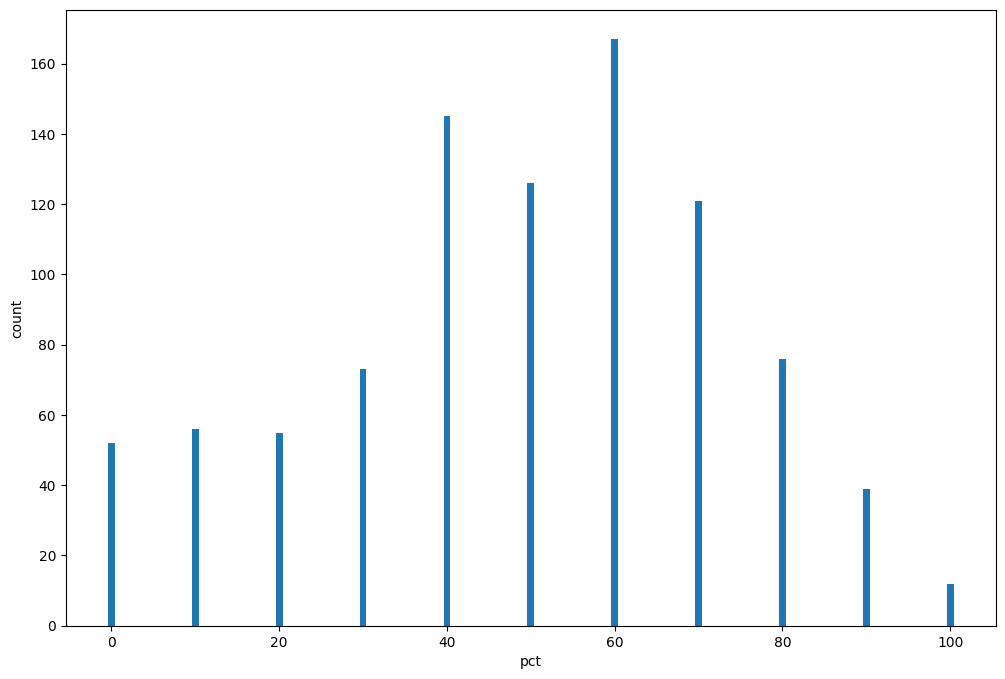

In [182]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.bar(overlapping["test_train_overlapping"].values, overlapping["count"].values)
ax.set_xlabel("pct")
ax.set_ylabel("count")

plt.show()

In [ ]:
data_coverage_df["test_train_overlapping"].mean(), data_coverage_df["test_train_overlapping"].std()

(53.6187852494577, 24.356711833392858)

## Correlation between track duration and coverage?

In [196]:
site_id, floor_id =  data_coverage_df[["site_id", "floor_id"]].values[1]

In [197]:
splited_group_data = train_test_assignment[(train_test_assignment["site_id"] == site_id)
                                            & (train_test_assignment["floor_id"] == floor_id)]

In [198]:
floor_info, floor_map = read_floor_data(f"../../data/metadata/{site_id}/{floor_id}")

(
  floor_polygons,
  store_polygons,
  x_min,
  y_min,
  x_max,
  y_max,
  width_meter,
  height_meter,
) = extract_floor_map_geometries(floor_map, floor_info, transform=lambda coords: coords)

floor_map_coverage_estimator = FloorMapCoverageEstimator(floor_polygons, store_polygons, width_meter, height_meter)

In [206]:
track_id_list = splited_group_data[splited_group_data["dataset"] == "train"]["track_id"].values.tolist()

track_coverage_data = []

for track_id in tqdm(track_id_list):
  train_fingerprint_locations = read_fingerprint_locations(
    site_id=site_id, floor_id=floor_id, data_dir=data_dir, 
    track_id_list=[track_id])
  
  track_length = np.linalg.norm(train_fingerprint_locations[1:] - train_fingerprint_locations[:-1], axis=1).sum()
  
  train_covered_bins = floor_map_coverage_estimator.get_bin_coverage(train_fingerprint_locations, tol=floor_map_coverage_estimator.grid_resolution*2)
  floor_train_coverage_pct = train_covered_bins.shape[0] / floor_map_coverage_estimator.n_bins * 100

  track_coverage_data.append((track_id, track_length, floor_train_coverage_pct))

  0%|          | 0/73 [00:00<?, ?it/s]

The number of BSSIDs with at least 0 samples: 519


  1%|▏         | 1/73 [00:00<00:21,  3.36it/s]

The number of fingerprints: 46
The number of BSSIDs with at least 0 samples: 583


  3%|▎         | 2/73 [00:00<00:17,  4.10it/s]

The number of fingerprints: 36
The number of BSSIDs with at least 0 samples: 541


  4%|▍         | 3/73 [00:00<00:15,  4.61it/s]

The number of fingerprints: 30
The number of BSSIDs with at least 0 samples: 419


  5%|▌         | 4/73 [00:00<00:15,  4.60it/s]

The number of fingerprints: 33
The number of BSSIDs with at least 0 samples: 519


  7%|▋         | 5/73 [00:01<00:13,  5.00it/s]

The number of fingerprints: 30
The number of BSSIDs with at least 0 samples: 422


  8%|▊         | 6/73 [00:01<00:11,  5.66it/s]

The number of fingerprints: 31
The number of BSSIDs with at least 0 samples: 554


 10%|▉         | 7/73 [00:01<00:10,  6.20it/s]

The number of fingerprints: 25
The number of BSSIDs with at least 0 samples: 497


 11%|█         | 8/73 [00:01<00:09,  6.73it/s]

The number of fingerprints: 25
The number of BSSIDs with at least 0 samples: 434


 12%|█▏        | 9/73 [00:01<00:08,  7.28it/s]

The number of fingerprints: 27
The number of BSSIDs with at least 0 samples: 317


100%|██████████| 1/1 [00:00<00:00, 18.79it/s]


The number of fingerprints: 26
The number of BSSIDs with at least 0 samples: 500


 15%|█▌        | 11/73 [00:01<00:07,  8.20it/s]

The number of fingerprints: 24
The number of BSSIDs with at least 0 samples: 384


 16%|█▋        | 12/73 [00:01<00:07,  8.43it/s]

The number of fingerprints: 24
The number of BSSIDs with at least 0 samples: 472


 18%|█▊        | 13/73 [00:02<00:07,  7.66it/s]

The number of fingerprints: 23
The number of BSSIDs with at least 0 samples: 515


 19%|█▉        | 14/73 [00:02<00:08,  7.31it/s]

The number of fingerprints: 23
The number of BSSIDs with at least 0 samples: 452


 21%|██        | 15/73 [00:02<00:07,  7.58it/s]

The number of fingerprints: 22
The number of BSSIDs with at least 0 samples: 525


 22%|██▏       | 16/73 [00:02<00:07,  7.90it/s]

The number of fingerprints: 22
The number of BSSIDs with at least 0 samples: 371


 23%|██▎       | 17/73 [00:02<00:06,  8.06it/s]

The number of fingerprints: 22
The number of BSSIDs with at least 0 samples: 428


100%|██████████| 1/1 [00:00<00:00, 19.72it/s]


The number of fingerprints: 22
The number of BSSIDs with at least 0 samples: 439


 26%|██▌       | 19/73 [00:02<00:06,  8.66it/s]

The number of fingerprints: 22
The number of BSSIDs with at least 0 samples: 229


100%|██████████| 1/1 [00:00<00:00, 25.12it/s]


The number of fingerprints: 25
The number of BSSIDs with at least 0 samples: 492


 29%|██▉       | 21/73 [00:02<00:05,  9.26it/s]

The number of fingerprints: 20
The number of BSSIDs with at least 0 samples: 372


100%|██████████| 1/1 [00:00<00:00, 17.24it/s]

The number of fingerprints: 22


The number of BSSIDs with at least 0 samples: 503


100%|██████████| 1/1 [00:00<00:00, 11.88it/s]

The number of fingerprints: 19



 32%|███▏      | 23/73 [00:03<00:05,  9.08it/s]

The number of BSSIDs with at least 0 samples: 380


100%|██████████| 1/1 [00:00<00:00, 14.36it/s]

The number of fingerprints: 19



 33%|███▎      | 24/73 [00:03<00:05,  9.08it/s]

The number of BSSIDs with at least 0 samples: 310


100%|██████████| 1/1 [00:00<00:00, 23.34it/s]


The number of fingerprints: 21
The number of BSSIDs with at least 0 samples: 381


100%|██████████| 1/1 [00:00<00:00, 12.99it/s]

The number of fingerprints: 21



 36%|███▌      | 26/73 [00:03<00:05,  8.66it/s]

The number of BSSIDs with at least 0 samples: 478


 37%|███▋      | 27/73 [00:03<00:05,  8.42it/s]

The number of fingerprints: 17
The number of BSSIDs with at least 0 samples: 500


 38%|███▊      | 28/73 [00:03<00:05,  8.73it/s]

The number of fingerprints: 17
The number of BSSIDs with at least 0 samples: 457


 40%|███▉      | 29/73 [00:03<00:05,  7.99it/s]

The number of fingerprints: 19
The number of BSSIDs with at least 0 samples: 481


100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


The number of fingerprints: 17
The number of BSSIDs with at least 0 samples: 469


 42%|████▏     | 31/73 [00:04<00:04,  8.96it/s]

The number of fingerprints: 16
The number of BSSIDs with at least 0 samples: 346


100%|██████████| 1/1 [00:00<00:00, 18.59it/s]


The number of fingerprints: 19
The number of BSSIDs with at least 0 samples: 513


 45%|████▌     | 33/73 [00:04<00:04,  9.05it/s]

The number of fingerprints: 18
The number of BSSIDs with at least 0 samples: 484


100%|██████████| 1/1 [00:00<00:00, 21.39it/s]

The number of fingerprints: 16


The number of BSSIDs with at least 0 samples: 399


100%|██████████| 1/1 [00:00<00:00, 14.54it/s]


The number of fingerprints: 18


 48%|████▊     | 35/73 [00:04<00:04,  9.34it/s]

The number of BSSIDs with at least 0 samples: 502


 49%|████▉     | 36/73 [00:04<00:03,  9.32it/s]

The number of fingerprints: 15
The number of BSSIDs with at least 0 samples: 288


100%|██████████| 1/1 [00:00<00:00, 25.56it/s]


The number of fingerprints: 17


 51%|█████     | 37/73 [00:04<00:04,  8.60it/s]

The number of BSSIDs with at least 0 samples: 474


 52%|█████▏    | 38/73 [00:04<00:03,  8.76it/s]

The number of fingerprints: 15
The number of BSSIDs with at least 0 samples: 308


100%|██████████| 1/1 [00:00<00:00, 29.47it/s]


The number of fingerprints: 15
The number of BSSIDs with at least 0 samples: 477


 55%|█████▍    | 40/73 [00:05<00:03,  9.87it/s]

The number of fingerprints: 14
The number of BSSIDs with at least 0 samples: 346


100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


The number of fingerprints: 15
The number of BSSIDs with at least 0 samples: 418


 58%|█████▊    | 42/73 [00:05<00:03,  9.62it/s]

The number of fingerprints: 14
The number of BSSIDs with at least 0 samples: 404


100%|██████████| 1/1 [00:00<00:00, 19.38it/s]

The number of fingerprints: 14


The number of BSSIDs with at least 0 samples: 459


 60%|██████    | 44/73 [00:05<00:03,  9.61it/s]

The number of fingerprints: 13
The number of BSSIDs with at least 0 samples: 378


100%|██████████| 1/1 [00:00<00:00, 16.57it/s]

The number of fingerprints: 14


The number of BSSIDs with at least 0 samples: 290


 63%|██████▎   | 46/73 [00:05<00:02, 10.12it/s]

The number of fingerprints: 15
The number of BSSIDs with at least 0 samples: 469


100%|██████████| 1/1 [00:00<00:00, 24.58it/s]


The number of fingerprints: 12
The number of BSSIDs with at least 0 samples: 379


 66%|██████▌   | 48/73 [00:05<00:02, 10.88it/s]

The number of fingerprints: 14
The number of BSSIDs with at least 0 samples: 480


100%|██████████| 1/1 [00:00<00:00, 22.44it/s]


The number of fingerprints: 13
The number of BSSIDs with at least 0 samples: 307


100%|██████████| 1/1 [00:00<00:00, 24.07it/s]


The number of fingerprints: 13


 68%|██████▊   | 50/73 [00:06<00:02,  9.62it/s]

The number of BSSIDs with at least 0 samples: 275


100%|██████████| 1/1 [00:00<00:00, 44.68it/s]


The number of fingerprints: 14
The number of BSSIDs with at least 0 samples: 202


 71%|███████   | 52/73 [00:06<00:01, 11.08it/s]

The number of fingerprints: 14
The number of BSSIDs with at least 0 samples: 325


100%|██████████| 1/1 [00:00<00:00, 28.60it/s]


The number of fingerprints: 13
The number of BSSIDs with at least 0 samples: 329


 74%|███████▍  | 54/73 [00:06<00:01, 11.50it/s]

The number of fingerprints: 13
The number of BSSIDs with at least 0 samples: 315


100%|██████████| 1/1 [00:00<00:00, 28.81it/s]

The number of fingerprints: 11


The number of BSSIDs with at least 0 samples: 426


 77%|███████▋  | 56/73 [00:06<00:01, 12.07it/s]

The number of fingerprints: 11
The number of BSSIDs with at least 0 samples: 333


100%|██████████| 1/1 [00:00<00:00, 19.31it/s]


The number of fingerprints: 11
The number of BSSIDs with at least 0 samples: 366


 79%|███████▉  | 58/73 [00:06<00:01, 12.41it/s]

The number of fingerprints: 11
The number of BSSIDs with at least 0 samples: 449


100%|██████████| 1/1 [00:00<00:00, 25.80it/s]


The number of fingerprints: 11
The number of BSSIDs with at least 0 samples: 426


 82%|████████▏ | 60/73 [00:06<00:01, 12.62it/s]

The number of fingerprints: 10
The number of BSSIDs with at least 0 samples: 400


100%|██████████| 1/1 [00:00<00:00, 29.46it/s]

The number of fingerprints: 11


The number of BSSIDs with at least 0 samples: 323


100%|██████████| 1/1 [00:00<00:00, 44.17it/s]


The number of fingerprints: 11


 85%|████████▍ | 62/73 [00:06<00:00, 13.69it/s]

The number of BSSIDs with at least 0 samples: 236


100%|██████████| 1/1 [00:00<00:00, 42.63it/s]


The number of fingerprints: 11
The number of BSSIDs with at least 0 samples: 380


 88%|████████▊ | 64/73 [00:07<00:00, 14.62it/s]

The number of fingerprints: 11
The number of BSSIDs with at least 0 samples: 379


100%|██████████| 1/1 [00:00<00:00, 21.52it/s]


The number of fingerprints: 11
The number of BSSIDs with at least 0 samples: 287


 90%|█████████ | 66/73 [00:07<00:00, 13.02it/s]

The number of fingerprints: 10
The number of BSSIDs with at least 0 samples: 321


100%|██████████| 1/1 [00:00<00:00, 32.91it/s]


The number of fingerprints: 10
The number of BSSIDs with at least 0 samples: 426


 93%|█████████▎| 68/73 [00:07<00:00, 13.44it/s]

The number of fingerprints: 11
The number of BSSIDs with at least 0 samples: 324


100%|██████████| 1/1 [00:00<00:00, 40.39it/s]


The number of fingerprints: 10
The number of BSSIDs with at least 0 samples: 402


100%|██████████| 1/1 [00:00<00:00, 39.08it/s]


The number of fingerprints: 10


 96%|█████████▌| 70/73 [00:07<00:00, 14.26it/s]

The number of BSSIDs with at least 0 samples: 371


100%|██████████| 1/1 [00:00<00:00, 33.16it/s]


The number of fingerprints: 10
The number of BSSIDs with at least 0 samples: 333


 99%|█████████▊| 72/73 [00:07<00:00, 14.13it/s]

The number of fingerprints: 9
The number of BSSIDs with at least 0 samples: 361


100%|██████████| 73/73 [00:07<00:00,  9.47it/s]

The number of fingerprints: 9


In [210]:
df = pd.DataFrame(track_coverage_data, columns=["track_id", "length", "coverage_pct"])

In [214]:
import scipy.stats

In [212]:
np.corrcoef(df["length"].values, df["coverage_pct"].values)

array([[1.        , 0.91533489],
       [0.91533489, 1.        ]])

In [215]:
scipy.stats.pearsonr(df["length"].values, df["coverage_pct"].values)

PearsonRResult(statistic=0.9153348931675829, pvalue=9.231100621342395e-30)

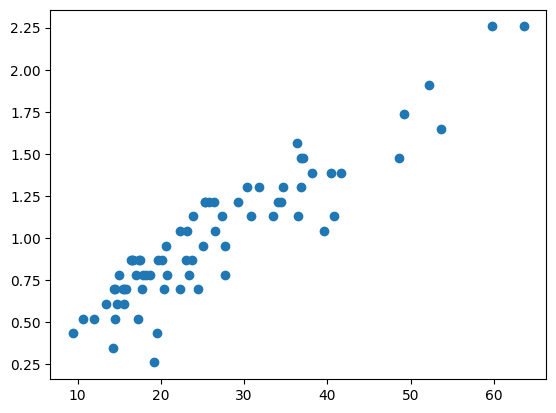

In [213]:
plt.scatter(df["length"].values, df["coverage_pct"].values)

In [193]:
train_covered_bins = floor_map_coverage_estimator.get_bin_coverage(train_fingerprint_locations, tol=floor_map_coverage_estimator.grid_resolution*2)
floor_train_coverage_pct = train_covered_bins.shape[0] / floor_map_coverage_estimator.n_bins * 100

In [194]:
floor_train_coverage_pct

15.798462852263023

In [ ]:
def estimate_train_test_coverage(site_id: str, floor_id: str, track_assignment_df: pd.DataFrame):
  
  splited_group_data = track_assignment_df[(track_assignment_df["site_id"] == site_id) & (track_assignment_df["floor_id"] == floor_id)]
  train_fingerprint_locations = read_fingerprint_locations(
    site_id=site_id, floor_id=floor_id, data_dir=data_dir, 
    track_id_list=splited_group_data[splited_group_data["dataset"] == "train"]["track_id"].values.tolist())
  test_fingerprint_locations = read_fingerprint_locations(
    site_id=site_id, floor_id=floor_id, data_dir=data_dir, 
    track_id_list=splited_group_data[splited_group_data["dataset"] == "test"]["track_id"].values.tolist())
  
  floor_info, floor_map = read_floor_data(f"../../data/metadata/{site_id}/{floor_id}")

  (
    floor_polygons,
    store_polygons,
    x_min,
    y_min,
    x_max,
    y_max,
    width_meter,
    height_meter,
  ) = extract_floor_map_geometries(floor_map, floor_info, transform=lambda coords: coords)

  fm_coverage_estimator = FloorMapCoverageEstimator(floor_polygons, store_polygons, width_meter, height_meter)

  # The amount of floormap area covered by the train dataset
  train_covered_bins = fm_coverage_estimator.get_bin_coverage(train_fingerprint_locations, tol=fm_coverage_estimator.grid_resolution*2)
  floor_train_coverage_pct = train_covered_bins.shape[0] / fm_coverage_estimator.n_bins * 100

  # The amount of floormap area covered by the test dataset
  test_covered_bins = fm_coverage_estimator.get_bin_coverage(test_fingerprint_locations, tol=fm_coverage_estimator.grid_resolution*2)
  floor_test_coverage_pct = test_covered_bins.shape[0] / fm_coverage_estimator.n_bins * 100

  # The amount of test locations which contain at least 1 fingerprint in the train dataset  
  test_train_overlapping_pct = len(set(test_covered_bins).intersection(set(train_covered_bins))) / len(set(test_covered_bins)) * 100

  return {
    "floor_train_coverage": round(floor_train_coverage_pct, 2), 
    "floor_test_coverage": round(floor_test_coverage_pct, 2), 
    "test_train_overlapping": round(test_train_overlapping_pct, 2),
    "site_id": site_id,
    "floor_id": floor_id,
  }